In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import re
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# gradient boosting machines
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import (cross_val_score, train_test_split)
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool, cv

# hyperparameter tuning
from bayes_opt import BayesianOptimization

# to print all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from tqdm import tqdm

In [2]:
os.listdir('./data')

['~$zillow_data_dictionary.xlsx',
 'train_2017.csv',
 'properties_2017.csv',
 'properties_2016.csv',
 'train_2016_v2.csv',
 'zillow_data_dictionary.xlsx',
 'sample_submission.csv']

In [3]:
# loading dataset
train_16 = pd.read_csv('./data/train_2016_v2.csv', parse_dates=['transactiondate'])
train_17 = pd.read_csv('./data/train_2017.csv', parse_dates=['transactiondate'])
properties_16 = pd.read_csv('./data/properties_2016.csv')
properties_17 = pd.read_csv('./data/properties_2017.csv')

In [26]:
def reduce_mem_usage(df, verbose=True):
    '''
    reduce memory usage. This function is taken from FabienDaniel from another Kaggle competition
    '''
    df.fillna(np.nan, inplace=True)
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.\
                      format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def get_prop(properties):
    # modify properties dataset, handle in null values
    prop = properties.copy()

    # drop columns of which 99% of values are null
    drop_thresh = prop.shape[0] * 0.01
    prop.dropna(thresh=drop_thresh, axis=1, inplace=True)

    # drop columns if the number of unique values is one
    unique_mask = (prop.nunique() == 1)
    prop.drop(prop.columns[unique_mask], axis=1, inplace=True)
    
    # propertycountylandusecode column has mix of float and str
    prop['propertycountylandusecode'] = prop['propertycountylandusecode'].astype('str')

    # fill in null values
    '''
    Zillow team has built model to predict the sale price of the property and the target they give us is the error
    between their predicted value and the actual value. Our goal is to predict the error they have made, so I believe
    it is better to fill in the null with values that deviate from the actual values instead of filling in median just
    to mimic the situation Zillow team faced when they are doing prediction.
    '''
    for col in prop.columns:
        if prop[col].dtype == 'object':
            prop[col].fillna('NULL', inplace=True)
        else:
            prop[col].fillna(-999, inplace=True)
            
    # put create feature function here if needed
            
    return prop

def get_train(train_set):
    
    train = train_set.copy()
    
    train['month'] = train['transactiondate'].dt.month
    train['month_since_2016'] = (train['transactiondate'].dt.year - 2016) * 12 + train['month']
    train['quarter'] = (train['transactiondate'].dt.month - 1) // 3 + 1
    train.drop('transactiondate', axis=1, inplace=True)
    
    return train

def create_features(dataset):
    
    '''
    create more features for properties table
    '''
    
    #years since the property is built
    dataset['property_life'] = 2018 - dataset['yearbuilt']

    #error in calculation of the finished living area of home
    dataset['living_error'] = dataset['calculatedfinishedsquarefeet']/dataset['finishedsquarefeet12']

    #proportion of living area
    dataset['living_lot_ratio'] = dataset['calculatedfinishedsquarefeet']/dataset['lotsizesquarefeet']
    dataset['living_totoal_ratio'] = dataset['finishedsquarefeet12']/dataset['finishedsquarefeet15']

    #Amout of extra space
    dataset['lot_extra'] = dataset['lotsizesquarefeet'] - dataset['calculatedfinishedsquarefeet'] 
    dataset['extra_space'] = dataset['finishedsquarefeet15'] - dataset['finishedsquarefeet12'] 

    #Total number of rooms
    dataset['total_rooms'] = dataset['bathroomcnt'] + dataset['bedroomcnt']

    #Ratio of the built structure value to land area
    dataset['structure_land_val_ratio'] = dataset['structuretaxvaluedollarcnt']/dataset['landtaxvaluedollarcnt']

    #Ratio of tax of property over parcel
    dataset['inverse_tax_rate'] = dataset['taxvaluedollarcnt']/dataset['taxamount']

    #Length of time since unpaid taxes
    dataset['past_due_tax_years'] = 2018 - dataset['taxdelinquencyyear']
    
    #Number of properties in the zip
    zip_count = dataset['regionidzip'].value_counts().to_dict()
    dataset['zip_cnt'] = dataset['regionidzip'].map(zip_count)

    #Number of properties in the city
    city_count = dataset['regionidcity'].value_counts().to_dict()
    dataset['city_cnt'] = dataset['regionidcity'].map(city_count)

    #Number of properties in the city
    region_count = dataset['regionidcounty'].value_counts().to_dict()
    dataset['county_cnt'] = dataset['regionidcounty'].map(region_count)
    
    #polnomials of the variable
    dataset["structuretaxvaluedollarcnt_2"] = dataset["structuretaxvaluedollarcnt"] ** 2
    dataset["structuretaxvaluedollarcnt_3"] = dataset["structuretaxvaluedollarcnt"] ** 3

    #Average structuretaxvaluedollarcnt by city
    group = dataset.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
    dataset['avg_structuretaxvaluedollarcnt'] = dataset['regionidcity'].map(group)

    #Deviation away from average
    dataset['dev_structuretaxvaluedollarcnt'] = \
    abs((dataset['structuretaxvaluedollarcnt'] - \
         dataset['avg_structuretaxvaluedollarcnt']))/dataset['avg_structuretaxvaluedollarcnt']
    
    #area per unit if there are multiple units
    dataset['area_per_unit'] = dataset['finishedsquarefeet15'] / dataset['unitcnt']
    
    #living area per floor
    dataset['living_per_floor'] = dataset['finishedsquarefeet12'] / dataset['numberofstories']
    
    return dataset

def get_cat_feats(dataset):
    '''
    get categorical feature columns of dataset
    '''
    cat_thresh = 1000    # categorical features if number of unique values under cat_thresh
    cat_feats = ['propertyzoningdesc']
    for col in dataset.columns:
        not_count = (re.search('.*(sqft|cnt|nbr|number|since|year|life|total).*', col) is None)
        if not_count and dataset[col].nunique() <= cat_thresh:
            cat_feats.append(col)
    return cat_feats

def convert_cat_columns(dataset, cat_feats):
    '''
    convert categorical feature column data type to string as required by catboost
    '''
    for col in cat_feats:
        if dataset[col].dtype == 'object':
            dataset[col] = dataset[col].astype('str')
        else:
            dataset[col] = dataset[col].astype('int')
        
    return dataset

def bayes_param_opt(X, y, cat_feats, init_points=15, n_iter=25, n_folds=5, random_seed=1, \
                        output_process=False):
    
    # prepare dataset
    dtrain = Pool(data=X, label=y, cat_features= cat_feats)
    
    # define objective function to minimize
    def cat_cv(bagging_fraction, max_depth, lambda_l2, \
                 num_iterations, learning_rate):
        
        params = {'loss_function':'MAE', 'random_seed':1, 'eval_metric':'MAE',
                 'use_best_model':True, 'early_stopping_rounds':20, 'bootstrap_type':'Bernoulli'}
        params['n_estimators'] = int(num_iterations)
        params['learning_rate'] = max(learning_rate, 0)
        params['subsample'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['l2_leaf_reg'] = max(lambda_l2, 0)
#         lgbr = LGBMRegressor(params)
#         cv_result = cross_val_score(estimator=lgbr, X=X, y=y, cv=n_folds, scoring='neg_mean_absolute_error')
        cv_result = cv(dtrain=dtrain, params=params, nfold=n_folds, seed=1, shuffle=True)
        return - cv_result['test-MAE-mean'].min()
    
    optimizer = BayesianOptimization(cat_cv, {
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 15),
                                            'lambda_l2': (0, 5),
                                            'num_iterations':(100, 2000),
                                            'learning_rate':(0.025,0.1),
                                            }, random_state=0)
    
    optimizer.maximize(init_points=init_points, n_iter=n_iter)
    
    return optimizer.max

In [88]:
# feature selection object
# the idea is from Olivier: https://www.kaggle.com/ogrellier/feature-selection-with-null-importances
class FeatureSelection(object):
    
    '''
    FeatureSelection uses target permutation method to compare the features importances for actual train set and 
    null importance features for fake train set (training data unchanged, but target shuffled). Features of which the
    actual importance value does not fall too close with the fake importance value are considered valid features.
    '''
    
    def __init__(self, df, categorical_feats):
        self.df = df
        self.cat_feats = categorical_feats
        self.cat_feats_set = set(categorical_feats)
        self.target = df['logerror']
        self.train_features = [col for col in df.columns if col not in {'parcelid', 'logerror'}]
        self.scores = None
        
    def get_feature_importances(self, shuffle, seed=1):
        
        data=self.df
        categorical_feats=self.cat_feats

        y = self.target.copy()
        train_features = self.train_features

        # Shuffle target if required
        if shuffle:
            y = data['logerror'].copy().sample(frac=1.0)

        # Fit LightGBM 
        dtrain = Pool(data=data[train_features], label=y, cat_features=categorical_feats)
        regressor = CatBoostRegressor(subsample=0.8885796692189906,
                                      l2_leaf_reg=4.469523358625079,
                                      learning_rate=0.07802234255790369,
                                      max_depth=5,
                                      iterations=300,
                                      loss_function='MAE', 
                                      random_seed=1,
                                      eval_metric='MAE',
                                      bootstrap_type='Bernoulli')

        regressor.fit(X=dtrain)    

        # Get feature importances
        imp_df = pd.DataFrame()
        imp_df["feature"] = list(train_features)
        imp_df["importance"] = regressor.feature_importances_

        return imp_df
    
    def get_imp(self, fake):
        
        '''
        get importance dataframe. if fake is True, will return the null importance df based on permuted labels.
        '''
        
        imp_df = pd.DataFrame()
        nb_runs = 100
        
        for i in range(nb_runs):
            # Get current run importances
            temp_df = self.get_feature_importances(shuffle=fake)
            temp_df['run'] = i + 1 
            # Concat the latest importances with the old ones
            imp_df = pd.concat([imp_df, temp_df], axis=0)
            
        return imp_df
    
    def run_imp(self):
        self.act_imp_df = self.get_imp(fake=False)
        self.null_imp_df = self.get_imp(fake=True)
        
    def display_distributions(self,  feature_):
        
        '''
        plot the distribution of feature importance of feature_ based on actual feature importance and
        null feature importance. For feature that is informative, the actual importance value should be much larger
        than the null impotance value.
        '''
        # load feature importance df
        actual_imp_df_=self.act_imp_df 
        null_imp_df_=self.null_imp_df
        
        plt.figure(figsize=(13, 6))
        gs = gridspec.GridSpec(1, 1)
        # Plot Split importances
        ax = plt.subplot(gs[0, 0])
        a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance'].values, bins=30, \
                    label='Null importances')
        ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance'].mean(), 
                   ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
        ax.legend()
        ax.set_title('Feature Importance of %s' % feature_.upper(), fontweight='bold')
#         plt.xlabel('Null Importance Distribution for %s ' % feature_.upper())
        
    
    def get_scores(self):
        
        actual_imp_df_= self.act_imp_df 
        null_imp_df_ = self.null_imp_df
        correlation_scores = []
        
        for _f in actual_imp_df_['feature'].unique():
            f_null_imps = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance'].values
            f_act_imps = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance'].values
            score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
            
            correlation_scores.append((_f, score))

        corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'score'])
        self.scores = corr_scores_df.copy()
        
    def cv_score(self, train_features, cat_feats, df=None, target=None):
        
        if not df:
            df=self.df
            target=self.target
            
        dtrain = Pool(data=df[train_features], label=target, cat_features=cat_feats)
        
        opt_cat_params = {
              'subsample': 0.8885796692189906,
              'l2_leaf_reg': 4.469523358625079,
              'learning_rate': 0.07802234255790369,
              'max_depth': 5,
              'iterations': 2000,    # set to large number, but trees will stop growing by overfitting detector
              'loss_function':'MAE', 
              'random_seed':1,
              'eval_metric':'MAE',
              'use_best_model':True, 
              'early_stopping_rounds':50, 
              'bootstrap_type':'Bernoulli'
                          }
    
    
        # Fit the model
        scores = cv(dtrain=dtrain, params=opt_cat_params, nfold=5, seed=1, shuffle=True)
        # Return the last mean / std values 
        return scores['test-MAE-mean'].min()
    
    def choose_threshold(self):
        
        imp_scores = self.scores
        
        threshold_score = []
        features = {}
        for threshold in np.arange(0,100,10):
            good_feats = imp_scores.loc[imp_scores['score'] > threshold, 'feature']
            good_cat_feats = [_f for _f in good_feats if _f in self.cat_feats_set]
            
            feature_dict = {'good_feats':good_feats, 'good_cat_feats':good_cat_feats}
            features[threshold] = feature_dict
            
            print('Results for threshold %3d' % threshold)
            results = self.cv_score(train_features=good_feats, cat_feats=good_cat_feats)
            print('score: {}'.format(results))

            threshold_score.append([threshold, results])
            
        threshold_df = pd.DataFrame(data=threshold_score, columns=['threshold', 'MAE-mean'])
        threshold_df.sort_values(by='MAE-mean', ascending=True, inplace=True)
        
        return threshold_df, features
             

In [28]:
# prepare training set
prop_16 = get_prop(properties_16)
prop_16 = create_features(prop_16)
prop_17 = get_prop(properties_17)
prop_17 = create_features(prop_17)

In [30]:
cat_feats = get_cat_feats(prop_16)

transac_16 = get_train(train_16)
df_16 = transac_16.merge(prop_16, how='left', on='parcelid')

transac_17 = get_train(train_17)
df_17 = transac_17.merge(prop_17, how='left', on='parcelid')

train = pd.concat([df_16, df_17], axis=0)

train = convert_cat_columns(train, cat_feats)

# get train feature columns
train_feats = [col for col in train if col not in {'parcelid', 'logerror'}]

# prepare x and y
x = train[train_feats]
y = train['logerror']

In [31]:
opt_cat_params = {
  'subsample': 0.8885796692189906,
  'l2_leaf_reg': 4.469523358625079,
  'learning_rate': 0.07802234255790369,
  'max_depth': 5,
  'iterations': 2000,    # set to large number, but trees will stop growing by overfitting detector
  'loss_function':'MAE', 
  'random_seed':1,
  'eval_metric':'MAE',
  'use_best_model':True, 
  'early_stopping_rounds':50, 
  'bootstrap_type':'Bernoulli'
        }

dtrain = Pool(data=x, label=y, cat_features=cat_feats)
scores = cv(dtrain=dtrain, params=opt_cat_params, nfold=5, seed=1, shuffle=True)

0:	learn: 0.0691382	test: 0.0691406	best: 0.0691406 (0)	total: 756ms	remaining: 25m 10s
1:	learn: 0.0690644	test: 0.0690681	best: 0.0690681 (1)	total: 1.35s	remaining: 22m 26s
2:	learn: 0.0689984	test: 0.0690015	best: 0.0690015 (2)	total: 1.92s	remaining: 21m 18s
3:	learn: 0.0689383	test: 0.0689420	best: 0.0689420 (3)	total: 2.48s	remaining: 20m 36s
4:	learn: 0.0688857	test: 0.0688893	best: 0.0688893 (4)	total: 3.05s	remaining: 20m 17s
5:	learn: 0.0688389	test: 0.0688436	best: 0.0688436 (5)	total: 3.58s	remaining: 19m 51s
6:	learn: 0.0687981	test: 0.0688027	best: 0.0688027 (6)	total: 4.16s	remaining: 19m 44s
7:	learn: 0.0687577	test: 0.0687641	best: 0.0687641 (7)	total: 4.71s	remaining: 19m 33s
8:	learn: 0.0687241	test: 0.0687293	best: 0.0687293 (8)	total: 5.26s	remaining: 19m 24s
9:	learn: 0.0686930	test: 0.0686992	best: 0.0686992 (9)	total: 5.83s	remaining: 19m 20s
10:	learn: 0.0686645	test: 0.0686719	best: 0.0686719 (10)	total: 6.41s	remaining: 19m 18s
11:	learn: 0.0686375	test: 0.0

92:	learn: 0.0680833	test: 0.0681572	best: 0.0681572 (92)	total: 1m 1s	remaining: 21m 1s
93:	learn: 0.0680805	test: 0.0681559	best: 0.0681559 (93)	total: 1m 2s	remaining: 21m 1s
94:	learn: 0.0680779	test: 0.0681541	best: 0.0681541 (94)	total: 1m 2s	remaining: 21m 1s
95:	learn: 0.0680751	test: 0.0681524	best: 0.0681524 (95)	total: 1m 3s	remaining: 21m 1s
96:	learn: 0.0680726	test: 0.0681510	best: 0.0681510 (96)	total: 1m 4s	remaining: 21m 1s
97:	learn: 0.0680710	test: 0.0681500	best: 0.0681500 (97)	total: 1m 4s	remaining: 21m
98:	learn: 0.0680683	test: 0.0681478	best: 0.0681478 (98)	total: 1m 5s	remaining: 20m 59s
99:	learn: 0.0680656	test: 0.0681463	best: 0.0681463 (99)	total: 1m 6s	remaining: 20m 59s
100:	learn: 0.0680624	test: 0.0681447	best: 0.0681447 (100)	total: 1m 6s	remaining: 20m 59s
101:	learn: 0.0680603	test: 0.0681436	best: 0.0681436 (101)	total: 1m 7s	remaining: 20m 58s
102:	learn: 0.0680575	test: 0.0681417	best: 0.0681417 (102)	total: 1m 8s	remaining: 20m 58s
103:	learn: 0

181:	learn: 0.0678368	test: 0.0680336	best: 0.0680336 (181)	total: 2m 1s	remaining: 20m 15s
182:	learn: 0.0678338	test: 0.0680320	best: 0.0680320 (182)	total: 2m 2s	remaining: 20m 14s
183:	learn: 0.0678298	test: 0.0680301	best: 0.0680301 (183)	total: 2m 2s	remaining: 20m 13s
184:	learn: 0.0678271	test: 0.0680289	best: 0.0680289 (184)	total: 2m 3s	remaining: 20m 12s
185:	learn: 0.0678239	test: 0.0680268	best: 0.0680268 (185)	total: 2m 4s	remaining: 20m 13s
186:	learn: 0.0678209	test: 0.0680259	best: 0.0680259 (186)	total: 2m 5s	remaining: 20m 12s
187:	learn: 0.0678181	test: 0.0680250	best: 0.0680250 (187)	total: 2m 5s	remaining: 20m 11s
188:	learn: 0.0678136	test: 0.0680234	best: 0.0680234 (188)	total: 2m 6s	remaining: 20m 11s
189:	learn: 0.0678106	test: 0.0680226	best: 0.0680226 (189)	total: 2m 7s	remaining: 20m 10s
190:	learn: 0.0678070	test: 0.0680210	best: 0.0680210 (190)	total: 2m 7s	remaining: 20m 9s
191:	learn: 0.0678041	test: 0.0680202	best: 0.0680202 (191)	total: 2m 8s	remainin

270:	learn: 0.0676027	test: 0.0679528	best: 0.0679528 (270)	total: 3m 1s	remaining: 19m 15s
271:	learn: 0.0675998	test: 0.0679523	best: 0.0679523 (271)	total: 3m 1s	remaining: 19m 14s
272:	learn: 0.0675977	test: 0.0679520	best: 0.0679520 (272)	total: 3m 2s	remaining: 19m 14s
273:	learn: 0.0675950	test: 0.0679519	best: 0.0679519 (273)	total: 3m 3s	remaining: 19m 13s
274:	learn: 0.0675929	test: 0.0679519	best: 0.0679519 (274)	total: 3m 3s	remaining: 19m 12s
275:	learn: 0.0675908	test: 0.0679518	best: 0.0679518 (275)	total: 3m 4s	remaining: 19m 12s
276:	learn: 0.0675887	test: 0.0679515	best: 0.0679515 (276)	total: 3m 5s	remaining: 19m 11s
277:	learn: 0.0675870	test: 0.0679510	best: 0.0679510 (277)	total: 3m 5s	remaining: 19m 11s
278:	learn: 0.0675857	test: 0.0679505	best: 0.0679505 (278)	total: 3m 6s	remaining: 19m 10s
279:	learn: 0.0675831	test: 0.0679490	best: 0.0679490 (279)	total: 3m 7s	remaining: 19m 9s
280:	learn: 0.0675809	test: 0.0679483	best: 0.0679483 (280)	total: 3m 7s	remainin

359:	learn: 0.0674260	test: 0.0679204	best: 0.0679204 (359)	total: 4m	remaining: 18m 14s
360:	learn: 0.0674241	test: 0.0679202	best: 0.0679202 (360)	total: 4m 1s	remaining: 18m 14s
361:	learn: 0.0674224	test: 0.0679201	best: 0.0679201 (361)	total: 4m 1s	remaining: 18m 13s
362:	learn: 0.0674201	test: 0.0679195	best: 0.0679195 (362)	total: 4m 2s	remaining: 18m 12s
363:	learn: 0.0674185	test: 0.0679192	best: 0.0679192 (363)	total: 4m 2s	remaining: 18m 12s
364:	learn: 0.0674167	test: 0.0679186	best: 0.0679186 (364)	total: 4m 3s	remaining: 18m 11s
365:	learn: 0.0674154	test: 0.0679183	best: 0.0679183 (365)	total: 4m 4s	remaining: 18m 10s
366:	learn: 0.0674140	test: 0.0679180	best: 0.0679180 (366)	total: 4m 4s	remaining: 18m 10s
367:	learn: 0.0674120	test: 0.0679176	best: 0.0679176 (367)	total: 4m 5s	remaining: 18m 9s
368:	learn: 0.0674105	test: 0.0679176	best: 0.0679176 (367)	total: 4m 6s	remaining: 18m 8s
369:	learn: 0.0674081	test: 0.0679163	best: 0.0679163 (369)	total: 4m 6s	remaining: 1

448:	learn: 0.0672813	test: 0.0678915	best: 0.0678915 (448)	total: 5m 5s	remaining: 17m 36s
449:	learn: 0.0672796	test: 0.0678909	best: 0.0678909 (449)	total: 5m 6s	remaining: 17m 35s
450:	learn: 0.0672783	test: 0.0678910	best: 0.0678909 (449)	total: 5m 7s	remaining: 17m 35s
451:	learn: 0.0672770	test: 0.0678909	best: 0.0678909 (451)	total: 5m 7s	remaining: 17m 34s
452:	learn: 0.0672755	test: 0.0678909	best: 0.0678909 (451)	total: 5m 8s	remaining: 17m 34s
453:	learn: 0.0672745	test: 0.0678906	best: 0.0678906 (453)	total: 5m 9s	remaining: 17m 33s
454:	learn: 0.0672734	test: 0.0678903	best: 0.0678903 (454)	total: 5m 10s	remaining: 17m 33s
455:	learn: 0.0672720	test: 0.0678902	best: 0.0678902 (455)	total: 5m 10s	remaining: 17m 32s
456:	learn: 0.0672704	test: 0.0678901	best: 0.0678901 (456)	total: 5m 11s	remaining: 17m 31s
457:	learn: 0.0672695	test: 0.0678900	best: 0.0678900 (457)	total: 5m 12s	remaining: 17m 31s
458:	learn: 0.0672679	test: 0.0678895	best: 0.0678895 (458)	total: 5m 13s	re

537:	learn: 0.0671594	test: 0.0678754	best: 0.0678748 (536)	total: 6m 10s	remaining: 16m 46s
538:	learn: 0.0671579	test: 0.0678754	best: 0.0678748 (536)	total: 6m 10s	remaining: 16m 45s
539:	learn: 0.0671568	test: 0.0678751	best: 0.0678748 (536)	total: 6m 11s	remaining: 16m 45s
540:	learn: 0.0671557	test: 0.0678749	best: 0.0678748 (536)	total: 6m 12s	remaining: 16m 44s
541:	learn: 0.0671543	test: 0.0678741	best: 0.0678741 (541)	total: 6m 13s	remaining: 16m 43s
542:	learn: 0.0671523	test: 0.0678725	best: 0.0678725 (542)	total: 6m 13s	remaining: 16m 43s
543:	learn: 0.0671509	test: 0.0678723	best: 0.0678723 (543)	total: 6m 14s	remaining: 16m 42s
544:	learn: 0.0671494	test: 0.0678720	best: 0.0678720 (544)	total: 6m 15s	remaining: 16m 42s
545:	learn: 0.0671478	test: 0.0678717	best: 0.0678717 (545)	total: 6m 16s	remaining: 16m 41s
546:	learn: 0.0671464	test: 0.0678719	best: 0.0678717 (545)	total: 6m 16s	remaining: 16m 40s
547:	learn: 0.0671450	test: 0.0678716	best: 0.0678716 (547)	total: 6m 

626:	learn: 0.0670413	test: 0.0678589	best: 0.0678589 (626)	total: 7m 12s	remaining: 15m 47s
627:	learn: 0.0670397	test: 0.0678588	best: 0.0678588 (627)	total: 7m 13s	remaining: 15m 47s
628:	learn: 0.0670387	test: 0.0678586	best: 0.0678586 (628)	total: 7m 14s	remaining: 15m 46s
629:	learn: 0.0670374	test: 0.0678585	best: 0.0678585 (629)	total: 7m 15s	remaining: 15m 45s
630:	learn: 0.0670368	test: 0.0678586	best: 0.0678585 (629)	total: 7m 15s	remaining: 15m 45s
631:	learn: 0.0670355	test: 0.0678587	best: 0.0678585 (629)	total: 7m 16s	remaining: 15m 44s
632:	learn: 0.0670343	test: 0.0678587	best: 0.0678585 (629)	total: 7m 17s	remaining: 15m 44s
633:	learn: 0.0670337	test: 0.0678587	best: 0.0678585 (629)	total: 7m 17s	remaining: 15m 43s
634:	learn: 0.0670326	test: 0.0678585	best: 0.0678585 (629)	total: 7m 18s	remaining: 15m 43s
635:	learn: 0.0670312	test: 0.0678583	best: 0.0678583 (635)	total: 7m 19s	remaining: 15m 42s
636:	learn: 0.0670304	test: 0.0678584	best: 0.0678583 (635)	total: 7m 

715:	learn: 0.0669345	test: 0.0678484	best: 0.0678482 (714)	total: 8m 15s	remaining: 14m 48s
716:	learn: 0.0669331	test: 0.0678483	best: 0.0678482 (714)	total: 8m 16s	remaining: 14m 48s
717:	learn: 0.0669318	test: 0.0678484	best: 0.0678482 (714)	total: 8m 17s	remaining: 14m 47s
718:	learn: 0.0669306	test: 0.0678484	best: 0.0678482 (714)	total: 8m 17s	remaining: 14m 46s
719:	learn: 0.0669294	test: 0.0678486	best: 0.0678482 (714)	total: 8m 18s	remaining: 14m 46s
720:	learn: 0.0669283	test: 0.0678484	best: 0.0678482 (714)	total: 8m 19s	remaining: 14m 45s
721:	learn: 0.0669274	test: 0.0678488	best: 0.0678482 (714)	total: 8m 19s	remaining: 14m 44s
722:	learn: 0.0669263	test: 0.0678488	best: 0.0678482 (714)	total: 8m 20s	remaining: 14m 43s
723:	learn: 0.0669253	test: 0.0678487	best: 0.0678482 (714)	total: 8m 21s	remaining: 14m 43s
724:	learn: 0.0669238	test: 0.0678490	best: 0.0678482 (714)	total: 8m 21s	remaining: 14m 42s
725:	learn: 0.0669225	test: 0.0678482	best: 0.0678482 (725)	total: 8m 

804:	learn: 0.0668326	test: 0.0678363	best: 0.0678362 (803)	total: 9m 18s	remaining: 13m 49s
805:	learn: 0.0668311	test: 0.0678364	best: 0.0678362 (803)	total: 9m 19s	remaining: 13m 48s
806:	learn: 0.0668305	test: 0.0678365	best: 0.0678362 (803)	total: 9m 19s	remaining: 13m 47s
807:	learn: 0.0668297	test: 0.0678366	best: 0.0678362 (803)	total: 9m 20s	remaining: 13m 47s
808:	learn: 0.0668289	test: 0.0678366	best: 0.0678362 (803)	total: 9m 21s	remaining: 13m 46s
809:	learn: 0.0668283	test: 0.0678364	best: 0.0678362 (803)	total: 9m 22s	remaining: 13m 45s
810:	learn: 0.0668274	test: 0.0678363	best: 0.0678362 (803)	total: 9m 22s	remaining: 13m 45s
811:	learn: 0.0668255	test: 0.0678361	best: 0.0678361 (811)	total: 9m 23s	remaining: 13m 44s
812:	learn: 0.0668246	test: 0.0678358	best: 0.0678358 (812)	total: 9m 24s	remaining: 13m 43s
813:	learn: 0.0668234	test: 0.0678358	best: 0.0678358 (813)	total: 9m 25s	remaining: 13m 43s
814:	learn: 0.0668219	test: 0.0678353	best: 0.0678353 (814)	total: 9m 

893:	learn: 0.0667386	test: 0.0678288	best: 0.0678288 (893)	total: 10m 21s	remaining: 12m 48s
894:	learn: 0.0667376	test: 0.0678289	best: 0.0678288 (893)	total: 10m 21s	remaining: 12m 47s
895:	learn: 0.0667365	test: 0.0678287	best: 0.0678287 (895)	total: 10m 22s	remaining: 12m 47s
896:	learn: 0.0667359	test: 0.0678288	best: 0.0678287 (895)	total: 10m 23s	remaining: 12m 46s
897:	learn: 0.0667348	test: 0.0678287	best: 0.0678287 (897)	total: 10m 23s	remaining: 12m 45s
898:	learn: 0.0667339	test: 0.0678281	best: 0.0678281 (898)	total: 10m 24s	remaining: 12m 45s
899:	learn: 0.0667326	test: 0.0678280	best: 0.0678280 (899)	total: 10m 25s	remaining: 12m 44s
900:	learn: 0.0667316	test: 0.0678275	best: 0.0678275 (900)	total: 10m 26s	remaining: 12m 43s
901:	learn: 0.0667309	test: 0.0678273	best: 0.0678273 (901)	total: 10m 26s	remaining: 12m 42s
902:	learn: 0.0667299	test: 0.0678270	best: 0.0678270 (902)	total: 10m 27s	remaining: 12m 42s
903:	learn: 0.0667287	test: 0.0678268	best: 0.0678268 (903)	

981:	learn: 0.0666492	test: 0.0678202	best: 0.0678202 (981)	total: 11m 21s	remaining: 11m 46s
982:	learn: 0.0666473	test: 0.0678188	best: 0.0678188 (982)	total: 11m 22s	remaining: 11m 46s
983:	learn: 0.0666464	test: 0.0678189	best: 0.0678188 (982)	total: 11m 23s	remaining: 11m 45s
984:	learn: 0.0666453	test: 0.0678188	best: 0.0678188 (984)	total: 11m 23s	remaining: 11m 44s
985:	learn: 0.0666441	test: 0.0678189	best: 0.0678188 (984)	total: 11m 24s	remaining: 11m 43s
986:	learn: 0.0666428	test: 0.0678187	best: 0.0678187 (986)	total: 11m 25s	remaining: 11m 43s
987:	learn: 0.0666421	test: 0.0678187	best: 0.0678187 (986)	total: 11m 25s	remaining: 11m 42s
988:	learn: 0.0666415	test: 0.0678188	best: 0.0678187 (986)	total: 11m 26s	remaining: 11m 41s
989:	learn: 0.0666403	test: 0.0678188	best: 0.0678187 (986)	total: 11m 27s	remaining: 11m 41s
990:	learn: 0.0666396	test: 0.0678187	best: 0.0678187 (986)	total: 11m 28s	remaining: 11m 40s
991:	learn: 0.0666388	test: 0.0678185	best: 0.0678185 (991)	

1068:	learn: 0.0665695	test: 0.0678113	best: 0.0678113 (1068)	total: 12m 21s	remaining: 10m 45s
1069:	learn: 0.0665684	test: 0.0678113	best: 0.0678113 (1069)	total: 12m 22s	remaining: 10m 45s
1070:	learn: 0.0665678	test: 0.0678112	best: 0.0678112 (1070)	total: 12m 23s	remaining: 10m 44s
1071:	learn: 0.0665669	test: 0.0678114	best: 0.0678112 (1070)	total: 12m 23s	remaining: 10m 43s
1072:	learn: 0.0665663	test: 0.0678113	best: 0.0678112 (1070)	total: 12m 24s	remaining: 10m 43s
1073:	learn: 0.0665653	test: 0.0678112	best: 0.0678112 (1073)	total: 12m 25s	remaining: 10m 42s
1074:	learn: 0.0665648	test: 0.0678111	best: 0.0678111 (1074)	total: 12m 25s	remaining: 10m 41s
1075:	learn: 0.0665640	test: 0.0678111	best: 0.0678111 (1075)	total: 12m 26s	remaining: 10m 41s
1076:	learn: 0.0665637	test: 0.0678111	best: 0.0678111 (1076)	total: 12m 27s	remaining: 10m 40s
1077:	learn: 0.0665629	test: 0.0678107	best: 0.0678107 (1077)	total: 12m 27s	remaining: 10m 39s
1078:	learn: 0.0665612	test: 0.0678110	b

1154:	learn: 0.0664974	test: 0.0678092	best: 0.0678092 (1154)	total: 13m 22s	remaining: 9m 46s
1155:	learn: 0.0664965	test: 0.0678089	best: 0.0678089 (1155)	total: 13m 22s	remaining: 9m 46s
1156:	learn: 0.0664960	test: 0.0678090	best: 0.0678089 (1155)	total: 13m 23s	remaining: 9m 45s
1157:	learn: 0.0664953	test: 0.0678089	best: 0.0678089 (1155)	total: 13m 24s	remaining: 9m 44s
1158:	learn: 0.0664942	test: 0.0678085	best: 0.0678085 (1158)	total: 13m 24s	remaining: 9m 44s
1159:	learn: 0.0664935	test: 0.0678083	best: 0.0678083 (1159)	total: 13m 25s	remaining: 9m 43s
1160:	learn: 0.0664929	test: 0.0678084	best: 0.0678083 (1159)	total: 13m 26s	remaining: 9m 42s
1161:	learn: 0.0664919	test: 0.0678084	best: 0.0678083 (1159)	total: 13m 27s	remaining: 9m 42s
1162:	learn: 0.0664915	test: 0.0678082	best: 0.0678082 (1162)	total: 13m 27s	remaining: 9m 41s
1163:	learn: 0.0664909	test: 0.0678080	best: 0.0678080 (1163)	total: 13m 28s	remaining: 9m 40s
1164:	learn: 0.0664901	test: 0.0678077	best: 0.067

In [32]:
opt_score_no_fs = scores['test-MAE-mean'].min()
print('Best score without feature selection is {}'.format(opt_score_no_fs))

Best score without feature selection is 0.06780769385089025


In [43]:
# feature selection
ctb_fs = FeatureSelection(train, cat_feats)
ctb_fs.run_imp()

0:	learn: 0.0691373	total: 109ms	remaining: 32.6s
1:	learn: 0.0690547	total: 213ms	remaining: 31.7s
2:	learn: 0.0689946	total: 291ms	remaining: 28.8s
3:	learn: 0.0689360	total: 398ms	remaining: 29.4s
4:	learn: 0.0688803	total: 501ms	remaining: 29.6s
5:	learn: 0.0688305	total: 594ms	remaining: 29.1s
6:	learn: 0.0687877	total: 701ms	remaining: 29.3s
7:	learn: 0.0687523	total: 800ms	remaining: 29.2s
8:	learn: 0.0687241	total: 899ms	remaining: 29.1s
9:	learn: 0.0686907	total: 1.01s	remaining: 29.3s
10:	learn: 0.0686606	total: 1.1s	remaining: 28.9s
11:	learn: 0.0686391	total: 1.19s	remaining: 28.6s
12:	learn: 0.0686147	total: 1.3s	remaining: 28.8s
13:	learn: 0.0685891	total: 1.41s	remaining: 28.8s
14:	learn: 0.0685712	total: 1.53s	remaining: 29s
15:	learn: 0.0685516	total: 1.63s	remaining: 28.8s
16:	learn: 0.0685342	total: 1.73s	remaining: 28.8s
17:	learn: 0.0685154	total: 1.84s	remaining: 28.9s
18:	learn: 0.0684968	total: 1.95s	remaining: 28.8s
19:	learn: 0.0684810	total: 2.06s	remaining: 

162:	learn: 0.0679107	total: 19.2s	remaining: 16.1s
163:	learn: 0.0679073	total: 19.3s	remaining: 16s
164:	learn: 0.0679055	total: 19.4s	remaining: 15.9s
165:	learn: 0.0679039	total: 19.5s	remaining: 15.8s
166:	learn: 0.0679014	total: 19.6s	remaining: 15.6s
167:	learn: 0.0679001	total: 19.8s	remaining: 15.5s
168:	learn: 0.0678972	total: 19.9s	remaining: 15.4s
169:	learn: 0.0678943	total: 20s	remaining: 15.3s
170:	learn: 0.0678924	total: 20.1s	remaining: 15.2s
171:	learn: 0.0678896	total: 20.2s	remaining: 15.1s
172:	learn: 0.0678877	total: 20.3s	remaining: 14.9s
173:	learn: 0.0678835	total: 20.4s	remaining: 14.8s
174:	learn: 0.0678808	total: 20.6s	remaining: 14.7s
175:	learn: 0.0678776	total: 20.7s	remaining: 14.6s
176:	learn: 0.0678765	total: 20.8s	remaining: 14.5s
177:	learn: 0.0678724	total: 20.9s	remaining: 14.3s
178:	learn: 0.0678699	total: 21s	remaining: 14.2s
179:	learn: 0.0678650	total: 21.2s	remaining: 14.1s
180:	learn: 0.0678626	total: 21.3s	remaining: 14s
181:	learn: 0.067859

23:	learn: 0.0684228	total: 2.58s	remaining: 29.7s
24:	learn: 0.0684128	total: 2.7s	remaining: 29.7s
25:	learn: 0.0684052	total: 2.81s	remaining: 29.7s
26:	learn: 0.0683962	total: 2.93s	remaining: 29.7s
27:	learn: 0.0683857	total: 3.03s	remaining: 29.5s
28:	learn: 0.0683783	total: 3.15s	remaining: 29.4s
29:	learn: 0.0683698	total: 3.27s	remaining: 29.4s
30:	learn: 0.0683621	total: 3.37s	remaining: 29.3s
31:	learn: 0.0683552	total: 3.48s	remaining: 29.1s
32:	learn: 0.0683472	total: 3.61s	remaining: 29.2s
33:	learn: 0.0683399	total: 3.73s	remaining: 29.2s
34:	learn: 0.0683323	total: 3.84s	remaining: 29.1s
35:	learn: 0.0683269	total: 3.95s	remaining: 28.9s
36:	learn: 0.0683186	total: 4.05s	remaining: 28.8s
37:	learn: 0.0683117	total: 4.18s	remaining: 28.8s
38:	learn: 0.0683051	total: 4.29s	remaining: 28.7s
39:	learn: 0.0682981	total: 4.4s	remaining: 28.6s
40:	learn: 0.0682931	total: 4.5s	remaining: 28.4s
41:	learn: 0.0682866	total: 4.63s	remaining: 28.4s
42:	learn: 0.0682794	total: 4.73s	

185:	learn: 0.0678504	total: 20.9s	remaining: 12.8s
186:	learn: 0.0678479	total: 21s	remaining: 12.7s
187:	learn: 0.0678455	total: 21.1s	remaining: 12.6s
188:	learn: 0.0678418	total: 21.3s	remaining: 12.5s
189:	learn: 0.0678387	total: 21.4s	remaining: 12.4s
190:	learn: 0.0678360	total: 21.5s	remaining: 12.3s
191:	learn: 0.0678317	total: 21.6s	remaining: 12.1s
192:	learn: 0.0678297	total: 21.7s	remaining: 12s
193:	learn: 0.0678261	total: 21.8s	remaining: 11.9s
194:	learn: 0.0678233	total: 21.9s	remaining: 11.8s
195:	learn: 0.0678202	total: 22s	remaining: 11.7s
196:	learn: 0.0678164	total: 22.1s	remaining: 11.6s
197:	learn: 0.0678137	total: 22.2s	remaining: 11.4s
198:	learn: 0.0678102	total: 22.3s	remaining: 11.3s
199:	learn: 0.0678086	total: 22.4s	remaining: 11.2s
200:	learn: 0.0678061	total: 22.6s	remaining: 11.1s
201:	learn: 0.0678032	total: 22.7s	remaining: 11s
202:	learn: 0.0678008	total: 22.8s	remaining: 10.9s
203:	learn: 0.0677988	total: 22.9s	remaining: 10.8s
204:	learn: 0.067797

45:	learn: 0.0682649	total: 4.93s	remaining: 27.2s
46:	learn: 0.0682606	total: 5.05s	remaining: 27.2s
47:	learn: 0.0682556	total: 5.2s	remaining: 27.3s
48:	learn: 0.0682496	total: 5.33s	remaining: 27.3s
49:	learn: 0.0682452	total: 5.43s	remaining: 27.1s
50:	learn: 0.0682401	total: 5.54s	remaining: 27.1s
51:	learn: 0.0682347	total: 5.66s	remaining: 27s
52:	learn: 0.0682295	total: 5.78s	remaining: 26.9s
53:	learn: 0.0682241	total: 5.89s	remaining: 26.8s
54:	learn: 0.0682194	total: 5.99s	remaining: 26.7s
55:	learn: 0.0682156	total: 6.11s	remaining: 26.6s
56:	learn: 0.0682111	total: 6.21s	remaining: 26.5s
57:	learn: 0.0682075	total: 6.33s	remaining: 26.4s
58:	learn: 0.0682015	total: 6.44s	remaining: 26.3s
59:	learn: 0.0681975	total: 6.58s	remaining: 26.3s
60:	learn: 0.0681926	total: 6.72s	remaining: 26.3s
61:	learn: 0.0681889	total: 6.84s	remaining: 26.3s
62:	learn: 0.0681853	total: 6.96s	remaining: 26.2s
63:	learn: 0.0681801	total: 7.07s	remaining: 26.1s
64:	learn: 0.0681766	total: 7.21s	

205:	learn: 0.0677945	total: 23.1s	remaining: 10.5s
206:	learn: 0.0677922	total: 23.2s	remaining: 10.4s
207:	learn: 0.0677907	total: 23.3s	remaining: 10.3s
208:	learn: 0.0677887	total: 23.4s	remaining: 10.2s
209:	learn: 0.0677851	total: 23.5s	remaining: 10.1s
210:	learn: 0.0677821	total: 23.6s	remaining: 9.97s
211:	learn: 0.0677757	total: 23.7s	remaining: 9.85s
212:	learn: 0.0677728	total: 23.8s	remaining: 9.74s
213:	learn: 0.0677715	total: 24s	remaining: 9.63s
214:	learn: 0.0677688	total: 24.1s	remaining: 9.52s
215:	learn: 0.0677641	total: 24.2s	remaining: 9.4s
216:	learn: 0.0677621	total: 24.3s	remaining: 9.29s
217:	learn: 0.0677601	total: 24.4s	remaining: 9.18s
218:	learn: 0.0677577	total: 24.5s	remaining: 9.07s
219:	learn: 0.0677551	total: 24.6s	remaining: 8.96s
220:	learn: 0.0677531	total: 24.7s	remaining: 8.84s
221:	learn: 0.0677493	total: 24.8s	remaining: 8.73s
222:	learn: 0.0677464	total: 24.9s	remaining: 8.61s
223:	learn: 0.0677454	total: 25.1s	remaining: 8.5s
224:	learn: 0.06

66:	learn: 0.0681690	total: 7.35s	remaining: 25.6s
67:	learn: 0.0681648	total: 7.46s	remaining: 25.5s
68:	learn: 0.0681620	total: 7.58s	remaining: 25.4s
69:	learn: 0.0681596	total: 7.68s	remaining: 25.2s
70:	learn: 0.0681562	total: 7.81s	remaining: 25.2s
71:	learn: 0.0681523	total: 7.91s	remaining: 25.1s
72:	learn: 0.0681489	total: 8.04s	remaining: 25s
73:	learn: 0.0681458	total: 8.16s	remaining: 24.9s
74:	learn: 0.0681419	total: 8.27s	remaining: 24.8s
75:	learn: 0.0681370	total: 8.37s	remaining: 24.7s
76:	learn: 0.0681352	total: 8.51s	remaining: 24.6s
77:	learn: 0.0681321	total: 8.64s	remaining: 24.6s
78:	learn: 0.0681285	total: 8.78s	remaining: 24.6s
79:	learn: 0.0681249	total: 8.88s	remaining: 24.4s
80:	learn: 0.0681204	total: 9.01s	remaining: 24.4s
81:	learn: 0.0681181	total: 9.11s	remaining: 24.2s
82:	learn: 0.0681132	total: 9.22s	remaining: 24.1s
83:	learn: 0.0681103	total: 9.33s	remaining: 24s
84:	learn: 0.0681078	total: 9.44s	remaining: 23.9s
85:	learn: 0.0681041	total: 9.56s	r

226:	learn: 0.0677410	total: 25.5s	remaining: 8.2s
227:	learn: 0.0677394	total: 25.6s	remaining: 8.08s
228:	learn: 0.0677369	total: 25.7s	remaining: 7.98s
229:	learn: 0.0677326	total: 25.8s	remaining: 7.86s
230:	learn: 0.0677312	total: 25.9s	remaining: 7.75s
231:	learn: 0.0677292	total: 26.1s	remaining: 7.64s
232:	learn: 0.0677244	total: 26.2s	remaining: 7.53s
233:	learn: 0.0677231	total: 26.3s	remaining: 7.42s
234:	learn: 0.0677224	total: 26.4s	remaining: 7.31s
235:	learn: 0.0677200	total: 26.5s	remaining: 7.19s
236:	learn: 0.0677174	total: 26.6s	remaining: 7.08s
237:	learn: 0.0677155	total: 26.8s	remaining: 6.97s
238:	learn: 0.0677126	total: 26.9s	remaining: 6.86s
239:	learn: 0.0677092	total: 27s	remaining: 6.74s
240:	learn: 0.0677063	total: 27.1s	remaining: 6.63s
241:	learn: 0.0677037	total: 27.2s	remaining: 6.52s
242:	learn: 0.0677011	total: 27.3s	remaining: 6.4s
243:	learn: 0.0677008	total: 27.4s	remaining: 6.29s
244:	learn: 0.0676992	total: 27.5s	remaining: 6.18s
245:	learn: 0.06

87:	learn: 0.0680969	total: 9.8s	remaining: 23.6s
88:	learn: 0.0680941	total: 9.91s	remaining: 23.5s
89:	learn: 0.0680893	total: 10s	remaining: 23.4s
90:	learn: 0.0680861	total: 10.1s	remaining: 23.3s
91:	learn: 0.0680831	total: 10.3s	remaining: 23.2s
92:	learn: 0.0680808	total: 10.4s	remaining: 23.1s
93:	learn: 0.0680769	total: 10.5s	remaining: 23s
94:	learn: 0.0680742	total: 10.6s	remaining: 22.9s
95:	learn: 0.0680716	total: 10.7s	remaining: 22.8s
96:	learn: 0.0680683	total: 10.9s	remaining: 22.7s
97:	learn: 0.0680662	total: 11s	remaining: 22.6s
98:	learn: 0.0680636	total: 11.1s	remaining: 22.5s
99:	learn: 0.0680603	total: 11.2s	remaining: 22.4s
100:	learn: 0.0680570	total: 11.3s	remaining: 22.3s
101:	learn: 0.0680557	total: 11.4s	remaining: 22.1s
102:	learn: 0.0680540	total: 11.5s	remaining: 22s
103:	learn: 0.0680502	total: 11.6s	remaining: 21.9s
104:	learn: 0.0680478	total: 11.7s	remaining: 21.8s
105:	learn: 0.0680454	total: 11.8s	remaining: 21.7s
106:	learn: 0.0680431	total: 12s	r

247:	learn: 0.0676935	total: 27.8s	remaining: 5.83s
248:	learn: 0.0676902	total: 27.9s	remaining: 5.71s
249:	learn: 0.0676880	total: 28s	remaining: 5.6s
250:	learn: 0.0676857	total: 28.1s	remaining: 5.49s
251:	learn: 0.0676830	total: 28.2s	remaining: 5.38s
252:	learn: 0.0676818	total: 28.4s	remaining: 5.27s
253:	learn: 0.0676809	total: 28.5s	remaining: 5.16s
254:	learn: 0.0676771	total: 28.6s	remaining: 5.05s
255:	learn: 0.0676753	total: 28.7s	remaining: 4.93s
256:	learn: 0.0676741	total: 28.8s	remaining: 4.82s
257:	learn: 0.0676725	total: 28.9s	remaining: 4.71s
258:	learn: 0.0676693	total: 29s	remaining: 4.6s
259:	learn: 0.0676675	total: 29.1s	remaining: 4.48s
260:	learn: 0.0676658	total: 29.3s	remaining: 4.37s
261:	learn: 0.0676639	total: 29.4s	remaining: 4.26s
262:	learn: 0.0676613	total: 29.5s	remaining: 4.15s
263:	learn: 0.0676610	total: 29.6s	remaining: 4.04s
264:	learn: 0.0676604	total: 29.7s	remaining: 3.92s
265:	learn: 0.0676584	total: 29.8s	remaining: 3.81s
266:	learn: 0.0676

108:	learn: 0.0680381	total: 12.2s	remaining: 21.4s
109:	learn: 0.0680363	total: 12.3s	remaining: 21.3s
110:	learn: 0.0680333	total: 12.4s	remaining: 21.2s
111:	learn: 0.0680310	total: 12.6s	remaining: 21.1s
112:	learn: 0.0680281	total: 12.7s	remaining: 21s
113:	learn: 0.0680269	total: 12.8s	remaining: 20.9s
114:	learn: 0.0680253	total: 12.9s	remaining: 20.8s
115:	learn: 0.0680235	total: 13s	remaining: 20.6s
116:	learn: 0.0680220	total: 13.1s	remaining: 20.5s
117:	learn: 0.0680200	total: 13.2s	remaining: 20.4s
118:	learn: 0.0680166	total: 13.3s	remaining: 20.3s
119:	learn: 0.0680126	total: 13.5s	remaining: 20.2s
120:	learn: 0.0680095	total: 13.6s	remaining: 20.1s
121:	learn: 0.0680051	total: 13.7s	remaining: 20s
122:	learn: 0.0680038	total: 13.8s	remaining: 19.9s
123:	learn: 0.0680026	total: 13.9s	remaining: 19.8s
124:	learn: 0.0679992	total: 14s	remaining: 19.6s
125:	learn: 0.0679969	total: 14.1s	remaining: 19.5s
126:	learn: 0.0679950	total: 14.2s	remaining: 19.4s
127:	learn: 0.067993

267:	learn: 0.0676546	total: 30s	remaining: 3.58s
268:	learn: 0.0676536	total: 30.1s	remaining: 3.47s
269:	learn: 0.0676516	total: 30.3s	remaining: 3.36s
270:	learn: 0.0676500	total: 30.4s	remaining: 3.25s
271:	learn: 0.0676485	total: 30.5s	remaining: 3.14s
272:	learn: 0.0676464	total: 30.6s	remaining: 3.02s
273:	learn: 0.0676443	total: 30.7s	remaining: 2.91s
274:	learn: 0.0676397	total: 30.8s	remaining: 2.8s
275:	learn: 0.0676375	total: 30.9s	remaining: 2.69s
276:	learn: 0.0676358	total: 31s	remaining: 2.58s
277:	learn: 0.0676320	total: 31.1s	remaining: 2.46s
278:	learn: 0.0676302	total: 31.2s	remaining: 2.35s
279:	learn: 0.0676267	total: 31.3s	remaining: 2.24s
280:	learn: 0.0676244	total: 31.5s	remaining: 2.13s
281:	learn: 0.0676218	total: 31.6s	remaining: 2.02s
282:	learn: 0.0676201	total: 31.7s	remaining: 1.9s
283:	learn: 0.0676193	total: 31.8s	remaining: 1.79s
284:	learn: 0.0676162	total: 31.9s	remaining: 1.68s
285:	learn: 0.0676155	total: 32s	remaining: 1.57s
286:	learn: 0.067613

129:	learn: 0.0679867	total: 14.6s	remaining: 19.1s
130:	learn: 0.0679821	total: 14.7s	remaining: 18.9s
131:	learn: 0.0679778	total: 14.8s	remaining: 18.8s
132:	learn: 0.0679760	total: 14.9s	remaining: 18.7s
133:	learn: 0.0679745	total: 15s	remaining: 18.6s
134:	learn: 0.0679722	total: 15.1s	remaining: 18.5s
135:	learn: 0.0679691	total: 15.2s	remaining: 18.4s
136:	learn: 0.0679670	total: 15.4s	remaining: 18.3s
137:	learn: 0.0679651	total: 15.5s	remaining: 18.2s
138:	learn: 0.0679611	total: 15.6s	remaining: 18s
139:	learn: 0.0679584	total: 15.7s	remaining: 18s
140:	learn: 0.0679567	total: 15.8s	remaining: 17.8s
141:	learn: 0.0679553	total: 15.9s	remaining: 17.7s
142:	learn: 0.0679538	total: 16s	remaining: 17.6s
143:	learn: 0.0679520	total: 16.1s	remaining: 17.5s
144:	learn: 0.0679492	total: 16.3s	remaining: 17.4s
145:	learn: 0.0679454	total: 16.4s	remaining: 17.3s
146:	learn: 0.0679442	total: 16.5s	remaining: 17.2s
147:	learn: 0.0679418	total: 16.6s	remaining: 17.1s
148:	learn: 0.067939

289:	learn: 0.0676085	total: 32.6s	remaining: 1.12s
290:	learn: 0.0676065	total: 32.7s	remaining: 1.01s
291:	learn: 0.0676054	total: 32.8s	remaining: 899ms
292:	learn: 0.0676045	total: 32.9s	remaining: 787ms
293:	learn: 0.0676015	total: 33s	remaining: 674ms
294:	learn: 0.0676006	total: 33.1s	remaining: 562ms
295:	learn: 0.0675997	total: 33.3s	remaining: 450ms
296:	learn: 0.0675978	total: 33.4s	remaining: 337ms
297:	learn: 0.0675957	total: 33.5s	remaining: 225ms
298:	learn: 0.0675935	total: 33.6s	remaining: 112ms
299:	learn: 0.0675926	total: 33.7s	remaining: 0us
0:	learn: 0.0691373	total: 103ms	remaining: 30.8s
1:	learn: 0.0690547	total: 207ms	remaining: 30.8s
2:	learn: 0.0689946	total: 282ms	remaining: 28s
3:	learn: 0.0689360	total: 381ms	remaining: 28.2s
4:	learn: 0.0688803	total: 485ms	remaining: 28.6s
5:	learn: 0.0688305	total: 582ms	remaining: 28.5s
6:	learn: 0.0687877	total: 688ms	remaining: 28.8s
7:	learn: 0.0687523	total: 793ms	remaining: 28.9s
8:	learn: 0.0687241	total: 895ms	r

151:	learn: 0.0679323	total: 17s	remaining: 16.6s
152:	learn: 0.0679305	total: 17.1s	remaining: 16.4s
153:	learn: 0.0679266	total: 17.2s	remaining: 16.3s
154:	learn: 0.0679254	total: 17.3s	remaining: 16.2s
155:	learn: 0.0679240	total: 17.5s	remaining: 16.1s
156:	learn: 0.0679221	total: 17.6s	remaining: 16s
157:	learn: 0.0679190	total: 17.7s	remaining: 15.9s
158:	learn: 0.0679170	total: 17.8s	remaining: 15.8s
159:	learn: 0.0679156	total: 17.9s	remaining: 15.7s
160:	learn: 0.0679134	total: 18s	remaining: 15.6s
161:	learn: 0.0679125	total: 18.2s	remaining: 15.5s
162:	learn: 0.0679107	total: 18.3s	remaining: 15.4s
163:	learn: 0.0679073	total: 18.4s	remaining: 15.2s
164:	learn: 0.0679055	total: 18.5s	remaining: 15.1s
165:	learn: 0.0679039	total: 18.6s	remaining: 15s
166:	learn: 0.0679014	total: 18.7s	remaining: 14.9s
167:	learn: 0.0679001	total: 18.8s	remaining: 14.8s
168:	learn: 0.0678972	total: 18.9s	remaining: 14.7s
169:	learn: 0.0678943	total: 19.1s	remaining: 14.6s
170:	learn: 0.067892

12:	learn: 0.0686147	total: 1.3s	remaining: 28.8s
13:	learn: 0.0685891	total: 1.41s	remaining: 28.7s
14:	learn: 0.0685712	total: 1.53s	remaining: 29.1s
15:	learn: 0.0685516	total: 1.65s	remaining: 29.3s
16:	learn: 0.0685342	total: 1.76s	remaining: 29.2s
17:	learn: 0.0685154	total: 1.86s	remaining: 29.1s
18:	learn: 0.0684968	total: 1.97s	remaining: 29.1s
19:	learn: 0.0684810	total: 2.07s	remaining: 29s
20:	learn: 0.0684679	total: 2.18s	remaining: 29s
21:	learn: 0.0684553	total: 2.29s	remaining: 28.9s
22:	learn: 0.0684392	total: 2.39s	remaining: 28.8s
23:	learn: 0.0684228	total: 2.5s	remaining: 28.7s
24:	learn: 0.0684128	total: 2.6s	remaining: 28.7s
25:	learn: 0.0684052	total: 2.71s	remaining: 28.6s
26:	learn: 0.0683962	total: 2.82s	remaining: 28.6s
27:	learn: 0.0683857	total: 2.93s	remaining: 28.4s
28:	learn: 0.0683783	total: 3.03s	remaining: 28.4s
29:	learn: 0.0683698	total: 3.16s	remaining: 28.4s
30:	learn: 0.0683621	total: 3.26s	remaining: 28.3s
31:	learn: 0.0683552	total: 3.37s	rema

174:	learn: 0.0678808	total: 19.7s	remaining: 14.1s
175:	learn: 0.0678776	total: 19.8s	remaining: 13.9s
176:	learn: 0.0678765	total: 19.9s	remaining: 13.8s
177:	learn: 0.0678724	total: 20s	remaining: 13.7s
178:	learn: 0.0678699	total: 20.1s	remaining: 13.6s
179:	learn: 0.0678650	total: 20.2s	remaining: 13.5s
180:	learn: 0.0678626	total: 20.3s	remaining: 13.4s
181:	learn: 0.0678596	total: 20.5s	remaining: 13.3s
182:	learn: 0.0678578	total: 20.6s	remaining: 13.1s
183:	learn: 0.0678542	total: 20.7s	remaining: 13s
184:	learn: 0.0678528	total: 20.8s	remaining: 12.9s
185:	learn: 0.0678504	total: 20.9s	remaining: 12.8s
186:	learn: 0.0678479	total: 21s	remaining: 12.7s
187:	learn: 0.0678455	total: 21.1s	remaining: 12.6s
188:	learn: 0.0678418	total: 21.2s	remaining: 12.5s
189:	learn: 0.0678387	total: 21.3s	remaining: 12.3s
190:	learn: 0.0678360	total: 21.4s	remaining: 12.2s
191:	learn: 0.0678317	total: 21.5s	remaining: 12.1s
192:	learn: 0.0678297	total: 21.7s	remaining: 12s
193:	learn: 0.067826

35:	learn: 0.0683269	total: 3.8s	remaining: 27.9s
36:	learn: 0.0683186	total: 3.92s	remaining: 27.8s
37:	learn: 0.0683117	total: 4.05s	remaining: 27.9s
38:	learn: 0.0683051	total: 4.16s	remaining: 27.8s
39:	learn: 0.0682981	total: 4.27s	remaining: 27.7s
40:	learn: 0.0682931	total: 4.37s	remaining: 27.6s
41:	learn: 0.0682866	total: 4.49s	remaining: 27.6s
42:	learn: 0.0682794	total: 4.6s	remaining: 27.5s
43:	learn: 0.0682747	total: 4.73s	remaining: 27.5s
44:	learn: 0.0682696	total: 4.84s	remaining: 27.4s
45:	learn: 0.0682649	total: 4.95s	remaining: 27.3s
46:	learn: 0.0682606	total: 5.06s	remaining: 27.3s
47:	learn: 0.0682556	total: 5.18s	remaining: 27.2s
48:	learn: 0.0682496	total: 5.3s	remaining: 27.2s
49:	learn: 0.0682452	total: 5.39s	remaining: 26.9s
50:	learn: 0.0682401	total: 5.51s	remaining: 26.9s
51:	learn: 0.0682347	total: 5.63s	remaining: 26.8s
52:	learn: 0.0682295	total: 5.75s	remaining: 26.8s
53:	learn: 0.0682241	total: 5.86s	remaining: 26.7s
54:	learn: 0.0682194	total: 5.96s	

195:	learn: 0.0678202	total: 21.8s	remaining: 11.6s
196:	learn: 0.0678164	total: 22s	remaining: 11.5s
197:	learn: 0.0678137	total: 22.1s	remaining: 11.4s
198:	learn: 0.0678102	total: 22.2s	remaining: 11.3s
199:	learn: 0.0678086	total: 22.3s	remaining: 11.1s
200:	learn: 0.0678061	total: 22.4s	remaining: 11s
201:	learn: 0.0678032	total: 22.5s	remaining: 10.9s
202:	learn: 0.0678008	total: 22.6s	remaining: 10.8s
203:	learn: 0.0677988	total: 22.8s	remaining: 10.7s
204:	learn: 0.0677975	total: 22.9s	remaining: 10.6s
205:	learn: 0.0677945	total: 23s	remaining: 10.5s
206:	learn: 0.0677922	total: 23.1s	remaining: 10.4s
207:	learn: 0.0677907	total: 23.3s	remaining: 10.3s
208:	learn: 0.0677887	total: 23.4s	remaining: 10.2s
209:	learn: 0.0677851	total: 23.5s	remaining: 10.1s
210:	learn: 0.0677821	total: 23.6s	remaining: 9.96s
211:	learn: 0.0677757	total: 23.7s	remaining: 9.85s
212:	learn: 0.0677728	total: 23.8s	remaining: 9.73s
213:	learn: 0.0677715	total: 23.9s	remaining: 9.62s
214:	learn: 0.0677

55:	learn: 0.0682156	total: 6.11s	remaining: 26.6s
56:	learn: 0.0682111	total: 6.22s	remaining: 26.5s
57:	learn: 0.0682075	total: 6.33s	remaining: 26.4s
58:	learn: 0.0682015	total: 6.44s	remaining: 26.3s
59:	learn: 0.0681975	total: 6.57s	remaining: 26.3s
60:	learn: 0.0681926	total: 6.71s	remaining: 26.3s
61:	learn: 0.0681889	total: 6.83s	remaining: 26.2s
62:	learn: 0.0681853	total: 6.95s	remaining: 26.2s
63:	learn: 0.0681801	total: 7.06s	remaining: 26s
64:	learn: 0.0681766	total: 7.19s	remaining: 26s
65:	learn: 0.0681732	total: 7.3s	remaining: 25.9s
66:	learn: 0.0681690	total: 7.43s	remaining: 25.9s
67:	learn: 0.0681648	total: 7.54s	remaining: 25.7s
68:	learn: 0.0681620	total: 7.66s	remaining: 25.6s
69:	learn: 0.0681596	total: 7.76s	remaining: 25.5s
70:	learn: 0.0681562	total: 7.89s	remaining: 25.5s
71:	learn: 0.0681523	total: 8s	remaining: 25.3s
72:	learn: 0.0681489	total: 8.13s	remaining: 25.3s
73:	learn: 0.0681458	total: 8.25s	remaining: 25.2s
74:	learn: 0.0681419	total: 8.36s	remai

215:	learn: 0.0677641	total: 24.3s	remaining: 9.47s
216:	learn: 0.0677621	total: 24.5s	remaining: 9.36s
217:	learn: 0.0677601	total: 24.6s	remaining: 9.24s
218:	learn: 0.0677577	total: 24.7s	remaining: 9.13s
219:	learn: 0.0677551	total: 24.8s	remaining: 9.02s
220:	learn: 0.0677531	total: 24.9s	remaining: 8.9s
221:	learn: 0.0677493	total: 25s	remaining: 8.79s
222:	learn: 0.0677464	total: 25.1s	remaining: 8.67s
223:	learn: 0.0677454	total: 25.2s	remaining: 8.56s
224:	learn: 0.0677437	total: 25.4s	remaining: 8.45s
225:	learn: 0.0677423	total: 25.5s	remaining: 8.35s
226:	learn: 0.0677410	total: 25.6s	remaining: 8.24s
227:	learn: 0.0677394	total: 25.7s	remaining: 8.12s
228:	learn: 0.0677369	total: 25.9s	remaining: 8.02s
229:	learn: 0.0677326	total: 26s	remaining: 7.9s
230:	learn: 0.0677312	total: 26.1s	remaining: 7.79s
231:	learn: 0.0677292	total: 26.2s	remaining: 7.68s
232:	learn: 0.0677244	total: 26.3s	remaining: 7.56s
233:	learn: 0.0677231	total: 26.4s	remaining: 7.45s
234:	learn: 0.0677

76:	learn: 0.0681352	total: 8.68s	remaining: 25.1s
77:	learn: 0.0681321	total: 8.8s	remaining: 25.1s
78:	learn: 0.0681285	total: 8.94s	remaining: 25s
79:	learn: 0.0681249	total: 9.04s	remaining: 24.9s
80:	learn: 0.0681204	total: 9.16s	remaining: 24.8s
81:	learn: 0.0681181	total: 9.27s	remaining: 24.6s
82:	learn: 0.0681132	total: 9.38s	remaining: 24.5s
83:	learn: 0.0681103	total: 9.48s	remaining: 24.4s
84:	learn: 0.0681078	total: 9.6s	remaining: 24.3s
85:	learn: 0.0681041	total: 9.71s	remaining: 24.2s
86:	learn: 0.0681007	total: 9.82s	remaining: 24.1s
87:	learn: 0.0680969	total: 9.94s	remaining: 23.9s
88:	learn: 0.0680941	total: 10.1s	remaining: 23.8s
89:	learn: 0.0680893	total: 10.2s	remaining: 23.7s
90:	learn: 0.0680861	total: 10.3s	remaining: 23.6s
91:	learn: 0.0680831	total: 10.4s	remaining: 23.5s
92:	learn: 0.0680808	total: 10.5s	remaining: 23.4s
93:	learn: 0.0680769	total: 10.6s	remaining: 23.3s
94:	learn: 0.0680742	total: 10.8s	remaining: 23.2s
95:	learn: 0.0680716	total: 10.9s	r

236:	learn: 0.0677174	total: 26.7s	remaining: 7.11s
237:	learn: 0.0677155	total: 26.9s	remaining: 7s
238:	learn: 0.0677126	total: 27s	remaining: 6.89s
239:	learn: 0.0677092	total: 27.1s	remaining: 6.77s
240:	learn: 0.0677063	total: 27.2s	remaining: 6.66s
241:	learn: 0.0677037	total: 27.3s	remaining: 6.55s
242:	learn: 0.0677011	total: 27.4s	remaining: 6.43s
243:	learn: 0.0677008	total: 27.5s	remaining: 6.32s
244:	learn: 0.0676992	total: 27.7s	remaining: 6.21s
245:	learn: 0.0676979	total: 27.8s	remaining: 6.1s
246:	learn: 0.0676965	total: 27.9s	remaining: 5.98s
247:	learn: 0.0676935	total: 28s	remaining: 5.87s
248:	learn: 0.0676902	total: 28.1s	remaining: 5.76s
249:	learn: 0.0676880	total: 28.2s	remaining: 5.64s
250:	learn: 0.0676857	total: 28.3s	remaining: 5.53s
251:	learn: 0.0676830	total: 28.4s	remaining: 5.42s
252:	learn: 0.0676818	total: 28.6s	remaining: 5.31s
253:	learn: 0.0676809	total: 28.7s	remaining: 5.2s
254:	learn: 0.0676771	total: 28.8s	remaining: 5.08s
255:	learn: 0.0676753

97:	learn: 0.0680662	total: 11s	remaining: 22.6s
98:	learn: 0.0680636	total: 11.1s	remaining: 22.5s
99:	learn: 0.0680603	total: 11.2s	remaining: 22.4s
100:	learn: 0.0680570	total: 11.3s	remaining: 22.3s
101:	learn: 0.0680557	total: 11.4s	remaining: 22.2s
102:	learn: 0.0680540	total: 11.5s	remaining: 22.1s
103:	learn: 0.0680502	total: 11.6s	remaining: 21.9s
104:	learn: 0.0680478	total: 11.7s	remaining: 21.8s
105:	learn: 0.0680454	total: 11.8s	remaining: 21.7s
106:	learn: 0.0680431	total: 12s	remaining: 21.6s
107:	learn: 0.0680406	total: 12.1s	remaining: 21.5s
108:	learn: 0.0680381	total: 12.2s	remaining: 21.4s
109:	learn: 0.0680363	total: 12.3s	remaining: 21.2s
110:	learn: 0.0680333	total: 12.4s	remaining: 21.1s
111:	learn: 0.0680310	total: 12.5s	remaining: 21s
112:	learn: 0.0680281	total: 12.6s	remaining: 20.9s
113:	learn: 0.0680269	total: 12.7s	remaining: 20.8s
114:	learn: 0.0680253	total: 12.9s	remaining: 20.7s
115:	learn: 0.0680235	total: 13s	remaining: 20.6s
116:	learn: 0.0680220	t

257:	learn: 0.0676725	total: 28.9s	remaining: 4.71s
258:	learn: 0.0676693	total: 29s	remaining: 4.6s
259:	learn: 0.0676675	total: 29.1s	remaining: 4.48s
260:	learn: 0.0676658	total: 29.2s	remaining: 4.37s
261:	learn: 0.0676639	total: 29.4s	remaining: 4.26s
262:	learn: 0.0676613	total: 29.5s	remaining: 4.14s
263:	learn: 0.0676610	total: 29.6s	remaining: 4.03s
264:	learn: 0.0676604	total: 29.7s	remaining: 3.92s
265:	learn: 0.0676584	total: 29.8s	remaining: 3.81s
266:	learn: 0.0676569	total: 29.9s	remaining: 3.7s
267:	learn: 0.0676546	total: 30s	remaining: 3.58s
268:	learn: 0.0676536	total: 30.2s	remaining: 3.48s
269:	learn: 0.0676516	total: 30.3s	remaining: 3.36s
270:	learn: 0.0676500	total: 30.4s	remaining: 3.25s
271:	learn: 0.0676485	total: 30.5s	remaining: 3.14s
272:	learn: 0.0676464	total: 30.6s	remaining: 3.03s
273:	learn: 0.0676443	total: 30.7s	remaining: 2.91s
274:	learn: 0.0676397	total: 30.8s	remaining: 2.8s
275:	learn: 0.0676375	total: 30.9s	remaining: 2.69s
276:	learn: 0.06763

118:	learn: 0.0680166	total: 13.4s	remaining: 20.4s
119:	learn: 0.0680126	total: 13.5s	remaining: 20.2s
120:	learn: 0.0680095	total: 13.6s	remaining: 20.1s
121:	learn: 0.0680051	total: 13.7s	remaining: 20s
122:	learn: 0.0680038	total: 13.8s	remaining: 19.9s
123:	learn: 0.0680026	total: 14s	remaining: 19.8s
124:	learn: 0.0679992	total: 14.1s	remaining: 19.7s
125:	learn: 0.0679969	total: 14.2s	remaining: 19.6s
126:	learn: 0.0679950	total: 14.3s	remaining: 19.5s
127:	learn: 0.0679933	total: 14.4s	remaining: 19.4s
128:	learn: 0.0679899	total: 14.5s	remaining: 19.3s
129:	learn: 0.0679867	total: 14.6s	remaining: 19.1s
130:	learn: 0.0679821	total: 14.7s	remaining: 19s
131:	learn: 0.0679778	total: 14.8s	remaining: 18.9s
132:	learn: 0.0679760	total: 15s	remaining: 18.8s
133:	learn: 0.0679745	total: 15.1s	remaining: 18.7s
134:	learn: 0.0679722	total: 15.2s	remaining: 18.6s
135:	learn: 0.0679691	total: 15.3s	remaining: 18.4s
136:	learn: 0.0679670	total: 15.4s	remaining: 18.3s
137:	learn: 0.067965

277:	learn: 0.0676320	total: 31.3s	remaining: 2.47s
278:	learn: 0.0676302	total: 31.4s	remaining: 2.36s
279:	learn: 0.0676267	total: 31.5s	remaining: 2.25s
280:	learn: 0.0676244	total: 31.6s	remaining: 2.13s
281:	learn: 0.0676218	total: 31.7s	remaining: 2.02s
282:	learn: 0.0676201	total: 31.8s	remaining: 1.91s
283:	learn: 0.0676193	total: 31.9s	remaining: 1.8s
284:	learn: 0.0676162	total: 32s	remaining: 1.69s
285:	learn: 0.0676155	total: 32.1s	remaining: 1.57s
286:	learn: 0.0676137	total: 32.2s	remaining: 1.46s
287:	learn: 0.0676113	total: 32.3s	remaining: 1.35s
288:	learn: 0.0676094	total: 32.4s	remaining: 1.23s
289:	learn: 0.0676085	total: 32.6s	remaining: 1.12s
290:	learn: 0.0676065	total: 32.7s	remaining: 1.01s
291:	learn: 0.0676054	total: 32.8s	remaining: 898ms
292:	learn: 0.0676045	total: 32.9s	remaining: 786ms
293:	learn: 0.0676015	total: 33s	remaining: 673ms
294:	learn: 0.0676006	total: 33.1s	remaining: 561ms
295:	learn: 0.0675997	total: 33.2s	remaining: 449ms
296:	learn: 0.067

138:	learn: 0.0679611	total: 15.6s	remaining: 18.1s
139:	learn: 0.0679584	total: 15.8s	remaining: 18s
140:	learn: 0.0679567	total: 15.9s	remaining: 17.9s
141:	learn: 0.0679553	total: 16s	remaining: 17.8s
142:	learn: 0.0679538	total: 16.1s	remaining: 17.7s
143:	learn: 0.0679520	total: 16.2s	remaining: 17.5s
144:	learn: 0.0679492	total: 16.3s	remaining: 17.4s
145:	learn: 0.0679454	total: 16.4s	remaining: 17.3s
146:	learn: 0.0679442	total: 16.5s	remaining: 17.2s
147:	learn: 0.0679418	total: 16.6s	remaining: 17.1s
148:	learn: 0.0679396	total: 16.7s	remaining: 17s
149:	learn: 0.0679367	total: 16.9s	remaining: 16.9s
150:	learn: 0.0679341	total: 17s	remaining: 16.7s
151:	learn: 0.0679323	total: 17.1s	remaining: 16.6s
152:	learn: 0.0679305	total: 17.2s	remaining: 16.5s
153:	learn: 0.0679266	total: 17.3s	remaining: 16.4s
154:	learn: 0.0679254	total: 17.4s	remaining: 16.3s
155:	learn: 0.0679240	total: 17.5s	remaining: 16.2s
156:	learn: 0.0679221	total: 17.6s	remaining: 16.1s
157:	learn: 0.067919

298:	learn: 0.0675935	total: 33.7s	remaining: 113ms
299:	learn: 0.0675926	total: 33.8s	remaining: 0us
0:	learn: 0.0691373	total: 104ms	remaining: 31.1s
1:	learn: 0.0690547	total: 209ms	remaining: 31.1s
2:	learn: 0.0689946	total: 284ms	remaining: 28.2s
3:	learn: 0.0689360	total: 381ms	remaining: 28.2s
4:	learn: 0.0688803	total: 486ms	remaining: 28.6s
5:	learn: 0.0688305	total: 581ms	remaining: 28.5s
6:	learn: 0.0687877	total: 687ms	remaining: 28.7s
7:	learn: 0.0687523	total: 791ms	remaining: 28.9s
8:	learn: 0.0687241	total: 893ms	remaining: 28.9s
9:	learn: 0.0686907	total: 999ms	remaining: 29s
10:	learn: 0.0686606	total: 1.11s	remaining: 29.1s
11:	learn: 0.0686391	total: 1.21s	remaining: 29s
12:	learn: 0.0686147	total: 1.31s	remaining: 28.9s
13:	learn: 0.0685891	total: 1.41s	remaining: 28.8s
14:	learn: 0.0685712	total: 1.54s	remaining: 29.2s
15:	learn: 0.0685516	total: 1.63s	remaining: 29s
16:	learn: 0.0685342	total: 1.74s	remaining: 29s
17:	learn: 0.0685154	total: 1.84s	remaining: 28.9

159:	learn: 0.0679156	total: 18.1s	remaining: 15.8s
160:	learn: 0.0679134	total: 18.2s	remaining: 15.7s
161:	learn: 0.0679125	total: 18.3s	remaining: 15.6s
162:	learn: 0.0679107	total: 18.4s	remaining: 15.5s
163:	learn: 0.0679073	total: 18.6s	remaining: 15.4s
164:	learn: 0.0679055	total: 18.7s	remaining: 15.3s
165:	learn: 0.0679039	total: 18.8s	remaining: 15.2s
166:	learn: 0.0679014	total: 18.9s	remaining: 15.1s
167:	learn: 0.0679001	total: 19s	remaining: 14.9s
168:	learn: 0.0678972	total: 19.1s	remaining: 14.8s
169:	learn: 0.0678943	total: 19.3s	remaining: 14.7s
170:	learn: 0.0678924	total: 19.4s	remaining: 14.6s
171:	learn: 0.0678896	total: 19.5s	remaining: 14.5s
172:	learn: 0.0678877	total: 19.6s	remaining: 14.4s
173:	learn: 0.0678835	total: 19.7s	remaining: 14.3s
174:	learn: 0.0678808	total: 19.8s	remaining: 14.1s
175:	learn: 0.0678776	total: 19.9s	remaining: 14s
176:	learn: 0.0678765	total: 20.1s	remaining: 13.9s
177:	learn: 0.0678724	total: 20.2s	remaining: 13.8s
178:	learn: 0.06

19:	learn: 0.0684810	total: 2.04s	remaining: 28.6s
20:	learn: 0.0684679	total: 2.15s	remaining: 28.6s
21:	learn: 0.0684553	total: 2.26s	remaining: 28.6s
22:	learn: 0.0684392	total: 2.37s	remaining: 28.6s
23:	learn: 0.0684228	total: 2.48s	remaining: 28.5s
24:	learn: 0.0684128	total: 2.59s	remaining: 28.4s
25:	learn: 0.0684052	total: 2.69s	remaining: 28.4s
26:	learn: 0.0683962	total: 2.81s	remaining: 28.4s
27:	learn: 0.0683857	total: 2.91s	remaining: 28.3s
28:	learn: 0.0683783	total: 3.03s	remaining: 28.3s
29:	learn: 0.0683698	total: 3.15s	remaining: 28.4s
30:	learn: 0.0683621	total: 3.26s	remaining: 28.3s
31:	learn: 0.0683552	total: 3.37s	remaining: 28.2s
32:	learn: 0.0683472	total: 3.5s	remaining: 28.3s
33:	learn: 0.0683399	total: 3.63s	remaining: 28.4s
34:	learn: 0.0683323	total: 3.73s	remaining: 28.3s
35:	learn: 0.0683269	total: 3.84s	remaining: 28.1s
36:	learn: 0.0683186	total: 3.94s	remaining: 28s
37:	learn: 0.0683117	total: 4.07s	remaining: 28.1s
38:	learn: 0.0683051	total: 4.18s	

181:	learn: 0.0678596	total: 20.5s	remaining: 13.3s
182:	learn: 0.0678578	total: 20.6s	remaining: 13.2s
183:	learn: 0.0678542	total: 20.7s	remaining: 13s
184:	learn: 0.0678528	total: 20.8s	remaining: 12.9s
185:	learn: 0.0678504	total: 20.9s	remaining: 12.8s
186:	learn: 0.0678479	total: 21s	remaining: 12.7s
187:	learn: 0.0678455	total: 21.1s	remaining: 12.6s
188:	learn: 0.0678418	total: 21.2s	remaining: 12.5s
189:	learn: 0.0678387	total: 21.3s	remaining: 12.4s
190:	learn: 0.0678360	total: 21.4s	remaining: 12.2s
191:	learn: 0.0678317	total: 21.6s	remaining: 12.1s
192:	learn: 0.0678297	total: 21.7s	remaining: 12s
193:	learn: 0.0678261	total: 21.8s	remaining: 11.9s
194:	learn: 0.0678233	total: 21.9s	remaining: 11.8s
195:	learn: 0.0678202	total: 22s	remaining: 11.7s
196:	learn: 0.0678164	total: 22.1s	remaining: 11.6s
197:	learn: 0.0678137	total: 22.2s	remaining: 11.4s
198:	learn: 0.0678102	total: 22.3s	remaining: 11.3s
199:	learn: 0.0678086	total: 22.4s	remaining: 11.2s
200:	learn: 0.067806

42:	learn: 0.0682794	total: 4.62s	remaining: 27.6s
43:	learn: 0.0682747	total: 4.75s	remaining: 27.6s
44:	learn: 0.0682696	total: 4.87s	remaining: 27.6s
45:	learn: 0.0682649	total: 4.99s	remaining: 27.5s
46:	learn: 0.0682606	total: 5.1s	remaining: 27.4s
47:	learn: 0.0682556	total: 5.22s	remaining: 27.4s
48:	learn: 0.0682496	total: 5.34s	remaining: 27.4s
49:	learn: 0.0682452	total: 5.43s	remaining: 27.1s
50:	learn: 0.0682401	total: 5.54s	remaining: 27.1s
51:	learn: 0.0682347	total: 5.67s	remaining: 27s
52:	learn: 0.0682295	total: 5.79s	remaining: 27s
53:	learn: 0.0682241	total: 5.89s	remaining: 26.9s
54:	learn: 0.0682194	total: 6s	remaining: 26.7s
55:	learn: 0.0682156	total: 6.11s	remaining: 26.6s
56:	learn: 0.0682111	total: 6.22s	remaining: 26.5s
57:	learn: 0.0682075	total: 6.34s	remaining: 26.5s
58:	learn: 0.0682015	total: 6.45s	remaining: 26.3s
59:	learn: 0.0681975	total: 6.58s	remaining: 26.3s
60:	learn: 0.0681926	total: 6.72s	remaining: 26.3s
61:	learn: 0.0681889	total: 6.84s	remai

202:	learn: 0.0678008	total: 22.7s	remaining: 10.9s
203:	learn: 0.0677988	total: 22.9s	remaining: 10.8s
204:	learn: 0.0677975	total: 23s	remaining: 10.7s
205:	learn: 0.0677945	total: 23.1s	remaining: 10.5s
206:	learn: 0.0677922	total: 23.2s	remaining: 10.4s
207:	learn: 0.0677907	total: 23.4s	remaining: 10.3s
208:	learn: 0.0677887	total: 23.5s	remaining: 10.2s
209:	learn: 0.0677851	total: 23.6s	remaining: 10.1s
210:	learn: 0.0677821	total: 23.7s	remaining: 9.99s
211:	learn: 0.0677757	total: 23.8s	remaining: 9.88s
212:	learn: 0.0677728	total: 23.9s	remaining: 9.77s
213:	learn: 0.0677715	total: 24s	remaining: 9.66s
214:	learn: 0.0677688	total: 24.1s	remaining: 9.54s
215:	learn: 0.0677641	total: 24.3s	remaining: 9.43s
216:	learn: 0.0677621	total: 24.4s	remaining: 9.32s
217:	learn: 0.0677601	total: 24.5s	remaining: 9.21s
218:	learn: 0.0677577	total: 24.6s	remaining: 9.1s
219:	learn: 0.0677551	total: 24.7s	remaining: 8.98s
220:	learn: 0.0677531	total: 24.8s	remaining: 8.87s
221:	learn: 0.067

63:	learn: 0.0681801	total: 7.52s	remaining: 27.7s
64:	learn: 0.0681766	total: 7.66s	remaining: 27.7s
65:	learn: 0.0681732	total: 7.77s	remaining: 27.6s
66:	learn: 0.0681690	total: 7.92s	remaining: 27.5s
67:	learn: 0.0681648	total: 8.03s	remaining: 27.4s
68:	learn: 0.0681620	total: 8.15s	remaining: 27.3s
69:	learn: 0.0681596	total: 8.25s	remaining: 27.1s
70:	learn: 0.0681562	total: 8.38s	remaining: 27s
71:	learn: 0.0681523	total: 8.49s	remaining: 26.9s
72:	learn: 0.0681489	total: 8.62s	remaining: 26.8s
73:	learn: 0.0681458	total: 8.74s	remaining: 26.7s
74:	learn: 0.0681419	total: 8.85s	remaining: 26.5s
75:	learn: 0.0681370	total: 8.96s	remaining: 26.4s
76:	learn: 0.0681352	total: 9.09s	remaining: 26.3s
77:	learn: 0.0681321	total: 9.22s	remaining: 26.2s
78:	learn: 0.0681285	total: 9.35s	remaining: 26.2s
79:	learn: 0.0681249	total: 9.45s	remaining: 26s
80:	learn: 0.0681204	total: 9.57s	remaining: 25.9s
81:	learn: 0.0681181	total: 9.67s	remaining: 25.7s
82:	learn: 0.0681132	total: 9.79s	r

223:	learn: 0.0677454	total: 25.6s	remaining: 8.7s
224:	learn: 0.0677437	total: 25.7s	remaining: 8.58s
225:	learn: 0.0677423	total: 25.9s	remaining: 8.48s
226:	learn: 0.0677410	total: 26s	remaining: 8.37s
227:	learn: 0.0677394	total: 26.1s	remaining: 8.25s
228:	learn: 0.0677369	total: 26.3s	remaining: 8.15s
229:	learn: 0.0677326	total: 26.4s	remaining: 8.03s
230:	learn: 0.0677312	total: 26.5s	remaining: 7.92s
231:	learn: 0.0677292	total: 26.6s	remaining: 7.81s
232:	learn: 0.0677244	total: 26.8s	remaining: 7.69s
233:	learn: 0.0677231	total: 26.9s	remaining: 7.58s
234:	learn: 0.0677224	total: 27s	remaining: 7.47s
235:	learn: 0.0677200	total: 27.1s	remaining: 7.35s
236:	learn: 0.0677174	total: 27.2s	remaining: 7.24s
237:	learn: 0.0677155	total: 27.4s	remaining: 7.13s
238:	learn: 0.0677126	total: 27.5s	remaining: 7.01s
239:	learn: 0.0677092	total: 27.6s	remaining: 6.89s
240:	learn: 0.0677063	total: 27.7s	remaining: 6.78s
241:	learn: 0.0677037	total: 27.8s	remaining: 6.66s
242:	learn: 0.067

84:	learn: 0.0681078	total: 9.75s	remaining: 24.7s
85:	learn: 0.0681041	total: 9.87s	remaining: 24.6s
86:	learn: 0.0681007	total: 9.98s	remaining: 24.4s
87:	learn: 0.0680969	total: 10.1s	remaining: 24.3s
88:	learn: 0.0680941	total: 10.2s	remaining: 24.2s
89:	learn: 0.0680893	total: 10.3s	remaining: 24.1s
90:	learn: 0.0680861	total: 10.4s	remaining: 24s
91:	learn: 0.0680831	total: 10.5s	remaining: 23.8s
92:	learn: 0.0680808	total: 10.7s	remaining: 23.7s
93:	learn: 0.0680769	total: 10.8s	remaining: 23.7s
94:	learn: 0.0680742	total: 10.9s	remaining: 23.5s
95:	learn: 0.0680716	total: 11s	remaining: 23.5s
96:	learn: 0.0680683	total: 11.2s	remaining: 23.3s
97:	learn: 0.0680662	total: 11.3s	remaining: 23.2s
98:	learn: 0.0680636	total: 11.4s	remaining: 23.1s
99:	learn: 0.0680603	total: 11.5s	remaining: 23s
100:	learn: 0.0680570	total: 11.6s	remaining: 22.9s
101:	learn: 0.0680557	total: 11.7s	remaining: 22.8s
102:	learn: 0.0680540	total: 11.8s	remaining: 22.6s
103:	learn: 0.0680502	total: 11.9s

244:	learn: 0.0676992	total: 27.9s	remaining: 6.27s
245:	learn: 0.0676979	total: 28s	remaining: 6.15s
246:	learn: 0.0676965	total: 28.1s	remaining: 6.04s
247:	learn: 0.0676935	total: 28.2s	remaining: 5.92s
248:	learn: 0.0676902	total: 28.3s	remaining: 5.8s
249:	learn: 0.0676880	total: 28.5s	remaining: 5.69s
250:	learn: 0.0676857	total: 28.6s	remaining: 5.58s
251:	learn: 0.0676830	total: 28.7s	remaining: 5.46s
252:	learn: 0.0676818	total: 28.8s	remaining: 5.35s
253:	learn: 0.0676809	total: 28.9s	remaining: 5.24s
254:	learn: 0.0676771	total: 29s	remaining: 5.12s
255:	learn: 0.0676753	total: 29.1s	remaining: 5.01s
256:	learn: 0.0676741	total: 29.3s	remaining: 4.89s
257:	learn: 0.0676725	total: 29.4s	remaining: 4.78s
258:	learn: 0.0676693	total: 29.5s	remaining: 4.67s
259:	learn: 0.0676675	total: 29.6s	remaining: 4.55s
260:	learn: 0.0676658	total: 29.7s	remaining: 4.44s
261:	learn: 0.0676639	total: 29.8s	remaining: 4.32s
262:	learn: 0.0676613	total: 29.9s	remaining: 4.21s
263:	learn: 0.067

105:	learn: 0.0680454	total: 12.1s	remaining: 22.1s
106:	learn: 0.0680431	total: 12.2s	remaining: 22s
107:	learn: 0.0680406	total: 12.3s	remaining: 21.9s
108:	learn: 0.0680381	total: 12.4s	remaining: 21.7s
109:	learn: 0.0680363	total: 12.5s	remaining: 21.6s
110:	learn: 0.0680333	total: 12.6s	remaining: 21.5s
111:	learn: 0.0680310	total: 12.7s	remaining: 21.4s
112:	learn: 0.0680281	total: 12.8s	remaining: 21.3s
113:	learn: 0.0680269	total: 13s	remaining: 21.2s
114:	learn: 0.0680253	total: 13.1s	remaining: 21s
115:	learn: 0.0680235	total: 13.2s	remaining: 20.9s
116:	learn: 0.0680220	total: 13.3s	remaining: 20.8s
117:	learn: 0.0680200	total: 13.4s	remaining: 20.7s
118:	learn: 0.0680166	total: 13.5s	remaining: 20.5s
119:	learn: 0.0680126	total: 13.6s	remaining: 20.4s
120:	learn: 0.0680095	total: 13.7s	remaining: 20.3s
121:	learn: 0.0680051	total: 13.8s	remaining: 20.2s
122:	learn: 0.0680038	total: 14s	remaining: 20.1s
123:	learn: 0.0680026	total: 14.1s	remaining: 20s
124:	learn: 0.0679992	

265:	learn: 0.0676584	total: 30.1s	remaining: 3.84s
266:	learn: 0.0676569	total: 30.2s	remaining: 3.73s
267:	learn: 0.0676546	total: 30.3s	remaining: 3.61s
268:	learn: 0.0676536	total: 30.4s	remaining: 3.5s
269:	learn: 0.0676516	total: 30.5s	remaining: 3.39s
270:	learn: 0.0676500	total: 30.6s	remaining: 3.28s
271:	learn: 0.0676485	total: 30.7s	remaining: 3.16s
272:	learn: 0.0676464	total: 30.9s	remaining: 3.05s
273:	learn: 0.0676443	total: 31s	remaining: 2.94s
274:	learn: 0.0676397	total: 31.1s	remaining: 2.82s
275:	learn: 0.0676375	total: 31.2s	remaining: 2.71s
276:	learn: 0.0676358	total: 31.3s	remaining: 2.6s
277:	learn: 0.0676320	total: 31.4s	remaining: 2.48s
278:	learn: 0.0676302	total: 31.5s	remaining: 2.37s
279:	learn: 0.0676267	total: 31.6s	remaining: 2.26s
280:	learn: 0.0676244	total: 31.7s	remaining: 2.15s
281:	learn: 0.0676218	total: 31.9s	remaining: 2.03s
282:	learn: 0.0676201	total: 32s	remaining: 1.92s
283:	learn: 0.0676193	total: 32.1s	remaining: 1.81s
284:	learn: 0.0676

127:	learn: 0.0679933	total: 14.5s	remaining: 19.4s
128:	learn: 0.0679899	total: 14.6s	remaining: 19.3s
129:	learn: 0.0679867	total: 14.7s	remaining: 19.2s
130:	learn: 0.0679821	total: 14.8s	remaining: 19.1s
131:	learn: 0.0679778	total: 14.9s	remaining: 19s
132:	learn: 0.0679760	total: 15s	remaining: 18.9s
133:	learn: 0.0679745	total: 15.1s	remaining: 18.7s
134:	learn: 0.0679722	total: 15.2s	remaining: 18.6s
135:	learn: 0.0679691	total: 15.3s	remaining: 18.5s
136:	learn: 0.0679670	total: 15.5s	remaining: 18.4s
137:	learn: 0.0679651	total: 15.6s	remaining: 18.3s
138:	learn: 0.0679611	total: 15.7s	remaining: 18.2s
139:	learn: 0.0679584	total: 15.8s	remaining: 18.1s
140:	learn: 0.0679567	total: 15.9s	remaining: 17.9s
141:	learn: 0.0679553	total: 16s	remaining: 17.8s
142:	learn: 0.0679538	total: 16.1s	remaining: 17.7s
143:	learn: 0.0679520	total: 16.2s	remaining: 17.6s
144:	learn: 0.0679492	total: 16.3s	remaining: 17.5s
145:	learn: 0.0679454	total: 16.5s	remaining: 17.4s
146:	learn: 0.0679

287:	learn: 0.0676113	total: 32.5s	remaining: 1.35s
288:	learn: 0.0676094	total: 32.6s	remaining: 1.24s
289:	learn: 0.0676085	total: 32.7s	remaining: 1.13s
290:	learn: 0.0676065	total: 32.8s	remaining: 1.01s
291:	learn: 0.0676054	total: 33s	remaining: 903ms
292:	learn: 0.0676045	total: 33.1s	remaining: 790ms
293:	learn: 0.0676015	total: 33.2s	remaining: 677ms
294:	learn: 0.0676006	total: 33.3s	remaining: 564ms
295:	learn: 0.0675997	total: 33.4s	remaining: 451ms
296:	learn: 0.0675978	total: 33.5s	remaining: 339ms
297:	learn: 0.0675957	total: 33.6s	remaining: 226ms
298:	learn: 0.0675935	total: 33.8s	remaining: 113ms
299:	learn: 0.0675926	total: 33.9s	remaining: 0us
0:	learn: 0.0691373	total: 101ms	remaining: 30.1s
1:	learn: 0.0690547	total: 206ms	remaining: 30.7s
2:	learn: 0.0689946	total: 280ms	remaining: 27.7s
3:	learn: 0.0689360	total: 376ms	remaining: 27.8s
4:	learn: 0.0688803	total: 483ms	remaining: 28.5s
5:	learn: 0.0688305	total: 580ms	remaining: 28.4s
6:	learn: 0.0687877	total: 6

148:	learn: 0.0679396	total: 16.6s	remaining: 16.8s
149:	learn: 0.0679367	total: 16.7s	remaining: 16.7s
150:	learn: 0.0679341	total: 16.8s	remaining: 16.6s
151:	learn: 0.0679323	total: 16.9s	remaining: 16.5s
152:	learn: 0.0679305	total: 17s	remaining: 16.4s
153:	learn: 0.0679266	total: 17.1s	remaining: 16.2s
154:	learn: 0.0679254	total: 17.2s	remaining: 16.1s
155:	learn: 0.0679240	total: 17.4s	remaining: 16s
156:	learn: 0.0679221	total: 17.5s	remaining: 15.9s
157:	learn: 0.0679190	total: 17.6s	remaining: 15.8s
158:	learn: 0.0679170	total: 17.7s	remaining: 15.7s
159:	learn: 0.0679156	total: 17.8s	remaining: 15.6s
160:	learn: 0.0679134	total: 17.9s	remaining: 15.5s
161:	learn: 0.0679125	total: 18.1s	remaining: 15.4s
162:	learn: 0.0679107	total: 18.2s	remaining: 15.3s
163:	learn: 0.0679073	total: 18.3s	remaining: 15.2s
164:	learn: 0.0679055	total: 18.4s	remaining: 15s
165:	learn: 0.0679039	total: 18.5s	remaining: 14.9s
166:	learn: 0.0679014	total: 18.6s	remaining: 14.8s
167:	learn: 0.0679

8:	learn: 0.0687241	total: 891ms	remaining: 28.8s
9:	learn: 0.0686907	total: 999ms	remaining: 29s
10:	learn: 0.0686606	total: 1.09s	remaining: 28.8s
11:	learn: 0.0686391	total: 1.2s	remaining: 28.7s
12:	learn: 0.0686147	total: 1.29s	remaining: 28.6s
13:	learn: 0.0685891	total: 1.4s	remaining: 28.6s
14:	learn: 0.0685712	total: 1.52s	remaining: 28.9s
15:	learn: 0.0685516	total: 1.62s	remaining: 28.7s
16:	learn: 0.0685342	total: 1.72s	remaining: 28.7s
17:	learn: 0.0685154	total: 1.83s	remaining: 28.6s
18:	learn: 0.0684968	total: 1.94s	remaining: 28.6s
19:	learn: 0.0684810	total: 2.04s	remaining: 28.5s
20:	learn: 0.0684679	total: 2.15s	remaining: 28.5s
21:	learn: 0.0684553	total: 2.25s	remaining: 28.5s
22:	learn: 0.0684392	total: 2.36s	remaining: 28.4s
23:	learn: 0.0684228	total: 2.47s	remaining: 28.4s
24:	learn: 0.0684128	total: 2.57s	remaining: 28.3s
25:	learn: 0.0684052	total: 2.68s	remaining: 28.2s
26:	learn: 0.0683962	total: 2.79s	remaining: 28.2s
27:	learn: 0.0683857	total: 2.88s	rem

170:	learn: 0.0678924	total: 19.1s	remaining: 14.4s
171:	learn: 0.0678896	total: 19.2s	remaining: 14.3s
172:	learn: 0.0678877	total: 19.3s	remaining: 14.2s
173:	learn: 0.0678835	total: 19.4s	remaining: 14.1s
174:	learn: 0.0678808	total: 19.5s	remaining: 14s
175:	learn: 0.0678776	total: 19.6s	remaining: 13.8s
176:	learn: 0.0678765	total: 19.8s	remaining: 13.7s
177:	learn: 0.0678724	total: 19.9s	remaining: 13.6s
178:	learn: 0.0678699	total: 20s	remaining: 13.5s
179:	learn: 0.0678650	total: 20.1s	remaining: 13.4s
180:	learn: 0.0678626	total: 20.2s	remaining: 13.3s
181:	learn: 0.0678596	total: 20.3s	remaining: 13.2s
182:	learn: 0.0678578	total: 20.4s	remaining: 13.1s
183:	learn: 0.0678542	total: 20.5s	remaining: 12.9s
184:	learn: 0.0678528	total: 20.7s	remaining: 12.8s
185:	learn: 0.0678504	total: 20.8s	remaining: 12.7s
186:	learn: 0.0678479	total: 20.9s	remaining: 12.6s
187:	learn: 0.0678455	total: 21s	remaining: 12.5s
188:	learn: 0.0678418	total: 21.1s	remaining: 12.4s
189:	learn: 0.0678

30:	learn: 0.0683621	total: 3.25s	remaining: 28.2s
31:	learn: 0.0683552	total: 3.36s	remaining: 28.1s
32:	learn: 0.0683472	total: 3.48s	remaining: 28.2s
33:	learn: 0.0683399	total: 3.61s	remaining: 28.2s
34:	learn: 0.0683323	total: 3.71s	remaining: 28.1s
35:	learn: 0.0683269	total: 3.82s	remaining: 28s
36:	learn: 0.0683186	total: 3.92s	remaining: 27.9s
37:	learn: 0.0683117	total: 4.05s	remaining: 27.9s
38:	learn: 0.0683051	total: 4.16s	remaining: 27.8s
39:	learn: 0.0682981	total: 4.27s	remaining: 27.8s
40:	learn: 0.0682931	total: 4.38s	remaining: 27.7s
41:	learn: 0.0682866	total: 4.5s	remaining: 27.6s
42:	learn: 0.0682794	total: 4.61s	remaining: 27.5s
43:	learn: 0.0682747	total: 4.74s	remaining: 27.6s
44:	learn: 0.0682696	total: 4.86s	remaining: 27.5s
45:	learn: 0.0682649	total: 4.96s	remaining: 27.4s
46:	learn: 0.0682606	total: 5.08s	remaining: 27.3s
47:	learn: 0.0682556	total: 5.2s	remaining: 27.3s
48:	learn: 0.0682496	total: 5.32s	remaining: 27.2s
49:	learn: 0.0682452	total: 5.4s	re

190:	learn: 0.0678360	total: 21.4s	remaining: 12.2s
191:	learn: 0.0678317	total: 21.5s	remaining: 12.1s
192:	learn: 0.0678297	total: 21.6s	remaining: 12s
193:	learn: 0.0678261	total: 21.7s	remaining: 11.9s
194:	learn: 0.0678233	total: 21.9s	remaining: 11.8s
195:	learn: 0.0678202	total: 22s	remaining: 11.7s
196:	learn: 0.0678164	total: 22.1s	remaining: 11.5s
197:	learn: 0.0678137	total: 22.2s	remaining: 11.4s
198:	learn: 0.0678102	total: 22.3s	remaining: 11.3s
199:	learn: 0.0678086	total: 22.4s	remaining: 11.2s
200:	learn: 0.0678061	total: 22.5s	remaining: 11.1s
201:	learn: 0.0678032	total: 22.6s	remaining: 11s
202:	learn: 0.0678008	total: 22.7s	remaining: 10.9s
203:	learn: 0.0677988	total: 22.8s	remaining: 10.7s
204:	learn: 0.0677975	total: 23s	remaining: 10.7s
205:	learn: 0.0677945	total: 23.1s	remaining: 10.5s
206:	learn: 0.0677922	total: 23.2s	remaining: 10.4s
207:	learn: 0.0677907	total: 23.3s	remaining: 10.3s
208:	learn: 0.0677887	total: 23.5s	remaining: 10.2s
209:	learn: 0.067785

51:	learn: 0.0682347	total: 5.67s	remaining: 27.1s
52:	learn: 0.0682295	total: 5.79s	remaining: 27s
53:	learn: 0.0682241	total: 5.9s	remaining: 26.9s
54:	learn: 0.0682194	total: 6.01s	remaining: 26.8s
55:	learn: 0.0682156	total: 6.12s	remaining: 26.7s
56:	learn: 0.0682111	total: 6.23s	remaining: 26.6s
57:	learn: 0.0682075	total: 6.34s	remaining: 26.5s
58:	learn: 0.0682015	total: 6.45s	remaining: 26.3s
59:	learn: 0.0681975	total: 6.58s	remaining: 26.3s
60:	learn: 0.0681926	total: 6.72s	remaining: 26.3s
61:	learn: 0.0681889	total: 6.84s	remaining: 26.3s
62:	learn: 0.0681853	total: 6.96s	remaining: 26.2s
63:	learn: 0.0681801	total: 7.06s	remaining: 26s
64:	learn: 0.0681766	total: 7.2s	remaining: 26s
65:	learn: 0.0681732	total: 7.3s	remaining: 25.9s
66:	learn: 0.0681690	total: 7.44s	remaining: 25.9s
67:	learn: 0.0681648	total: 7.54s	remaining: 25.7s
68:	learn: 0.0681620	total: 7.66s	remaining: 25.6s
69:	learn: 0.0681596	total: 7.77s	remaining: 25.5s
70:	learn: 0.0681562	total: 7.89s	remain

211:	learn: 0.0677757	total: 23.7s	remaining: 9.85s
212:	learn: 0.0677728	total: 23.8s	remaining: 9.74s
213:	learn: 0.0677715	total: 24s	remaining: 9.63s
214:	learn: 0.0677688	total: 24.1s	remaining: 9.52s
215:	learn: 0.0677641	total: 24.2s	remaining: 9.41s
216:	learn: 0.0677621	total: 24.3s	remaining: 9.3s
217:	learn: 0.0677601	total: 24.4s	remaining: 9.18s
218:	learn: 0.0677577	total: 24.5s	remaining: 9.07s
219:	learn: 0.0677551	total: 24.6s	remaining: 8.96s
220:	learn: 0.0677531	total: 24.7s	remaining: 8.85s
221:	learn: 0.0677493	total: 24.9s	remaining: 8.73s
222:	learn: 0.0677464	total: 25s	remaining: 8.62s
223:	learn: 0.0677454	total: 25.1s	remaining: 8.51s
224:	learn: 0.0677437	total: 25.2s	remaining: 8.4s
225:	learn: 0.0677423	total: 25.3s	remaining: 8.29s
226:	learn: 0.0677410	total: 25.4s	remaining: 8.18s
227:	learn: 0.0677394	total: 25.6s	remaining: 8.07s
228:	learn: 0.0677369	total: 25.7s	remaining: 7.96s
229:	learn: 0.0677326	total: 25.8s	remaining: 7.85s
230:	learn: 0.0677

72:	learn: 0.0681489	total: 8.14s	remaining: 25.3s
73:	learn: 0.0681458	total: 8.26s	remaining: 25.2s
74:	learn: 0.0681419	total: 8.37s	remaining: 25.1s
75:	learn: 0.0681370	total: 8.48s	remaining: 25s
76:	learn: 0.0681352	total: 8.62s	remaining: 25s
77:	learn: 0.0681321	total: 8.74s	remaining: 24.9s
78:	learn: 0.0681285	total: 8.88s	remaining: 24.8s
79:	learn: 0.0681249	total: 8.98s	remaining: 24.7s
80:	learn: 0.0681204	total: 9.11s	remaining: 24.6s
81:	learn: 0.0681181	total: 9.21s	remaining: 24.5s
82:	learn: 0.0681132	total: 9.32s	remaining: 24.4s
83:	learn: 0.0681103	total: 9.42s	remaining: 24.2s
84:	learn: 0.0681078	total: 9.54s	remaining: 24.1s
85:	learn: 0.0681041	total: 9.66s	remaining: 24s
86:	learn: 0.0681007	total: 9.77s	remaining: 23.9s
87:	learn: 0.0680969	total: 9.88s	remaining: 23.8s
88:	learn: 0.0680941	total: 10s	remaining: 23.7s
89:	learn: 0.0680893	total: 10.1s	remaining: 23.6s
90:	learn: 0.0680861	total: 10.2s	remaining: 23.5s
91:	learn: 0.0680831	total: 10.3s	remai

232:	learn: 0.0677244	total: 26.5s	remaining: 7.63s
233:	learn: 0.0677231	total: 26.7s	remaining: 7.52s
234:	learn: 0.0677224	total: 26.8s	remaining: 7.41s
235:	learn: 0.0677200	total: 26.9s	remaining: 7.29s
236:	learn: 0.0677174	total: 27s	remaining: 7.18s
237:	learn: 0.0677155	total: 27.1s	remaining: 7.07s
238:	learn: 0.0677126	total: 27.3s	remaining: 6.96s
239:	learn: 0.0677092	total: 27.4s	remaining: 6.84s
240:	learn: 0.0677063	total: 27.5s	remaining: 6.72s
241:	learn: 0.0677037	total: 27.6s	remaining: 6.61s
242:	learn: 0.0677011	total: 27.7s	remaining: 6.49s
243:	learn: 0.0677008	total: 27.8s	remaining: 6.38s
244:	learn: 0.0676992	total: 27.9s	remaining: 6.27s
245:	learn: 0.0676979	total: 28s	remaining: 6.15s
246:	learn: 0.0676965	total: 28.1s	remaining: 6.04s
247:	learn: 0.0676935	total: 28.3s	remaining: 5.92s
248:	learn: 0.0676902	total: 28.4s	remaining: 5.81s
249:	learn: 0.0676880	total: 28.5s	remaining: 5.69s
250:	learn: 0.0676857	total: 28.6s	remaining: 5.58s
251:	learn: 0.06

93:	learn: 0.0680769	total: 10.7s	remaining: 23.5s
94:	learn: 0.0680742	total: 10.8s	remaining: 23.4s
95:	learn: 0.0680716	total: 11s	remaining: 23.3s
96:	learn: 0.0680683	total: 11.1s	remaining: 23.2s
97:	learn: 0.0680662	total: 11.2s	remaining: 23.1s
98:	learn: 0.0680636	total: 11.3s	remaining: 23s
99:	learn: 0.0680603	total: 11.4s	remaining: 22.8s
100:	learn: 0.0680570	total: 11.5s	remaining: 22.7s
101:	learn: 0.0680557	total: 11.6s	remaining: 22.6s
102:	learn: 0.0680540	total: 11.8s	remaining: 22.5s
103:	learn: 0.0680502	total: 11.9s	remaining: 22.4s
104:	learn: 0.0680478	total: 12s	remaining: 22.2s
105:	learn: 0.0680454	total: 12.1s	remaining: 22.1s
106:	learn: 0.0680431	total: 12.2s	remaining: 22s
107:	learn: 0.0680406	total: 12.3s	remaining: 21.9s
108:	learn: 0.0680381	total: 12.4s	remaining: 21.7s
109:	learn: 0.0680363	total: 12.5s	remaining: 21.6s
110:	learn: 0.0680333	total: 12.6s	remaining: 21.5s
111:	learn: 0.0680310	total: 12.7s	remaining: 21.4s
112:	learn: 0.0680281	total

253:	learn: 0.0676809	total: 29.2s	remaining: 5.28s
254:	learn: 0.0676771	total: 29.3s	remaining: 5.17s
255:	learn: 0.0676753	total: 29.4s	remaining: 5.05s
256:	learn: 0.0676741	total: 29.5s	remaining: 4.94s
257:	learn: 0.0676725	total: 29.6s	remaining: 4.82s
258:	learn: 0.0676693	total: 29.7s	remaining: 4.71s
259:	learn: 0.0676675	total: 29.8s	remaining: 4.59s
260:	learn: 0.0676658	total: 29.9s	remaining: 4.47s
261:	learn: 0.0676639	total: 30.1s	remaining: 4.36s
262:	learn: 0.0676613	total: 30.2s	remaining: 4.24s
263:	learn: 0.0676610	total: 30.3s	remaining: 4.13s
264:	learn: 0.0676604	total: 30.4s	remaining: 4.02s
265:	learn: 0.0676584	total: 30.5s	remaining: 3.9s
266:	learn: 0.0676569	total: 30.6s	remaining: 3.79s
267:	learn: 0.0676546	total: 30.7s	remaining: 3.67s
268:	learn: 0.0676536	total: 30.9s	remaining: 3.56s
269:	learn: 0.0676516	total: 31s	remaining: 3.44s
270:	learn: 0.0676500	total: 31.1s	remaining: 3.33s
271:	learn: 0.0676485	total: 31.2s	remaining: 3.21s
272:	learn: 0.0

114:	learn: 0.0680253	total: 13.5s	remaining: 21.7s
115:	learn: 0.0680235	total: 13.6s	remaining: 21.6s
116:	learn: 0.0680220	total: 13.7s	remaining: 21.5s
117:	learn: 0.0680200	total: 13.8s	remaining: 21.3s
118:	learn: 0.0680166	total: 13.9s	remaining: 21.2s
119:	learn: 0.0680126	total: 14.1s	remaining: 21.1s
120:	learn: 0.0680095	total: 14.2s	remaining: 21s
121:	learn: 0.0680051	total: 14.3s	remaining: 20.9s
122:	learn: 0.0680038	total: 14.4s	remaining: 20.8s
123:	learn: 0.0680026	total: 14.6s	remaining: 20.7s
124:	learn: 0.0679992	total: 14.7s	remaining: 20.5s
125:	learn: 0.0679969	total: 14.8s	remaining: 20.4s
126:	learn: 0.0679950	total: 14.9s	remaining: 20.3s
127:	learn: 0.0679933	total: 15s	remaining: 20.2s
128:	learn: 0.0679899	total: 15.2s	remaining: 20.1s
129:	learn: 0.0679867	total: 15.3s	remaining: 20s
130:	learn: 0.0679821	total: 15.4s	remaining: 19.8s
131:	learn: 0.0679778	total: 15.5s	remaining: 19.7s
132:	learn: 0.0679760	total: 15.6s	remaining: 19.6s
133:	learn: 0.0679

274:	learn: 0.0676397	total: 31.9s	remaining: 2.9s
275:	learn: 0.0676375	total: 32s	remaining: 2.78s
276:	learn: 0.0676358	total: 32.1s	remaining: 2.66s
277:	learn: 0.0676320	total: 32.2s	remaining: 2.55s
278:	learn: 0.0676302	total: 32.3s	remaining: 2.43s
279:	learn: 0.0676267	total: 32.4s	remaining: 2.31s
280:	learn: 0.0676244	total: 32.5s	remaining: 2.2s
281:	learn: 0.0676218	total: 32.6s	remaining: 2.08s
282:	learn: 0.0676201	total: 32.7s	remaining: 1.97s
283:	learn: 0.0676193	total: 32.9s	remaining: 1.85s
284:	learn: 0.0676162	total: 33s	remaining: 1.74s
285:	learn: 0.0676155	total: 33.1s	remaining: 1.62s
286:	learn: 0.0676137	total: 33.2s	remaining: 1.5s
287:	learn: 0.0676113	total: 33.3s	remaining: 1.39s
288:	learn: 0.0676094	total: 33.4s	remaining: 1.27s
289:	learn: 0.0676085	total: 33.5s	remaining: 1.16s
290:	learn: 0.0676065	total: 33.6s	remaining: 1.04s
291:	learn: 0.0676054	total: 33.7s	remaining: 925ms
292:	learn: 0.0676045	total: 33.9s	remaining: 809ms
293:	learn: 0.06760

135:	learn: 0.0679691	total: 15.9s	remaining: 19.1s
136:	learn: 0.0679670	total: 16s	remaining: 19s
137:	learn: 0.0679651	total: 16.1s	remaining: 18.9s
138:	learn: 0.0679611	total: 16.2s	remaining: 18.8s
139:	learn: 0.0679584	total: 16.3s	remaining: 18.7s
140:	learn: 0.0679567	total: 16.5s	remaining: 18.6s
141:	learn: 0.0679553	total: 16.6s	remaining: 18.5s
142:	learn: 0.0679538	total: 16.7s	remaining: 18.3s
143:	learn: 0.0679520	total: 16.8s	remaining: 18.2s
144:	learn: 0.0679492	total: 16.9s	remaining: 18.1s
145:	learn: 0.0679454	total: 17s	remaining: 18s
146:	learn: 0.0679442	total: 17.2s	remaining: 17.9s
147:	learn: 0.0679418	total: 17.3s	remaining: 17.8s
148:	learn: 0.0679396	total: 17.4s	remaining: 17.6s
149:	learn: 0.0679367	total: 17.5s	remaining: 17.5s
150:	learn: 0.0679341	total: 17.6s	remaining: 17.4s
151:	learn: 0.0679323	total: 17.7s	remaining: 17.3s
152:	learn: 0.0679305	total: 17.8s	remaining: 17.1s
153:	learn: 0.0679266	total: 18s	remaining: 17s
154:	learn: 0.0679254	to

295:	learn: 0.0675997	total: 34.6s	remaining: 468ms
296:	learn: 0.0675978	total: 34.8s	remaining: 351ms
297:	learn: 0.0675957	total: 34.9s	remaining: 234ms
298:	learn: 0.0675935	total: 35s	remaining: 117ms
299:	learn: 0.0675926	total: 35.1s	remaining: 0us
0:	learn: 0.0691373	total: 102ms	remaining: 30.5s
1:	learn: 0.0690547	total: 208ms	remaining: 31s
2:	learn: 0.0689946	total: 284ms	remaining: 28.1s
3:	learn: 0.0689360	total: 381ms	remaining: 28.2s
4:	learn: 0.0688803	total: 486ms	remaining: 28.7s
5:	learn: 0.0688305	total: 583ms	remaining: 28.6s
6:	learn: 0.0687877	total: 690ms	remaining: 28.9s
7:	learn: 0.0687523	total: 796ms	remaining: 29s
8:	learn: 0.0687241	total: 901ms	remaining: 29.1s
9:	learn: 0.0686907	total: 1s	remaining: 29.1s
10:	learn: 0.0686606	total: 1.1s	remaining: 29s
11:	learn: 0.0686391	total: 1.2s	remaining: 28.8s
12:	learn: 0.0686147	total: 1.3s	remaining: 28.8s
13:	learn: 0.0685891	total: 1.41s	remaining: 28.7s
14:	learn: 0.0685712	total: 1.53s	remaining: 29s
15:

158:	learn: 0.0679170	total: 19.6s	remaining: 17.3s
159:	learn: 0.0679156	total: 19.7s	remaining: 17.2s
160:	learn: 0.0679134	total: 19.8s	remaining: 17.1s
161:	learn: 0.0679125	total: 19.9s	remaining: 17s
162:	learn: 0.0679107	total: 20.1s	remaining: 16.9s
163:	learn: 0.0679073	total: 20.2s	remaining: 16.7s
164:	learn: 0.0679055	total: 20.3s	remaining: 16.6s
165:	learn: 0.0679039	total: 20.4s	remaining: 16.5s
166:	learn: 0.0679014	total: 20.6s	remaining: 16.4s
167:	learn: 0.0679001	total: 20.7s	remaining: 16.2s
168:	learn: 0.0678972	total: 20.8s	remaining: 16.1s
169:	learn: 0.0678943	total: 20.9s	remaining: 16s
170:	learn: 0.0678924	total: 21s	remaining: 15.9s
171:	learn: 0.0678896	total: 21.2s	remaining: 15.7s
172:	learn: 0.0678877	total: 21.3s	remaining: 15.6s
173:	learn: 0.0678835	total: 21.4s	remaining: 15.5s
174:	learn: 0.0678808	total: 21.5s	remaining: 15.4s
175:	learn: 0.0678776	total: 21.6s	remaining: 15.2s
176:	learn: 0.0678765	total: 21.8s	remaining: 15.1s
177:	learn: 0.0678

18:	learn: 0.0684968	total: 2.71s	remaining: 40.1s
19:	learn: 0.0684810	total: 2.9s	remaining: 40.7s
20:	learn: 0.0684679	total: 3.05s	remaining: 40.6s
21:	learn: 0.0684553	total: 3.19s	remaining: 40.4s
22:	learn: 0.0684392	total: 3.32s	remaining: 40s
23:	learn: 0.0684228	total: 3.44s	remaining: 39.5s
24:	learn: 0.0684128	total: 3.57s	remaining: 39.3s
25:	learn: 0.0684052	total: 3.71s	remaining: 39.1s
26:	learn: 0.0683962	total: 3.83s	remaining: 38.7s
27:	learn: 0.0683857	total: 3.94s	remaining: 38.2s
28:	learn: 0.0683783	total: 4.06s	remaining: 37.9s
29:	learn: 0.0683698	total: 4.2s	remaining: 37.8s
30:	learn: 0.0683621	total: 4.33s	remaining: 37.5s
31:	learn: 0.0683552	total: 4.47s	remaining: 37.5s
32:	learn: 0.0683472	total: 4.64s	remaining: 37.6s
33:	learn: 0.0683399	total: 4.88s	remaining: 38.2s
34:	learn: 0.0683323	total: 5.03s	remaining: 38.1s
35:	learn: 0.0683269	total: 5.18s	remaining: 38s
36:	learn: 0.0683186	total: 5.3s	remaining: 37.7s
37:	learn: 0.0683117	total: 5.46s	rema

179:	learn: 0.0678650	total: 23s	remaining: 15.3s
180:	learn: 0.0678626	total: 23.1s	remaining: 15.2s
181:	learn: 0.0678596	total: 23.2s	remaining: 15s
182:	learn: 0.0678578	total: 23.3s	remaining: 14.9s
183:	learn: 0.0678542	total: 23.4s	remaining: 14.8s
184:	learn: 0.0678528	total: 23.5s	remaining: 14.6s
185:	learn: 0.0678504	total: 23.7s	remaining: 14.5s
186:	learn: 0.0678479	total: 23.8s	remaining: 14.4s
187:	learn: 0.0678455	total: 23.9s	remaining: 14.2s
188:	learn: 0.0678418	total: 24s	remaining: 14.1s
189:	learn: 0.0678387	total: 24.1s	remaining: 14s
190:	learn: 0.0678360	total: 24.2s	remaining: 13.8s
191:	learn: 0.0678317	total: 24.3s	remaining: 13.7s
192:	learn: 0.0678297	total: 24.5s	remaining: 13.6s
193:	learn: 0.0678261	total: 24.6s	remaining: 13.4s
194:	learn: 0.0678233	total: 24.7s	remaining: 13.3s
195:	learn: 0.0678202	total: 24.8s	remaining: 13.2s
196:	learn: 0.0678164	total: 24.9s	remaining: 13s
197:	learn: 0.0678137	total: 25s	remaining: 12.9s
198:	learn: 0.0678102	to

40:	learn: 0.0682931	total: 4.76s	remaining: 30s
41:	learn: 0.0682866	total: 4.88s	remaining: 30s
42:	learn: 0.0682794	total: 4.99s	remaining: 29.8s
43:	learn: 0.0682747	total: 5.12s	remaining: 29.8s
44:	learn: 0.0682696	total: 5.24s	remaining: 29.7s
45:	learn: 0.0682649	total: 5.36s	remaining: 29.6s
46:	learn: 0.0682606	total: 5.47s	remaining: 29.4s
47:	learn: 0.0682556	total: 5.6s	remaining: 29.4s
48:	learn: 0.0682496	total: 5.73s	remaining: 29.4s
49:	learn: 0.0682452	total: 5.83s	remaining: 29.1s
50:	learn: 0.0682401	total: 5.95s	remaining: 29s
51:	learn: 0.0682347	total: 6.07s	remaining: 29s
52:	learn: 0.0682295	total: 6.2s	remaining: 28.9s
53:	learn: 0.0682241	total: 6.31s	remaining: 28.8s
54:	learn: 0.0682194	total: 6.42s	remaining: 28.6s
55:	learn: 0.0682156	total: 6.53s	remaining: 28.5s
56:	learn: 0.0682111	total: 6.65s	remaining: 28.3s
57:	learn: 0.0682075	total: 6.78s	remaining: 28.3s
58:	learn: 0.0682015	total: 6.91s	remaining: 28.2s
59:	learn: 0.0681975	total: 7.06s	remaini

201:	learn: 0.0678032	total: 25.5s	remaining: 12.4s
202:	learn: 0.0678008	total: 25.7s	remaining: 12.3s
203:	learn: 0.0677988	total: 25.9s	remaining: 12.2s
204:	learn: 0.0677975	total: 26.1s	remaining: 12.1s
205:	learn: 0.0677945	total: 26.3s	remaining: 12s
206:	learn: 0.0677922	total: 26.4s	remaining: 11.9s
207:	learn: 0.0677907	total: 26.6s	remaining: 11.8s
208:	learn: 0.0677887	total: 26.8s	remaining: 11.7s
209:	learn: 0.0677851	total: 26.9s	remaining: 11.5s
210:	learn: 0.0677821	total: 27.1s	remaining: 11.4s
211:	learn: 0.0677757	total: 27.3s	remaining: 11.3s
212:	learn: 0.0677728	total: 27.4s	remaining: 11.2s
213:	learn: 0.0677715	total: 27.6s	remaining: 11.1s
214:	learn: 0.0677688	total: 27.8s	remaining: 11s
215:	learn: 0.0677641	total: 27.9s	remaining: 10.9s
216:	learn: 0.0677621	total: 28.1s	remaining: 10.7s
217:	learn: 0.0677601	total: 28.2s	remaining: 10.6s
218:	learn: 0.0677577	total: 28.4s	remaining: 10.5s
219:	learn: 0.0677551	total: 28.5s	remaining: 10.4s
220:	learn: 0.06

62:	learn: 0.0681853	total: 7.27s	remaining: 27.4s
63:	learn: 0.0681801	total: 7.38s	remaining: 27.2s
64:	learn: 0.0681766	total: 7.52s	remaining: 27.2s
65:	learn: 0.0681732	total: 7.63s	remaining: 27s
66:	learn: 0.0681690	total: 7.77s	remaining: 27s
67:	learn: 0.0681648	total: 7.88s	remaining: 26.9s
68:	learn: 0.0681620	total: 8s	remaining: 26.8s
69:	learn: 0.0681596	total: 8.11s	remaining: 26.6s
70:	learn: 0.0681562	total: 8.24s	remaining: 26.6s
71:	learn: 0.0681523	total: 8.35s	remaining: 26.4s
72:	learn: 0.0681489	total: 8.49s	remaining: 26.4s
73:	learn: 0.0681458	total: 8.62s	remaining: 26.3s
74:	learn: 0.0681419	total: 8.73s	remaining: 26.2s
75:	learn: 0.0681370	total: 8.84s	remaining: 26.1s
76:	learn: 0.0681352	total: 8.99s	remaining: 26s
77:	learn: 0.0681321	total: 9.12s	remaining: 26s
78:	learn: 0.0681285	total: 9.26s	remaining: 25.9s
79:	learn: 0.0681249	total: 9.37s	remaining: 25.8s
80:	learn: 0.0681204	total: 9.49s	remaining: 25.7s
81:	learn: 0.0681181	total: 9.6s	remaining

222:	learn: 0.0677464	total: 26.4s	remaining: 9.11s
223:	learn: 0.0677454	total: 26.5s	remaining: 9s
224:	learn: 0.0677437	total: 26.6s	remaining: 8.88s
225:	learn: 0.0677423	total: 26.8s	remaining: 8.77s
226:	learn: 0.0677410	total: 26.9s	remaining: 8.66s
227:	learn: 0.0677394	total: 27.1s	remaining: 8.54s
228:	learn: 0.0677369	total: 27.2s	remaining: 8.43s
229:	learn: 0.0677326	total: 27.3s	remaining: 8.31s
230:	learn: 0.0677312	total: 27.4s	remaining: 8.19s
231:	learn: 0.0677292	total: 27.5s	remaining: 8.07s
232:	learn: 0.0677244	total: 27.7s	remaining: 7.95s
233:	learn: 0.0677231	total: 27.8s	remaining: 7.83s
234:	learn: 0.0677224	total: 27.9s	remaining: 7.72s
235:	learn: 0.0677200	total: 28s	remaining: 7.6s
236:	learn: 0.0677174	total: 28.1s	remaining: 7.48s
237:	learn: 0.0677155	total: 28.3s	remaining: 7.36s
238:	learn: 0.0677126	total: 28.4s	remaining: 7.24s
239:	learn: 0.0677092	total: 28.5s	remaining: 7.12s
240:	learn: 0.0677063	total: 28.6s	remaining: 7s
241:	learn: 0.0677037

83:	learn: 0.0681103	total: 9.75s	remaining: 25.1s
84:	learn: 0.0681078	total: 9.87s	remaining: 25s
85:	learn: 0.0681041	total: 10s	remaining: 24.9s
86:	learn: 0.0681007	total: 10.1s	remaining: 24.8s
87:	learn: 0.0680969	total: 10.3s	remaining: 24.7s
88:	learn: 0.0680941	total: 10.4s	remaining: 24.6s
89:	learn: 0.0680893	total: 10.5s	remaining: 24.6s
90:	learn: 0.0680861	total: 10.6s	remaining: 24.5s
91:	learn: 0.0680831	total: 10.8s	remaining: 24.4s
92:	learn: 0.0680808	total: 10.9s	remaining: 24.3s
93:	learn: 0.0680769	total: 11.1s	remaining: 24.2s
94:	learn: 0.0680742	total: 11.2s	remaining: 24.1s
95:	learn: 0.0680716	total: 11.3s	remaining: 24.1s
96:	learn: 0.0680683	total: 11.5s	remaining: 24s
97:	learn: 0.0680662	total: 11.6s	remaining: 23.9s
98:	learn: 0.0680636	total: 11.7s	remaining: 23.8s
99:	learn: 0.0680603	total: 11.8s	remaining: 23.7s
100:	learn: 0.0680570	total: 12s	remaining: 23.6s
101:	learn: 0.0680557	total: 12.1s	remaining: 23.5s
102:	learn: 0.0680540	total: 12.2s	re

243:	learn: 0.0677008	total: 29.2s	remaining: 6.69s
244:	learn: 0.0676992	total: 29.3s	remaining: 6.58s
245:	learn: 0.0676979	total: 29.4s	remaining: 6.45s
246:	learn: 0.0676965	total: 29.5s	remaining: 6.33s
247:	learn: 0.0676935	total: 29.6s	remaining: 6.21s
248:	learn: 0.0676902	total: 29.7s	remaining: 6.09s
249:	learn: 0.0676880	total: 29.8s	remaining: 5.97s
250:	learn: 0.0676857	total: 30s	remaining: 5.85s
251:	learn: 0.0676830	total: 30.1s	remaining: 5.73s
252:	learn: 0.0676818	total: 30.2s	remaining: 5.62s
253:	learn: 0.0676809	total: 30.4s	remaining: 5.5s
254:	learn: 0.0676771	total: 30.5s	remaining: 5.38s
255:	learn: 0.0676753	total: 30.6s	remaining: 5.26s
256:	learn: 0.0676741	total: 30.8s	remaining: 5.15s
257:	learn: 0.0676725	total: 30.9s	remaining: 5.03s
258:	learn: 0.0676693	total: 31s	remaining: 4.91s
259:	learn: 0.0676675	total: 31.1s	remaining: 4.78s
260:	learn: 0.0676658	total: 31.2s	remaining: 4.66s
261:	learn: 0.0676639	total: 31.3s	remaining: 4.54s
262:	learn: 0.067

105:	learn: 0.0680454	total: 13.4s	remaining: 24.5s
106:	learn: 0.0680431	total: 13.5s	remaining: 24.4s
107:	learn: 0.0680406	total: 13.7s	remaining: 24.3s
108:	learn: 0.0680381	total: 13.8s	remaining: 24.1s
109:	learn: 0.0680363	total: 13.9s	remaining: 24s
110:	learn: 0.0680333	total: 14s	remaining: 23.8s
111:	learn: 0.0680310	total: 14.1s	remaining: 23.7s
112:	learn: 0.0680281	total: 14.2s	remaining: 23.5s
113:	learn: 0.0680269	total: 14.4s	remaining: 23.4s
114:	learn: 0.0680253	total: 14.5s	remaining: 23.3s
115:	learn: 0.0680235	total: 14.6s	remaining: 23.1s
116:	learn: 0.0680220	total: 14.7s	remaining: 23s
117:	learn: 0.0680200	total: 14.8s	remaining: 22.9s
118:	learn: 0.0680166	total: 14.9s	remaining: 22.7s
119:	learn: 0.0680126	total: 15.1s	remaining: 22.6s
120:	learn: 0.0680095	total: 15.2s	remaining: 22.5s
121:	learn: 0.0680051	total: 15.3s	remaining: 22.3s
122:	learn: 0.0680038	total: 15.4s	remaining: 22.2s
123:	learn: 0.0680026	total: 15.5s	remaining: 22.1s
124:	learn: 0.0679

265:	learn: 0.0676584	total: 31.8s	remaining: 4.06s
266:	learn: 0.0676569	total: 31.9s	remaining: 3.94s
267:	learn: 0.0676546	total: 32s	remaining: 3.82s
268:	learn: 0.0676536	total: 32.1s	remaining: 3.7s
269:	learn: 0.0676516	total: 32.3s	remaining: 3.58s
270:	learn: 0.0676500	total: 32.4s	remaining: 3.46s
271:	learn: 0.0676485	total: 32.5s	remaining: 3.35s
272:	learn: 0.0676464	total: 32.6s	remaining: 3.23s
273:	learn: 0.0676443	total: 32.7s	remaining: 3.1s
274:	learn: 0.0676397	total: 32.8s	remaining: 2.98s
275:	learn: 0.0676375	total: 32.9s	remaining: 2.87s
276:	learn: 0.0676358	total: 33.1s	remaining: 2.75s
277:	learn: 0.0676320	total: 33.2s	remaining: 2.63s
278:	learn: 0.0676302	total: 33.3s	remaining: 2.51s
279:	learn: 0.0676267	total: 33.4s	remaining: 2.39s
280:	learn: 0.0676244	total: 33.5s	remaining: 2.27s
281:	learn: 0.0676218	total: 33.6s	remaining: 2.15s
282:	learn: 0.0676201	total: 33.8s	remaining: 2.03s
283:	learn: 0.0676193	total: 33.9s	remaining: 1.91s
284:	learn: 0.06

126:	learn: 0.0679950	total: 16s	remaining: 21.8s
127:	learn: 0.0679933	total: 16.1s	remaining: 21.7s
128:	learn: 0.0679899	total: 16.3s	remaining: 21.6s
129:	learn: 0.0679867	total: 16.4s	remaining: 21.4s
130:	learn: 0.0679821	total: 16.5s	remaining: 21.3s
131:	learn: 0.0679778	total: 16.6s	remaining: 21.2s
132:	learn: 0.0679760	total: 16.8s	remaining: 21.1s
133:	learn: 0.0679745	total: 16.9s	remaining: 20.9s
134:	learn: 0.0679722	total: 17s	remaining: 20.8s
135:	learn: 0.0679691	total: 17.1s	remaining: 20.7s
136:	learn: 0.0679670	total: 17.3s	remaining: 20.5s
137:	learn: 0.0679651	total: 17.4s	remaining: 20.4s
138:	learn: 0.0679611	total: 17.5s	remaining: 20.3s
139:	learn: 0.0679584	total: 17.7s	remaining: 20.2s
140:	learn: 0.0679567	total: 17.8s	remaining: 20s
141:	learn: 0.0679553	total: 17.9s	remaining: 19.9s
142:	learn: 0.0679538	total: 18s	remaining: 19.8s
143:	learn: 0.0679520	total: 18.1s	remaining: 19.6s
144:	learn: 0.0679492	total: 18.3s	remaining: 19.5s
145:	learn: 0.067945

286:	learn: 0.0676137	total: 35.6s	remaining: 1.61s
287:	learn: 0.0676113	total: 35.7s	remaining: 1.49s
288:	learn: 0.0676094	total: 35.8s	remaining: 1.36s
289:	learn: 0.0676085	total: 35.9s	remaining: 1.24s
290:	learn: 0.0676065	total: 36s	remaining: 1.11s
291:	learn: 0.0676054	total: 36.2s	remaining: 991ms
292:	learn: 0.0676045	total: 36.3s	remaining: 867ms
293:	learn: 0.0676015	total: 36.4s	remaining: 743ms
294:	learn: 0.0676006	total: 36.5s	remaining: 619ms
295:	learn: 0.0675997	total: 36.7s	remaining: 495ms
296:	learn: 0.0675978	total: 36.8s	remaining: 372ms
297:	learn: 0.0675957	total: 36.9s	remaining: 248ms
298:	learn: 0.0675935	total: 37.1s	remaining: 124ms
299:	learn: 0.0675926	total: 37.2s	remaining: 0us
0:	learn: 0.0691373	total: 115ms	remaining: 34.5s
1:	learn: 0.0690547	total: 234ms	remaining: 34.9s
2:	learn: 0.0689946	total: 320ms	remaining: 31.7s
3:	learn: 0.0689360	total: 430ms	remaining: 31.8s
4:	learn: 0.0688803	total: 549ms	remaining: 32.4s
5:	learn: 0.0688305	total:

148:	learn: 0.0679396	total: 18.1s	remaining: 18.3s
149:	learn: 0.0679367	total: 18.2s	remaining: 18.2s
150:	learn: 0.0679341	total: 18.3s	remaining: 18s
151:	learn: 0.0679323	total: 18.4s	remaining: 17.9s
152:	learn: 0.0679305	total: 18.5s	remaining: 17.8s
153:	learn: 0.0679266	total: 18.6s	remaining: 17.7s
154:	learn: 0.0679254	total: 18.7s	remaining: 17.5s
155:	learn: 0.0679240	total: 18.9s	remaining: 17.4s
156:	learn: 0.0679221	total: 19s	remaining: 17.3s
157:	learn: 0.0679190	total: 19.1s	remaining: 17.1s
158:	learn: 0.0679170	total: 19.2s	remaining: 17s
159:	learn: 0.0679156	total: 19.3s	remaining: 16.9s
160:	learn: 0.0679134	total: 19.4s	remaining: 16.8s
161:	learn: 0.0679125	total: 19.6s	remaining: 16.7s
162:	learn: 0.0679107	total: 19.7s	remaining: 16.6s
163:	learn: 0.0679073	total: 19.8s	remaining: 16.4s
164:	learn: 0.0679055	total: 19.9s	remaining: 16.3s
165:	learn: 0.0679039	total: 20s	remaining: 16.2s
166:	learn: 0.0679014	total: 20.1s	remaining: 16s
167:	learn: 0.0679001	

7:	learn: 0.0687523	total: 866ms	remaining: 31.6s
8:	learn: 0.0687241	total: 977ms	remaining: 31.6s
9:	learn: 0.0686907	total: 1.09s	remaining: 31.6s
10:	learn: 0.0686606	total: 1.2s	remaining: 31.5s
11:	learn: 0.0686391	total: 1.3s	remaining: 31.3s
12:	learn: 0.0686147	total: 1.41s	remaining: 31.2s
13:	learn: 0.0685891	total: 1.52s	remaining: 31.1s
14:	learn: 0.0685712	total: 1.65s	remaining: 31.4s
15:	learn: 0.0685516	total: 1.76s	remaining: 31.2s
16:	learn: 0.0685342	total: 1.87s	remaining: 31.2s
17:	learn: 0.0685154	total: 1.98s	remaining: 31.1s
18:	learn: 0.0684968	total: 2.1s	remaining: 31.1s
19:	learn: 0.0684810	total: 2.21s	remaining: 31s
20:	learn: 0.0684679	total: 2.34s	remaining: 31s
21:	learn: 0.0684553	total: 2.45s	remaining: 31s
22:	learn: 0.0684392	total: 2.57s	remaining: 31s
23:	learn: 0.0684228	total: 2.69s	remaining: 30.9s
24:	learn: 0.0684128	total: 2.81s	remaining: 30.9s
25:	learn: 0.0684052	total: 2.93s	remaining: 30.9s
26:	learn: 0.0683962	total: 3.06s	remaining: 

169:	learn: 0.0678943	total: 21.7s	remaining: 16.6s
170:	learn: 0.0678924	total: 21.8s	remaining: 16.4s
171:	learn: 0.0678896	total: 21.9s	remaining: 16.3s
172:	learn: 0.0678877	total: 22s	remaining: 16.2s
173:	learn: 0.0678835	total: 22.1s	remaining: 16s
174:	learn: 0.0678808	total: 22.3s	remaining: 15.9s
175:	learn: 0.0678776	total: 22.4s	remaining: 15.8s
176:	learn: 0.0678765	total: 22.5s	remaining: 15.7s
177:	learn: 0.0678724	total: 22.6s	remaining: 15.5s
178:	learn: 0.0678699	total: 22.8s	remaining: 15.4s
179:	learn: 0.0678650	total: 22.9s	remaining: 15.3s
180:	learn: 0.0678626	total: 23s	remaining: 15.1s
181:	learn: 0.0678596	total: 23.1s	remaining: 15s
182:	learn: 0.0678578	total: 23.3s	remaining: 14.9s
183:	learn: 0.0678542	total: 23.4s	remaining: 14.7s
184:	learn: 0.0678528	total: 23.5s	remaining: 14.6s
185:	learn: 0.0678504	total: 23.6s	remaining: 14.5s
186:	learn: 0.0678479	total: 23.7s	remaining: 14.3s
187:	learn: 0.0678455	total: 23.8s	remaining: 14.2s
188:	learn: 0.067841

30:	learn: 0.0683621	total: 3.61s	remaining: 31.3s
31:	learn: 0.0683552	total: 3.73s	remaining: 31.2s
32:	learn: 0.0683472	total: 3.87s	remaining: 31.3s
33:	learn: 0.0683399	total: 4.01s	remaining: 31.4s
34:	learn: 0.0683323	total: 4.13s	remaining: 31.3s
35:	learn: 0.0683269	total: 4.25s	remaining: 31.2s
36:	learn: 0.0683186	total: 4.37s	remaining: 31s
37:	learn: 0.0683117	total: 4.51s	remaining: 31.1s
38:	learn: 0.0683051	total: 4.63s	remaining: 31s
39:	learn: 0.0682981	total: 4.75s	remaining: 30.9s
40:	learn: 0.0682931	total: 4.87s	remaining: 30.8s
41:	learn: 0.0682866	total: 5s	remaining: 30.7s
42:	learn: 0.0682794	total: 5.12s	remaining: 30.6s
43:	learn: 0.0682747	total: 5.25s	remaining: 30.6s
44:	learn: 0.0682696	total: 5.38s	remaining: 30.5s
45:	learn: 0.0682649	total: 5.49s	remaining: 30.3s
46:	learn: 0.0682606	total: 5.61s	remaining: 30.2s
47:	learn: 0.0682556	total: 5.74s	remaining: 30.1s
48:	learn: 0.0682496	total: 5.86s	remaining: 30s
49:	learn: 0.0682452	total: 5.95s	remain

192:	learn: 0.0678297	total: 23.9s	remaining: 13.2s
193:	learn: 0.0678261	total: 24s	remaining: 13.1s
194:	learn: 0.0678233	total: 24.1s	remaining: 13s
195:	learn: 0.0678202	total: 24.2s	remaining: 12.9s
196:	learn: 0.0678164	total: 24.3s	remaining: 12.7s
197:	learn: 0.0678137	total: 24.5s	remaining: 12.6s
198:	learn: 0.0678102	total: 24.6s	remaining: 12.5s
199:	learn: 0.0678086	total: 24.7s	remaining: 12.4s
200:	learn: 0.0678061	total: 24.8s	remaining: 12.2s
201:	learn: 0.0678032	total: 25s	remaining: 12.1s
202:	learn: 0.0678008	total: 25.1s	remaining: 12s
203:	learn: 0.0677988	total: 25.2s	remaining: 11.9s
204:	learn: 0.0677975	total: 25.4s	remaining: 11.8s
205:	learn: 0.0677945	total: 25.5s	remaining: 11.6s
206:	learn: 0.0677922	total: 25.6s	remaining: 11.5s
207:	learn: 0.0677907	total: 25.8s	remaining: 11.4s
208:	learn: 0.0677887	total: 25.9s	remaining: 11.3s
209:	learn: 0.0677851	total: 26s	remaining: 11.2s
210:	learn: 0.0677821	total: 26.2s	remaining: 11s
211:	learn: 0.0677757	to

53:	learn: 0.0682241	total: 6.54s	remaining: 29.8s
54:	learn: 0.0682194	total: 6.66s	remaining: 29.7s
55:	learn: 0.0682156	total: 6.79s	remaining: 29.6s
56:	learn: 0.0682111	total: 6.91s	remaining: 29.5s
57:	learn: 0.0682075	total: 7.04s	remaining: 29.4s
58:	learn: 0.0682015	total: 7.17s	remaining: 29.3s
59:	learn: 0.0681975	total: 7.34s	remaining: 29.4s
60:	learn: 0.0681926	total: 7.51s	remaining: 29.4s
61:	learn: 0.0681889	total: 7.64s	remaining: 29.3s
62:	learn: 0.0681853	total: 7.78s	remaining: 29.3s
63:	learn: 0.0681801	total: 7.9s	remaining: 29.1s
64:	learn: 0.0681766	total: 8.07s	remaining: 29.2s
65:	learn: 0.0681732	total: 8.22s	remaining: 29.2s
66:	learn: 0.0681690	total: 8.38s	remaining: 29.1s
67:	learn: 0.0681648	total: 8.51s	remaining: 29s
68:	learn: 0.0681620	total: 8.64s	remaining: 28.9s
69:	learn: 0.0681596	total: 8.76s	remaining: 28.8s
70:	learn: 0.0681562	total: 8.91s	remaining: 28.7s
71:	learn: 0.0681523	total: 9.02s	remaining: 28.6s
72:	learn: 0.0681489	total: 9.16s	

213:	learn: 0.0677715	total: 26.8s	remaining: 10.8s
214:	learn: 0.0677688	total: 26.9s	remaining: 10.6s
215:	learn: 0.0677641	total: 27s	remaining: 10.5s
216:	learn: 0.0677621	total: 27.2s	remaining: 10.4s
217:	learn: 0.0677601	total: 27.3s	remaining: 10.3s
218:	learn: 0.0677577	total: 27.4s	remaining: 10.1s
219:	learn: 0.0677551	total: 27.5s	remaining: 10s
220:	learn: 0.0677531	total: 27.6s	remaining: 9.87s
221:	learn: 0.0677493	total: 27.7s	remaining: 9.75s
222:	learn: 0.0677464	total: 27.8s	remaining: 9.62s
223:	learn: 0.0677454	total: 28s	remaining: 9.49s
224:	learn: 0.0677437	total: 28.1s	remaining: 9.38s
225:	learn: 0.0677423	total: 28.3s	remaining: 9.26s
226:	learn: 0.0677410	total: 28.4s	remaining: 9.13s
227:	learn: 0.0677394	total: 28.5s	remaining: 9.01s
228:	learn: 0.0677369	total: 28.7s	remaining: 8.89s
229:	learn: 0.0677326	total: 28.8s	remaining: 8.76s
230:	learn: 0.0677312	total: 28.9s	remaining: 8.63s
231:	learn: 0.0677292	total: 29s	remaining: 8.51s
232:	learn: 0.067724

75:	learn: 0.0681370	total: 8.76s	remaining: 25.8s
76:	learn: 0.0681352	total: 8.89s	remaining: 25.7s
77:	learn: 0.0681321	total: 9.02s	remaining: 25.7s
78:	learn: 0.0681285	total: 9.15s	remaining: 25.6s
79:	learn: 0.0681249	total: 9.26s	remaining: 25.5s
80:	learn: 0.0681204	total: 9.38s	remaining: 25.4s
81:	learn: 0.0681181	total: 9.48s	remaining: 25.2s
82:	learn: 0.0681132	total: 9.6s	remaining: 25.1s
83:	learn: 0.0681103	total: 9.73s	remaining: 25s
84:	learn: 0.0681078	total: 9.88s	remaining: 25s
85:	learn: 0.0681041	total: 10s	remaining: 24.9s
86:	learn: 0.0681007	total: 10.1s	remaining: 24.8s
87:	learn: 0.0680969	total: 10.3s	remaining: 24.7s
88:	learn: 0.0680941	total: 10.4s	remaining: 24.6s
89:	learn: 0.0680893	total: 10.5s	remaining: 24.5s
90:	learn: 0.0680861	total: 10.6s	remaining: 24.4s
91:	learn: 0.0680831	total: 10.7s	remaining: 24.3s
92:	learn: 0.0680808	total: 10.9s	remaining: 24.2s
93:	learn: 0.0680769	total: 11s	remaining: 24.2s
94:	learn: 0.0680742	total: 11.2s	remain

235:	learn: 0.0677200	total: 27.6s	remaining: 7.47s
236:	learn: 0.0677174	total: 27.7s	remaining: 7.36s
237:	learn: 0.0677155	total: 27.8s	remaining: 7.25s
238:	learn: 0.0677126	total: 27.9s	remaining: 7.13s
239:	learn: 0.0677092	total: 28s	remaining: 7.01s
240:	learn: 0.0677063	total: 28.1s	remaining: 6.89s
241:	learn: 0.0677037	total: 28.3s	remaining: 6.77s
242:	learn: 0.0677011	total: 28.4s	remaining: 6.65s
243:	learn: 0.0677008	total: 28.5s	remaining: 6.54s
244:	learn: 0.0676992	total: 28.6s	remaining: 6.43s
245:	learn: 0.0676979	total: 28.7s	remaining: 6.31s
246:	learn: 0.0676965	total: 28.9s	remaining: 6.19s
247:	learn: 0.0676935	total: 29s	remaining: 6.07s
248:	learn: 0.0676902	total: 29.1s	remaining: 5.96s
249:	learn: 0.0676880	total: 29.2s	remaining: 5.84s
250:	learn: 0.0676857	total: 29.3s	remaining: 5.73s
251:	learn: 0.0676830	total: 29.5s	remaining: 5.61s
252:	learn: 0.0676818	total: 29.6s	remaining: 5.5s
253:	learn: 0.0676809	total: 29.7s	remaining: 5.39s
254:	learn: 0.067

96:	learn: 0.0680683	total: 11.4s	remaining: 23.9s
97:	learn: 0.0680662	total: 11.6s	remaining: 23.8s
98:	learn: 0.0680636	total: 11.7s	remaining: 23.7s
99:	learn: 0.0680603	total: 11.8s	remaining: 23.6s
100:	learn: 0.0680570	total: 11.9s	remaining: 23.4s
101:	learn: 0.0680557	total: 12s	remaining: 23.3s
102:	learn: 0.0680540	total: 12.1s	remaining: 23.2s
103:	learn: 0.0680502	total: 12.2s	remaining: 23s
104:	learn: 0.0680478	total: 12.3s	remaining: 22.9s
105:	learn: 0.0680454	total: 12.4s	remaining: 22.7s
106:	learn: 0.0680431	total: 12.5s	remaining: 22.6s
107:	learn: 0.0680406	total: 12.7s	remaining: 22.5s
108:	learn: 0.0680381	total: 12.8s	remaining: 22.4s
109:	learn: 0.0680363	total: 12.9s	remaining: 22.2s
110:	learn: 0.0680333	total: 13s	remaining: 22.1s
111:	learn: 0.0680310	total: 13.1s	remaining: 22s
112:	learn: 0.0680281	total: 13.2s	remaining: 21.8s
113:	learn: 0.0680269	total: 13.3s	remaining: 21.7s
114:	learn: 0.0680253	total: 13.4s	remaining: 21.6s
115:	learn: 0.0680235	to

256:	learn: 0.0676741	total: 30.1s	remaining: 5.04s
257:	learn: 0.0676725	total: 30.3s	remaining: 4.93s
258:	learn: 0.0676693	total: 30.4s	remaining: 4.81s
259:	learn: 0.0676675	total: 30.5s	remaining: 4.69s
260:	learn: 0.0676658	total: 30.6s	remaining: 4.57s
261:	learn: 0.0676639	total: 30.7s	remaining: 4.46s
262:	learn: 0.0676613	total: 30.8s	remaining: 4.34s
263:	learn: 0.0676610	total: 31s	remaining: 4.22s
264:	learn: 0.0676604	total: 31.1s	remaining: 4.11s
265:	learn: 0.0676584	total: 31.2s	remaining: 3.99s
266:	learn: 0.0676569	total: 31.4s	remaining: 3.88s
267:	learn: 0.0676546	total: 31.5s	remaining: 3.76s
268:	learn: 0.0676536	total: 31.6s	remaining: 3.65s
269:	learn: 0.0676516	total: 31.8s	remaining: 3.53s
270:	learn: 0.0676500	total: 31.9s	remaining: 3.41s
271:	learn: 0.0676485	total: 32s	remaining: 3.29s
272:	learn: 0.0676464	total: 32.1s	remaining: 3.18s
273:	learn: 0.0676443	total: 32.2s	remaining: 3.06s
274:	learn: 0.0676397	total: 32.3s	remaining: 2.94s
275:	learn: 0.06

117:	learn: 0.0680200	total: 14.6s	remaining: 22.4s
118:	learn: 0.0680166	total: 14.7s	remaining: 22.3s
119:	learn: 0.0680126	total: 14.8s	remaining: 22.2s
120:	learn: 0.0680095	total: 14.9s	remaining: 22.1s
121:	learn: 0.0680051	total: 15s	remaining: 21.9s
122:	learn: 0.0680038	total: 15.2s	remaining: 21.8s
123:	learn: 0.0680026	total: 15.3s	remaining: 21.7s
124:	learn: 0.0679992	total: 15.4s	remaining: 21.6s
125:	learn: 0.0679969	total: 15.5s	remaining: 21.4s
126:	learn: 0.0679950	total: 15.7s	remaining: 21.3s
127:	learn: 0.0679933	total: 15.8s	remaining: 21.2s
128:	learn: 0.0679899	total: 15.9s	remaining: 21.1s
129:	learn: 0.0679867	total: 16s	remaining: 21s
130:	learn: 0.0679821	total: 16.1s	remaining: 20.8s
131:	learn: 0.0679778	total: 16.3s	remaining: 20.7s
132:	learn: 0.0679760	total: 16.4s	remaining: 20.6s
133:	learn: 0.0679745	total: 16.5s	remaining: 20.5s
134:	learn: 0.0679722	total: 16.6s	remaining: 20.3s
135:	learn: 0.0679691	total: 16.8s	remaining: 20.2s
136:	learn: 0.0679

277:	learn: 0.0676320	total: 33.9s	remaining: 2.68s
278:	learn: 0.0676302	total: 34s	remaining: 2.56s
279:	learn: 0.0676267	total: 34.1s	remaining: 2.44s
280:	learn: 0.0676244	total: 34.2s	remaining: 2.31s
281:	learn: 0.0676218	total: 34.3s	remaining: 2.19s
282:	learn: 0.0676201	total: 34.4s	remaining: 2.07s
283:	learn: 0.0676193	total: 34.6s	remaining: 1.95s
284:	learn: 0.0676162	total: 34.7s	remaining: 1.82s
285:	learn: 0.0676155	total: 34.8s	remaining: 1.7s
286:	learn: 0.0676137	total: 34.9s	remaining: 1.58s
287:	learn: 0.0676113	total: 35s	remaining: 1.46s
288:	learn: 0.0676094	total: 35.2s	remaining: 1.34s
289:	learn: 0.0676085	total: 35.3s	remaining: 1.22s
290:	learn: 0.0676065	total: 35.4s	remaining: 1.09s
291:	learn: 0.0676054	total: 35.5s	remaining: 974ms
292:	learn: 0.0676045	total: 35.7s	remaining: 852ms
293:	learn: 0.0676015	total: 35.8s	remaining: 730ms
294:	learn: 0.0676006	total: 35.9s	remaining: 609ms
295:	learn: 0.0675997	total: 36.1s	remaining: 487ms
296:	learn: 0.067

139:	learn: 0.0679584	total: 17.3s	remaining: 19.7s
140:	learn: 0.0679567	total: 17.4s	remaining: 19.6s
141:	learn: 0.0679553	total: 17.5s	remaining: 19.5s
142:	learn: 0.0679538	total: 17.6s	remaining: 19.4s
143:	learn: 0.0679520	total: 17.8s	remaining: 19.2s
144:	learn: 0.0679492	total: 17.9s	remaining: 19.1s
145:	learn: 0.0679454	total: 18s	remaining: 19s
146:	learn: 0.0679442	total: 18.1s	remaining: 18.9s
147:	learn: 0.0679418	total: 18.3s	remaining: 18.7s
148:	learn: 0.0679396	total: 18.4s	remaining: 18.6s
149:	learn: 0.0679367	total: 18.5s	remaining: 18.5s
150:	learn: 0.0679341	total: 18.6s	remaining: 18.3s
151:	learn: 0.0679323	total: 18.7s	remaining: 18.2s
152:	learn: 0.0679305	total: 18.8s	remaining: 18.1s
153:	learn: 0.0679266	total: 18.9s	remaining: 17.9s
154:	learn: 0.0679254	total: 19s	remaining: 17.8s
155:	learn: 0.0679240	total: 19.2s	remaining: 17.7s
156:	learn: 0.0679221	total: 19.3s	remaining: 17.6s
157:	learn: 0.0679190	total: 19.4s	remaining: 17.4s
158:	learn: 0.0679

299:	learn: 0.0675926	total: 36.3s	remaining: 0us
0:	learn: 0.0691373	total: 104ms	remaining: 31.1s
1:	learn: 0.0690547	total: 209ms	remaining: 31.2s
2:	learn: 0.0689946	total: 284ms	remaining: 28.2s
3:	learn: 0.0689360	total: 378ms	remaining: 28s
4:	learn: 0.0688803	total: 485ms	remaining: 28.6s
5:	learn: 0.0688305	total: 582ms	remaining: 28.5s
6:	learn: 0.0687877	total: 683ms	remaining: 28.6s
7:	learn: 0.0687523	total: 787ms	remaining: 28.7s
8:	learn: 0.0687241	total: 888ms	remaining: 28.7s
9:	learn: 0.0686907	total: 990ms	remaining: 28.7s
10:	learn: 0.0686606	total: 1.09s	remaining: 28.6s
11:	learn: 0.0686391	total: 1.19s	remaining: 28.5s
12:	learn: 0.0686147	total: 1.28s	remaining: 28.4s
13:	learn: 0.0685891	total: 1.39s	remaining: 28.3s
14:	learn: 0.0685712	total: 1.5s	remaining: 28.6s
15:	learn: 0.0685516	total: 1.6s	remaining: 28.4s
16:	learn: 0.0685342	total: 1.71s	remaining: 28.4s
17:	learn: 0.0685154	total: 1.81s	remaining: 28.3s
18:	learn: 0.0684968	total: 1.92s	remaining: 2

160:	learn: 0.0679134	total: 19.2s	remaining: 16.6s
161:	learn: 0.0679125	total: 19.3s	remaining: 16.5s
162:	learn: 0.0679107	total: 19.5s	remaining: 16.4s
163:	learn: 0.0679073	total: 19.6s	remaining: 16.3s
164:	learn: 0.0679055	total: 19.8s	remaining: 16.2s
165:	learn: 0.0679039	total: 20.1s	remaining: 16.2s
166:	learn: 0.0679014	total: 20.3s	remaining: 16.2s
167:	learn: 0.0679001	total: 20.5s	remaining: 16.1s
168:	learn: 0.0678972	total: 20.6s	remaining: 16s
169:	learn: 0.0678943	total: 20.8s	remaining: 15.9s
170:	learn: 0.0678924	total: 20.9s	remaining: 15.8s
171:	learn: 0.0678896	total: 21s	remaining: 15.6s
172:	learn: 0.0678877	total: 21.1s	remaining: 15.5s
173:	learn: 0.0678835	total: 21.2s	remaining: 15.4s
174:	learn: 0.0678808	total: 21.4s	remaining: 15.3s
175:	learn: 0.0678776	total: 21.5s	remaining: 15.1s
176:	learn: 0.0678765	total: 21.6s	remaining: 15s
177:	learn: 0.0678724	total: 21.8s	remaining: 14.9s
178:	learn: 0.0678699	total: 21.9s	remaining: 14.8s
179:	learn: 0.0678

21:	learn: 0.0684553	total: 2.67s	remaining: 33.8s
22:	learn: 0.0684392	total: 2.84s	remaining: 34.2s
23:	learn: 0.0684228	total: 2.96s	remaining: 34.1s
24:	learn: 0.0684128	total: 3.09s	remaining: 34s
25:	learn: 0.0684052	total: 3.22s	remaining: 33.9s
26:	learn: 0.0683962	total: 3.35s	remaining: 33.9s
27:	learn: 0.0683857	total: 3.51s	remaining: 34.1s
28:	learn: 0.0683783	total: 3.66s	remaining: 34.2s
29:	learn: 0.0683698	total: 3.81s	remaining: 34.3s
30:	learn: 0.0683621	total: 3.93s	remaining: 34.1s
31:	learn: 0.0683552	total: 4.05s	remaining: 33.9s
32:	learn: 0.0683472	total: 4.21s	remaining: 34s
33:	learn: 0.0683399	total: 4.35s	remaining: 34s
34:	learn: 0.0683323	total: 4.47s	remaining: 33.8s
35:	learn: 0.0683269	total: 4.58s	remaining: 33.6s
36:	learn: 0.0683186	total: 4.7s	remaining: 33.4s
37:	learn: 0.0683117	total: 4.84s	remaining: 33.4s
38:	learn: 0.0683051	total: 4.95s	remaining: 33.1s
39:	learn: 0.0682981	total: 5.07s	remaining: 33s
40:	learn: 0.0682931	total: 5.19s	remain

183:	learn: 0.0678542	total: 23s	remaining: 14.5s
184:	learn: 0.0678528	total: 23.1s	remaining: 14.4s
185:	learn: 0.0678504	total: 23.2s	remaining: 14.2s
186:	learn: 0.0678479	total: 23.3s	remaining: 14.1s
187:	learn: 0.0678455	total: 23.4s	remaining: 14s
188:	learn: 0.0678418	total: 23.5s	remaining: 13.8s
189:	learn: 0.0678387	total: 23.7s	remaining: 13.7s
190:	learn: 0.0678360	total: 23.8s	remaining: 13.6s
191:	learn: 0.0678317	total: 23.9s	remaining: 13.4s
192:	learn: 0.0678297	total: 24s	remaining: 13.3s
193:	learn: 0.0678261	total: 24.1s	remaining: 13.2s
194:	learn: 0.0678233	total: 24.3s	remaining: 13.1s
195:	learn: 0.0678202	total: 24.4s	remaining: 12.9s
196:	learn: 0.0678164	total: 24.5s	remaining: 12.8s
197:	learn: 0.0678137	total: 24.6s	remaining: 12.7s
198:	learn: 0.0678102	total: 24.7s	remaining: 12.5s
199:	learn: 0.0678086	total: 24.8s	remaining: 12.4s
200:	learn: 0.0678061	total: 24.9s	remaining: 12.3s
201:	learn: 0.0678032	total: 25s	remaining: 12.2s
202:	learn: 0.067800

43:	learn: 0.0682747	total: 5.14s	remaining: 29.9s
44:	learn: 0.0682696	total: 5.26s	remaining: 29.8s
45:	learn: 0.0682649	total: 5.38s	remaining: 29.7s
46:	learn: 0.0682606	total: 5.5s	remaining: 29.6s
47:	learn: 0.0682556	total: 5.65s	remaining: 29.7s
48:	learn: 0.0682496	total: 5.78s	remaining: 29.6s
49:	learn: 0.0682452	total: 5.87s	remaining: 29.3s
50:	learn: 0.0682401	total: 6s	remaining: 29.3s
51:	learn: 0.0682347	total: 6.13s	remaining: 29.3s
52:	learn: 0.0682295	total: 6.27s	remaining: 29.2s
53:	learn: 0.0682241	total: 6.39s	remaining: 29.1s
54:	learn: 0.0682194	total: 6.51s	remaining: 29s
55:	learn: 0.0682156	total: 6.63s	remaining: 28.9s
56:	learn: 0.0682111	total: 6.76s	remaining: 28.8s
57:	learn: 0.0682075	total: 6.9s	remaining: 28.8s
58:	learn: 0.0682015	total: 7.04s	remaining: 28.8s
59:	learn: 0.0681975	total: 7.22s	remaining: 28.9s
60:	learn: 0.0681926	total: 7.39s	remaining: 29s
61:	learn: 0.0681889	total: 7.53s	remaining: 28.9s
62:	learn: 0.0681853	total: 7.67s	remain

203:	learn: 0.0677988	total: 25.6s	remaining: 12.1s
204:	learn: 0.0677975	total: 25.8s	remaining: 11.9s
205:	learn: 0.0677945	total: 25.9s	remaining: 11.8s
206:	learn: 0.0677922	total: 26s	remaining: 11.7s
207:	learn: 0.0677907	total: 26.1s	remaining: 11.6s
208:	learn: 0.0677887	total: 26.3s	remaining: 11.4s
209:	learn: 0.0677851	total: 26.4s	remaining: 11.3s
210:	learn: 0.0677821	total: 26.5s	remaining: 11.2s
211:	learn: 0.0677757	total: 26.6s	remaining: 11s
212:	learn: 0.0677728	total: 26.7s	remaining: 10.9s
213:	learn: 0.0677715	total: 26.9s	remaining: 10.8s
214:	learn: 0.0677688	total: 27s	remaining: 10.7s
215:	learn: 0.0677641	total: 27.1s	remaining: 10.5s
216:	learn: 0.0677621	total: 27.2s	remaining: 10.4s
217:	learn: 0.0677601	total: 27.4s	remaining: 10.3s
218:	learn: 0.0677577	total: 27.6s	remaining: 10.2s
219:	learn: 0.0677551	total: 27.7s	remaining: 10.1s
220:	learn: 0.0677531	total: 27.8s	remaining: 9.95s
221:	learn: 0.0677493	total: 27.9s	remaining: 9.82s
222:	learn: 0.0677

64:	learn: 0.0681766	total: 7.68s	remaining: 27.8s
65:	learn: 0.0681732	total: 7.79s	remaining: 27.6s
66:	learn: 0.0681690	total: 7.93s	remaining: 27.6s
67:	learn: 0.0681648	total: 8.04s	remaining: 27.4s
68:	learn: 0.0681620	total: 8.16s	remaining: 27.3s
69:	learn: 0.0681596	total: 8.27s	remaining: 27.2s
70:	learn: 0.0681562	total: 8.41s	remaining: 27.1s
71:	learn: 0.0681523	total: 8.52s	remaining: 27s
72:	learn: 0.0681489	total: 8.68s	remaining: 27s
73:	learn: 0.0681458	total: 8.8s	remaining: 26.9s
74:	learn: 0.0681419	total: 8.92s	remaining: 26.8s
75:	learn: 0.0681370	total: 9.04s	remaining: 26.7s
76:	learn: 0.0681352	total: 9.19s	remaining: 26.6s
77:	learn: 0.0681321	total: 9.32s	remaining: 26.5s
78:	learn: 0.0681285	total: 9.46s	remaining: 26.5s
79:	learn: 0.0681249	total: 9.57s	remaining: 26.3s
80:	learn: 0.0681204	total: 9.7s	remaining: 26.2s
81:	learn: 0.0681181	total: 9.8s	remaining: 26.1s
82:	learn: 0.0681132	total: 9.93s	remaining: 26s
83:	learn: 0.0681103	total: 10s	remainin

224:	learn: 0.0677437	total: 26.9s	remaining: 8.96s
225:	learn: 0.0677423	total: 27s	remaining: 8.85s
226:	learn: 0.0677410	total: 27.2s	remaining: 8.73s
227:	learn: 0.0677394	total: 27.3s	remaining: 8.61s
228:	learn: 0.0677369	total: 27.4s	remaining: 8.5s
229:	learn: 0.0677326	total: 27.5s	remaining: 8.38s
230:	learn: 0.0677312	total: 27.7s	remaining: 8.26s
231:	learn: 0.0677292	total: 27.8s	remaining: 8.14s
232:	learn: 0.0677244	total: 27.9s	remaining: 8.02s
233:	learn: 0.0677231	total: 28s	remaining: 7.91s
234:	learn: 0.0677224	total: 28.2s	remaining: 7.79s
235:	learn: 0.0677200	total: 28.3s	remaining: 7.66s
236:	learn: 0.0677174	total: 28.4s	remaining: 7.54s
237:	learn: 0.0677155	total: 28.5s	remaining: 7.43s
238:	learn: 0.0677126	total: 28.7s	remaining: 7.32s
239:	learn: 0.0677092	total: 28.8s	remaining: 7.2s
240:	learn: 0.0677063	total: 28.9s	remaining: 7.08s
241:	learn: 0.0677037	total: 29s	remaining: 6.96s
242:	learn: 0.0677011	total: 29.1s	remaining: 6.83s
243:	learn: 0.067700

85:	learn: 0.0681041	total: 10.4s	remaining: 25.9s
86:	learn: 0.0681007	total: 10.5s	remaining: 25.7s
87:	learn: 0.0680969	total: 10.6s	remaining: 25.6s
88:	learn: 0.0680941	total: 10.8s	remaining: 25.5s
89:	learn: 0.0680893	total: 10.9s	remaining: 25.4s
90:	learn: 0.0680861	total: 11s	remaining: 25.3s
91:	learn: 0.0680831	total: 11.1s	remaining: 25.1s
92:	learn: 0.0680808	total: 11.2s	remaining: 25s
93:	learn: 0.0680769	total: 11.4s	remaining: 25s
94:	learn: 0.0680742	total: 11.5s	remaining: 24.8s
95:	learn: 0.0680716	total: 11.7s	remaining: 24.8s
96:	learn: 0.0680683	total: 11.8s	remaining: 24.7s
97:	learn: 0.0680662	total: 11.9s	remaining: 24.6s
98:	learn: 0.0680636	total: 12.1s	remaining: 24.5s
99:	learn: 0.0680603	total: 12.2s	remaining: 24.4s
100:	learn: 0.0680570	total: 12.3s	remaining: 24.3s
101:	learn: 0.0680557	total: 12.4s	remaining: 24.1s
102:	learn: 0.0680540	total: 12.6s	remaining: 24s
103:	learn: 0.0680502	total: 12.7s	remaining: 23.9s
104:	learn: 0.0680478	total: 12.8s	

245:	learn: 0.0676979	total: 30.5s	remaining: 6.7s
246:	learn: 0.0676965	total: 30.6s	remaining: 6.57s
247:	learn: 0.0676935	total: 30.7s	remaining: 6.45s
248:	learn: 0.0676902	total: 30.9s	remaining: 6.32s
249:	learn: 0.0676880	total: 31s	remaining: 6.2s
250:	learn: 0.0676857	total: 31.1s	remaining: 6.07s
251:	learn: 0.0676830	total: 31.2s	remaining: 5.94s
252:	learn: 0.0676818	total: 31.3s	remaining: 5.82s
253:	learn: 0.0676809	total: 31.5s	remaining: 5.7s
254:	learn: 0.0676771	total: 31.6s	remaining: 5.57s
255:	learn: 0.0676753	total: 31.7s	remaining: 5.45s
256:	learn: 0.0676741	total: 31.8s	remaining: 5.33s
257:	learn: 0.0676725	total: 31.9s	remaining: 5.2s
258:	learn: 0.0676693	total: 32.1s	remaining: 5.07s
259:	learn: 0.0676675	total: 32.2s	remaining: 4.95s
260:	learn: 0.0676658	total: 32.3s	remaining: 4.82s
261:	learn: 0.0676639	total: 32.4s	remaining: 4.7s
262:	learn: 0.0676613	total: 32.5s	remaining: 4.57s
263:	learn: 0.0676610	total: 32.6s	remaining: 4.45s
264:	learn: 0.06766

107:	learn: 0.0680406	total: 13.1s	remaining: 23.4s
108:	learn: 0.0680381	total: 13.3s	remaining: 23.3s
109:	learn: 0.0680363	total: 13.4s	remaining: 23.1s
110:	learn: 0.0680333	total: 13.5s	remaining: 23s
111:	learn: 0.0680310	total: 13.6s	remaining: 22.9s
112:	learn: 0.0680281	total: 13.8s	remaining: 22.8s
113:	learn: 0.0680269	total: 13.9s	remaining: 22.7s
114:	learn: 0.0680253	total: 14s	remaining: 22.6s
115:	learn: 0.0680235	total: 14.2s	remaining: 22.5s
116:	learn: 0.0680220	total: 14.3s	remaining: 22.4s
117:	learn: 0.0680200	total: 14.4s	remaining: 22.2s
118:	learn: 0.0680166	total: 14.5s	remaining: 22.1s
119:	learn: 0.0680126	total: 14.7s	remaining: 22s
120:	learn: 0.0680095	total: 14.8s	remaining: 21.9s
121:	learn: 0.0680051	total: 14.9s	remaining: 21.8s
122:	learn: 0.0680038	total: 15.1s	remaining: 21.7s
123:	learn: 0.0680026	total: 15.2s	remaining: 21.6s
124:	learn: 0.0679992	total: 15.3s	remaining: 21.5s
125:	learn: 0.0679969	total: 15.5s	remaining: 21.4s
126:	learn: 0.0679

267:	learn: 0.0676546	total: 33.5s	remaining: 3.99s
268:	learn: 0.0676536	total: 33.6s	remaining: 3.87s
269:	learn: 0.0676516	total: 33.7s	remaining: 3.75s
270:	learn: 0.0676500	total: 33.9s	remaining: 3.62s
271:	learn: 0.0676485	total: 34s	remaining: 3.5s
272:	learn: 0.0676464	total: 34.1s	remaining: 3.37s
273:	learn: 0.0676443	total: 34.2s	remaining: 3.25s
274:	learn: 0.0676397	total: 34.4s	remaining: 3.12s
275:	learn: 0.0676375	total: 34.5s	remaining: 3s
276:	learn: 0.0676358	total: 34.6s	remaining: 2.87s
277:	learn: 0.0676320	total: 34.8s	remaining: 2.75s
278:	learn: 0.0676302	total: 34.9s	remaining: 2.63s
279:	learn: 0.0676267	total: 35s	remaining: 2.5s
280:	learn: 0.0676244	total: 35.1s	remaining: 2.38s
281:	learn: 0.0676218	total: 35.3s	remaining: 2.25s
282:	learn: 0.0676201	total: 35.4s	remaining: 2.12s
283:	learn: 0.0676193	total: 35.5s	remaining: 2s
284:	learn: 0.0676162	total: 35.6s	remaining: 1.87s
285:	learn: 0.0676155	total: 35.7s	remaining: 1.75s
286:	learn: 0.0676137	to

128:	learn: 0.0679899	total: 15.6s	remaining: 20.7s
129:	learn: 0.0679867	total: 15.8s	remaining: 20.6s
130:	learn: 0.0679821	total: 15.9s	remaining: 20.5s
131:	learn: 0.0679778	total: 16s	remaining: 20.4s
132:	learn: 0.0679760	total: 16.1s	remaining: 20.2s
133:	learn: 0.0679745	total: 16.2s	remaining: 20.1s
134:	learn: 0.0679722	total: 16.4s	remaining: 20s
135:	learn: 0.0679691	total: 16.5s	remaining: 19.9s
136:	learn: 0.0679670	total: 16.6s	remaining: 19.8s
137:	learn: 0.0679651	total: 16.7s	remaining: 19.7s
138:	learn: 0.0679611	total: 16.9s	remaining: 19.5s
139:	learn: 0.0679584	total: 17s	remaining: 19.4s
140:	learn: 0.0679567	total: 17.1s	remaining: 19.3s
141:	learn: 0.0679553	total: 17.2s	remaining: 19.2s
142:	learn: 0.0679538	total: 17.4s	remaining: 19s
143:	learn: 0.0679520	total: 17.5s	remaining: 18.9s
144:	learn: 0.0679492	total: 17.6s	remaining: 18.8s
145:	learn: 0.0679454	total: 17.7s	remaining: 18.7s
146:	learn: 0.0679442	total: 17.8s	remaining: 18.6s
147:	learn: 0.067941

288:	learn: 0.0676094	total: 35.5s	remaining: 1.35s
289:	learn: 0.0676085	total: 35.6s	remaining: 1.23s
290:	learn: 0.0676065	total: 35.7s	remaining: 1.1s
291:	learn: 0.0676054	total: 35.9s	remaining: 982ms
292:	learn: 0.0676045	total: 36s	remaining: 860ms
293:	learn: 0.0676015	total: 36.1s	remaining: 737ms
294:	learn: 0.0676006	total: 36.2s	remaining: 614ms
295:	learn: 0.0675997	total: 36.4s	remaining: 492ms
296:	learn: 0.0675978	total: 36.5s	remaining: 369ms
297:	learn: 0.0675957	total: 36.6s	remaining: 246ms
298:	learn: 0.0675935	total: 36.8s	remaining: 123ms
299:	learn: 0.0675926	total: 36.9s	remaining: 0us
0:	learn: 0.0691373	total: 118ms	remaining: 35.2s
1:	learn: 0.0690547	total: 234ms	remaining: 34.9s
2:	learn: 0.0689946	total: 321ms	remaining: 31.7s
3:	learn: 0.0689360	total: 424ms	remaining: 31.4s
4:	learn: 0.0688803	total: 538ms	remaining: 31.7s
5:	learn: 0.0688305	total: 644ms	remaining: 31.5s
6:	learn: 0.0687877	total: 756ms	remaining: 31.6s
7:	learn: 0.0687523	total: 866m

150:	learn: 0.0679341	total: 19.2s	remaining: 19s
151:	learn: 0.0679323	total: 19.4s	remaining: 18.9s
152:	learn: 0.0679305	total: 19.5s	remaining: 18.7s
153:	learn: 0.0679266	total: 19.6s	remaining: 18.6s
154:	learn: 0.0679254	total: 19.8s	remaining: 18.5s
155:	learn: 0.0679240	total: 19.9s	remaining: 18.4s
156:	learn: 0.0679221	total: 20.1s	remaining: 18.3s
157:	learn: 0.0679190	total: 20.2s	remaining: 18.1s
158:	learn: 0.0679170	total: 20.3s	remaining: 18s
159:	learn: 0.0679156	total: 20.5s	remaining: 17.9s
160:	learn: 0.0679134	total: 20.6s	remaining: 17.8s
161:	learn: 0.0679125	total: 20.8s	remaining: 17.7s
162:	learn: 0.0679107	total: 20.9s	remaining: 17.6s
163:	learn: 0.0679073	total: 21s	remaining: 17.4s
164:	learn: 0.0679055	total: 21.2s	remaining: 17.3s
165:	learn: 0.0679039	total: 21.3s	remaining: 17.2s
166:	learn: 0.0679014	total: 21.5s	remaining: 17.1s
167:	learn: 0.0679001	total: 21.7s	remaining: 17s
168:	learn: 0.0678972	total: 21.8s	remaining: 16.9s
169:	learn: 0.067894

10:	learn: 0.0686606	total: 1.24s	remaining: 32.5s
11:	learn: 0.0686391	total: 1.34s	remaining: 32.1s
12:	learn: 0.0686147	total: 1.47s	remaining: 32.6s
13:	learn: 0.0685891	total: 1.59s	remaining: 32.6s
14:	learn: 0.0685712	total: 1.73s	remaining: 32.8s
15:	learn: 0.0685516	total: 1.84s	remaining: 32.7s
16:	learn: 0.0685342	total: 1.96s	remaining: 32.7s
17:	learn: 0.0685154	total: 2.08s	remaining: 32.6s
18:	learn: 0.0684968	total: 2.22s	remaining: 32.8s
19:	learn: 0.0684810	total: 2.35s	remaining: 32.9s
20:	learn: 0.0684679	total: 2.49s	remaining: 33.1s
21:	learn: 0.0684553	total: 2.62s	remaining: 33.1s
22:	learn: 0.0684392	total: 2.74s	remaining: 33s
23:	learn: 0.0684228	total: 2.86s	remaining: 32.9s
24:	learn: 0.0684128	total: 2.98s	remaining: 32.8s
25:	learn: 0.0684052	total: 3.1s	remaining: 32.7s
26:	learn: 0.0683962	total: 3.23s	remaining: 32.7s
27:	learn: 0.0683857	total: 3.35s	remaining: 32.5s
28:	learn: 0.0683783	total: 3.47s	remaining: 32.4s
29:	learn: 0.0683698	total: 3.61s	

172:	learn: 0.0678877	total: 22.1s	remaining: 16.2s
173:	learn: 0.0678835	total: 22.2s	remaining: 16.1s
174:	learn: 0.0678808	total: 22.3s	remaining: 15.9s
175:	learn: 0.0678776	total: 22.4s	remaining: 15.8s
176:	learn: 0.0678765	total: 22.6s	remaining: 15.7s
177:	learn: 0.0678724	total: 22.7s	remaining: 15.5s
178:	learn: 0.0678699	total: 22.8s	remaining: 15.4s
179:	learn: 0.0678650	total: 22.9s	remaining: 15.3s
180:	learn: 0.0678626	total: 23s	remaining: 15.1s
181:	learn: 0.0678596	total: 23.1s	remaining: 15s
182:	learn: 0.0678578	total: 23.3s	remaining: 14.9s
183:	learn: 0.0678542	total: 23.4s	remaining: 14.8s
184:	learn: 0.0678528	total: 23.5s	remaining: 14.6s
185:	learn: 0.0678504	total: 23.7s	remaining: 14.5s
186:	learn: 0.0678479	total: 23.8s	remaining: 14.4s
187:	learn: 0.0678455	total: 23.9s	remaining: 14.2s
188:	learn: 0.0678418	total: 24s	remaining: 14.1s
189:	learn: 0.0678387	total: 24.2s	remaining: 14s
190:	learn: 0.0678360	total: 24.3s	remaining: 13.9s
191:	learn: 0.067831

32:	learn: 0.0683472	total: 3.76s	remaining: 30.5s
33:	learn: 0.0683399	total: 3.89s	remaining: 30.4s
34:	learn: 0.0683323	total: 4s	remaining: 30.3s
35:	learn: 0.0683269	total: 4.11s	remaining: 30.1s
36:	learn: 0.0683186	total: 4.21s	remaining: 30s
37:	learn: 0.0683117	total: 4.34s	remaining: 29.9s
38:	learn: 0.0683051	total: 4.45s	remaining: 29.8s
39:	learn: 0.0682981	total: 4.57s	remaining: 29.7s
40:	learn: 0.0682931	total: 4.68s	remaining: 29.6s
41:	learn: 0.0682866	total: 4.8s	remaining: 29.5s
42:	learn: 0.0682794	total: 4.91s	remaining: 29.4s
43:	learn: 0.0682747	total: 5.08s	remaining: 29.5s
44:	learn: 0.0682696	total: 5.2s	remaining: 29.5s
45:	learn: 0.0682649	total: 5.32s	remaining: 29.4s
46:	learn: 0.0682606	total: 5.43s	remaining: 29.2s
47:	learn: 0.0682556	total: 5.56s	remaining: 29.2s
48:	learn: 0.0682496	total: 5.68s	remaining: 29.1s
49:	learn: 0.0682452	total: 5.78s	remaining: 28.9s
50:	learn: 0.0682401	total: 5.9s	remaining: 28.8s
51:	learn: 0.0682347	total: 6.02s	remai

192:	learn: 0.0678297	total: 23.7s	remaining: 13.1s
193:	learn: 0.0678261	total: 23.8s	remaining: 13s
194:	learn: 0.0678233	total: 23.9s	remaining: 12.9s
195:	learn: 0.0678202	total: 24s	remaining: 12.7s
196:	learn: 0.0678164	total: 24.2s	remaining: 12.6s
197:	learn: 0.0678137	total: 24.3s	remaining: 12.5s
198:	learn: 0.0678102	total: 24.4s	remaining: 12.4s
199:	learn: 0.0678086	total: 24.5s	remaining: 12.3s
200:	learn: 0.0678061	total: 24.7s	remaining: 12.1s
201:	learn: 0.0678032	total: 24.8s	remaining: 12s
202:	learn: 0.0678008	total: 24.9s	remaining: 11.9s
203:	learn: 0.0677988	total: 25s	remaining: 11.8s
204:	learn: 0.0677975	total: 25.2s	remaining: 11.7s
205:	learn: 0.0677945	total: 25.3s	remaining: 11.6s
206:	learn: 0.0677922	total: 25.4s	remaining: 11.4s
207:	learn: 0.0677907	total: 25.6s	remaining: 11.3s
208:	learn: 0.0677887	total: 25.8s	remaining: 11.2s
209:	learn: 0.0677851	total: 25.9s	remaining: 11.1s
210:	learn: 0.0677821	total: 26s	remaining: 11s
211:	learn: 0.0677757	to

52:	learn: 0.0682295	total: 6.34s	remaining: 29.5s
53:	learn: 0.0682241	total: 6.45s	remaining: 29.4s
54:	learn: 0.0682194	total: 6.56s	remaining: 29.2s
55:	learn: 0.0682156	total: 6.67s	remaining: 29.1s
56:	learn: 0.0682111	total: 6.79s	remaining: 28.9s
57:	learn: 0.0682075	total: 6.91s	remaining: 28.8s
58:	learn: 0.0682015	total: 7.02s	remaining: 28.7s
59:	learn: 0.0681975	total: 7.16s	remaining: 28.6s
60:	learn: 0.0681926	total: 7.32s	remaining: 28.7s
61:	learn: 0.0681889	total: 7.44s	remaining: 28.5s
62:	learn: 0.0681853	total: 7.56s	remaining: 28.4s
63:	learn: 0.0681801	total: 7.67s	remaining: 28.3s
64:	learn: 0.0681766	total: 7.81s	remaining: 28.2s
65:	learn: 0.0681732	total: 7.92s	remaining: 28.1s
66:	learn: 0.0681690	total: 8.05s	remaining: 28s
67:	learn: 0.0681648	total: 8.17s	remaining: 27.9s
68:	learn: 0.0681620	total: 8.29s	remaining: 27.7s
69:	learn: 0.0681596	total: 8.4s	remaining: 27.6s
70:	learn: 0.0681562	total: 8.53s	remaining: 27.5s
71:	learn: 0.0681523	total: 8.64s	

212:	learn: 0.0677728	total: 25s	remaining: 10.2s
213:	learn: 0.0677715	total: 25.2s	remaining: 10.1s
214:	learn: 0.0677688	total: 25.3s	remaining: 10s
215:	learn: 0.0677641	total: 25.4s	remaining: 9.89s
216:	learn: 0.0677621	total: 25.6s	remaining: 9.78s
217:	learn: 0.0677601	total: 25.7s	remaining: 9.65s
218:	learn: 0.0677577	total: 25.8s	remaining: 9.54s
219:	learn: 0.0677551	total: 25.9s	remaining: 9.41s
220:	learn: 0.0677531	total: 26s	remaining: 9.29s
221:	learn: 0.0677493	total: 26.1s	remaining: 9.17s
222:	learn: 0.0677464	total: 26.2s	remaining: 9.05s
223:	learn: 0.0677454	total: 26.3s	remaining: 8.93s
224:	learn: 0.0677437	total: 26.4s	remaining: 8.81s
225:	learn: 0.0677423	total: 26.6s	remaining: 8.7s
226:	learn: 0.0677410	total: 26.7s	remaining: 8.58s
227:	learn: 0.0677394	total: 26.8s	remaining: 8.47s
228:	learn: 0.0677369	total: 26.9s	remaining: 8.35s
229:	learn: 0.0677326	total: 27.1s	remaining: 8.23s
230:	learn: 0.0677312	total: 27.2s	remaining: 8.12s
231:	learn: 0.06772

73:	learn: 0.0681458	total: 8.1s	remaining: 24.7s
74:	learn: 0.0681419	total: 8.21s	remaining: 24.6s
75:	learn: 0.0681370	total: 8.31s	remaining: 24.5s
76:	learn: 0.0681352	total: 8.44s	remaining: 24.4s
77:	learn: 0.0681321	total: 8.56s	remaining: 24.4s
78:	learn: 0.0681285	total: 8.68s	remaining: 24.3s
79:	learn: 0.0681249	total: 8.79s	remaining: 24.2s
80:	learn: 0.0681204	total: 8.91s	remaining: 24.1s
81:	learn: 0.0681181	total: 9s	remaining: 23.9s
82:	learn: 0.0681132	total: 9.11s	remaining: 23.8s
83:	learn: 0.0681103	total: 9.21s	remaining: 23.7s
84:	learn: 0.0681078	total: 9.32s	remaining: 23.6s
85:	learn: 0.0681041	total: 9.43s	remaining: 23.5s
86:	learn: 0.0681007	total: 9.54s	remaining: 23.4s
87:	learn: 0.0680969	total: 9.65s	remaining: 23.2s
88:	learn: 0.0680941	total: 9.76s	remaining: 23.1s
89:	learn: 0.0680893	total: 9.87s	remaining: 23s
90:	learn: 0.0680861	total: 9.98s	remaining: 22.9s
91:	learn: 0.0680831	total: 10.1s	remaining: 22.8s
92:	learn: 0.0680808	total: 10.2s	rem

234:	learn: 0.0677224	total: 25.8s	remaining: 7.13s
235:	learn: 0.0677200	total: 25.9s	remaining: 7.02s
236:	learn: 0.0677174	total: 26s	remaining: 6.9s
237:	learn: 0.0677155	total: 26.1s	remaining: 6.8s
238:	learn: 0.0677126	total: 26.2s	remaining: 6.69s
239:	learn: 0.0677092	total: 26.3s	remaining: 6.58s
240:	learn: 0.0677063	total: 26.4s	remaining: 6.47s
241:	learn: 0.0677037	total: 26.5s	remaining: 6.36s
242:	learn: 0.0677011	total: 26.6s	remaining: 6.25s
243:	learn: 0.0677008	total: 26.8s	remaining: 6.14s
244:	learn: 0.0676992	total: 26.9s	remaining: 6.03s
245:	learn: 0.0676979	total: 27s	remaining: 5.92s
246:	learn: 0.0676965	total: 27.1s	remaining: 5.81s
247:	learn: 0.0676935	total: 27.2s	remaining: 5.7s
248:	learn: 0.0676902	total: 27.3s	remaining: 5.59s
249:	learn: 0.0676880	total: 27.4s	remaining: 5.48s
250:	learn: 0.0676857	total: 27.5s	remaining: 5.37s
251:	learn: 0.0676830	total: 27.6s	remaining: 5.26s
252:	learn: 0.0676818	total: 27.7s	remaining: 5.15s
253:	learn: 0.06768

95:	learn: 0.0680716	total: 10.6s	remaining: 22.6s
96:	learn: 0.0680683	total: 10.7s	remaining: 22.5s
97:	learn: 0.0680662	total: 10.8s	remaining: 22.4s
98:	learn: 0.0680636	total: 11s	remaining: 22.2s
99:	learn: 0.0680603	total: 11.1s	remaining: 22.1s
100:	learn: 0.0680570	total: 11.2s	remaining: 22s
101:	learn: 0.0680557	total: 11.3s	remaining: 21.9s
102:	learn: 0.0680540	total: 11.4s	remaining: 21.8s
103:	learn: 0.0680502	total: 11.5s	remaining: 21.6s
104:	learn: 0.0680478	total: 11.6s	remaining: 21.5s
105:	learn: 0.0680454	total: 11.7s	remaining: 21.4s
106:	learn: 0.0680431	total: 11.8s	remaining: 21.3s
107:	learn: 0.0680406	total: 11.9s	remaining: 21.2s
108:	learn: 0.0680381	total: 12s	remaining: 21s
109:	learn: 0.0680363	total: 12.1s	remaining: 20.9s
110:	learn: 0.0680333	total: 12.2s	remaining: 20.8s
111:	learn: 0.0680310	total: 12.3s	remaining: 20.7s
112:	learn: 0.0680281	total: 12.4s	remaining: 20.6s
113:	learn: 0.0680269	total: 12.6s	remaining: 20.5s
114:	learn: 0.0680253	tot

254:	learn: 0.0676771	total: 29.1s	remaining: 5.13s
255:	learn: 0.0676753	total: 29.2s	remaining: 5.01s
256:	learn: 0.0676741	total: 29.3s	remaining: 4.9s
257:	learn: 0.0676725	total: 29.4s	remaining: 4.79s
258:	learn: 0.0676693	total: 29.5s	remaining: 4.67s
259:	learn: 0.0676675	total: 29.6s	remaining: 4.56s
260:	learn: 0.0676658	total: 29.8s	remaining: 4.45s
261:	learn: 0.0676639	total: 29.9s	remaining: 4.33s
262:	learn: 0.0676613	total: 30s	remaining: 4.22s
263:	learn: 0.0676610	total: 30.1s	remaining: 4.11s
264:	learn: 0.0676604	total: 30.2s	remaining: 3.99s
265:	learn: 0.0676584	total: 30.3s	remaining: 3.88s
266:	learn: 0.0676569	total: 30.5s	remaining: 3.77s
267:	learn: 0.0676546	total: 30.6s	remaining: 3.65s
268:	learn: 0.0676536	total: 30.7s	remaining: 3.54s
269:	learn: 0.0676516	total: 30.8s	remaining: 3.42s
270:	learn: 0.0676500	total: 30.9s	remaining: 3.31s
271:	learn: 0.0676485	total: 31.1s	remaining: 3.2s
272:	learn: 0.0676464	total: 31.2s	remaining: 3.08s
273:	learn: 0.06

116:	learn: 0.0680220	total: 14.1s	remaining: 22s
117:	learn: 0.0680200	total: 14.2s	remaining: 21.9s
118:	learn: 0.0680166	total: 14.3s	remaining: 21.8s
119:	learn: 0.0680126	total: 14.4s	remaining: 21.7s
120:	learn: 0.0680095	total: 14.6s	remaining: 21.6s
121:	learn: 0.0680051	total: 14.7s	remaining: 21.4s
122:	learn: 0.0680038	total: 14.8s	remaining: 21.3s
123:	learn: 0.0680026	total: 15s	remaining: 21.2s
124:	learn: 0.0679992	total: 15.1s	remaining: 21.1s
125:	learn: 0.0679969	total: 15.2s	remaining: 21s
126:	learn: 0.0679950	total: 15.4s	remaining: 21s
127:	learn: 0.0679933	total: 15.5s	remaining: 20.9s
128:	learn: 0.0679899	total: 15.7s	remaining: 20.8s
129:	learn: 0.0679867	total: 15.8s	remaining: 20.7s
130:	learn: 0.0679821	total: 16s	remaining: 20.6s
131:	learn: 0.0679778	total: 16.2s	remaining: 20.6s
132:	learn: 0.0679760	total: 16.4s	remaining: 20.6s
133:	learn: 0.0679745	total: 16.5s	remaining: 20.5s
134:	learn: 0.0679722	total: 16.7s	remaining: 20.5s
135:	learn: 0.0679691	

276:	learn: 0.0676358	total: 34.6s	remaining: 2.87s
277:	learn: 0.0676320	total: 34.7s	remaining: 2.75s
278:	learn: 0.0676302	total: 34.8s	remaining: 2.62s
279:	learn: 0.0676267	total: 34.9s	remaining: 2.5s
280:	learn: 0.0676244	total: 35s	remaining: 2.37s
281:	learn: 0.0676218	total: 35.1s	remaining: 2.24s
282:	learn: 0.0676201	total: 35.2s	remaining: 2.12s
283:	learn: 0.0676193	total: 35.4s	remaining: 1.99s
284:	learn: 0.0676162	total: 35.5s	remaining: 1.87s
285:	learn: 0.0676155	total: 35.6s	remaining: 1.74s
286:	learn: 0.0676137	total: 35.7s	remaining: 1.62s
287:	learn: 0.0676113	total: 35.8s	remaining: 1.49s
288:	learn: 0.0676094	total: 35.9s	remaining: 1.37s
289:	learn: 0.0676085	total: 36s	remaining: 1.24s
290:	learn: 0.0676065	total: 36.1s	remaining: 1.12s
291:	learn: 0.0676054	total: 36.2s	remaining: 993ms
292:	learn: 0.0676045	total: 36.3s	remaining: 868ms
293:	learn: 0.0676015	total: 36.4s	remaining: 744ms
294:	learn: 0.0676006	total: 36.5s	remaining: 619ms
295:	learn: 0.067

137:	learn: 0.0679651	total: 16.9s	remaining: 19.8s
138:	learn: 0.0679611	total: 17s	remaining: 19.7s
139:	learn: 0.0679584	total: 17.1s	remaining: 19.6s
140:	learn: 0.0679567	total: 17.3s	remaining: 19.5s
141:	learn: 0.0679553	total: 17.4s	remaining: 19.3s
142:	learn: 0.0679538	total: 17.5s	remaining: 19.2s
143:	learn: 0.0679520	total: 17.6s	remaining: 19.1s
144:	learn: 0.0679492	total: 17.7s	remaining: 19s
145:	learn: 0.0679454	total: 17.9s	remaining: 18.8s
146:	learn: 0.0679442	total: 18s	remaining: 18.7s
147:	learn: 0.0679418	total: 18.1s	remaining: 18.6s
148:	learn: 0.0679396	total: 18.2s	remaining: 18.5s
149:	learn: 0.0679367	total: 18.3s	remaining: 18.3s
150:	learn: 0.0679341	total: 18.5s	remaining: 18.2s
151:	learn: 0.0679323	total: 18.6s	remaining: 18.1s
152:	learn: 0.0679305	total: 18.7s	remaining: 18s
153:	learn: 0.0679266	total: 18.8s	remaining: 17.9s
154:	learn: 0.0679254	total: 18.9s	remaining: 17.7s
155:	learn: 0.0679240	total: 19.1s	remaining: 17.6s
156:	learn: 0.067922

297:	learn: 0.0675957	total: 35.5s	remaining: 238ms
298:	learn: 0.0675935	total: 35.6s	remaining: 119ms
299:	learn: 0.0675926	total: 35.8s	remaining: 0us
0:	learn: 0.0691373	total: 108ms	remaining: 32.4s
1:	learn: 0.0690547	total: 214ms	remaining: 31.9s
2:	learn: 0.0689946	total: 291ms	remaining: 28.8s
3:	learn: 0.0689360	total: 390ms	remaining: 28.9s
4:	learn: 0.0688803	total: 501ms	remaining: 29.6s
5:	learn: 0.0688305	total: 599ms	remaining: 29.4s
6:	learn: 0.0687877	total: 707ms	remaining: 29.6s
7:	learn: 0.0687523	total: 813ms	remaining: 29.7s
8:	learn: 0.0687241	total: 917ms	remaining: 29.6s
9:	learn: 0.0686907	total: 1.03s	remaining: 29.8s
10:	learn: 0.0686606	total: 1.12s	remaining: 29.5s
11:	learn: 0.0686391	total: 1.22s	remaining: 29.4s
12:	learn: 0.0686147	total: 1.33s	remaining: 29.3s
13:	learn: 0.0685891	total: 1.43s	remaining: 29.2s
14:	learn: 0.0685712	total: 1.55s	remaining: 29.5s
15:	learn: 0.0685516	total: 1.65s	remaining: 29.3s
16:	learn: 0.0685342	total: 1.76s	remain

158:	learn: 0.0679170	total: 18.2s	remaining: 16.1s
159:	learn: 0.0679156	total: 18.3s	remaining: 16s
160:	learn: 0.0679134	total: 18.5s	remaining: 15.9s
161:	learn: 0.0679125	total: 18.6s	remaining: 15.8s
162:	learn: 0.0679107	total: 18.7s	remaining: 15.7s
163:	learn: 0.0679073	total: 18.8s	remaining: 15.6s
164:	learn: 0.0679055	total: 18.9s	remaining: 15.5s
165:	learn: 0.0679039	total: 19.1s	remaining: 15.4s
166:	learn: 0.0679014	total: 19.2s	remaining: 15.3s
167:	learn: 0.0679001	total: 19.3s	remaining: 15.1s
168:	learn: 0.0678972	total: 19.4s	remaining: 15s
169:	learn: 0.0678943	total: 19.5s	remaining: 14.9s
170:	learn: 0.0678924	total: 19.6s	remaining: 14.8s
171:	learn: 0.0678896	total: 19.7s	remaining: 14.7s
172:	learn: 0.0678877	total: 19.8s	remaining: 14.6s
173:	learn: 0.0678835	total: 19.9s	remaining: 14.4s
174:	learn: 0.0678808	total: 20.1s	remaining: 14.3s
175:	learn: 0.0678776	total: 20.2s	remaining: 14.2s
176:	learn: 0.0678765	total: 20.3s	remaining: 14.1s
177:	learn: 0.06

18:	learn: 0.0684968	total: 1.97s	remaining: 29.1s
19:	learn: 0.0684810	total: 2.08s	remaining: 29.1s
20:	learn: 0.0684679	total: 2.19s	remaining: 29.1s
21:	learn: 0.0684553	total: 2.3s	remaining: 29s
22:	learn: 0.0684392	total: 2.41s	remaining: 29s
23:	learn: 0.0684228	total: 2.51s	remaining: 28.9s
24:	learn: 0.0684128	total: 2.62s	remaining: 28.8s
25:	learn: 0.0684052	total: 2.73s	remaining: 28.7s
26:	learn: 0.0683962	total: 2.83s	remaining: 28.7s
27:	learn: 0.0683857	total: 2.94s	remaining: 28.5s
28:	learn: 0.0683783	total: 3.05s	remaining: 28.5s
29:	learn: 0.0683698	total: 3.17s	remaining: 28.5s
30:	learn: 0.0683621	total: 3.27s	remaining: 28.4s
31:	learn: 0.0683552	total: 3.38s	remaining: 28.3s
32:	learn: 0.0683472	total: 3.51s	remaining: 28.4s
33:	learn: 0.0683399	total: 3.63s	remaining: 28.4s
34:	learn: 0.0683323	total: 3.74s	remaining: 28.3s
35:	learn: 0.0683269	total: 3.84s	remaining: 28.1s
36:	learn: 0.0683186	total: 3.94s	remaining: 28s
37:	learn: 0.0683117	total: 4.08s	rema

180:	learn: 0.0678626	total: 20.9s	remaining: 13.8s
181:	learn: 0.0678596	total: 21.1s	remaining: 13.7s
182:	learn: 0.0678578	total: 21.2s	remaining: 13.5s
183:	learn: 0.0678542	total: 21.3s	remaining: 13.4s
184:	learn: 0.0678528	total: 21.4s	remaining: 13.3s
185:	learn: 0.0678504	total: 21.5s	remaining: 13.2s
186:	learn: 0.0678479	total: 21.6s	remaining: 13.1s
187:	learn: 0.0678455	total: 21.7s	remaining: 12.9s
188:	learn: 0.0678418	total: 21.8s	remaining: 12.8s
189:	learn: 0.0678387	total: 21.9s	remaining: 12.7s
190:	learn: 0.0678360	total: 22s	remaining: 12.6s
191:	learn: 0.0678317	total: 22.2s	remaining: 12.5s
192:	learn: 0.0678297	total: 22.3s	remaining: 12.3s
193:	learn: 0.0678261	total: 22.4s	remaining: 12.2s
194:	learn: 0.0678233	total: 22.5s	remaining: 12.1s
195:	learn: 0.0678202	total: 22.6s	remaining: 12s
196:	learn: 0.0678164	total: 22.7s	remaining: 11.9s
197:	learn: 0.0678137	total: 22.8s	remaining: 11.8s
198:	learn: 0.0678102	total: 22.9s	remaining: 11.6s
199:	learn: 0.06

40:	learn: 0.0682931	total: 4.43s	remaining: 28s
41:	learn: 0.0682866	total: 4.55s	remaining: 28s
42:	learn: 0.0682794	total: 4.66s	remaining: 27.9s
43:	learn: 0.0682747	total: 4.79s	remaining: 27.9s
44:	learn: 0.0682696	total: 4.91s	remaining: 27.8s
45:	learn: 0.0682649	total: 5.02s	remaining: 27.7s
46:	learn: 0.0682606	total: 5.14s	remaining: 27.6s
47:	learn: 0.0682556	total: 5.26s	remaining: 27.6s
48:	learn: 0.0682496	total: 5.38s	remaining: 27.5s
49:	learn: 0.0682452	total: 5.47s	remaining: 27.3s
50:	learn: 0.0682401	total: 5.58s	remaining: 27.3s
51:	learn: 0.0682347	total: 5.7s	remaining: 27.2s
52:	learn: 0.0682295	total: 5.82s	remaining: 27.1s
53:	learn: 0.0682241	total: 5.93s	remaining: 27s
54:	learn: 0.0682194	total: 6.04s	remaining: 26.9s
55:	learn: 0.0682156	total: 6.15s	remaining: 26.8s
56:	learn: 0.0682111	total: 6.26s	remaining: 26.7s
57:	learn: 0.0682075	total: 6.37s	remaining: 26.6s
58:	learn: 0.0682015	total: 6.48s	remaining: 26.5s
59:	learn: 0.0681975	total: 6.61s	rema

200:	learn: 0.0678061	total: 23.2s	remaining: 11.4s
201:	learn: 0.0678032	total: 23.3s	remaining: 11.3s
202:	learn: 0.0678008	total: 23.4s	remaining: 11.2s
203:	learn: 0.0677988	total: 23.5s	remaining: 11.1s
204:	learn: 0.0677975	total: 23.7s	remaining: 11s
205:	learn: 0.0677945	total: 23.8s	remaining: 10.9s
206:	learn: 0.0677922	total: 23.9s	remaining: 10.7s
207:	learn: 0.0677907	total: 24.1s	remaining: 10.6s
208:	learn: 0.0677887	total: 24.2s	remaining: 10.5s
209:	learn: 0.0677851	total: 24.3s	remaining: 10.4s
210:	learn: 0.0677821	total: 24.4s	remaining: 10.3s
211:	learn: 0.0677757	total: 24.5s	remaining: 10.2s
212:	learn: 0.0677728	total: 24.6s	remaining: 10.1s
213:	learn: 0.0677715	total: 24.8s	remaining: 9.95s
214:	learn: 0.0677688	total: 24.9s	remaining: 9.84s
215:	learn: 0.0677641	total: 25s	remaining: 9.72s
216:	learn: 0.0677621	total: 25.1s	remaining: 9.61s
217:	learn: 0.0677601	total: 25.2s	remaining: 9.49s
218:	learn: 0.0677577	total: 25.4s	remaining: 9.38s
219:	learn: 0.06

60:	learn: 0.0681926	total: 6.82s	remaining: 26.7s
61:	learn: 0.0681889	total: 6.94s	remaining: 26.6s
62:	learn: 0.0681853	total: 7.06s	remaining: 26.6s
63:	learn: 0.0681801	total: 7.17s	remaining: 26.5s
64:	learn: 0.0681766	total: 7.31s	remaining: 26.4s
65:	learn: 0.0681732	total: 7.42s	remaining: 26.3s
66:	learn: 0.0681690	total: 7.56s	remaining: 26.3s
67:	learn: 0.0681648	total: 7.67s	remaining: 26.2s
68:	learn: 0.0681620	total: 7.78s	remaining: 26.1s
69:	learn: 0.0681596	total: 7.89s	remaining: 25.9s
70:	learn: 0.0681562	total: 8.03s	remaining: 25.9s
71:	learn: 0.0681523	total: 8.13s	remaining: 25.7s
72:	learn: 0.0681489	total: 8.27s	remaining: 25.7s
73:	learn: 0.0681458	total: 8.38s	remaining: 25.6s
74:	learn: 0.0681419	total: 8.5s	remaining: 25.5s
75:	learn: 0.0681370	total: 8.61s	remaining: 25.4s
76:	learn: 0.0681352	total: 8.75s	remaining: 25.3s
77:	learn: 0.0681321	total: 8.88s	remaining: 25.3s
78:	learn: 0.0681285	total: 9.01s	remaining: 25.2s
79:	learn: 0.0681249	total: 9.12

220:	learn: 0.0677531	total: 25.5s	remaining: 9.13s
221:	learn: 0.0677493	total: 25.6s	remaining: 9.01s
222:	learn: 0.0677464	total: 25.8s	remaining: 8.89s
223:	learn: 0.0677454	total: 25.9s	remaining: 8.78s
224:	learn: 0.0677437	total: 26s	remaining: 8.67s
225:	learn: 0.0677423	total: 26.2s	remaining: 8.56s
226:	learn: 0.0677410	total: 26.3s	remaining: 8.45s
227:	learn: 0.0677394	total: 26.4s	remaining: 8.34s
228:	learn: 0.0677369	total: 26.5s	remaining: 8.23s
229:	learn: 0.0677326	total: 26.6s	remaining: 8.11s
230:	learn: 0.0677312	total: 26.8s	remaining: 8s
231:	learn: 0.0677292	total: 26.9s	remaining: 7.88s
232:	learn: 0.0677244	total: 27s	remaining: 7.77s
233:	learn: 0.0677231	total: 27.1s	remaining: 7.65s
234:	learn: 0.0677224	total: 27.3s	remaining: 7.54s
235:	learn: 0.0677200	total: 27.4s	remaining: 7.42s
236:	learn: 0.0677174	total: 27.5s	remaining: 7.3s
237:	learn: 0.0677155	total: 27.6s	remaining: 7.2s
238:	learn: 0.0677126	total: 27.8s	remaining: 7.08s
239:	learn: 0.0677092

82:	learn: 0.0681132	total: 9.56s	remaining: 25s
83:	learn: 0.0681103	total: 9.66s	remaining: 24.9s
84:	learn: 0.0681078	total: 9.79s	remaining: 24.8s
85:	learn: 0.0681041	total: 9.91s	remaining: 24.7s
86:	learn: 0.0681007	total: 10s	remaining: 24.5s
87:	learn: 0.0680969	total: 10.1s	remaining: 24.4s
88:	learn: 0.0680941	total: 10.3s	remaining: 24.3s
89:	learn: 0.0680893	total: 10.4s	remaining: 24.2s
90:	learn: 0.0680861	total: 10.5s	remaining: 24.1s
91:	learn: 0.0680831	total: 10.6s	remaining: 24s
92:	learn: 0.0680808	total: 10.7s	remaining: 23.8s
93:	learn: 0.0680769	total: 10.9s	remaining: 23.8s
94:	learn: 0.0680742	total: 11s	remaining: 23.7s
95:	learn: 0.0680716	total: 11.1s	remaining: 23.6s
96:	learn: 0.0680683	total: 11.2s	remaining: 23.5s
97:	learn: 0.0680662	total: 11.3s	remaining: 23.4s
98:	learn: 0.0680636	total: 11.5s	remaining: 23.3s
99:	learn: 0.0680603	total: 11.6s	remaining: 23.1s
100:	learn: 0.0680570	total: 11.7s	remaining: 23s
101:	learn: 0.0680557	total: 11.8s	remai

242:	learn: 0.0677011	total: 28.4s	remaining: 6.67s
243:	learn: 0.0677008	total: 28.5s	remaining: 6.55s
244:	learn: 0.0676992	total: 28.7s	remaining: 6.44s
245:	learn: 0.0676979	total: 28.8s	remaining: 6.32s
246:	learn: 0.0676965	total: 28.9s	remaining: 6.2s
247:	learn: 0.0676935	total: 29s	remaining: 6.08s
248:	learn: 0.0676902	total: 29.1s	remaining: 5.97s
249:	learn: 0.0676880	total: 29.3s	remaining: 5.85s
250:	learn: 0.0676857	total: 29.4s	remaining: 5.73s
251:	learn: 0.0676830	total: 29.5s	remaining: 5.62s
252:	learn: 0.0676818	total: 29.6s	remaining: 5.5s
253:	learn: 0.0676809	total: 29.8s	remaining: 5.39s
254:	learn: 0.0676771	total: 29.9s	remaining: 5.27s
255:	learn: 0.0676753	total: 30s	remaining: 5.15s
256:	learn: 0.0676741	total: 30.1s	remaining: 5.04s
257:	learn: 0.0676725	total: 30.2s	remaining: 4.92s
258:	learn: 0.0676693	total: 30.4s	remaining: 4.8s
259:	learn: 0.0676675	total: 30.5s	remaining: 4.69s
260:	learn: 0.0676658	total: 30.6s	remaining: 4.57s
261:	learn: 0.06766

104:	learn: 0.0680478	total: 12.9s	remaining: 23.9s
105:	learn: 0.0680454	total: 13s	remaining: 23.8s
106:	learn: 0.0680431	total: 13.1s	remaining: 23.6s
107:	learn: 0.0680406	total: 13.2s	remaining: 23.5s
108:	learn: 0.0680381	total: 13.3s	remaining: 23.4s
109:	learn: 0.0680363	total: 13.5s	remaining: 23.3s
110:	learn: 0.0680333	total: 13.6s	remaining: 23.1s
111:	learn: 0.0680310	total: 13.7s	remaining: 23s
112:	learn: 0.0680281	total: 13.8s	remaining: 22.8s
113:	learn: 0.0680269	total: 13.9s	remaining: 22.7s
114:	learn: 0.0680253	total: 14s	remaining: 22.6s
115:	learn: 0.0680235	total: 14.1s	remaining: 22.4s
116:	learn: 0.0680220	total: 14.3s	remaining: 22.3s
117:	learn: 0.0680200	total: 14.4s	remaining: 22.1s
118:	learn: 0.0680166	total: 14.5s	remaining: 22s
119:	learn: 0.0680126	total: 14.6s	remaining: 21.9s
120:	learn: 0.0680095	total: 14.7s	remaining: 21.8s
121:	learn: 0.0680051	total: 14.8s	remaining: 21.6s
122:	learn: 0.0680038	total: 14.9s	remaining: 21.5s
123:	learn: 0.068002

264:	learn: 0.0676604	total: 32.6s	remaining: 4.31s
265:	learn: 0.0676584	total: 32.8s	remaining: 4.19s
266:	learn: 0.0676569	total: 32.9s	remaining: 4.06s
267:	learn: 0.0676546	total: 33s	remaining: 3.94s
268:	learn: 0.0676536	total: 33.2s	remaining: 3.82s
269:	learn: 0.0676516	total: 33.3s	remaining: 3.7s
270:	learn: 0.0676500	total: 33.5s	remaining: 3.58s
271:	learn: 0.0676485	total: 33.6s	remaining: 3.46s
272:	learn: 0.0676464	total: 33.8s	remaining: 3.34s
273:	learn: 0.0676443	total: 33.9s	remaining: 3.22s
274:	learn: 0.0676397	total: 34s	remaining: 3.09s
275:	learn: 0.0676375	total: 34.2s	remaining: 2.97s
276:	learn: 0.0676358	total: 34.3s	remaining: 2.85s
277:	learn: 0.0676320	total: 34.4s	remaining: 2.73s
278:	learn: 0.0676302	total: 34.6s	remaining: 2.6s
279:	learn: 0.0676267	total: 34.7s	remaining: 2.48s
280:	learn: 0.0676244	total: 34.8s	remaining: 2.35s
281:	learn: 0.0676218	total: 35s	remaining: 2.23s
282:	learn: 0.0676201	total: 35.1s	remaining: 2.11s
283:	learn: 0.067619

126:	learn: 0.0679950	total: 15.2s	remaining: 20.7s
127:	learn: 0.0679933	total: 15.3s	remaining: 20.6s
128:	learn: 0.0679899	total: 15.5s	remaining: 20.5s
129:	learn: 0.0679867	total: 15.6s	remaining: 20.4s
130:	learn: 0.0679821	total: 15.7s	remaining: 20.3s
131:	learn: 0.0679778	total: 15.8s	remaining: 20.1s
132:	learn: 0.0679760	total: 15.9s	remaining: 20s
133:	learn: 0.0679745	total: 16.1s	remaining: 19.9s
134:	learn: 0.0679722	total: 16.2s	remaining: 19.8s
135:	learn: 0.0679691	total: 16.3s	remaining: 19.6s
136:	learn: 0.0679670	total: 16.4s	remaining: 19.5s
137:	learn: 0.0679651	total: 16.5s	remaining: 19.4s
138:	learn: 0.0679611	total: 16.7s	remaining: 19.3s
139:	learn: 0.0679584	total: 16.8s	remaining: 19.2s
140:	learn: 0.0679567	total: 16.9s	remaining: 19.1s
141:	learn: 0.0679553	total: 17s	remaining: 18.9s
142:	learn: 0.0679538	total: 17.1s	remaining: 18.8s
143:	learn: 0.0679520	total: 17.3s	remaining: 18.7s
144:	learn: 0.0679492	total: 17.4s	remaining: 18.6s
145:	learn: 0.06

286:	learn: 0.0676137	total: 33.6s	remaining: 1.52s
287:	learn: 0.0676113	total: 33.7s	remaining: 1.4s
288:	learn: 0.0676094	total: 33.8s	remaining: 1.29s
289:	learn: 0.0676085	total: 33.9s	remaining: 1.17s
290:	learn: 0.0676065	total: 34s	remaining: 1.05s
291:	learn: 0.0676054	total: 34.2s	remaining: 936ms
292:	learn: 0.0676045	total: 34.3s	remaining: 819ms
293:	learn: 0.0676015	total: 34.4s	remaining: 701ms
294:	learn: 0.0676006	total: 34.5s	remaining: 584ms
295:	learn: 0.0675997	total: 34.6s	remaining: 468ms
296:	learn: 0.0675978	total: 34.7s	remaining: 351ms
297:	learn: 0.0675957	total: 34.8s	remaining: 234ms
298:	learn: 0.0675935	total: 35s	remaining: 117ms
299:	learn: 0.0675926	total: 35.1s	remaining: 0us
0:	learn: 0.0691373	total: 113ms	remaining: 33.8s
1:	learn: 0.0690547	total: 223ms	remaining: 33.2s
2:	learn: 0.0689946	total: 305ms	remaining: 30.2s
3:	learn: 0.0689360	total: 409ms	remaining: 30.3s
4:	learn: 0.0688803	total: 518ms	remaining: 30.5s
5:	learn: 0.0688305	total: 62

147:	learn: 0.0679418	total: 16.7s	remaining: 17.2s
148:	learn: 0.0679396	total: 16.8s	remaining: 17s
149:	learn: 0.0679367	total: 16.9s	remaining: 16.9s
150:	learn: 0.0679341	total: 17s	remaining: 16.8s
151:	learn: 0.0679323	total: 17.1s	remaining: 16.7s
152:	learn: 0.0679305	total: 17.2s	remaining: 16.6s
153:	learn: 0.0679266	total: 17.3s	remaining: 16.4s
154:	learn: 0.0679254	total: 17.5s	remaining: 16.3s
155:	learn: 0.0679240	total: 17.6s	remaining: 16.2s
156:	learn: 0.0679221	total: 17.7s	remaining: 16.1s
157:	learn: 0.0679190	total: 17.8s	remaining: 16s
158:	learn: 0.0679170	total: 17.9s	remaining: 15.9s
159:	learn: 0.0679156	total: 18s	remaining: 15.8s
160:	learn: 0.0679134	total: 18.2s	remaining: 15.7s
161:	learn: 0.0679125	total: 18.3s	remaining: 15.6s
162:	learn: 0.0679107	total: 18.4s	remaining: 15.4s
163:	learn: 0.0679073	total: 18.5s	remaining: 15.3s
164:	learn: 0.0679055	total: 18.6s	remaining: 15.2s
165:	learn: 0.0679039	total: 18.7s	remaining: 15.1s
166:	learn: 0.067901

7:	learn: 0.0687523	total: 854ms	remaining: 31.2s
8:	learn: 0.0687241	total: 959ms	remaining: 31s
9:	learn: 0.0686907	total: 1.07s	remaining: 30.9s
10:	learn: 0.0686606	total: 1.17s	remaining: 30.8s
11:	learn: 0.0686391	total: 1.28s	remaining: 30.7s
12:	learn: 0.0686147	total: 1.38s	remaining: 30.5s
13:	learn: 0.0685891	total: 1.49s	remaining: 30.4s
14:	learn: 0.0685712	total: 1.62s	remaining: 30.7s
15:	learn: 0.0685516	total: 1.72s	remaining: 30.5s
16:	learn: 0.0685342	total: 1.83s	remaining: 30.5s
17:	learn: 0.0685154	total: 1.94s	remaining: 30.5s
18:	learn: 0.0684968	total: 2.06s	remaining: 30.5s
19:	learn: 0.0684810	total: 2.17s	remaining: 30.4s
20:	learn: 0.0684679	total: 2.28s	remaining: 30.3s
21:	learn: 0.0684553	total: 2.4s	remaining: 30.3s
22:	learn: 0.0684392	total: 2.52s	remaining: 30.4s
23:	learn: 0.0684228	total: 2.63s	remaining: 30.2s
24:	learn: 0.0684128	total: 2.76s	remaining: 30.3s
25:	learn: 0.0684052	total: 2.86s	remaining: 30.2s
26:	learn: 0.0683962	total: 2.98s	rem

169:	learn: 0.0678943	total: 19.7s	remaining: 15s
170:	learn: 0.0678924	total: 19.8s	remaining: 14.9s
171:	learn: 0.0678896	total: 19.9s	remaining: 14.8s
172:	learn: 0.0678877	total: 20s	remaining: 14.7s
173:	learn: 0.0678835	total: 20.1s	remaining: 14.6s
174:	learn: 0.0678808	total: 20.2s	remaining: 14.5s
175:	learn: 0.0678776	total: 20.4s	remaining: 14.3s
176:	learn: 0.0678765	total: 20.5s	remaining: 14.2s
177:	learn: 0.0678724	total: 20.6s	remaining: 14.1s
178:	learn: 0.0678699	total: 20.7s	remaining: 14s
179:	learn: 0.0678650	total: 20.8s	remaining: 13.9s
180:	learn: 0.0678626	total: 21s	remaining: 13.8s
181:	learn: 0.0678596	total: 21.1s	remaining: 13.7s
182:	learn: 0.0678578	total: 21.2s	remaining: 13.6s
183:	learn: 0.0678542	total: 21.3s	remaining: 13.4s
184:	learn: 0.0678528	total: 21.5s	remaining: 13.3s
185:	learn: 0.0678504	total: 21.6s	remaining: 13.2s
186:	learn: 0.0678479	total: 21.7s	remaining: 13.1s
187:	learn: 0.0678455	total: 21.8s	remaining: 13s
188:	learn: 0.0678418	

30:	learn: 0.0683621	total: 3.27s	remaining: 28.3s
31:	learn: 0.0683552	total: 3.37s	remaining: 28.2s
32:	learn: 0.0683472	total: 3.5s	remaining: 28.3s
33:	learn: 0.0683399	total: 3.62s	remaining: 28.3s
34:	learn: 0.0683323	total: 3.72s	remaining: 28.2s
35:	learn: 0.0683269	total: 3.85s	remaining: 28.2s
36:	learn: 0.0683186	total: 3.96s	remaining: 28.1s
37:	learn: 0.0683117	total: 4.09s	remaining: 28.2s
38:	learn: 0.0683051	total: 4.19s	remaining: 28.1s
39:	learn: 0.0682981	total: 4.3s	remaining: 27.9s
40:	learn: 0.0682931	total: 4.4s	remaining: 27.8s
41:	learn: 0.0682866	total: 4.52s	remaining: 27.8s
42:	learn: 0.0682794	total: 4.63s	remaining: 27.6s
43:	learn: 0.0682747	total: 4.76s	remaining: 27.7s
44:	learn: 0.0682696	total: 4.88s	remaining: 27.7s
45:	learn: 0.0682649	total: 4.99s	remaining: 27.6s
46:	learn: 0.0682606	total: 5.1s	remaining: 27.4s
47:	learn: 0.0682556	total: 5.23s	remaining: 27.5s
48:	learn: 0.0682496	total: 5.36s	remaining: 27.4s
49:	learn: 0.0682452	total: 5.45s	r

190:	learn: 0.0678360	total: 22.9s	remaining: 13.1s
191:	learn: 0.0678317	total: 23s	remaining: 12.9s
192:	learn: 0.0678297	total: 23.1s	remaining: 12.8s
193:	learn: 0.0678261	total: 23.2s	remaining: 12.7s
194:	learn: 0.0678233	total: 23.4s	remaining: 12.6s
195:	learn: 0.0678202	total: 23.5s	remaining: 12.5s
196:	learn: 0.0678164	total: 23.6s	remaining: 12.3s
197:	learn: 0.0678137	total: 23.7s	remaining: 12.2s
198:	learn: 0.0678102	total: 23.8s	remaining: 12.1s
199:	learn: 0.0678086	total: 23.9s	remaining: 12s
200:	learn: 0.0678061	total: 24.1s	remaining: 11.8s
201:	learn: 0.0678032	total: 24.2s	remaining: 11.7s
202:	learn: 0.0678008	total: 24.3s	remaining: 11.6s
203:	learn: 0.0677988	total: 24.4s	remaining: 11.5s
204:	learn: 0.0677975	total: 24.6s	remaining: 11.4s
205:	learn: 0.0677945	total: 24.7s	remaining: 11.3s
206:	learn: 0.0677922	total: 24.8s	remaining: 11.1s
207:	learn: 0.0677907	total: 25s	remaining: 11s
208:	learn: 0.0677887	total: 25.1s	remaining: 10.9s
209:	learn: 0.067785

50:	learn: 0.0682401	total: 6.18s	remaining: 30.2s
51:	learn: 0.0682347	total: 6.31s	remaining: 30.1s
52:	learn: 0.0682295	total: 6.44s	remaining: 30s
53:	learn: 0.0682241	total: 6.56s	remaining: 29.9s
54:	learn: 0.0682194	total: 6.67s	remaining: 29.7s
55:	learn: 0.0682156	total: 6.8s	remaining: 29.6s
56:	learn: 0.0682111	total: 6.92s	remaining: 29.5s
57:	learn: 0.0682075	total: 7.04s	remaining: 29.4s
58:	learn: 0.0682015	total: 7.16s	remaining: 29.3s
59:	learn: 0.0681975	total: 7.3s	remaining: 29.2s
60:	learn: 0.0681926	total: 7.46s	remaining: 29.2s
61:	learn: 0.0681889	total: 7.59s	remaining: 29.1s
62:	learn: 0.0681853	total: 7.72s	remaining: 29.1s
63:	learn: 0.0681801	total: 7.84s	remaining: 28.9s
64:	learn: 0.0681766	total: 7.99s	remaining: 28.9s
65:	learn: 0.0681732	total: 8.11s	remaining: 28.8s
66:	learn: 0.0681690	total: 8.26s	remaining: 28.7s
67:	learn: 0.0681648	total: 8.38s	remaining: 28.6s
68:	learn: 0.0681620	total: 8.53s	remaining: 28.6s
69:	learn: 0.0681596	total: 8.67s	r

210:	learn: 0.0677821	total: 26.5s	remaining: 11.2s
211:	learn: 0.0677757	total: 26.6s	remaining: 11s
212:	learn: 0.0677728	total: 26.7s	remaining: 10.9s
213:	learn: 0.0677715	total: 26.8s	remaining: 10.8s
214:	learn: 0.0677688	total: 26.9s	remaining: 10.7s
215:	learn: 0.0677641	total: 27.1s	remaining: 10.5s
216:	learn: 0.0677621	total: 27.2s	remaining: 10.4s
217:	learn: 0.0677601	total: 27.3s	remaining: 10.3s
218:	learn: 0.0677577	total: 27.4s	remaining: 10.1s
219:	learn: 0.0677551	total: 27.5s	remaining: 10s
220:	learn: 0.0677531	total: 27.7s	remaining: 9.88s
221:	learn: 0.0677493	total: 27.8s	remaining: 9.75s
222:	learn: 0.0677464	total: 27.9s	remaining: 9.62s
223:	learn: 0.0677454	total: 28s	remaining: 9.5s
224:	learn: 0.0677437	total: 28.1s	remaining: 9.37s
225:	learn: 0.0677423	total: 28.3s	remaining: 9.25s
226:	learn: 0.0677410	total: 28.4s	remaining: 9.13s
227:	learn: 0.0677394	total: 28.5s	remaining: 9s
228:	learn: 0.0677369	total: 28.6s	remaining: 8.88s
229:	learn: 0.0677326	

71:	learn: 0.0681523	total: 8.21s	remaining: 26s
72:	learn: 0.0681489	total: 8.34s	remaining: 25.9s
73:	learn: 0.0681458	total: 8.46s	remaining: 25.8s
74:	learn: 0.0681419	total: 8.58s	remaining: 25.7s
75:	learn: 0.0681370	total: 8.68s	remaining: 25.6s
76:	learn: 0.0681352	total: 8.81s	remaining: 25.5s
77:	learn: 0.0681321	total: 8.95s	remaining: 25.5s
78:	learn: 0.0681285	total: 9.08s	remaining: 25.4s
79:	learn: 0.0681249	total: 9.19s	remaining: 25.3s
80:	learn: 0.0681204	total: 9.31s	remaining: 25.2s
81:	learn: 0.0681181	total: 9.41s	remaining: 25s
82:	learn: 0.0681132	total: 9.52s	remaining: 24.9s
83:	learn: 0.0681103	total: 9.63s	remaining: 24.8s
84:	learn: 0.0681078	total: 9.75s	remaining: 24.7s
85:	learn: 0.0681041	total: 9.87s	remaining: 24.6s
86:	learn: 0.0681007	total: 9.98s	remaining: 24.4s
87:	learn: 0.0680969	total: 10.1s	remaining: 24.3s
88:	learn: 0.0680941	total: 10.2s	remaining: 24.2s
89:	learn: 0.0680893	total: 10.3s	remaining: 24.1s
90:	learn: 0.0680861	total: 10.4s	r

231:	learn: 0.0677292	total: 26.7s	remaining: 7.81s
232:	learn: 0.0677244	total: 26.8s	remaining: 7.7s
233:	learn: 0.0677231	total: 26.9s	remaining: 7.58s
234:	learn: 0.0677224	total: 27s	remaining: 7.48s
235:	learn: 0.0677200	total: 27.1s	remaining: 7.36s
236:	learn: 0.0677174	total: 27.2s	remaining: 7.24s
237:	learn: 0.0677155	total: 27.4s	remaining: 7.13s
238:	learn: 0.0677126	total: 27.5s	remaining: 7.02s
239:	learn: 0.0677092	total: 27.6s	remaining: 6.9s
240:	learn: 0.0677063	total: 27.7s	remaining: 6.79s
241:	learn: 0.0677037	total: 27.8s	remaining: 6.67s
242:	learn: 0.0677011	total: 27.9s	remaining: 6.56s
243:	learn: 0.0677008	total: 28.1s	remaining: 6.44s
244:	learn: 0.0676992	total: 28.2s	remaining: 6.33s
245:	learn: 0.0676979	total: 28.3s	remaining: 6.22s
246:	learn: 0.0676965	total: 28.4s	remaining: 6.1s
247:	learn: 0.0676935	total: 28.5s	remaining: 5.98s
248:	learn: 0.0676902	total: 28.7s	remaining: 5.87s
249:	learn: 0.0676880	total: 28.8s	remaining: 5.75s
250:	learn: 0.067

92:	learn: 0.0680808	total: 11s	remaining: 24.5s
93:	learn: 0.0680769	total: 11.1s	remaining: 24.4s
94:	learn: 0.0680742	total: 11.3s	remaining: 24.3s
95:	learn: 0.0680716	total: 11.4s	remaining: 24.2s
96:	learn: 0.0680683	total: 11.5s	remaining: 24.1s
97:	learn: 0.0680662	total: 11.7s	remaining: 24s
98:	learn: 0.0680636	total: 11.8s	remaining: 23.9s
99:	learn: 0.0680603	total: 11.9s	remaining: 23.8s
100:	learn: 0.0680570	total: 12s	remaining: 23.6s
101:	learn: 0.0680557	total: 12.1s	remaining: 23.5s
102:	learn: 0.0680540	total: 12.2s	remaining: 23.4s
103:	learn: 0.0680502	total: 12.3s	remaining: 23.2s
104:	learn: 0.0680478	total: 12.4s	remaining: 23.1s
105:	learn: 0.0680454	total: 12.5s	remaining: 23s
106:	learn: 0.0680431	total: 12.7s	remaining: 22.8s
107:	learn: 0.0680406	total: 12.8s	remaining: 22.7s
108:	learn: 0.0680381	total: 12.9s	remaining: 22.6s
109:	learn: 0.0680363	total: 13s	remaining: 22.5s
110:	learn: 0.0680333	total: 13.1s	remaining: 22.3s
111:	learn: 0.0680310	total: 1

252:	learn: 0.0676818	total: 30.1s	remaining: 5.58s
253:	learn: 0.0676809	total: 30.2s	remaining: 5.47s
254:	learn: 0.0676771	total: 30.3s	remaining: 5.35s
255:	learn: 0.0676753	total: 30.4s	remaining: 5.23s
256:	learn: 0.0676741	total: 30.5s	remaining: 5.11s
257:	learn: 0.0676725	total: 30.7s	remaining: 4.99s
258:	learn: 0.0676693	total: 30.8s	remaining: 4.87s
259:	learn: 0.0676675	total: 30.9s	remaining: 4.75s
260:	learn: 0.0676658	total: 31s	remaining: 4.63s
261:	learn: 0.0676639	total: 31.1s	remaining: 4.51s
262:	learn: 0.0676613	total: 31.2s	remaining: 4.39s
263:	learn: 0.0676610	total: 31.4s	remaining: 4.28s
264:	learn: 0.0676604	total: 31.5s	remaining: 4.16s
265:	learn: 0.0676584	total: 31.6s	remaining: 4.04s
266:	learn: 0.0676569	total: 31.7s	remaining: 3.92s
267:	learn: 0.0676546	total: 31.8s	remaining: 3.8s
268:	learn: 0.0676536	total: 32s	remaining: 3.69s
269:	learn: 0.0676516	total: 32.1s	remaining: 3.57s
270:	learn: 0.0676500	total: 32.2s	remaining: 3.45s
271:	learn: 0.067

114:	learn: 0.0680253	total: 14s	remaining: 22.5s
115:	learn: 0.0680235	total: 14.1s	remaining: 22.4s
116:	learn: 0.0680220	total: 14.2s	remaining: 22.3s
117:	learn: 0.0680200	total: 14.3s	remaining: 22.1s
118:	learn: 0.0680166	total: 14.4s	remaining: 22s
119:	learn: 0.0680126	total: 14.6s	remaining: 21.9s
120:	learn: 0.0680095	total: 14.7s	remaining: 21.8s
121:	learn: 0.0680051	total: 14.8s	remaining: 21.6s
122:	learn: 0.0680038	total: 14.9s	remaining: 21.5s
123:	learn: 0.0680026	total: 15.1s	remaining: 21.4s
124:	learn: 0.0679992	total: 15.2s	remaining: 21.2s
125:	learn: 0.0679969	total: 15.3s	remaining: 21.1s
126:	learn: 0.0679950	total: 15.4s	remaining: 21s
127:	learn: 0.0679933	total: 15.5s	remaining: 20.9s
128:	learn: 0.0679899	total: 15.7s	remaining: 20.8s
129:	learn: 0.0679867	total: 15.8s	remaining: 20.6s
130:	learn: 0.0679821	total: 15.9s	remaining: 20.5s
131:	learn: 0.0679778	total: 16s	remaining: 20.4s
132:	learn: 0.0679760	total: 16.1s	remaining: 20.3s
133:	learn: 0.067974

274:	learn: 0.0676397	total: 33.1s	remaining: 3.01s
275:	learn: 0.0676375	total: 33.3s	remaining: 2.89s
276:	learn: 0.0676358	total: 33.4s	remaining: 2.77s
277:	learn: 0.0676320	total: 33.5s	remaining: 2.65s
278:	learn: 0.0676302	total: 33.6s	remaining: 2.53s
279:	learn: 0.0676267	total: 33.7s	remaining: 2.41s
280:	learn: 0.0676244	total: 33.8s	remaining: 2.29s
281:	learn: 0.0676218	total: 34s	remaining: 2.17s
282:	learn: 0.0676201	total: 34.1s	remaining: 2.04s
283:	learn: 0.0676193	total: 34.2s	remaining: 1.93s
284:	learn: 0.0676162	total: 34.3s	remaining: 1.8s
285:	learn: 0.0676155	total: 34.4s	remaining: 1.68s
286:	learn: 0.0676137	total: 34.5s	remaining: 1.56s
287:	learn: 0.0676113	total: 34.6s	remaining: 1.44s
288:	learn: 0.0676094	total: 34.7s	remaining: 1.32s
289:	learn: 0.0676085	total: 34.9s	remaining: 1.2s
290:	learn: 0.0676065	total: 35s	remaining: 1.08s
291:	learn: 0.0676054	total: 35.1s	remaining: 962ms
292:	learn: 0.0676045	total: 35.2s	remaining: 841ms
293:	learn: 0.0676

136:	learn: 0.0679670	total: 16.2s	remaining: 19.3s
137:	learn: 0.0679651	total: 16.3s	remaining: 19.2s
138:	learn: 0.0679611	total: 16.4s	remaining: 19s
139:	learn: 0.0679584	total: 16.6s	remaining: 18.9s
140:	learn: 0.0679567	total: 16.7s	remaining: 18.8s
141:	learn: 0.0679553	total: 16.8s	remaining: 18.7s
142:	learn: 0.0679538	total: 16.9s	remaining: 18.6s
143:	learn: 0.0679520	total: 17s	remaining: 18.5s
144:	learn: 0.0679492	total: 17.1s	remaining: 18.3s
145:	learn: 0.0679454	total: 17.3s	remaining: 18.2s
146:	learn: 0.0679442	total: 17.4s	remaining: 18.1s
147:	learn: 0.0679418	total: 17.5s	remaining: 18s
148:	learn: 0.0679396	total: 17.6s	remaining: 17.9s
149:	learn: 0.0679367	total: 17.7s	remaining: 17.7s
150:	learn: 0.0679341	total: 17.9s	remaining: 17.6s
151:	learn: 0.0679323	total: 18s	remaining: 17.5s
152:	learn: 0.0679305	total: 18.1s	remaining: 17.4s
153:	learn: 0.0679266	total: 18.2s	remaining: 17.3s
154:	learn: 0.0679254	total: 18.3s	remaining: 17.1s
155:	learn: 0.067924

296:	learn: 0.0675978	total: 35.1s	remaining: 354ms
297:	learn: 0.0675957	total: 35.2s	remaining: 236ms
298:	learn: 0.0675935	total: 35.3s	remaining: 118ms
299:	learn: 0.0675926	total: 35.5s	remaining: 0us
0:	learn: 0.0691373	total: 116ms	remaining: 34.6s
1:	learn: 0.0690547	total: 227ms	remaining: 33.8s
2:	learn: 0.0689946	total: 318ms	remaining: 31.5s
3:	learn: 0.0689360	total: 420ms	remaining: 31.1s
4:	learn: 0.0688803	total: 533ms	remaining: 31.4s
5:	learn: 0.0688305	total: 643ms	remaining: 31.5s
6:	learn: 0.0687877	total: 754ms	remaining: 31.6s
7:	learn: 0.0687523	total: 867ms	remaining: 31.6s
8:	learn: 0.0687241	total: 977ms	remaining: 31.6s
9:	learn: 0.0686907	total: 1.09s	remaining: 31.8s
10:	learn: 0.0686606	total: 1.21s	remaining: 31.7s
11:	learn: 0.0686391	total: 1.3s	remaining: 31.3s
12:	learn: 0.0686147	total: 1.42s	remaining: 31.2s
13:	learn: 0.0685891	total: 1.52s	remaining: 31.1s
14:	learn: 0.0685712	total: 1.65s	remaining: 31.4s
15:	learn: 0.0685516	total: 1.76s	remain

158:	learn: 0.0679170	total: 19.3s	remaining: 17.1s
159:	learn: 0.0679156	total: 19.4s	remaining: 17s
160:	learn: 0.0679134	total: 19.6s	remaining: 16.9s
161:	learn: 0.0679125	total: 19.7s	remaining: 16.8s
162:	learn: 0.0679107	total: 19.9s	remaining: 16.7s
163:	learn: 0.0679073	total: 20s	remaining: 16.6s
164:	learn: 0.0679055	total: 20.1s	remaining: 16.4s
165:	learn: 0.0679039	total: 20.2s	remaining: 16.3s
166:	learn: 0.0679014	total: 20.3s	remaining: 16.2s
167:	learn: 0.0679001	total: 20.5s	remaining: 16.1s
168:	learn: 0.0678972	total: 20.6s	remaining: 16s
169:	learn: 0.0678943	total: 20.7s	remaining: 15.9s
170:	learn: 0.0678924	total: 20.9s	remaining: 15.7s
171:	learn: 0.0678896	total: 21s	remaining: 15.6s
172:	learn: 0.0678877	total: 21.1s	remaining: 15.5s
173:	learn: 0.0678835	total: 21.2s	remaining: 15.4s
174:	learn: 0.0678808	total: 21.3s	remaining: 15.2s
175:	learn: 0.0678776	total: 21.4s	remaining: 15.1s
176:	learn: 0.0678765	total: 21.6s	remaining: 15s
177:	learn: 0.0678724	

19:	learn: 0.0684810	total: 2.17s	remaining: 30.5s
20:	learn: 0.0684679	total: 2.29s	remaining: 30.4s
21:	learn: 0.0684553	total: 2.41s	remaining: 30.4s
22:	learn: 0.0684392	total: 2.52s	remaining: 30.4s
23:	learn: 0.0684228	total: 2.63s	remaining: 30.3s
24:	learn: 0.0684128	total: 2.74s	remaining: 30.2s
25:	learn: 0.0684052	total: 2.85s	remaining: 30.1s
26:	learn: 0.0683962	total: 2.97s	remaining: 30s
27:	learn: 0.0683857	total: 3.07s	remaining: 29.8s
28:	learn: 0.0683783	total: 3.19s	remaining: 29.8s
29:	learn: 0.0683698	total: 3.32s	remaining: 29.9s
30:	learn: 0.0683621	total: 3.42s	remaining: 29.7s
31:	learn: 0.0683552	total: 3.54s	remaining: 29.6s
32:	learn: 0.0683472	total: 3.67s	remaining: 29.7s
33:	learn: 0.0683399	total: 3.79s	remaining: 29.7s
34:	learn: 0.0683323	total: 3.9s	remaining: 29.5s
35:	learn: 0.0683269	total: 4.01s	remaining: 29.4s
36:	learn: 0.0683186	total: 4.12s	remaining: 29.3s
37:	learn: 0.0683117	total: 4.26s	remaining: 29.4s
38:	learn: 0.0683051	total: 4.39s	

181:	learn: 0.0678596	total: 22.2s	remaining: 14.4s
182:	learn: 0.0678578	total: 22.3s	remaining: 14.3s
183:	learn: 0.0678542	total: 22.5s	remaining: 14.2s
184:	learn: 0.0678528	total: 22.6s	remaining: 14s
185:	learn: 0.0678504	total: 22.7s	remaining: 13.9s
186:	learn: 0.0678479	total: 22.8s	remaining: 13.8s
187:	learn: 0.0678455	total: 22.9s	remaining: 13.7s
188:	learn: 0.0678418	total: 23.1s	remaining: 13.5s
189:	learn: 0.0678387	total: 23.2s	remaining: 13.4s
190:	learn: 0.0678360	total: 23.3s	remaining: 13.3s
191:	learn: 0.0678317	total: 23.4s	remaining: 13.2s
192:	learn: 0.0678297	total: 23.5s	remaining: 13s
193:	learn: 0.0678261	total: 23.6s	remaining: 12.9s
194:	learn: 0.0678233	total: 23.8s	remaining: 12.8s
195:	learn: 0.0678202	total: 23.9s	remaining: 12.7s
196:	learn: 0.0678164	total: 24s	remaining: 12.6s
197:	learn: 0.0678137	total: 24.1s	remaining: 12.4s
198:	learn: 0.0678102	total: 24.3s	remaining: 12.3s
199:	learn: 0.0678086	total: 24.4s	remaining: 12.2s
200:	learn: 0.0678

41:	learn: 0.0682866	total: 4.71s	remaining: 28.9s
42:	learn: 0.0682794	total: 4.84s	remaining: 28.9s
43:	learn: 0.0682747	total: 4.98s	remaining: 29s
44:	learn: 0.0682696	total: 5.1s	remaining: 28.9s
45:	learn: 0.0682649	total: 5.2s	remaining: 28.7s
46:	learn: 0.0682606	total: 5.32s	remaining: 28.6s
47:	learn: 0.0682556	total: 5.44s	remaining: 28.6s
48:	learn: 0.0682496	total: 5.56s	remaining: 28.5s
49:	learn: 0.0682452	total: 5.66s	remaining: 28.3s
50:	learn: 0.0682401	total: 5.77s	remaining: 28.2s
51:	learn: 0.0682347	total: 5.89s	remaining: 28.1s
52:	learn: 0.0682295	total: 6.01s	remaining: 28s
53:	learn: 0.0682241	total: 6.12s	remaining: 27.9s
54:	learn: 0.0682194	total: 6.22s	remaining: 27.7s
55:	learn: 0.0682156	total: 6.33s	remaining: 27.6s
56:	learn: 0.0682111	total: 6.44s	remaining: 27.5s
57:	learn: 0.0682075	total: 6.56s	remaining: 27.4s
58:	learn: 0.0682015	total: 6.67s	remaining: 27.2s
59:	learn: 0.0681975	total: 6.8s	remaining: 27.2s
60:	learn: 0.0681926	total: 6.95s	rema

201:	learn: 0.0678032	total: 23.4s	remaining: 11.4s
202:	learn: 0.0678008	total: 23.5s	remaining: 11.2s
203:	learn: 0.0677988	total: 23.7s	remaining: 11.1s
204:	learn: 0.0677975	total: 23.8s	remaining: 11s
205:	learn: 0.0677945	total: 23.9s	remaining: 10.9s
206:	learn: 0.0677922	total: 24s	remaining: 10.8s
207:	learn: 0.0677907	total: 24.2s	remaining: 10.7s
208:	learn: 0.0677887	total: 24.3s	remaining: 10.6s
209:	learn: 0.0677851	total: 24.4s	remaining: 10.5s
210:	learn: 0.0677821	total: 24.5s	remaining: 10.3s
211:	learn: 0.0677757	total: 24.6s	remaining: 10.2s
212:	learn: 0.0677728	total: 24.7s	remaining: 10.1s
213:	learn: 0.0677715	total: 24.9s	remaining: 9.99s
214:	learn: 0.0677688	total: 25s	remaining: 9.88s
215:	learn: 0.0677641	total: 25.1s	remaining: 9.76s
216:	learn: 0.0677621	total: 25.2s	remaining: 9.64s
217:	learn: 0.0677601	total: 25.3s	remaining: 9.53s
218:	learn: 0.0677577	total: 25.5s	remaining: 9.42s
219:	learn: 0.0677551	total: 25.6s	remaining: 9.3s
220:	learn: 0.06775

63:	learn: 0.0681801	total: 7.17s	remaining: 26.4s
64:	learn: 0.0681766	total: 7.3s	remaining: 26.4s
65:	learn: 0.0681732	total: 7.41s	remaining: 26.3s
66:	learn: 0.0681690	total: 7.54s	remaining: 26.2s
67:	learn: 0.0681648	total: 7.65s	remaining: 26.1s
68:	learn: 0.0681620	total: 7.76s	remaining: 26s
69:	learn: 0.0681596	total: 7.86s	remaining: 25.8s
70:	learn: 0.0681562	total: 7.99s	remaining: 25.8s
71:	learn: 0.0681523	total: 8.09s	remaining: 25.6s
72:	learn: 0.0681489	total: 8.22s	remaining: 25.6s
73:	learn: 0.0681458	total: 8.35s	remaining: 25.5s
74:	learn: 0.0681419	total: 8.47s	remaining: 25.4s
75:	learn: 0.0681370	total: 8.58s	remaining: 25.3s
76:	learn: 0.0681352	total: 8.71s	remaining: 25.2s
77:	learn: 0.0681321	total: 8.84s	remaining: 25.2s
78:	learn: 0.0681285	total: 8.98s	remaining: 25.1s
79:	learn: 0.0681249	total: 9.1s	remaining: 25s
80:	learn: 0.0681204	total: 9.22s	remaining: 24.9s
81:	learn: 0.0681181	total: 9.32s	remaining: 24.8s
82:	learn: 0.0681132	total: 9.43s	rem

223:	learn: 0.0677454	total: 27s	remaining: 9.17s
224:	learn: 0.0677437	total: 27.2s	remaining: 9.06s
225:	learn: 0.0677423	total: 27.3s	remaining: 8.95s
226:	learn: 0.0677410	total: 27.5s	remaining: 8.83s
227:	learn: 0.0677394	total: 27.6s	remaining: 8.71s
228:	learn: 0.0677369	total: 27.7s	remaining: 8.59s
229:	learn: 0.0677326	total: 27.8s	remaining: 8.47s
230:	learn: 0.0677312	total: 28s	remaining: 8.35s
231:	learn: 0.0677292	total: 28.1s	remaining: 8.24s
232:	learn: 0.0677244	total: 28.2s	remaining: 8.12s
233:	learn: 0.0677231	total: 28.4s	remaining: 8s
234:	learn: 0.0677224	total: 28.5s	remaining: 7.88s
235:	learn: 0.0677200	total: 28.6s	remaining: 7.76s
236:	learn: 0.0677174	total: 28.7s	remaining: 7.64s
237:	learn: 0.0677155	total: 28.9s	remaining: 7.53s
238:	learn: 0.0677126	total: 29s	remaining: 7.4s
239:	learn: 0.0677092	total: 29.1s	remaining: 7.28s
240:	learn: 0.0677063	total: 29.3s	remaining: 7.16s
241:	learn: 0.0677037	total: 29.4s	remaining: 7.04s
242:	learn: 0.0677011	

85:	learn: 0.0681041	total: 9.4s	remaining: 23.4s
86:	learn: 0.0681007	total: 9.52s	remaining: 23.3s
87:	learn: 0.0680969	total: 9.63s	remaining: 23.2s
88:	learn: 0.0680941	total: 9.74s	remaining: 23.1s
89:	learn: 0.0680893	total: 9.85s	remaining: 23s
90:	learn: 0.0680861	total: 9.96s	remaining: 22.9s
91:	learn: 0.0680831	total: 10.1s	remaining: 22.8s
92:	learn: 0.0680808	total: 10.2s	remaining: 22.6s
93:	learn: 0.0680769	total: 10.3s	remaining: 22.6s
94:	learn: 0.0680742	total: 10.4s	remaining: 22.5s
95:	learn: 0.0680716	total: 10.6s	remaining: 22.4s
96:	learn: 0.0680683	total: 10.7s	remaining: 22.3s
97:	learn: 0.0680662	total: 10.8s	remaining: 22.3s
98:	learn: 0.0680636	total: 10.9s	remaining: 22.1s
99:	learn: 0.0680603	total: 11s	remaining: 22s
100:	learn: 0.0680570	total: 11.1s	remaining: 21.9s
101:	learn: 0.0680557	total: 11.2s	remaining: 21.8s
102:	learn: 0.0680540	total: 11.3s	remaining: 21.7s
103:	learn: 0.0680502	total: 11.4s	remaining: 21.6s
104:	learn: 0.0680478	total: 11.5s

246:	learn: 0.0676965	total: 27.7s	remaining: 5.95s
247:	learn: 0.0676935	total: 27.8s	remaining: 5.83s
248:	learn: 0.0676902	total: 27.9s	remaining: 5.72s
249:	learn: 0.0676880	total: 28s	remaining: 5.61s
250:	learn: 0.0676857	total: 28.2s	remaining: 5.5s
251:	learn: 0.0676830	total: 28.3s	remaining: 5.38s
252:	learn: 0.0676818	total: 28.4s	remaining: 5.28s
253:	learn: 0.0676809	total: 28.5s	remaining: 5.17s
254:	learn: 0.0676771	total: 28.6s	remaining: 5.05s
255:	learn: 0.0676753	total: 28.8s	remaining: 4.94s
256:	learn: 0.0676741	total: 28.9s	remaining: 4.83s
257:	learn: 0.0676725	total: 29s	remaining: 4.72s
258:	learn: 0.0676693	total: 29.1s	remaining: 4.61s
259:	learn: 0.0676675	total: 29.2s	remaining: 4.49s
260:	learn: 0.0676658	total: 29.3s	remaining: 4.38s
261:	learn: 0.0676639	total: 29.4s	remaining: 4.27s
262:	learn: 0.0676613	total: 29.5s	remaining: 4.16s
263:	learn: 0.0676610	total: 29.7s	remaining: 4.04s
264:	learn: 0.0676604	total: 29.8s	remaining: 3.93s
265:	learn: 0.067

108:	learn: 0.0680381	total: 12.1s	remaining: 21.2s
109:	learn: 0.0680363	total: 12.2s	remaining: 21.1s
110:	learn: 0.0680333	total: 12.3s	remaining: 21s
111:	learn: 0.0680310	total: 12.4s	remaining: 20.9s
112:	learn: 0.0680281	total: 12.5s	remaining: 20.7s
113:	learn: 0.0680269	total: 12.7s	remaining: 20.7s
114:	learn: 0.0680253	total: 12.8s	remaining: 20.6s
115:	learn: 0.0680235	total: 12.9s	remaining: 20.5s
116:	learn: 0.0680220	total: 13s	remaining: 20.3s
117:	learn: 0.0680200	total: 13.1s	remaining: 20.2s
118:	learn: 0.0680166	total: 13.2s	remaining: 20.1s
119:	learn: 0.0680126	total: 13.3s	remaining: 20s
120:	learn: 0.0680095	total: 13.5s	remaining: 19.9s
121:	learn: 0.0680051	total: 13.6s	remaining: 19.8s
122:	learn: 0.0680038	total: 13.7s	remaining: 19.7s
123:	learn: 0.0680026	total: 13.8s	remaining: 19.6s
124:	learn: 0.0679992	total: 13.9s	remaining: 19.5s
125:	learn: 0.0679969	total: 14s	remaining: 19.4s
126:	learn: 0.0679950	total: 14.1s	remaining: 19.3s
127:	learn: 0.067993

268:	learn: 0.0676536	total: 30.2s	remaining: 3.48s
269:	learn: 0.0676516	total: 30.4s	remaining: 3.37s
270:	learn: 0.0676500	total: 30.5s	remaining: 3.26s
271:	learn: 0.0676485	total: 30.6s	remaining: 3.15s
272:	learn: 0.0676464	total: 30.7s	remaining: 3.04s
273:	learn: 0.0676443	total: 30.8s	remaining: 2.92s
274:	learn: 0.0676397	total: 30.9s	remaining: 2.81s
275:	learn: 0.0676375	total: 31s	remaining: 2.7s
276:	learn: 0.0676358	total: 31.1s	remaining: 2.58s
277:	learn: 0.0676320	total: 31.3s	remaining: 2.47s
278:	learn: 0.0676302	total: 31.4s	remaining: 2.36s
279:	learn: 0.0676267	total: 31.5s	remaining: 2.25s
280:	learn: 0.0676244	total: 31.6s	remaining: 2.13s
281:	learn: 0.0676218	total: 31.7s	remaining: 2.02s
282:	learn: 0.0676201	total: 31.8s	remaining: 1.91s
283:	learn: 0.0676193	total: 31.9s	remaining: 1.8s
284:	learn: 0.0676162	total: 32s	remaining: 1.69s
285:	learn: 0.0676155	total: 32.1s	remaining: 1.57s
286:	learn: 0.0676137	total: 32.2s	remaining: 1.46s
287:	learn: 0.0676

130:	learn: 0.0679821	total: 14.9s	remaining: 19.2s
131:	learn: 0.0679778	total: 15s	remaining: 19.1s
132:	learn: 0.0679760	total: 15.1s	remaining: 19s
133:	learn: 0.0679745	total: 15.2s	remaining: 18.8s
134:	learn: 0.0679722	total: 15.3s	remaining: 18.7s
135:	learn: 0.0679691	total: 15.4s	remaining: 18.6s
136:	learn: 0.0679670	total: 15.5s	remaining: 18.5s
137:	learn: 0.0679651	total: 15.7s	remaining: 18.4s
138:	learn: 0.0679611	total: 15.8s	remaining: 18.3s
139:	learn: 0.0679584	total: 15.9s	remaining: 18.2s
140:	learn: 0.0679567	total: 16s	remaining: 18.1s
141:	learn: 0.0679553	total: 16.1s	remaining: 18s
142:	learn: 0.0679538	total: 16.3s	remaining: 17.9s
143:	learn: 0.0679520	total: 16.4s	remaining: 17.7s
144:	learn: 0.0679492	total: 16.5s	remaining: 17.7s
145:	learn: 0.0679454	total: 16.6s	remaining: 17.5s
146:	learn: 0.0679442	total: 16.8s	remaining: 17.4s
147:	learn: 0.0679418	total: 16.9s	remaining: 17.3s
148:	learn: 0.0679396	total: 17s	remaining: 17.2s
149:	learn: 0.0679367	

290:	learn: 0.0676065	total: 33.4s	remaining: 1.03s
291:	learn: 0.0676054	total: 33.5s	remaining: 917ms
292:	learn: 0.0676045	total: 33.6s	remaining: 802ms
293:	learn: 0.0676015	total: 33.7s	remaining: 688ms
294:	learn: 0.0676006	total: 33.8s	remaining: 573ms
295:	learn: 0.0675997	total: 33.9s	remaining: 458ms
296:	learn: 0.0675978	total: 34s	remaining: 344ms
297:	learn: 0.0675957	total: 34.1s	remaining: 229ms
298:	learn: 0.0675935	total: 34.3s	remaining: 115ms
299:	learn: 0.0675926	total: 34.4s	remaining: 0us
0:	learn: 0.0691373	total: 112ms	remaining: 33.4s
1:	learn: 0.0690547	total: 221ms	remaining: 32.9s
2:	learn: 0.0689946	total: 302ms	remaining: 29.9s
3:	learn: 0.0689360	total: 404ms	remaining: 29.9s
4:	learn: 0.0688803	total: 520ms	remaining: 30.7s
5:	learn: 0.0688305	total: 623ms	remaining: 30.5s
6:	learn: 0.0687877	total: 735ms	remaining: 30.8s
7:	learn: 0.0687523	total: 842ms	remaining: 30.7s
8:	learn: 0.0687241	total: 951ms	remaining: 30.8s
9:	learn: 0.0686907	total: 1.06s	r

151:	learn: 0.0679323	total: 18.7s	remaining: 18.3s
152:	learn: 0.0679305	total: 18.9s	remaining: 18.1s
153:	learn: 0.0679266	total: 19s	remaining: 18s
154:	learn: 0.0679254	total: 19.1s	remaining: 17.9s
155:	learn: 0.0679240	total: 19.2s	remaining: 17.8s
156:	learn: 0.0679221	total: 19.3s	remaining: 17.6s
157:	learn: 0.0679190	total: 19.5s	remaining: 17.5s
158:	learn: 0.0679170	total: 19.6s	remaining: 17.4s
159:	learn: 0.0679156	total: 19.7s	remaining: 17.3s
160:	learn: 0.0679134	total: 19.9s	remaining: 17.1s
161:	learn: 0.0679125	total: 20s	remaining: 17s
162:	learn: 0.0679107	total: 20.1s	remaining: 16.9s
163:	learn: 0.0679073	total: 20.2s	remaining: 16.8s
164:	learn: 0.0679055	total: 20.3s	remaining: 16.6s
165:	learn: 0.0679039	total: 20.5s	remaining: 16.5s
166:	learn: 0.0679014	total: 20.6s	remaining: 16.4s
167:	learn: 0.0679001	total: 20.7s	remaining: 16.3s
168:	learn: 0.0678972	total: 20.8s	remaining: 16.1s
169:	learn: 0.0678943	total: 21s	remaining: 16s
170:	learn: 0.0678924	to

12:	learn: 0.0686147	total: 1.33s	remaining: 29.4s
13:	learn: 0.0685891	total: 1.44s	remaining: 29.4s
14:	learn: 0.0685712	total: 1.56s	remaining: 29.6s
15:	learn: 0.0685516	total: 1.66s	remaining: 29.4s
16:	learn: 0.0685342	total: 1.76s	remaining: 29.3s
17:	learn: 0.0685154	total: 1.87s	remaining: 29.3s
18:	learn: 0.0684968	total: 1.98s	remaining: 29.2s
19:	learn: 0.0684810	total: 2.08s	remaining: 29.1s
20:	learn: 0.0684679	total: 2.19s	remaining: 29.2s
21:	learn: 0.0684553	total: 2.3s	remaining: 29.1s
22:	learn: 0.0684392	total: 2.41s	remaining: 29s
23:	learn: 0.0684228	total: 2.52s	remaining: 29s
24:	learn: 0.0684128	total: 2.63s	remaining: 28.9s
25:	learn: 0.0684052	total: 2.73s	remaining: 28.8s
26:	learn: 0.0683962	total: 2.85s	remaining: 28.8s
27:	learn: 0.0683857	total: 2.94s	remaining: 28.6s
28:	learn: 0.0683783	total: 3.06s	remaining: 28.6s
29:	learn: 0.0683698	total: 3.18s	remaining: 28.6s
30:	learn: 0.0683621	total: 3.29s	remaining: 28.5s
31:	learn: 0.0683552	total: 3.39s	re

173:	learn: 0.0678835	total: 19.4s	remaining: 14.1s
174:	learn: 0.0678808	total: 19.5s	remaining: 13.9s
175:	learn: 0.0678776	total: 19.6s	remaining: 13.8s
176:	learn: 0.0678765	total: 19.8s	remaining: 13.7s
177:	learn: 0.0678724	total: 19.9s	remaining: 13.6s
178:	learn: 0.0678699	total: 20s	remaining: 13.5s
179:	learn: 0.0678650	total: 20.1s	remaining: 13.4s
180:	learn: 0.0678626	total: 20.2s	remaining: 13.3s
181:	learn: 0.0678596	total: 20.3s	remaining: 13.2s
182:	learn: 0.0678578	total: 20.4s	remaining: 13.1s
183:	learn: 0.0678542	total: 20.5s	remaining: 12.9s
184:	learn: 0.0678528	total: 20.7s	remaining: 12.8s
185:	learn: 0.0678504	total: 20.8s	remaining: 12.7s
186:	learn: 0.0678479	total: 20.9s	remaining: 12.6s
187:	learn: 0.0678455	total: 21s	remaining: 12.5s
188:	learn: 0.0678418	total: 21.1s	remaining: 12.4s
189:	learn: 0.0678387	total: 21.2s	remaining: 12.3s
190:	learn: 0.0678360	total: 21.3s	remaining: 12.2s
191:	learn: 0.0678317	total: 21.4s	remaining: 12.1s
192:	learn: 0.06

33:	learn: 0.0683399	total: 3.81s	remaining: 29.8s
34:	learn: 0.0683323	total: 3.92s	remaining: 29.7s
35:	learn: 0.0683269	total: 4.03s	remaining: 29.6s
36:	learn: 0.0683186	total: 4.14s	remaining: 29.4s
37:	learn: 0.0683117	total: 4.28s	remaining: 29.5s
38:	learn: 0.0683051	total: 4.38s	remaining: 29.3s
39:	learn: 0.0682981	total: 4.49s	remaining: 29.2s
40:	learn: 0.0682931	total: 4.6s	remaining: 29s
41:	learn: 0.0682866	total: 4.72s	remaining: 29s
42:	learn: 0.0682794	total: 4.83s	remaining: 28.8s
43:	learn: 0.0682747	total: 4.95s	remaining: 28.8s
44:	learn: 0.0682696	total: 5.07s	remaining: 28.7s
45:	learn: 0.0682649	total: 5.18s	remaining: 28.6s
46:	learn: 0.0682606	total: 5.29s	remaining: 28.5s
47:	learn: 0.0682556	total: 5.41s	remaining: 28.4s
48:	learn: 0.0682496	total: 5.52s	remaining: 28.3s
49:	learn: 0.0682452	total: 5.61s	remaining: 28.1s
50:	learn: 0.0682401	total: 5.72s	remaining: 27.9s
51:	learn: 0.0682347	total: 5.83s	remaining: 27.8s
52:	learn: 0.0682295	total: 5.96s	re

194:	learn: 0.0678233	total: 22.3s	remaining: 12s
195:	learn: 0.0678202	total: 22.4s	remaining: 11.9s
196:	learn: 0.0678164	total: 22.6s	remaining: 11.8s
197:	learn: 0.0678137	total: 22.7s	remaining: 11.7s
198:	learn: 0.0678102	total: 22.8s	remaining: 11.6s
199:	learn: 0.0678086	total: 22.9s	remaining: 11.4s
200:	learn: 0.0678061	total: 23s	remaining: 11.3s
201:	learn: 0.0678032	total: 23.1s	remaining: 11.2s
202:	learn: 0.0678008	total: 23.3s	remaining: 11.1s
203:	learn: 0.0677988	total: 23.4s	remaining: 11s
204:	learn: 0.0677975	total: 23.5s	remaining: 10.9s
205:	learn: 0.0677945	total: 23.6s	remaining: 10.8s
206:	learn: 0.0677922	total: 23.7s	remaining: 10.7s
207:	learn: 0.0677907	total: 23.9s	remaining: 10.6s
208:	learn: 0.0677887	total: 24s	remaining: 10.4s
209:	learn: 0.0677851	total: 24.1s	remaining: 10.3s
210:	learn: 0.0677821	total: 24.2s	remaining: 10.2s
211:	learn: 0.0677757	total: 24.3s	remaining: 10.1s
212:	learn: 0.0677728	total: 24.4s	remaining: 9.99s
213:	learn: 0.067771

55:	learn: 0.0682156	total: 6.38s	remaining: 27.8s
56:	learn: 0.0682111	total: 6.49s	remaining: 27.7s
57:	learn: 0.0682075	total: 6.61s	remaining: 27.6s
58:	learn: 0.0682015	total: 6.72s	remaining: 27.4s
59:	learn: 0.0681975	total: 6.85s	remaining: 27.4s
60:	learn: 0.0681926	total: 7s	remaining: 27.4s
61:	learn: 0.0681889	total: 7.11s	remaining: 27.3s
62:	learn: 0.0681853	total: 7.23s	remaining: 27.2s
63:	learn: 0.0681801	total: 7.34s	remaining: 27.1s
64:	learn: 0.0681766	total: 7.48s	remaining: 27s
65:	learn: 0.0681732	total: 7.58s	remaining: 26.9s
66:	learn: 0.0681690	total: 7.72s	remaining: 26.8s
67:	learn: 0.0681648	total: 7.83s	remaining: 26.7s
68:	learn: 0.0681620	total: 7.94s	remaining: 26.6s
69:	learn: 0.0681596	total: 8.05s	remaining: 26.5s
70:	learn: 0.0681562	total: 8.19s	remaining: 26.4s
71:	learn: 0.0681523	total: 8.29s	remaining: 26.3s
72:	learn: 0.0681489	total: 8.43s	remaining: 26.2s
73:	learn: 0.0681458	total: 8.55s	remaining: 26.1s
74:	learn: 0.0681419	total: 8.67s	re

215:	learn: 0.0677641	total: 25.2s	remaining: 9.79s
216:	learn: 0.0677621	total: 25.3s	remaining: 9.67s
217:	learn: 0.0677601	total: 25.4s	remaining: 9.55s
218:	learn: 0.0677577	total: 25.5s	remaining: 9.44s
219:	learn: 0.0677551	total: 25.6s	remaining: 9.32s
220:	learn: 0.0677531	total: 25.7s	remaining: 9.2s
221:	learn: 0.0677493	total: 25.8s	remaining: 9.08s
222:	learn: 0.0677464	total: 25.9s	remaining: 8.96s
223:	learn: 0.0677454	total: 26.1s	remaining: 8.85s
224:	learn: 0.0677437	total: 26.2s	remaining: 8.73s
225:	learn: 0.0677423	total: 26.3s	remaining: 8.62s
226:	learn: 0.0677410	total: 26.4s	remaining: 8.51s
227:	learn: 0.0677394	total: 26.6s	remaining: 8.39s
228:	learn: 0.0677369	total: 26.7s	remaining: 8.28s
229:	learn: 0.0677326	total: 26.8s	remaining: 8.16s
230:	learn: 0.0677312	total: 26.9s	remaining: 8.04s
231:	learn: 0.0677292	total: 27s	remaining: 7.93s
232:	learn: 0.0677244	total: 27.2s	remaining: 7.81s
233:	learn: 0.0677231	total: 27.3s	remaining: 7.69s
234:	learn: 0.0

77:	learn: 0.0681321	total: 8.56s	remaining: 24.4s
78:	learn: 0.0681285	total: 8.69s	remaining: 24.3s
79:	learn: 0.0681249	total: 8.79s	remaining: 24.2s
80:	learn: 0.0681204	total: 8.91s	remaining: 24.1s
81:	learn: 0.0681181	total: 9.01s	remaining: 23.9s
82:	learn: 0.0681132	total: 9.11s	remaining: 23.8s
83:	learn: 0.0681103	total: 9.22s	remaining: 23.7s
84:	learn: 0.0681078	total: 9.33s	remaining: 23.6s
85:	learn: 0.0681041	total: 9.44s	remaining: 23.5s
86:	learn: 0.0681007	total: 9.55s	remaining: 23.4s
87:	learn: 0.0680969	total: 9.67s	remaining: 23.3s
88:	learn: 0.0680941	total: 9.78s	remaining: 23.2s
89:	learn: 0.0680893	total: 9.89s	remaining: 23.1s
90:	learn: 0.0680861	total: 10s	remaining: 23s
91:	learn: 0.0680831	total: 10.1s	remaining: 22.9s
92:	learn: 0.0680808	total: 10.2s	remaining: 22.7s
93:	learn: 0.0680769	total: 10.4s	remaining: 22.7s
94:	learn: 0.0680742	total: 10.5s	remaining: 22.6s
95:	learn: 0.0680716	total: 10.6s	remaining: 22.5s
96:	learn: 0.0680683	total: 10.7s	r

237:	learn: 0.0677155	total: 26.9s	remaining: 7.01s
238:	learn: 0.0677126	total: 27s	remaining: 6.89s
239:	learn: 0.0677092	total: 27.1s	remaining: 6.78s
240:	learn: 0.0677063	total: 27.2s	remaining: 6.67s
241:	learn: 0.0677037	total: 27.4s	remaining: 6.56s
242:	learn: 0.0677011	total: 27.5s	remaining: 6.44s
243:	learn: 0.0677008	total: 27.6s	remaining: 6.33s
244:	learn: 0.0676992	total: 27.7s	remaining: 6.22s
245:	learn: 0.0676979	total: 27.8s	remaining: 6.11s
246:	learn: 0.0676965	total: 27.9s	remaining: 6s
247:	learn: 0.0676935	total: 28.1s	remaining: 5.88s
248:	learn: 0.0676902	total: 28.2s	remaining: 5.77s
249:	learn: 0.0676880	total: 28.3s	remaining: 5.66s
250:	learn: 0.0676857	total: 28.4s	remaining: 5.54s
251:	learn: 0.0676830	total: 28.5s	remaining: 5.43s
252:	learn: 0.0676818	total: 28.6s	remaining: 5.32s
253:	learn: 0.0676809	total: 28.8s	remaining: 5.21s
254:	learn: 0.0676771	total: 28.9s	remaining: 5.1s
255:	learn: 0.0676753	total: 29s	remaining: 4.99s
256:	learn: 0.067674

99:	learn: 0.0680603	total: 11.4s	remaining: 22.9s
100:	learn: 0.0680570	total: 11.5s	remaining: 22.7s
101:	learn: 0.0680557	total: 11.6s	remaining: 22.6s
102:	learn: 0.0680540	total: 11.8s	remaining: 22.5s
103:	learn: 0.0680502	total: 11.9s	remaining: 22.4s
104:	learn: 0.0680478	total: 12s	remaining: 22.2s
105:	learn: 0.0680454	total: 12.1s	remaining: 22.1s
106:	learn: 0.0680431	total: 12.2s	remaining: 22s
107:	learn: 0.0680406	total: 12.3s	remaining: 21.9s
108:	learn: 0.0680381	total: 12.4s	remaining: 21.8s
109:	learn: 0.0680363	total: 12.5s	remaining: 21.6s
110:	learn: 0.0680333	total: 12.6s	remaining: 21.5s
111:	learn: 0.0680310	total: 12.7s	remaining: 21.4s
112:	learn: 0.0680281	total: 12.8s	remaining: 21.3s
113:	learn: 0.0680269	total: 13s	remaining: 21.2s
114:	learn: 0.0680253	total: 13.1s	remaining: 21.1s
115:	learn: 0.0680235	total: 13.2s	remaining: 20.9s
116:	learn: 0.0680220	total: 13.3s	remaining: 20.8s
117:	learn: 0.0680200	total: 13.4s	remaining: 20.7s
118:	learn: 0.06801

259:	learn: 0.0676675	total: 29.6s	remaining: 4.55s
260:	learn: 0.0676658	total: 29.7s	remaining: 4.44s
261:	learn: 0.0676639	total: 29.8s	remaining: 4.32s
262:	learn: 0.0676613	total: 29.9s	remaining: 4.21s
263:	learn: 0.0676610	total: 30.1s	remaining: 4.1s
264:	learn: 0.0676604	total: 30.2s	remaining: 3.98s
265:	learn: 0.0676584	total: 30.3s	remaining: 3.87s
266:	learn: 0.0676569	total: 30.4s	remaining: 3.76s
267:	learn: 0.0676546	total: 30.5s	remaining: 3.64s
268:	learn: 0.0676536	total: 30.7s	remaining: 3.53s
269:	learn: 0.0676516	total: 30.8s	remaining: 3.42s
270:	learn: 0.0676500	total: 30.9s	remaining: 3.31s
271:	learn: 0.0676485	total: 31s	remaining: 3.19s
272:	learn: 0.0676464	total: 31.1s	remaining: 3.08s
273:	learn: 0.0676443	total: 31.2s	remaining: 2.96s
274:	learn: 0.0676397	total: 31.3s	remaining: 2.85s
275:	learn: 0.0676375	total: 31.4s	remaining: 2.73s
276:	learn: 0.0676358	total: 31.6s	remaining: 2.62s
277:	learn: 0.0676320	total: 31.7s	remaining: 2.51s
278:	learn: 0.0

120:	learn: 0.0680095	total: 13.7s	remaining: 20.2s
121:	learn: 0.0680051	total: 13.8s	remaining: 20.1s
122:	learn: 0.0680038	total: 13.9s	remaining: 20s
123:	learn: 0.0680026	total: 14s	remaining: 19.9s
124:	learn: 0.0679992	total: 14.1s	remaining: 19.8s
125:	learn: 0.0679969	total: 14.2s	remaining: 19.7s
126:	learn: 0.0679950	total: 14.4s	remaining: 19.6s
127:	learn: 0.0679933	total: 14.5s	remaining: 19.5s
128:	learn: 0.0679899	total: 14.6s	remaining: 19.4s
129:	learn: 0.0679867	total: 14.7s	remaining: 19.2s
130:	learn: 0.0679821	total: 14.8s	remaining: 19.1s
131:	learn: 0.0679778	total: 14.9s	remaining: 19s
132:	learn: 0.0679760	total: 15s	remaining: 18.9s
133:	learn: 0.0679745	total: 15.2s	remaining: 18.8s
134:	learn: 0.0679722	total: 15.3s	remaining: 18.7s
135:	learn: 0.0679691	total: 15.4s	remaining: 18.6s
136:	learn: 0.0679670	total: 15.5s	remaining: 18.4s
137:	learn: 0.0679651	total: 15.6s	remaining: 18.3s
138:	learn: 0.0679611	total: 15.7s	remaining: 18.2s
139:	learn: 0.067958

280:	learn: 0.0676244	total: 32.1s	remaining: 2.17s
281:	learn: 0.0676218	total: 32.3s	remaining: 2.06s
282:	learn: 0.0676201	total: 32.4s	remaining: 1.94s
283:	learn: 0.0676193	total: 32.5s	remaining: 1.83s
284:	learn: 0.0676162	total: 32.6s	remaining: 1.72s
285:	learn: 0.0676155	total: 32.7s	remaining: 1.6s
286:	learn: 0.0676137	total: 32.8s	remaining: 1.49s
287:	learn: 0.0676113	total: 32.9s	remaining: 1.37s
288:	learn: 0.0676094	total: 33s	remaining: 1.26s
289:	learn: 0.0676085	total: 33.1s	remaining: 1.14s
290:	learn: 0.0676065	total: 33.3s	remaining: 1.03s
291:	learn: 0.0676054	total: 33.4s	remaining: 914ms
292:	learn: 0.0676045	total: 33.5s	remaining: 800ms
293:	learn: 0.0676015	total: 33.6s	remaining: 686ms
294:	learn: 0.0676006	total: 33.7s	remaining: 571ms
295:	learn: 0.0675997	total: 33.8s	remaining: 457ms
296:	learn: 0.0675978	total: 33.9s	remaining: 343ms
297:	learn: 0.0675957	total: 34s	remaining: 229ms
298:	learn: 0.0675935	total: 34.2s	remaining: 114ms
299:	learn: 0.067

141:	learn: 0.0679553	total: 16s	remaining: 17.8s
142:	learn: 0.0679538	total: 16.1s	remaining: 17.7s
143:	learn: 0.0679520	total: 16.3s	remaining: 17.6s
144:	learn: 0.0679492	total: 16.4s	remaining: 17.5s
145:	learn: 0.0679454	total: 16.5s	remaining: 17.4s
146:	learn: 0.0679442	total: 16.7s	remaining: 17.3s
147:	learn: 0.0679418	total: 16.8s	remaining: 17.2s
148:	learn: 0.0679396	total: 16.9s	remaining: 17.1s
149:	learn: 0.0679367	total: 17s	remaining: 17s
150:	learn: 0.0679341	total: 17.2s	remaining: 16.9s
151:	learn: 0.0679323	total: 17.3s	remaining: 16.8s
152:	learn: 0.0679305	total: 17.4s	remaining: 16.7s
153:	learn: 0.0679266	total: 17.5s	remaining: 16.6s
154:	learn: 0.0679254	total: 17.6s	remaining: 16.5s
155:	learn: 0.0679240	total: 17.8s	remaining: 16.4s
156:	learn: 0.0679221	total: 17.9s	remaining: 16.3s
157:	learn: 0.0679190	total: 18s	remaining: 16.2s
158:	learn: 0.0679170	total: 18.1s	remaining: 16.1s
159:	learn: 0.0679156	total: 18.3s	remaining: 16s
160:	learn: 0.0679134	

0:	learn: 0.0691373	total: 123ms	remaining: 36.6s
1:	learn: 0.0690547	total: 250ms	remaining: 37.2s
2:	learn: 0.0689946	total: 348ms	remaining: 34.4s
3:	learn: 0.0689360	total: 463ms	remaining: 34.3s
4:	learn: 0.0688803	total: 590ms	remaining: 34.8s
5:	learn: 0.0688305	total: 706ms	remaining: 34.6s
6:	learn: 0.0687877	total: 848ms	remaining: 35.5s
7:	learn: 0.0687523	total: 970ms	remaining: 35.4s
8:	learn: 0.0687241	total: 1.09s	remaining: 35.3s
9:	learn: 0.0686907	total: 1.21s	remaining: 35.2s
10:	learn: 0.0686606	total: 1.33s	remaining: 35.1s
11:	learn: 0.0686391	total: 1.45s	remaining: 34.8s
12:	learn: 0.0686147	total: 1.57s	remaining: 34.7s
13:	learn: 0.0685891	total: 1.69s	remaining: 34.5s
14:	learn: 0.0685712	total: 1.84s	remaining: 34.9s
15:	learn: 0.0685516	total: 1.96s	remaining: 34.7s
16:	learn: 0.0685342	total: 2.08s	remaining: 34.7s
17:	learn: 0.0685154	total: 2.21s	remaining: 34.6s
18:	learn: 0.0684968	total: 2.34s	remaining: 34.6s
19:	learn: 0.0684810	total: 2.46s	remaini

162:	learn: 0.0679107	total: 20.6s	remaining: 17.3s
163:	learn: 0.0679073	total: 20.7s	remaining: 17.2s
164:	learn: 0.0679055	total: 20.8s	remaining: 17s
165:	learn: 0.0679039	total: 20.9s	remaining: 16.9s
166:	learn: 0.0679014	total: 21s	remaining: 16.8s
167:	learn: 0.0679001	total: 21.2s	remaining: 16.6s
168:	learn: 0.0678972	total: 21.3s	remaining: 16.5s
169:	learn: 0.0678943	total: 21.4s	remaining: 16.4s
170:	learn: 0.0678924	total: 21.5s	remaining: 16.2s
171:	learn: 0.0678896	total: 21.6s	remaining: 16.1s
172:	learn: 0.0678877	total: 21.7s	remaining: 16s
173:	learn: 0.0678835	total: 21.8s	remaining: 15.8s
174:	learn: 0.0678808	total: 22s	remaining: 15.7s
175:	learn: 0.0678776	total: 22.1s	remaining: 15.5s
176:	learn: 0.0678765	total: 22.2s	remaining: 15.4s
177:	learn: 0.0678724	total: 22.3s	remaining: 15.3s
178:	learn: 0.0678699	total: 22.4s	remaining: 15.1s
179:	learn: 0.0678650	total: 22.5s	remaining: 15s
180:	learn: 0.0678626	total: 22.6s	remaining: 14.9s
181:	learn: 0.0678596	

22:	learn: 0.0684392	total: 2.36s	remaining: 28.5s
23:	learn: 0.0684228	total: 2.47s	remaining: 28.4s
24:	learn: 0.0684128	total: 2.57s	remaining: 28.3s
25:	learn: 0.0684052	total: 2.67s	remaining: 28.2s
26:	learn: 0.0683962	total: 2.79s	remaining: 28.2s
27:	learn: 0.0683857	total: 2.88s	remaining: 28s
28:	learn: 0.0683783	total: 2.99s	remaining: 28s
29:	learn: 0.0683698	total: 3.12s	remaining: 28.1s
30:	learn: 0.0683621	total: 3.22s	remaining: 27.9s
31:	learn: 0.0683552	total: 3.32s	remaining: 27.8s
32:	learn: 0.0683472	total: 3.45s	remaining: 27.9s
33:	learn: 0.0683399	total: 3.57s	remaining: 27.9s
34:	learn: 0.0683323	total: 3.67s	remaining: 27.8s
35:	learn: 0.0683269	total: 3.77s	remaining: 27.6s
36:	learn: 0.0683186	total: 3.87s	remaining: 27.5s
37:	learn: 0.0683117	total: 3.99s	remaining: 27.5s
38:	learn: 0.0683051	total: 4.09s	remaining: 27.4s
39:	learn: 0.0682981	total: 4.2s	remaining: 27.3s
40:	learn: 0.0682931	total: 4.3s	remaining: 27.2s
41:	learn: 0.0682866	total: 4.42s	rem

184:	learn: 0.0678528	total: 20.5s	remaining: 12.7s
185:	learn: 0.0678504	total: 20.6s	remaining: 12.6s
186:	learn: 0.0678479	total: 20.7s	remaining: 12.5s
187:	learn: 0.0678455	total: 20.8s	remaining: 12.4s
188:	learn: 0.0678418	total: 20.9s	remaining: 12.3s
189:	learn: 0.0678387	total: 21s	remaining: 12.2s
190:	learn: 0.0678360	total: 21.1s	remaining: 12.1s
191:	learn: 0.0678317	total: 21.2s	remaining: 11.9s
192:	learn: 0.0678297	total: 21.3s	remaining: 11.8s
193:	learn: 0.0678261	total: 21.4s	remaining: 11.7s
194:	learn: 0.0678233	total: 21.6s	remaining: 11.6s
195:	learn: 0.0678202	total: 21.7s	remaining: 11.5s
196:	learn: 0.0678164	total: 21.8s	remaining: 11.4s
197:	learn: 0.0678137	total: 21.9s	remaining: 11.3s
198:	learn: 0.0678102	total: 22s	remaining: 11.2s
199:	learn: 0.0678086	total: 22.1s	remaining: 11.1s
200:	learn: 0.0678061	total: 22.2s	remaining: 10.9s
201:	learn: 0.0678032	total: 22.3s	remaining: 10.8s
202:	learn: 0.0678008	total: 22.5s	remaining: 10.7s
203:	learn: 0.06

44:	learn: 0.0682696	total: 4.81s	remaining: 27.3s
45:	learn: 0.0682649	total: 4.92s	remaining: 27.1s
46:	learn: 0.0682606	total: 5.02s	remaining: 27s
47:	learn: 0.0682556	total: 5.14s	remaining: 27s
48:	learn: 0.0682496	total: 5.26s	remaining: 26.9s
49:	learn: 0.0682452	total: 5.34s	remaining: 26.7s
50:	learn: 0.0682401	total: 5.45s	remaining: 26.6s
51:	learn: 0.0682347	total: 5.56s	remaining: 26.5s
52:	learn: 0.0682295	total: 5.68s	remaining: 26.5s
53:	learn: 0.0682241	total: 5.79s	remaining: 26.4s
54:	learn: 0.0682194	total: 5.89s	remaining: 26.2s
55:	learn: 0.0682156	total: 5.99s	remaining: 26.1s
56:	learn: 0.0682111	total: 6.1s	remaining: 26s
57:	learn: 0.0682075	total: 6.21s	remaining: 25.9s
58:	learn: 0.0682015	total: 6.31s	remaining: 25.8s
59:	learn: 0.0681975	total: 6.44s	remaining: 25.7s
60:	learn: 0.0681926	total: 6.57s	remaining: 25.7s
61:	learn: 0.0681889	total: 6.68s	remaining: 25.7s
62:	learn: 0.0681853	total: 6.8s	remaining: 25.6s
63:	learn: 0.0681801	total: 6.9s	remain

205:	learn: 0.0677945	total: 23.1s	remaining: 10.6s
206:	learn: 0.0677922	total: 23.2s	remaining: 10.4s
207:	learn: 0.0677907	total: 23.4s	remaining: 10.3s
208:	learn: 0.0677887	total: 23.5s	remaining: 10.2s
209:	learn: 0.0677851	total: 23.6s	remaining: 10.1s
210:	learn: 0.0677821	total: 23.7s	remaining: 10s
211:	learn: 0.0677757	total: 23.8s	remaining: 9.88s
212:	learn: 0.0677728	total: 23.9s	remaining: 9.77s
213:	learn: 0.0677715	total: 24s	remaining: 9.66s
214:	learn: 0.0677688	total: 24.2s	remaining: 9.55s
215:	learn: 0.0677641	total: 24.3s	remaining: 9.44s
216:	learn: 0.0677621	total: 24.4s	remaining: 9.33s
217:	learn: 0.0677601	total: 24.5s	remaining: 9.22s
218:	learn: 0.0677577	total: 24.6s	remaining: 9.11s
219:	learn: 0.0677551	total: 24.7s	remaining: 8.99s
220:	learn: 0.0677531	total: 24.8s	remaining: 8.88s
221:	learn: 0.0677493	total: 24.9s	remaining: 8.77s
222:	learn: 0.0677464	total: 25.1s	remaining: 8.65s
223:	learn: 0.0677454	total: 25.2s	remaining: 8.54s
224:	learn: 0.06

67:	learn: 0.0681648	total: 7.35s	remaining: 25.1s
68:	learn: 0.0681620	total: 7.46s	remaining: 25s
69:	learn: 0.0681596	total: 7.57s	remaining: 24.9s
70:	learn: 0.0681562	total: 7.69s	remaining: 24.8s
71:	learn: 0.0681523	total: 7.79s	remaining: 24.7s
72:	learn: 0.0681489	total: 7.92s	remaining: 24.6s
73:	learn: 0.0681458	total: 8.03s	remaining: 24.5s
74:	learn: 0.0681419	total: 8.14s	remaining: 24.4s
75:	learn: 0.0681370	total: 8.24s	remaining: 24.3s
76:	learn: 0.0681352	total: 8.37s	remaining: 24.2s
77:	learn: 0.0681321	total: 8.49s	remaining: 24.2s
78:	learn: 0.0681285	total: 8.62s	remaining: 24.1s
79:	learn: 0.0681249	total: 8.72s	remaining: 24s
80:	learn: 0.0681204	total: 8.84s	remaining: 23.9s
81:	learn: 0.0681181	total: 8.94s	remaining: 23.8s
82:	learn: 0.0681132	total: 9.05s	remaining: 23.7s
83:	learn: 0.0681103	total: 9.14s	remaining: 23.5s
84:	learn: 0.0681078	total: 9.26s	remaining: 23.4s
85:	learn: 0.0681041	total: 9.37s	remaining: 23.3s
86:	learn: 0.0681007	total: 9.48s	r

227:	learn: 0.0677394	total: 25.2s	remaining: 7.97s
228:	learn: 0.0677369	total: 25.4s	remaining: 7.87s
229:	learn: 0.0677326	total: 25.5s	remaining: 7.76s
230:	learn: 0.0677312	total: 25.6s	remaining: 7.64s
231:	learn: 0.0677292	total: 25.7s	remaining: 7.54s
232:	learn: 0.0677244	total: 25.8s	remaining: 7.43s
233:	learn: 0.0677231	total: 25.9s	remaining: 7.32s
234:	learn: 0.0677224	total: 26.1s	remaining: 7.21s
235:	learn: 0.0677200	total: 26.2s	remaining: 7.1s
236:	learn: 0.0677174	total: 26.3s	remaining: 6.99s
237:	learn: 0.0677155	total: 26.4s	remaining: 6.88s
238:	learn: 0.0677126	total: 26.5s	remaining: 6.77s
239:	learn: 0.0677092	total: 26.6s	remaining: 6.66s
240:	learn: 0.0677063	total: 26.8s	remaining: 6.55s
241:	learn: 0.0677037	total: 26.9s	remaining: 6.44s
242:	learn: 0.0677011	total: 27s	remaining: 6.33s
243:	learn: 0.0677008	total: 27.1s	remaining: 6.22s
244:	learn: 0.0676992	total: 27.2s	remaining: 6.11s
245:	learn: 0.0676979	total: 27.3s	remaining: 6s
246:	learn: 0.0676

89:	learn: 0.0680893	total: 9.9s	remaining: 23.1s
90:	learn: 0.0680861	total: 10s	remaining: 23s
91:	learn: 0.0680831	total: 10.1s	remaining: 22.9s
92:	learn: 0.0680808	total: 10.2s	remaining: 22.8s
93:	learn: 0.0680769	total: 10.4s	remaining: 22.8s
94:	learn: 0.0680742	total: 10.5s	remaining: 22.7s
95:	learn: 0.0680716	total: 10.6s	remaining: 22.6s
96:	learn: 0.0680683	total: 10.7s	remaining: 22.5s
97:	learn: 0.0680662	total: 10.9s	remaining: 22.4s
98:	learn: 0.0680636	total: 11s	remaining: 22.3s
99:	learn: 0.0680603	total: 11.1s	remaining: 22.2s
100:	learn: 0.0680570	total: 11.2s	remaining: 22.1s
101:	learn: 0.0680557	total: 11.3s	remaining: 21.9s
102:	learn: 0.0680540	total: 11.4s	remaining: 21.8s
103:	learn: 0.0680502	total: 11.5s	remaining: 21.7s
104:	learn: 0.0680478	total: 11.6s	remaining: 21.6s
105:	learn: 0.0680454	total: 11.7s	remaining: 21.5s
106:	learn: 0.0680431	total: 11.8s	remaining: 21.4s
107:	learn: 0.0680406	total: 12s	remaining: 21.3s
108:	learn: 0.0680381	total: 12.

249:	learn: 0.0676880	total: 29s	remaining: 5.8s
250:	learn: 0.0676857	total: 29.1s	remaining: 5.68s
251:	learn: 0.0676830	total: 29.2s	remaining: 5.57s
252:	learn: 0.0676818	total: 29.4s	remaining: 5.45s
253:	learn: 0.0676809	total: 29.5s	remaining: 5.34s
254:	learn: 0.0676771	total: 29.6s	remaining: 5.22s
255:	learn: 0.0676753	total: 29.7s	remaining: 5.11s
256:	learn: 0.0676741	total: 29.8s	remaining: 4.99s
257:	learn: 0.0676725	total: 30s	remaining: 4.88s
258:	learn: 0.0676693	total: 30.1s	remaining: 4.76s
259:	learn: 0.0676675	total: 30.2s	remaining: 4.64s
260:	learn: 0.0676658	total: 30.3s	remaining: 4.53s
261:	learn: 0.0676639	total: 30.4s	remaining: 4.41s
262:	learn: 0.0676613	total: 30.5s	remaining: 4.3s
263:	learn: 0.0676610	total: 30.7s	remaining: 4.18s
264:	learn: 0.0676604	total: 30.8s	remaining: 4.07s
265:	learn: 0.0676584	total: 30.9s	remaining: 3.95s
266:	learn: 0.0676569	total: 31.1s	remaining: 3.84s
267:	learn: 0.0676546	total: 31.2s	remaining: 3.72s
268:	learn: 0.0676

111:	learn: 0.0680310	total: 12.8s	remaining: 21.5s
112:	learn: 0.0680281	total: 12.9s	remaining: 21.4s
113:	learn: 0.0680269	total: 13.1s	remaining: 21.3s
114:	learn: 0.0680253	total: 13.2s	remaining: 21.2s
115:	learn: 0.0680235	total: 13.3s	remaining: 21s
116:	learn: 0.0680220	total: 13.4s	remaining: 20.9s
117:	learn: 0.0680200	total: 13.5s	remaining: 20.8s
118:	learn: 0.0680166	total: 13.6s	remaining: 20.7s
119:	learn: 0.0680126	total: 13.7s	remaining: 20.6s
120:	learn: 0.0680095	total: 13.8s	remaining: 20.5s
121:	learn: 0.0680051	total: 13.9s	remaining: 20.3s
122:	learn: 0.0680038	total: 14.1s	remaining: 20.2s
123:	learn: 0.0680026	total: 14.2s	remaining: 20.1s
124:	learn: 0.0679992	total: 14.3s	remaining: 20s
125:	learn: 0.0679969	total: 14.4s	remaining: 19.9s
126:	learn: 0.0679950	total: 14.5s	remaining: 19.8s
127:	learn: 0.0679933	total: 14.6s	remaining: 19.6s
128:	learn: 0.0679899	total: 14.7s	remaining: 19.5s
129:	learn: 0.0679867	total: 14.8s	remaining: 19.4s
130:	learn: 0.06

270:	learn: 0.0676500	total: 30.4s	remaining: 3.26s
271:	learn: 0.0676485	total: 30.5s	remaining: 3.14s
272:	learn: 0.0676464	total: 30.7s	remaining: 3.03s
273:	learn: 0.0676443	total: 30.8s	remaining: 2.92s
274:	learn: 0.0676397	total: 30.9s	remaining: 2.81s
275:	learn: 0.0676375	total: 31s	remaining: 2.69s
276:	learn: 0.0676358	total: 31.1s	remaining: 2.58s
277:	learn: 0.0676320	total: 31.2s	remaining: 2.47s
278:	learn: 0.0676302	total: 31.3s	remaining: 2.36s
279:	learn: 0.0676267	total: 31.4s	remaining: 2.24s
280:	learn: 0.0676244	total: 31.5s	remaining: 2.13s
281:	learn: 0.0676218	total: 31.6s	remaining: 2.02s
282:	learn: 0.0676201	total: 31.7s	remaining: 1.91s
283:	learn: 0.0676193	total: 31.9s	remaining: 1.79s
284:	learn: 0.0676162	total: 32s	remaining: 1.68s
285:	learn: 0.0676155	total: 32.1s	remaining: 1.57s
286:	learn: 0.0676137	total: 32.2s	remaining: 1.46s
287:	learn: 0.0676113	total: 32.3s	remaining: 1.34s
288:	learn: 0.0676094	total: 32.4s	remaining: 1.23s
289:	learn: 0.06

132:	learn: 0.0679760	total: 15.2s	remaining: 19.1s
133:	learn: 0.0679745	total: 15.3s	remaining: 19s
134:	learn: 0.0679722	total: 15.4s	remaining: 18.9s
135:	learn: 0.0679691	total: 15.5s	remaining: 18.7s
136:	learn: 0.0679670	total: 15.6s	remaining: 18.6s
137:	learn: 0.0679651	total: 15.8s	remaining: 18.5s
138:	learn: 0.0679611	total: 15.9s	remaining: 18.4s
139:	learn: 0.0679584	total: 16s	remaining: 18.3s
140:	learn: 0.0679567	total: 16.1s	remaining: 18.2s
141:	learn: 0.0679553	total: 16.2s	remaining: 18s
142:	learn: 0.0679538	total: 16.3s	remaining: 17.9s
143:	learn: 0.0679520	total: 16.4s	remaining: 17.8s
144:	learn: 0.0679492	total: 16.5s	remaining: 17.7s
145:	learn: 0.0679454	total: 16.7s	remaining: 17.6s
146:	learn: 0.0679442	total: 16.8s	remaining: 17.5s
147:	learn: 0.0679418	total: 16.9s	remaining: 17.3s
148:	learn: 0.0679396	total: 17s	remaining: 17.2s
149:	learn: 0.0679367	total: 17.1s	remaining: 17.1s
150:	learn: 0.0679341	total: 17.2s	remaining: 17s
151:	learn: 0.0679323	

292:	learn: 0.0676045	total: 33.3s	remaining: 795ms
293:	learn: 0.0676015	total: 33.4s	remaining: 681ms
294:	learn: 0.0676006	total: 33.5s	remaining: 568ms
295:	learn: 0.0675997	total: 33.6s	remaining: 454ms
296:	learn: 0.0675978	total: 33.7s	remaining: 341ms
297:	learn: 0.0675957	total: 33.8s	remaining: 227ms
298:	learn: 0.0675935	total: 34s	remaining: 114ms
299:	learn: 0.0675926	total: 34.1s	remaining: 0us
0:	learn: 0.0691373	total: 101ms	remaining: 30.1s
1:	learn: 0.0690547	total: 205ms	remaining: 30.6s
2:	learn: 0.0689946	total: 281ms	remaining: 27.8s
3:	learn: 0.0689360	total: 380ms	remaining: 28.1s
4:	learn: 0.0688803	total: 484ms	remaining: 28.6s
5:	learn: 0.0688305	total: 579ms	remaining: 28.4s
6:	learn: 0.0687877	total: 688ms	remaining: 28.8s
7:	learn: 0.0687523	total: 791ms	remaining: 28.9s
8:	learn: 0.0687241	total: 892ms	remaining: 28.8s
9:	learn: 0.0686907	total: 1s	remaining: 29s
10:	learn: 0.0686606	total: 1.1s	remaining: 28.8s
11:	learn: 0.0686391	total: 1.2s	remaining:

153:	learn: 0.0679266	total: 17.5s	remaining: 16.6s
154:	learn: 0.0679254	total: 17.6s	remaining: 16.5s
155:	learn: 0.0679240	total: 17.7s	remaining: 16.4s
156:	learn: 0.0679221	total: 17.8s	remaining: 16.2s
157:	learn: 0.0679190	total: 17.9s	remaining: 16.1s
158:	learn: 0.0679170	total: 18s	remaining: 16s
159:	learn: 0.0679156	total: 18.2s	remaining: 15.9s
160:	learn: 0.0679134	total: 18.3s	remaining: 15.8s
161:	learn: 0.0679125	total: 18.4s	remaining: 15.7s
162:	learn: 0.0679107	total: 18.5s	remaining: 15.6s
163:	learn: 0.0679073	total: 18.6s	remaining: 15.5s
164:	learn: 0.0679055	total: 18.8s	remaining: 15.3s
165:	learn: 0.0679039	total: 18.9s	remaining: 15.2s
166:	learn: 0.0679014	total: 19s	remaining: 15.1s
167:	learn: 0.0679001	total: 19.1s	remaining: 15s
168:	learn: 0.0678972	total: 19.2s	remaining: 14.9s
169:	learn: 0.0678943	total: 19.3s	remaining: 14.8s
170:	learn: 0.0678924	total: 19.4s	remaining: 14.7s
171:	learn: 0.0678896	total: 19.5s	remaining: 14.5s
172:	learn: 0.067887

13:	learn: 0.0685891	total: 1.39s	remaining: 28.5s
14:	learn: 0.0685712	total: 1.51s	remaining: 28.8s
15:	learn: 0.0685516	total: 1.61s	remaining: 28.6s
16:	learn: 0.0685342	total: 1.72s	remaining: 28.6s
17:	learn: 0.0685154	total: 1.82s	remaining: 28.5s
18:	learn: 0.0684968	total: 1.93s	remaining: 28.6s
19:	learn: 0.0684810	total: 2.04s	remaining: 28.5s
20:	learn: 0.0684679	total: 2.14s	remaining: 28.5s
21:	learn: 0.0684553	total: 2.25s	remaining: 28.4s
22:	learn: 0.0684392	total: 2.36s	remaining: 28.4s
23:	learn: 0.0684228	total: 2.46s	remaining: 28.3s
24:	learn: 0.0684128	total: 2.57s	remaining: 28.3s
25:	learn: 0.0684052	total: 2.67s	remaining: 28.2s
26:	learn: 0.0683962	total: 2.79s	remaining: 28.2s
27:	learn: 0.0683857	total: 2.89s	remaining: 28.1s
28:	learn: 0.0683783	total: 3s	remaining: 28.1s
29:	learn: 0.0683698	total: 3.13s	remaining: 28.2s
30:	learn: 0.0683621	total: 3.23s	remaining: 28.1s
31:	learn: 0.0683552	total: 3.34s	remaining: 28s
32:	learn: 0.0683472	total: 3.48s	re

175:	learn: 0.0678776	total: 20.4s	remaining: 14.4s
176:	learn: 0.0678765	total: 20.6s	remaining: 14.3s
177:	learn: 0.0678724	total: 20.7s	remaining: 14.2s
178:	learn: 0.0678699	total: 20.8s	remaining: 14.1s
179:	learn: 0.0678650	total: 20.9s	remaining: 14s
180:	learn: 0.0678626	total: 21.1s	remaining: 13.8s
181:	learn: 0.0678596	total: 21.2s	remaining: 13.7s
182:	learn: 0.0678578	total: 21.3s	remaining: 13.6s
183:	learn: 0.0678542	total: 21.4s	remaining: 13.5s
184:	learn: 0.0678528	total: 21.6s	remaining: 13.4s
185:	learn: 0.0678504	total: 21.7s	remaining: 13.3s
186:	learn: 0.0678479	total: 21.8s	remaining: 13.2s
187:	learn: 0.0678455	total: 21.9s	remaining: 13.1s
188:	learn: 0.0678418	total: 22s	remaining: 12.9s
189:	learn: 0.0678387	total: 22.1s	remaining: 12.8s
190:	learn: 0.0678360	total: 22.2s	remaining: 12.7s
191:	learn: 0.0678317	total: 22.4s	remaining: 12.6s
192:	learn: 0.0678297	total: 22.5s	remaining: 12.5s
193:	learn: 0.0678261	total: 22.6s	remaining: 12.3s
194:	learn: 0.06

36:	learn: 0.0683186	total: 4.01s	remaining: 28.5s
37:	learn: 0.0683117	total: 4.15s	remaining: 28.6s
38:	learn: 0.0683051	total: 4.26s	remaining: 28.5s
39:	learn: 0.0682981	total: 4.37s	remaining: 28.4s
40:	learn: 0.0682931	total: 4.48s	remaining: 28.3s
41:	learn: 0.0682866	total: 4.6s	remaining: 28.3s
42:	learn: 0.0682794	total: 4.72s	remaining: 28.2s
43:	learn: 0.0682747	total: 4.85s	remaining: 28.2s
44:	learn: 0.0682696	total: 4.97s	remaining: 28.2s
45:	learn: 0.0682649	total: 5.08s	remaining: 28s
46:	learn: 0.0682606	total: 5.19s	remaining: 27.9s
47:	learn: 0.0682556	total: 5.32s	remaining: 27.9s
48:	learn: 0.0682496	total: 5.44s	remaining: 27.9s
49:	learn: 0.0682452	total: 5.53s	remaining: 27.6s
50:	learn: 0.0682401	total: 5.64s	remaining: 27.5s
51:	learn: 0.0682347	total: 5.76s	remaining: 27.5s
52:	learn: 0.0682295	total: 5.88s	remaining: 27.4s
53:	learn: 0.0682241	total: 5.99s	remaining: 27.3s
54:	learn: 0.0682194	total: 6.1s	remaining: 27.2s
55:	learn: 0.0682156	total: 6.21s	r

196:	learn: 0.0678164	total: 22.3s	remaining: 11.6s
197:	learn: 0.0678137	total: 22.4s	remaining: 11.5s
198:	learn: 0.0678102	total: 22.5s	remaining: 11.4s
199:	learn: 0.0678086	total: 22.6s	remaining: 11.3s
200:	learn: 0.0678061	total: 22.7s	remaining: 11.2s
201:	learn: 0.0678032	total: 22.8s	remaining: 11.1s
202:	learn: 0.0678008	total: 22.9s	remaining: 10.9s
203:	learn: 0.0677988	total: 23s	remaining: 10.8s
204:	learn: 0.0677975	total: 23.2s	remaining: 10.7s
205:	learn: 0.0677945	total: 23.3s	remaining: 10.6s
206:	learn: 0.0677922	total: 23.4s	remaining: 10.5s
207:	learn: 0.0677907	total: 23.5s	remaining: 10.4s
208:	learn: 0.0677887	total: 23.6s	remaining: 10.3s
209:	learn: 0.0677851	total: 23.7s	remaining: 10.2s
210:	learn: 0.0677821	total: 23.9s	remaining: 10.1s
211:	learn: 0.0677757	total: 24s	remaining: 9.95s
212:	learn: 0.0677728	total: 24.1s	remaining: 9.84s
213:	learn: 0.0677715	total: 24.2s	remaining: 9.73s
214:	learn: 0.0677688	total: 24.3s	remaining: 9.61s
215:	learn: 0.06

56:	learn: 0.0688351	total: 5.99s	remaining: 25.6s
57:	learn: 0.0688348	total: 6.13s	remaining: 25.6s
58:	learn: 0.0688342	total: 6.24s	remaining: 25.5s
59:	learn: 0.0688340	total: 6.35s	remaining: 25.4s
60:	learn: 0.0688330	total: 6.46s	remaining: 25.3s
61:	learn: 0.0688323	total: 6.58s	remaining: 25.3s
62:	learn: 0.0688311	total: 6.7s	remaining: 25.2s
63:	learn: 0.0688303	total: 6.81s	remaining: 25.1s
64:	learn: 0.0688295	total: 6.93s	remaining: 25s
65:	learn: 0.0688288	total: 7.03s	remaining: 24.9s
66:	learn: 0.0688281	total: 7.14s	remaining: 24.8s
67:	learn: 0.0688271	total: 7.26s	remaining: 24.8s
68:	learn: 0.0688265	total: 7.38s	remaining: 24.7s
69:	learn: 0.0688261	total: 7.5s	remaining: 24.6s
70:	learn: 0.0688259	total: 7.6s	remaining: 24.5s
71:	learn: 0.0688252	total: 7.72s	remaining: 24.4s
72:	learn: 0.0688246	total: 7.84s	remaining: 24.4s
73:	learn: 0.0688241	total: 7.95s	remaining: 24.3s
74:	learn: 0.0688238	total: 8.07s	remaining: 24.2s
75:	learn: 0.0688232	total: 8.17s	re

217:	learn: 0.0687494	total: 24.2s	remaining: 9.1s
218:	learn: 0.0687491	total: 24.3s	remaining: 8.99s
219:	learn: 0.0687485	total: 24.4s	remaining: 8.88s
220:	learn: 0.0687479	total: 24.5s	remaining: 8.77s
221:	learn: 0.0687475	total: 24.7s	remaining: 8.66s
222:	learn: 0.0687469	total: 24.8s	remaining: 8.55s
223:	learn: 0.0687457	total: 24.9s	remaining: 8.43s
224:	learn: 0.0687453	total: 25s	remaining: 8.32s
225:	learn: 0.0687447	total: 25.1s	remaining: 8.21s
226:	learn: 0.0687439	total: 25.2s	remaining: 8.1s
227:	learn: 0.0687432	total: 25.3s	remaining: 8s
228:	learn: 0.0687420	total: 25.4s	remaining: 7.88s
229:	learn: 0.0687410	total: 25.5s	remaining: 7.77s
230:	learn: 0.0687401	total: 25.6s	remaining: 7.66s
231:	learn: 0.0687396	total: 25.8s	remaining: 7.55s
232:	learn: 0.0687391	total: 25.9s	remaining: 7.44s
233:	learn: 0.0687386	total: 26s	remaining: 7.33s
234:	learn: 0.0687376	total: 26.1s	remaining: 7.22s
235:	learn: 0.0687372	total: 26.2s	remaining: 7.11s
236:	learn: 0.0687364

79:	learn: 0.0688248	total: 8.29s	remaining: 22.8s
80:	learn: 0.0688245	total: 8.4s	remaining: 22.7s
81:	learn: 0.0688242	total: 8.51s	remaining: 22.6s
82:	learn: 0.0688235	total: 8.64s	remaining: 22.6s
83:	learn: 0.0688229	total: 8.75s	remaining: 22.5s
84:	learn: 0.0688223	total: 8.88s	remaining: 22.4s
85:	learn: 0.0688219	total: 8.98s	remaining: 22.4s
86:	learn: 0.0688212	total: 9.1s	remaining: 22.3s
87:	learn: 0.0688206	total: 9.23s	remaining: 22.2s
88:	learn: 0.0688202	total: 9.34s	remaining: 22.1s
89:	learn: 0.0688195	total: 9.45s	remaining: 22.1s
90:	learn: 0.0688191	total: 9.57s	remaining: 22s
91:	learn: 0.0688178	total: 9.68s	remaining: 21.9s
92:	learn: 0.0688173	total: 9.79s	remaining: 21.8s
93:	learn: 0.0688169	total: 9.9s	remaining: 21.7s
94:	learn: 0.0688160	total: 10s	remaining: 21.6s
95:	learn: 0.0688153	total: 10.1s	remaining: 21.5s
96:	learn: 0.0688148	total: 10.2s	remaining: 21.4s
97:	learn: 0.0688145	total: 10.4s	remaining: 21.4s
98:	learn: 0.0688143	total: 10.4s	rema

239:	learn: 0.0687272	total: 26.6s	remaining: 6.65s
240:	learn: 0.0687267	total: 26.7s	remaining: 6.55s
241:	learn: 0.0687260	total: 26.9s	remaining: 6.44s
242:	learn: 0.0687251	total: 27s	remaining: 6.33s
243:	learn: 0.0687239	total: 27.1s	remaining: 6.22s
244:	learn: 0.0687236	total: 27.2s	remaining: 6.11s
245:	learn: 0.0687228	total: 27.3s	remaining: 6s
246:	learn: 0.0687223	total: 27.4s	remaining: 5.89s
247:	learn: 0.0687221	total: 27.6s	remaining: 5.78s
248:	learn: 0.0687213	total: 27.7s	remaining: 5.67s
249:	learn: 0.0687206	total: 27.8s	remaining: 5.56s
250:	learn: 0.0687197	total: 27.9s	remaining: 5.45s
251:	learn: 0.0687185	total: 28s	remaining: 5.34s
252:	learn: 0.0687182	total: 28.2s	remaining: 5.23s
253:	learn: 0.0687177	total: 28.3s	remaining: 5.12s
254:	learn: 0.0687165	total: 28.4s	remaining: 5.01s
255:	learn: 0.0687164	total: 28.5s	remaining: 4.9s
256:	learn: 0.0687158	total: 28.6s	remaining: 4.79s
257:	learn: 0.0687151	total: 28.7s	remaining: 4.68s
258:	learn: 0.068714

101:	learn: 0.0688105	total: 11s	remaining: 21.3s
102:	learn: 0.0688103	total: 11.1s	remaining: 21.2s
103:	learn: 0.0688091	total: 11.2s	remaining: 21.1s
104:	learn: 0.0688085	total: 11.3s	remaining: 21s
105:	learn: 0.0688080	total: 11.4s	remaining: 20.9s
106:	learn: 0.0688074	total: 11.5s	remaining: 20.8s
107:	learn: 0.0688072	total: 11.7s	remaining: 20.7s
108:	learn: 0.0688064	total: 11.8s	remaining: 20.6s
109:	learn: 0.0688059	total: 11.9s	remaining: 20.5s
110:	learn: 0.0688054	total: 12s	remaining: 20.5s
111:	learn: 0.0688045	total: 12.1s	remaining: 20.3s
112:	learn: 0.0688041	total: 12.2s	remaining: 20.3s
113:	learn: 0.0688038	total: 12.3s	remaining: 20.1s
114:	learn: 0.0688031	total: 12.5s	remaining: 20.1s
115:	learn: 0.0688024	total: 12.6s	remaining: 19.9s
116:	learn: 0.0688021	total: 12.7s	remaining: 19.9s
117:	learn: 0.0688020	total: 12.8s	remaining: 19.8s
118:	learn: 0.0688016	total: 12.9s	remaining: 19.7s
119:	learn: 0.0688009	total: 13.1s	remaining: 19.6s
120:	learn: 0.0688

261:	learn: 0.0687096	total: 29.2s	remaining: 4.24s
262:	learn: 0.0687087	total: 29.4s	remaining: 4.13s
263:	learn: 0.0687082	total: 29.5s	remaining: 4.02s
264:	learn: 0.0687077	total: 29.6s	remaining: 3.91s
265:	learn: 0.0687076	total: 29.7s	remaining: 3.79s
266:	learn: 0.0687067	total: 29.8s	remaining: 3.68s
267:	learn: 0.0687061	total: 29.9s	remaining: 3.57s
268:	learn: 0.0687055	total: 30s	remaining: 3.46s
269:	learn: 0.0687048	total: 30.2s	remaining: 3.35s
270:	learn: 0.0687041	total: 30.3s	remaining: 3.24s
271:	learn: 0.0687038	total: 30.4s	remaining: 3.13s
272:	learn: 0.0687035	total: 30.5s	remaining: 3.02s
273:	learn: 0.0687024	total: 30.6s	remaining: 2.9s
274:	learn: 0.0687022	total: 30.7s	remaining: 2.79s
275:	learn: 0.0687020	total: 30.9s	remaining: 2.68s
276:	learn: 0.0687015	total: 31s	remaining: 2.57s
277:	learn: 0.0687006	total: 31.1s	remaining: 2.46s
278:	learn: 0.0686999	total: 31.2s	remaining: 2.35s
279:	learn: 0.0686994	total: 31.3s	remaining: 2.24s
280:	learn: 0.068

122:	learn: 0.0688020	total: 13.2s	remaining: 19s
123:	learn: 0.0688018	total: 13.3s	remaining: 18.9s
124:	learn: 0.0688016	total: 13.5s	remaining: 18.8s
125:	learn: 0.0688011	total: 13.6s	remaining: 18.8s
126:	learn: 0.0688003	total: 13.7s	remaining: 18.7s
127:	learn: 0.0687998	total: 13.8s	remaining: 18.6s
128:	learn: 0.0687997	total: 13.9s	remaining: 18.4s
129:	learn: 0.0687993	total: 14s	remaining: 18.3s
130:	learn: 0.0687984	total: 14.1s	remaining: 18.2s
131:	learn: 0.0687982	total: 14.3s	remaining: 18.1s
132:	learn: 0.0687973	total: 14.4s	remaining: 18s
133:	learn: 0.0687968	total: 14.5s	remaining: 17.9s
134:	learn: 0.0687961	total: 14.6s	remaining: 17.9s
135:	learn: 0.0687957	total: 14.7s	remaining: 17.8s
136:	learn: 0.0687951	total: 14.8s	remaining: 17.6s
137:	learn: 0.0687947	total: 14.9s	remaining: 17.6s
138:	learn: 0.0687940	total: 15.1s	remaining: 17.4s
139:	learn: 0.0687932	total: 15.2s	remaining: 17.4s
140:	learn: 0.0687928	total: 15.3s	remaining: 17.2s
141:	learn: 0.0687

281:	learn: 0.0686924	total: 31.3s	remaining: 2s
282:	learn: 0.0686922	total: 31.4s	remaining: 1.89s
283:	learn: 0.0686918	total: 31.6s	remaining: 1.78s
284:	learn: 0.0686908	total: 31.7s	remaining: 1.67s
285:	learn: 0.0686904	total: 31.8s	remaining: 1.56s
286:	learn: 0.0686898	total: 31.9s	remaining: 1.44s
287:	learn: 0.0686891	total: 32s	remaining: 1.33s
288:	learn: 0.0686883	total: 32.1s	remaining: 1.22s
289:	learn: 0.0686881	total: 32.3s	remaining: 1.11s
290:	learn: 0.0686876	total: 32.4s	remaining: 1s
291:	learn: 0.0686874	total: 32.5s	remaining: 889ms
292:	learn: 0.0686868	total: 32.6s	remaining: 778ms
293:	learn: 0.0686861	total: 32.7s	remaining: 667ms
294:	learn: 0.0686858	total: 32.8s	remaining: 556ms
295:	learn: 0.0686854	total: 32.9s	remaining: 445ms
296:	learn: 0.0686849	total: 33s	remaining: 334ms
297:	learn: 0.0686846	total: 33.1s	remaining: 222ms
298:	learn: 0.0686841	total: 33.3s	remaining: 111ms
299:	learn: 0.0686838	total: 33.4s	remaining: 0us
0:	learn: 0.0691709	tota

144:	learn: 0.0687874	total: 16s	remaining: 17.1s
145:	learn: 0.0687870	total: 16.1s	remaining: 17s
146:	learn: 0.0687866	total: 16.2s	remaining: 16.9s
147:	learn: 0.0687859	total: 16.4s	remaining: 16.8s
148:	learn: 0.0687856	total: 16.5s	remaining: 16.7s
149:	learn: 0.0687853	total: 16.6s	remaining: 16.6s
150:	learn: 0.0687845	total: 16.7s	remaining: 16.5s
151:	learn: 0.0687838	total: 16.9s	remaining: 16.4s
152:	learn: 0.0687831	total: 17s	remaining: 16.3s
153:	learn: 0.0687824	total: 17.1s	remaining: 16.2s
154:	learn: 0.0687818	total: 17.2s	remaining: 16.1s
155:	learn: 0.0687815	total: 17.3s	remaining: 16s
156:	learn: 0.0687813	total: 17.4s	remaining: 15.9s
157:	learn: 0.0687800	total: 17.5s	remaining: 15.8s
158:	learn: 0.0687798	total: 17.6s	remaining: 15.7s
159:	learn: 0.0687795	total: 17.8s	remaining: 15.6s
160:	learn: 0.0687784	total: 17.9s	remaining: 15.4s
161:	learn: 0.0687779	total: 18s	remaining: 15.3s
162:	learn: 0.0687778	total: 18.1s	remaining: 15.2s
163:	learn: 0.0687771	

3:	learn: 0.0690513	total: 382ms	remaining: 28.3s
4:	learn: 0.0690214	total: 483ms	remaining: 28.5s
5:	learn: 0.0689984	total: 526ms	remaining: 25.8s
6:	learn: 0.0689775	total: 641ms	remaining: 26.8s
7:	learn: 0.0689594	total: 744ms	remaining: 27.1s
8:	learn: 0.0689444	total: 846ms	remaining: 27.4s
9:	learn: 0.0689321	total: 935ms	remaining: 27.1s
10:	learn: 0.0689211	total: 1.04s	remaining: 27.3s
11:	learn: 0.0689112	total: 1.16s	remaining: 27.9s
12:	learn: 0.0689027	total: 1.25s	remaining: 27.6s
13:	learn: 0.0688953	total: 1.35s	remaining: 27.5s
14:	learn: 0.0688900	total: 1.46s	remaining: 27.6s
15:	learn: 0.0688852	total: 1.55s	remaining: 27.6s
16:	learn: 0.0688807	total: 1.66s	remaining: 27.6s
17:	learn: 0.0688768	total: 1.77s	remaining: 27.7s
18:	learn: 0.0688733	total: 1.87s	remaining: 27.7s
19:	learn: 0.0688699	total: 1.98s	remaining: 27.7s
20:	learn: 0.0688670	total: 2.08s	remaining: 27.7s
21:	learn: 0.0688646	total: 2.19s	remaining: 27.6s
22:	learn: 0.0688632	total: 2.25s	rema

165:	learn: 0.0687778	total: 18.1s	remaining: 14.7s
166:	learn: 0.0687767	total: 18.3s	remaining: 14.5s
167:	learn: 0.0687763	total: 18.4s	remaining: 14.4s
168:	learn: 0.0687759	total: 18.5s	remaining: 14.3s
169:	learn: 0.0687750	total: 18.6s	remaining: 14.2s
170:	learn: 0.0687743	total: 18.7s	remaining: 14.1s
171:	learn: 0.0687735	total: 18.9s	remaining: 14s
172:	learn: 0.0687729	total: 19s	remaining: 13.9s
173:	learn: 0.0687724	total: 19.1s	remaining: 13.8s
174:	learn: 0.0687709	total: 19.2s	remaining: 13.7s
175:	learn: 0.0687699	total: 19.3s	remaining: 13.6s
176:	learn: 0.0687686	total: 19.4s	remaining: 13.5s
177:	learn: 0.0687676	total: 19.5s	remaining: 13.4s
178:	learn: 0.0687666	total: 19.6s	remaining: 13.3s
179:	learn: 0.0687653	total: 19.7s	remaining: 13.2s
180:	learn: 0.0687650	total: 19.8s	remaining: 13s
181:	learn: 0.0687647	total: 20s	remaining: 12.9s
182:	learn: 0.0687635	total: 20.1s	remaining: 12.8s
183:	learn: 0.0687628	total: 20.2s	remaining: 12.7s
184:	learn: 0.068761

25:	learn: 0.0688557	total: 2.64s	remaining: 27.9s
26:	learn: 0.0688544	total: 2.76s	remaining: 27.9s
27:	learn: 0.0688535	total: 2.88s	remaining: 27.9s
28:	learn: 0.0688524	total: 2.98s	remaining: 27.9s
29:	learn: 0.0688517	total: 3.05s	remaining: 27.4s
30:	learn: 0.0688503	total: 3.16s	remaining: 27.4s
31:	learn: 0.0688499	total: 3.22s	remaining: 27s
32:	learn: 0.0688494	total: 3.3s	remaining: 26.7s
33:	learn: 0.0688483	total: 3.4s	remaining: 26.6s
34:	learn: 0.0688480	total: 3.45s	remaining: 26.1s
35:	learn: 0.0688456	total: 3.56s	remaining: 26.1s
36:	learn: 0.0688447	total: 3.67s	remaining: 26.1s
37:	learn: 0.0688435	total: 3.77s	remaining: 26s
38:	learn: 0.0688428	total: 3.88s	remaining: 26s
39:	learn: 0.0688427	total: 3.95s	remaining: 25.7s
40:	learn: 0.0688421	total: 4.06s	remaining: 25.7s
41:	learn: 0.0688417	total: 4.19s	remaining: 25.7s
42:	learn: 0.0688413	total: 4.31s	remaining: 25.8s
43:	learn: 0.0688406	total: 4.42s	remaining: 25.7s
44:	learn: 0.0688402	total: 4.53s	remai

186:	learn: 0.0687574	total: 20.7s	remaining: 12.5s
187:	learn: 0.0687570	total: 20.8s	remaining: 12.4s
188:	learn: 0.0687562	total: 20.9s	remaining: 12.3s
189:	learn: 0.0687555	total: 21s	remaining: 12.2s
190:	learn: 0.0687550	total: 21.1s	remaining: 12.1s
191:	learn: 0.0687545	total: 21.2s	remaining: 11.9s
192:	learn: 0.0687539	total: 21.4s	remaining: 11.8s
193:	learn: 0.0687534	total: 21.5s	remaining: 11.7s
194:	learn: 0.0687528	total: 21.6s	remaining: 11.6s
195:	learn: 0.0687516	total: 21.7s	remaining: 11.5s
196:	learn: 0.0687512	total: 21.8s	remaining: 11.4s
197:	learn: 0.0687508	total: 21.9s	remaining: 11.3s
198:	learn: 0.0687501	total: 22s	remaining: 11.2s
199:	learn: 0.0687498	total: 22.1s	remaining: 11.1s
200:	learn: 0.0687487	total: 22.3s	remaining: 11s
201:	learn: 0.0687476	total: 22.4s	remaining: 10.9s
202:	learn: 0.0687471	total: 22.5s	remaining: 10.7s
203:	learn: 0.0687470	total: 22.6s	remaining: 10.6s
204:	learn: 0.0687452	total: 22.7s	remaining: 10.5s
205:	learn: 0.0687

46:	learn: 0.0688455	total: 4.75s	remaining: 25.6s
47:	learn: 0.0688447	total: 4.86s	remaining: 25.5s
48:	learn: 0.0688441	total: 4.96s	remaining: 25.4s
49:	learn: 0.0688434	total: 5.08s	remaining: 25.4s
50:	learn: 0.0688422	total: 5.18s	remaining: 25.3s
51:	learn: 0.0688418	total: 5.29s	remaining: 25.3s
52:	learn: 0.0688416	total: 5.41s	remaining: 25.2s
53:	learn: 0.0688407	total: 5.53s	remaining: 25.2s
54:	learn: 0.0688399	total: 5.64s	remaining: 25.1s
55:	learn: 0.0688395	total: 5.76s	remaining: 25.1s
56:	learn: 0.0688391	total: 5.87s	remaining: 25s
57:	learn: 0.0688388	total: 5.99s	remaining: 25s
58:	learn: 0.0688379	total: 6.1s	remaining: 24.9s
59:	learn: 0.0688375	total: 6.22s	remaining: 24.9s
60:	learn: 0.0688373	total: 6.31s	remaining: 24.7s
61:	learn: 0.0688371	total: 6.43s	remaining: 24.7s
62:	learn: 0.0688364	total: 6.55s	remaining: 24.7s
63:	learn: 0.0688362	total: 6.67s	remaining: 24.6s
64:	learn: 0.0688359	total: 6.77s	remaining: 24.5s
65:	learn: 0.0688357	total: 6.89s	re

207:	learn: 0.0687487	total: 23.3s	remaining: 10.3s
208:	learn: 0.0687480	total: 23.4s	remaining: 10.2s
209:	learn: 0.0687470	total: 23.5s	remaining: 10.1s
210:	learn: 0.0687462	total: 23.6s	remaining: 9.96s
211:	learn: 0.0687461	total: 23.7s	remaining: 9.84s
212:	learn: 0.0687455	total: 23.8s	remaining: 9.73s
213:	learn: 0.0687454	total: 24s	remaining: 9.63s
214:	learn: 0.0687439	total: 24.1s	remaining: 9.51s
215:	learn: 0.0687430	total: 24.2s	remaining: 9.4s
216:	learn: 0.0687418	total: 24.3s	remaining: 9.29s
217:	learn: 0.0687407	total: 24.4s	remaining: 9.18s
218:	learn: 0.0687399	total: 24.5s	remaining: 9.06s
219:	learn: 0.0687397	total: 24.6s	remaining: 8.96s
220:	learn: 0.0687392	total: 24.7s	remaining: 8.84s
221:	learn: 0.0687377	total: 24.8s	remaining: 8.73s
222:	learn: 0.0687371	total: 25s	remaining: 8.62s
223:	learn: 0.0687364	total: 25.1s	remaining: 8.51s
224:	learn: 0.0687357	total: 25.2s	remaining: 8.39s
225:	learn: 0.0687353	total: 25.3s	remaining: 8.28s
226:	learn: 0.068

68:	learn: 0.0688337	total: 7.17s	remaining: 24s
69:	learn: 0.0688329	total: 7.27s	remaining: 23.9s
70:	learn: 0.0688319	total: 7.39s	remaining: 23.8s
71:	learn: 0.0688312	total: 7.5s	remaining: 23.8s
72:	learn: 0.0688305	total: 7.62s	remaining: 23.7s
73:	learn: 0.0688302	total: 7.75s	remaining: 23.7s
74:	learn: 0.0688300	total: 7.87s	remaining: 23.6s
75:	learn: 0.0688286	total: 7.98s	remaining: 23.5s
76:	learn: 0.0688282	total: 8.09s	remaining: 23.4s
77:	learn: 0.0688276	total: 8.2s	remaining: 23.3s
78:	learn: 0.0688274	total: 8.31s	remaining: 23.3s
79:	learn: 0.0688265	total: 8.43s	remaining: 23.2s
80:	learn: 0.0688260	total: 8.53s	remaining: 23.1s
81:	learn: 0.0688258	total: 8.64s	remaining: 23s
82:	learn: 0.0688253	total: 8.75s	remaining: 22.9s
83:	learn: 0.0688239	total: 8.86s	remaining: 22.8s
84:	learn: 0.0688233	total: 8.96s	remaining: 22.7s
85:	learn: 0.0688228	total: 9.08s	remaining: 22.6s
86:	learn: 0.0688226	total: 9.19s	remaining: 22.5s
87:	learn: 0.0688220	total: 9.3s	rema

228:	learn: 0.0687422	total: 25.8s	remaining: 7.99s
229:	learn: 0.0687417	total: 25.9s	remaining: 7.88s
230:	learn: 0.0687416	total: 26s	remaining: 7.77s
231:	learn: 0.0687410	total: 26.1s	remaining: 7.65s
232:	learn: 0.0687396	total: 26.2s	remaining: 7.54s
233:	learn: 0.0687389	total: 26.3s	remaining: 7.43s
234:	learn: 0.0687380	total: 26.4s	remaining: 7.32s
235:	learn: 0.0687367	total: 26.6s	remaining: 7.2s
236:	learn: 0.0687353	total: 26.7s	remaining: 7.09s
237:	learn: 0.0687348	total: 26.8s	remaining: 6.98s
238:	learn: 0.0687344	total: 26.9s	remaining: 6.87s
239:	learn: 0.0687333	total: 27s	remaining: 6.76s
240:	learn: 0.0687321	total: 27.1s	remaining: 6.64s
241:	learn: 0.0687318	total: 27.3s	remaining: 6.53s
242:	learn: 0.0687310	total: 27.4s	remaining: 6.42s
243:	learn: 0.0687298	total: 27.5s	remaining: 6.31s
244:	learn: 0.0687294	total: 27.6s	remaining: 6.19s
245:	learn: 0.0687293	total: 27.7s	remaining: 6.08s
246:	learn: 0.0687285	total: 27.8s	remaining: 5.97s
247:	learn: 0.068

89:	learn: 0.0688164	total: 9.52s	remaining: 22.2s
90:	learn: 0.0688158	total: 9.62s	remaining: 22.1s
91:	learn: 0.0688155	total: 9.75s	remaining: 22s
92:	learn: 0.0688150	total: 9.87s	remaining: 22s
93:	learn: 0.0688146	total: 9.97s	remaining: 21.9s
94:	learn: 0.0688140	total: 10.1s	remaining: 21.7s
95:	learn: 0.0688137	total: 10.2s	remaining: 21.6s
96:	learn: 0.0688135	total: 10.3s	remaining: 21.6s
97:	learn: 0.0688127	total: 10.4s	remaining: 21.5s
98:	learn: 0.0688125	total: 10.5s	remaining: 21.4s
99:	learn: 0.0688118	total: 10.6s	remaining: 21.3s
100:	learn: 0.0688114	total: 10.7s	remaining: 21.2s
101:	learn: 0.0688111	total: 10.9s	remaining: 21.1s
102:	learn: 0.0688107	total: 11s	remaining: 21s
103:	learn: 0.0688097	total: 11.1s	remaining: 20.9s
104:	learn: 0.0688094	total: 11.2s	remaining: 20.8s
105:	learn: 0.0688088	total: 11.3s	remaining: 20.7s
106:	learn: 0.0688084	total: 11.4s	remaining: 20.6s
107:	learn: 0.0688079	total: 11.5s	remaining: 20.5s
108:	learn: 0.0688076	total: 11

249:	learn: 0.0687166	total: 27.6s	remaining: 5.51s
250:	learn: 0.0687161	total: 27.7s	remaining: 5.41s
251:	learn: 0.0687154	total: 27.8s	remaining: 5.3s
252:	learn: 0.0687147	total: 27.9s	remaining: 5.19s
253:	learn: 0.0687139	total: 28s	remaining: 5.08s
254:	learn: 0.0687137	total: 28.1s	remaining: 4.96s
255:	learn: 0.0687135	total: 28.2s	remaining: 4.85s
256:	learn: 0.0687129	total: 28.4s	remaining: 4.74s
257:	learn: 0.0687123	total: 28.5s	remaining: 4.63s
258:	learn: 0.0687109	total: 28.6s	remaining: 4.52s
259:	learn: 0.0687108	total: 28.7s	remaining: 4.41s
260:	learn: 0.0687104	total: 28.8s	remaining: 4.3s
261:	learn: 0.0687098	total: 28.9s	remaining: 4.19s
262:	learn: 0.0687093	total: 29s	remaining: 4.08s
263:	learn: 0.0687089	total: 29.1s	remaining: 3.97s
264:	learn: 0.0687087	total: 29.3s	remaining: 3.86s
265:	learn: 0.0687077	total: 29.4s	remaining: 3.75s
266:	learn: 0.0687074	total: 29.5s	remaining: 3.65s
267:	learn: 0.0687067	total: 29.6s	remaining: 3.53s
268:	learn: 0.0687

110:	learn: 0.0688150	total: 11.7s	remaining: 19.9s
111:	learn: 0.0688145	total: 11.8s	remaining: 19.8s
112:	learn: 0.0688140	total: 11.9s	remaining: 19.7s
113:	learn: 0.0688139	total: 12.1s	remaining: 19.7s
114:	learn: 0.0688133	total: 12.2s	remaining: 19.6s
115:	learn: 0.0688130	total: 12.3s	remaining: 19.5s
116:	learn: 0.0688127	total: 12.4s	remaining: 19.4s
117:	learn: 0.0688117	total: 12.5s	remaining: 19.3s
118:	learn: 0.0688113	total: 12.6s	remaining: 19.2s
119:	learn: 0.0688107	total: 12.8s	remaining: 19.1s
120:	learn: 0.0688106	total: 12.9s	remaining: 19s
121:	learn: 0.0688104	total: 13s	remaining: 18.9s
122:	learn: 0.0688099	total: 13.1s	remaining: 18.8s
123:	learn: 0.0688098	total: 13.2s	remaining: 18.7s
124:	learn: 0.0688093	total: 13.3s	remaining: 18.6s
125:	learn: 0.0688093	total: 13.4s	remaining: 18.5s
126:	learn: 0.0688090	total: 13.5s	remaining: 18.4s
127:	learn: 0.0688089	total: 13.6s	remaining: 18.2s
128:	learn: 0.0688080	total: 13.7s	remaining: 18.1s
129:	learn: 0.06

270:	learn: 0.0687119	total: 30s	remaining: 3.21s
271:	learn: 0.0687115	total: 30.1s	remaining: 3.1s
272:	learn: 0.0687109	total: 30.2s	remaining: 2.99s
273:	learn: 0.0687101	total: 30.3s	remaining: 2.88s
274:	learn: 0.0687096	total: 30.4s	remaining: 2.77s
275:	learn: 0.0687091	total: 30.5s	remaining: 2.66s
276:	learn: 0.0687083	total: 30.7s	remaining: 2.54s
277:	learn: 0.0687077	total: 30.8s	remaining: 2.44s
278:	learn: 0.0687068	total: 30.9s	remaining: 2.32s
279:	learn: 0.0687053	total: 31s	remaining: 2.21s
280:	learn: 0.0687053	total: 31.1s	remaining: 2.1s
281:	learn: 0.0687043	total: 31.2s	remaining: 1.99s
282:	learn: 0.0687036	total: 31.3s	remaining: 1.88s
283:	learn: 0.0687029	total: 31.5s	remaining: 1.77s
284:	learn: 0.0687023	total: 31.6s	remaining: 1.66s
285:	learn: 0.0687018	total: 31.7s	remaining: 1.55s
286:	learn: 0.0687012	total: 31.8s	remaining: 1.44s
287:	learn: 0.0687008	total: 32s	remaining: 1.33s
288:	learn: 0.0687000	total: 32.1s	remaining: 1.22s
289:	learn: 0.068699

131:	learn: 0.0687916	total: 14.5s	remaining: 18.5s
132:	learn: 0.0687910	total: 14.7s	remaining: 18.4s
133:	learn: 0.0687907	total: 14.8s	remaining: 18.3s
134:	learn: 0.0687905	total: 14.9s	remaining: 18.2s
135:	learn: 0.0687897	total: 15s	remaining: 18.1s
136:	learn: 0.0687892	total: 15.1s	remaining: 18s
137:	learn: 0.0687892	total: 15.2s	remaining: 17.9s
138:	learn: 0.0687885	total: 15.3s	remaining: 17.8s
139:	learn: 0.0687882	total: 15.5s	remaining: 17.7s
140:	learn: 0.0687872	total: 15.6s	remaining: 17.5s
141:	learn: 0.0687863	total: 15.7s	remaining: 17.4s
142:	learn: 0.0687859	total: 15.8s	remaining: 17.3s
143:	learn: 0.0687853	total: 15.9s	remaining: 17.2s
144:	learn: 0.0687846	total: 16s	remaining: 17.1s
145:	learn: 0.0687844	total: 16.1s	remaining: 17s
146:	learn: 0.0687838	total: 16.2s	remaining: 16.9s
147:	learn: 0.0687837	total: 16.4s	remaining: 16.8s
148:	learn: 0.0687832	total: 16.5s	remaining: 16.7s
149:	learn: 0.0687823	total: 16.6s	remaining: 16.6s
150:	learn: 0.068782

291:	learn: 0.0686850	total: 33s	remaining: 905ms
292:	learn: 0.0686845	total: 33.1s	remaining: 792ms
293:	learn: 0.0686832	total: 33.3s	remaining: 679ms
294:	learn: 0.0686820	total: 33.4s	remaining: 566ms
295:	learn: 0.0686811	total: 33.5s	remaining: 453ms
296:	learn: 0.0686800	total: 33.6s	remaining: 340ms
297:	learn: 0.0686784	total: 33.7s	remaining: 226ms
298:	learn: 0.0686777	total: 33.8s	remaining: 113ms
299:	learn: 0.0686775	total: 34s	remaining: 0us
0:	learn: 0.0691712	total: 107ms	remaining: 32s
1:	learn: 0.0691242	total: 191ms	remaining: 28.4s
2:	learn: 0.0690839	total: 286ms	remaining: 28.3s
3:	learn: 0.0690506	total: 407ms	remaining: 30.1s
4:	learn: 0.0690199	total: 491ms	remaining: 29s
5:	learn: 0.0689966	total: 588ms	remaining: 28.8s
6:	learn: 0.0689759	total: 664ms	remaining: 27.8s
7:	learn: 0.0689578	total: 751ms	remaining: 27.4s
8:	learn: 0.0689432	total: 852ms	remaining: 27.5s
9:	learn: 0.0689313	total: 927ms	remaining: 26.9s
10:	learn: 0.0689202	total: 1.03s	remainin

152:	learn: 0.0687889	total: 16.8s	remaining: 16.2s
153:	learn: 0.0687875	total: 16.9s	remaining: 16.1s
154:	learn: 0.0687863	total: 17s	remaining: 15.9s
155:	learn: 0.0687855	total: 17.2s	remaining: 15.8s
156:	learn: 0.0687851	total: 17.3s	remaining: 15.7s
157:	learn: 0.0687845	total: 17.4s	remaining: 15.6s
158:	learn: 0.0687836	total: 17.5s	remaining: 15.5s
159:	learn: 0.0687820	total: 17.6s	remaining: 15.4s
160:	learn: 0.0687816	total: 17.7s	remaining: 15.3s
161:	learn: 0.0687812	total: 17.8s	remaining: 15.2s
162:	learn: 0.0687806	total: 18s	remaining: 15.1s
163:	learn: 0.0687799	total: 18.1s	remaining: 15s
164:	learn: 0.0687794	total: 18.2s	remaining: 14.9s
165:	learn: 0.0687783	total: 18.3s	remaining: 14.8s
166:	learn: 0.0687776	total: 18.4s	remaining: 14.7s
167:	learn: 0.0687771	total: 18.5s	remaining: 14.5s
168:	learn: 0.0687763	total: 18.6s	remaining: 14.4s
169:	learn: 0.0687759	total: 18.7s	remaining: 14.3s
170:	learn: 0.0687747	total: 18.8s	remaining: 14.2s
171:	learn: 0.0687

11:	learn: 0.0689111	total: 1.12s	remaining: 26.9s
12:	learn: 0.0689025	total: 1.23s	remaining: 27.1s
13:	learn: 0.0688958	total: 1.33s	remaining: 27.3s
14:	learn: 0.0688905	total: 1.41s	remaining: 26.7s
15:	learn: 0.0688856	total: 1.52s	remaining: 26.9s
16:	learn: 0.0688806	total: 1.62s	remaining: 27s
17:	learn: 0.0688760	total: 1.73s	remaining: 27.1s
18:	learn: 0.0688724	total: 1.83s	remaining: 27.1s
19:	learn: 0.0688694	total: 1.93s	remaining: 27.1s
20:	learn: 0.0688665	total: 2.03s	remaining: 27s
21:	learn: 0.0688644	total: 2.15s	remaining: 27.2s
22:	learn: 0.0688626	total: 2.25s	remaining: 27.1s
23:	learn: 0.0688615	total: 2.32s	remaining: 26.7s
24:	learn: 0.0688603	total: 2.42s	remaining: 26.7s
25:	learn: 0.0688594	total: 2.49s	remaining: 26.3s
26:	learn: 0.0688578	total: 2.59s	remaining: 26.2s
27:	learn: 0.0688571	total: 2.66s	remaining: 25.9s
28:	learn: 0.0688563	total: 2.78s	remaining: 26s
29:	learn: 0.0688550	total: 2.88s	remaining: 25.9s
30:	learn: 0.0688538	total: 2.98s	rem

173:	learn: 0.0687718	total: 18.9s	remaining: 13.7s
174:	learn: 0.0687711	total: 19s	remaining: 13.6s
175:	learn: 0.0687705	total: 19.1s	remaining: 13.5s
176:	learn: 0.0687697	total: 19.2s	remaining: 13.4s
177:	learn: 0.0687685	total: 19.3s	remaining: 13.2s
178:	learn: 0.0687682	total: 19.4s	remaining: 13.1s
179:	learn: 0.0687677	total: 19.6s	remaining: 13.1s
180:	learn: 0.0687660	total: 19.7s	remaining: 12.9s
181:	learn: 0.0687654	total: 19.8s	remaining: 12.8s
182:	learn: 0.0687654	total: 19.9s	remaining: 12.7s
183:	learn: 0.0687646	total: 20s	remaining: 12.6s
184:	learn: 0.0687641	total: 20.2s	remaining: 12.5s
185:	learn: 0.0687639	total: 20.3s	remaining: 12.4s
186:	learn: 0.0687628	total: 20.4s	remaining: 12.3s
187:	learn: 0.0687621	total: 20.5s	remaining: 12.2s
188:	learn: 0.0687615	total: 20.6s	remaining: 12.1s
189:	learn: 0.0687608	total: 20.7s	remaining: 12s
190:	learn: 0.0687606	total: 20.8s	remaining: 11.9s
191:	learn: 0.0687602	total: 20.9s	remaining: 11.8s
192:	learn: 0.0687

33:	learn: 0.0688502	total: 3.35s	remaining: 26.2s
34:	learn: 0.0688493	total: 3.46s	remaining: 26.2s
35:	learn: 0.0688486	total: 3.57s	remaining: 26.2s
36:	learn: 0.0688477	total: 3.68s	remaining: 26.2s
37:	learn: 0.0688475	total: 3.73s	remaining: 25.8s
38:	learn: 0.0688468	total: 3.85s	remaining: 25.8s
39:	learn: 0.0688461	total: 3.96s	remaining: 25.7s
40:	learn: 0.0688459	total: 4.08s	remaining: 25.8s
41:	learn: 0.0688446	total: 4.19s	remaining: 25.7s
42:	learn: 0.0688437	total: 4.31s	remaining: 25.7s
43:	learn: 0.0688419	total: 4.43s	remaining: 25.8s
44:	learn: 0.0688411	total: 4.55s	remaining: 25.8s
45:	learn: 0.0688406	total: 4.65s	remaining: 25.7s
46:	learn: 0.0688399	total: 4.76s	remaining: 25.6s
47:	learn: 0.0688397	total: 4.83s	remaining: 25.4s
48:	learn: 0.0688389	total: 4.95s	remaining: 25.3s
49:	learn: 0.0688382	total: 5.07s	remaining: 25.4s
50:	learn: 0.0688379	total: 5.18s	remaining: 25.3s
51:	learn: 0.0688375	total: 5.31s	remaining: 25.3s
52:	learn: 0.0688373	total: 5.4

194:	learn: 0.0687579	total: 21.7s	remaining: 11.7s
195:	learn: 0.0687573	total: 21.8s	remaining: 11.6s
196:	learn: 0.0687570	total: 21.9s	remaining: 11.5s
197:	learn: 0.0687570	total: 22s	remaining: 11.4s
198:	learn: 0.0687560	total: 22.2s	remaining: 11.2s
199:	learn: 0.0687548	total: 22.3s	remaining: 11.1s
200:	learn: 0.0687543	total: 22.4s	remaining: 11s
201:	learn: 0.0687535	total: 22.5s	remaining: 10.9s
202:	learn: 0.0687524	total: 22.6s	remaining: 10.8s
203:	learn: 0.0687519	total: 22.7s	remaining: 10.7s
204:	learn: 0.0687509	total: 22.8s	remaining: 10.6s
205:	learn: 0.0687499	total: 23s	remaining: 10.5s
206:	learn: 0.0687494	total: 23.1s	remaining: 10.4s
207:	learn: 0.0687491	total: 23.2s	remaining: 10.3s
208:	learn: 0.0687490	total: 23.3s	remaining: 10.1s
209:	learn: 0.0687489	total: 23.4s	remaining: 10s
210:	learn: 0.0687482	total: 23.5s	remaining: 9.93s
211:	learn: 0.0687468	total: 23.7s	remaining: 9.82s
212:	learn: 0.0687461	total: 23.8s	remaining: 9.71s
213:	learn: 0.068745

55:	learn: 0.0688397	total: 5.93s	remaining: 25.8s
56:	learn: 0.0688396	total: 6s	remaining: 25.6s
57:	learn: 0.0688393	total: 6.13s	remaining: 25.6s
58:	learn: 0.0688386	total: 6.26s	remaining: 25.6s
59:	learn: 0.0688382	total: 6.38s	remaining: 25.5s
60:	learn: 0.0688376	total: 6.5s	remaining: 25.5s
61:	learn: 0.0688371	total: 6.62s	remaining: 25.4s
62:	learn: 0.0688366	total: 6.73s	remaining: 25.3s
63:	learn: 0.0688361	total: 6.85s	remaining: 25.3s
64:	learn: 0.0688355	total: 6.98s	remaining: 25.3s
65:	learn: 0.0688349	total: 7.11s	remaining: 25.2s
66:	learn: 0.0688343	total: 7.25s	remaining: 25.2s
67:	learn: 0.0688337	total: 7.36s	remaining: 25.1s
68:	learn: 0.0688329	total: 7.47s	remaining: 25s
69:	learn: 0.0688327	total: 7.59s	remaining: 24.9s
70:	learn: 0.0688323	total: 7.71s	remaining: 24.9s
71:	learn: 0.0688321	total: 7.82s	remaining: 24.8s
72:	learn: 0.0688317	total: 7.95s	remaining: 24.7s
73:	learn: 0.0688313	total: 8.06s	remaining: 24.6s
74:	learn: 0.0688308	total: 8.18s	rem

216:	learn: 0.0687456	total: 24.3s	remaining: 9.31s
217:	learn: 0.0687451	total: 24.5s	remaining: 9.2s
218:	learn: 0.0687447	total: 24.6s	remaining: 9.09s
219:	learn: 0.0687440	total: 24.7s	remaining: 8.98s
220:	learn: 0.0687436	total: 24.8s	remaining: 8.87s
221:	learn: 0.0687433	total: 24.9s	remaining: 8.76s
222:	learn: 0.0687429	total: 25s	remaining: 8.65s
223:	learn: 0.0687412	total: 25.2s	remaining: 8.53s
224:	learn: 0.0687408	total: 25.3s	remaining: 8.42s
225:	learn: 0.0687399	total: 25.4s	remaining: 8.31s
226:	learn: 0.0687397	total: 25.5s	remaining: 8.2s
227:	learn: 0.0687393	total: 25.6s	remaining: 8.1s
228:	learn: 0.0687386	total: 25.7s	remaining: 7.98s
229:	learn: 0.0687383	total: 25.8s	remaining: 7.86s
230:	learn: 0.0687379	total: 26s	remaining: 7.75s
231:	learn: 0.0687371	total: 26.1s	remaining: 7.64s
232:	learn: 0.0687365	total: 26.2s	remaining: 7.53s
233:	learn: 0.0687353	total: 26.3s	remaining: 7.42s
234:	learn: 0.0687345	total: 26.4s	remaining: 7.31s
235:	learn: 0.06873

78:	learn: 0.0688218	total: 8.72s	remaining: 24.4s
79:	learn: 0.0688214	total: 8.84s	remaining: 24.3s
80:	learn: 0.0688209	total: 8.96s	remaining: 24.2s
81:	learn: 0.0688200	total: 9.07s	remaining: 24.1s
82:	learn: 0.0688195	total: 9.17s	remaining: 24s
83:	learn: 0.0688184	total: 9.28s	remaining: 23.9s
84:	learn: 0.0688180	total: 9.38s	remaining: 23.7s
85:	learn: 0.0688177	total: 9.5s	remaining: 23.6s
86:	learn: 0.0688165	total: 9.6s	remaining: 23.5s
87:	learn: 0.0688161	total: 9.71s	remaining: 23.4s
88:	learn: 0.0688157	total: 9.84s	remaining: 23.3s
89:	learn: 0.0688151	total: 9.96s	remaining: 23.2s
90:	learn: 0.0688143	total: 10.1s	remaining: 23.1s
91:	learn: 0.0688134	total: 10.2s	remaining: 23s
92:	learn: 0.0688133	total: 10.3s	remaining: 22.9s
93:	learn: 0.0688128	total: 10.4s	remaining: 22.8s
94:	learn: 0.0688112	total: 10.5s	remaining: 22.7s
95:	learn: 0.0688106	total: 10.6s	remaining: 22.6s
96:	learn: 0.0688103	total: 10.7s	remaining: 22.5s
97:	learn: 0.0688100	total: 10.9s	rem

238:	learn: 0.0687142	total: 27.2s	remaining: 6.94s
239:	learn: 0.0687131	total: 27.3s	remaining: 6.83s
240:	learn: 0.0687120	total: 27.4s	remaining: 6.71s
241:	learn: 0.0687115	total: 27.5s	remaining: 6.6s
242:	learn: 0.0687111	total: 27.6s	remaining: 6.48s
243:	learn: 0.0687109	total: 27.8s	remaining: 6.37s
244:	learn: 0.0687100	total: 27.9s	remaining: 6.26s
245:	learn: 0.0687091	total: 28s	remaining: 6.14s
246:	learn: 0.0687085	total: 28.1s	remaining: 6.03s
247:	learn: 0.0687075	total: 28.2s	remaining: 5.92s
248:	learn: 0.0687069	total: 28.3s	remaining: 5.8s
249:	learn: 0.0687066	total: 28.4s	remaining: 5.69s
250:	learn: 0.0687059	total: 28.5s	remaining: 5.57s
251:	learn: 0.0687052	total: 28.6s	remaining: 5.46s
252:	learn: 0.0687046	total: 28.8s	remaining: 5.34s
253:	learn: 0.0687029	total: 28.9s	remaining: 5.23s
254:	learn: 0.0687023	total: 29s	remaining: 5.12s
255:	learn: 0.0687019	total: 29.1s	remaining: 5s
256:	learn: 0.0687013	total: 29.2s	remaining: 4.89s
257:	learn: 0.0687005

100:	learn: 0.0688062	total: 10.8s	remaining: 21.3s
101:	learn: 0.0688055	total: 10.9s	remaining: 21.2s
102:	learn: 0.0688052	total: 11s	remaining: 21.1s
103:	learn: 0.0688044	total: 11.2s	remaining: 21s
104:	learn: 0.0688042	total: 11.3s	remaining: 20.9s
105:	learn: 0.0688032	total: 11.4s	remaining: 20.8s
106:	learn: 0.0688028	total: 11.5s	remaining: 20.7s
107:	learn: 0.0688024	total: 11.6s	remaining: 20.6s
108:	learn: 0.0688017	total: 11.7s	remaining: 20.5s
109:	learn: 0.0688011	total: 11.8s	remaining: 20.5s
110:	learn: 0.0688009	total: 12s	remaining: 20.4s
111:	learn: 0.0688005	total: 12.1s	remaining: 20.3s
112:	learn: 0.0687998	total: 12.2s	remaining: 20.2s
113:	learn: 0.0687990	total: 12.3s	remaining: 20s
114:	learn: 0.0687987	total: 12.4s	remaining: 19.9s
115:	learn: 0.0687983	total: 12.5s	remaining: 19.8s
116:	learn: 0.0687982	total: 12.6s	remaining: 19.7s
117:	learn: 0.0687975	total: 12.7s	remaining: 19.6s
118:	learn: 0.0687974	total: 12.9s	remaining: 19.6s
119:	learn: 0.068795

259:	learn: 0.0687046	total: 29.2s	remaining: 4.49s
260:	learn: 0.0687034	total: 29.3s	remaining: 4.38s
261:	learn: 0.0687030	total: 29.4s	remaining: 4.27s
262:	learn: 0.0687018	total: 29.6s	remaining: 4.16s
263:	learn: 0.0687007	total: 29.7s	remaining: 4.05s
264:	learn: 0.0687005	total: 29.8s	remaining: 3.93s
265:	learn: 0.0687003	total: 29.9s	remaining: 3.82s
266:	learn: 0.0686998	total: 30.1s	remaining: 3.71s
267:	learn: 0.0686989	total: 30.2s	remaining: 3.6s
268:	learn: 0.0686980	total: 30.3s	remaining: 3.49s
269:	learn: 0.0686970	total: 30.4s	remaining: 3.38s
270:	learn: 0.0686968	total: 30.5s	remaining: 3.26s
271:	learn: 0.0686963	total: 30.6s	remaining: 3.15s
272:	learn: 0.0686962	total: 30.7s	remaining: 3.04s
273:	learn: 0.0686953	total: 30.8s	remaining: 2.92s
274:	learn: 0.0686942	total: 30.9s	remaining: 2.81s
275:	learn: 0.0686929	total: 31s	remaining: 2.7s
276:	learn: 0.0686924	total: 31.1s	remaining: 2.59s
277:	learn: 0.0686920	total: 31.3s	remaining: 2.47s
278:	learn: 0.06

120:	learn: 0.0688056	total: 13.3s	remaining: 19.7s
121:	learn: 0.0688049	total: 13.4s	remaining: 19.6s
122:	learn: 0.0688045	total: 13.6s	remaining: 19.5s
123:	learn: 0.0688039	total: 13.7s	remaining: 19.4s
124:	learn: 0.0688033	total: 13.8s	remaining: 19.3s
125:	learn: 0.0688030	total: 13.9s	remaining: 19.2s
126:	learn: 0.0688022	total: 14s	remaining: 19.1s
127:	learn: 0.0688020	total: 14.1s	remaining: 19s
128:	learn: 0.0688015	total: 14.2s	remaining: 18.9s
129:	learn: 0.0688011	total: 14.3s	remaining: 18.7s
130:	learn: 0.0688007	total: 14.5s	remaining: 18.7s
131:	learn: 0.0688005	total: 14.6s	remaining: 18.6s
132:	learn: 0.0688004	total: 14.7s	remaining: 18.5s
133:	learn: 0.0687997	total: 14.8s	remaining: 18.3s
134:	learn: 0.0687991	total: 14.9s	remaining: 18.2s
135:	learn: 0.0687988	total: 15s	remaining: 18.1s
136:	learn: 0.0687981	total: 15.2s	remaining: 18s
137:	learn: 0.0687977	total: 15.3s	remaining: 17.9s
138:	learn: 0.0687968	total: 15.4s	remaining: 17.8s
139:	learn: 0.068796

280:	learn: 0.0687016	total: 31.8s	remaining: 2.15s
281:	learn: 0.0687009	total: 31.9s	remaining: 2.04s
282:	learn: 0.0687000	total: 32.1s	remaining: 1.93s
283:	learn: 0.0686998	total: 32.2s	remaining: 1.81s
284:	learn: 0.0686996	total: 32.3s	remaining: 1.7s
285:	learn: 0.0686984	total: 32.4s	remaining: 1.58s
286:	learn: 0.0686978	total: 32.5s	remaining: 1.47s
287:	learn: 0.0686971	total: 32.6s	remaining: 1.36s
288:	learn: 0.0686967	total: 32.8s	remaining: 1.25s
289:	learn: 0.0686960	total: 32.9s	remaining: 1.13s
290:	learn: 0.0686948	total: 33s	remaining: 1.02s
291:	learn: 0.0686940	total: 33.1s	remaining: 906ms
292:	learn: 0.0686932	total: 33.2s	remaining: 793ms
293:	learn: 0.0686924	total: 33.3s	remaining: 680ms
294:	learn: 0.0686919	total: 33.4s	remaining: 566ms
295:	learn: 0.0686914	total: 33.5s	remaining: 453ms
296:	learn: 0.0686903	total: 33.6s	remaining: 340ms
297:	learn: 0.0686893	total: 33.8s	remaining: 227ms
298:	learn: 0.0686884	total: 33.9s	remaining: 113ms
299:	learn: 0.0

141:	learn: 0.0688010	total: 15.4s	remaining: 17.2s
142:	learn: 0.0688004	total: 15.6s	remaining: 17.1s
143:	learn: 0.0687999	total: 15.7s	remaining: 17s
144:	learn: 0.0687996	total: 15.8s	remaining: 16.9s
145:	learn: 0.0687993	total: 15.9s	remaining: 16.8s
146:	learn: 0.0687987	total: 16s	remaining: 16.7s
147:	learn: 0.0687984	total: 16.1s	remaining: 16.6s
148:	learn: 0.0687975	total: 16.3s	remaining: 16.5s
149:	learn: 0.0687975	total: 16.4s	remaining: 16.4s
150:	learn: 0.0687970	total: 16.5s	remaining: 16.3s
151:	learn: 0.0687967	total: 16.6s	remaining: 16.2s
152:	learn: 0.0687961	total: 16.7s	remaining: 16.1s
153:	learn: 0.0687953	total: 16.8s	remaining: 15.9s
154:	learn: 0.0687946	total: 16.9s	remaining: 15.8s
155:	learn: 0.0687938	total: 17s	remaining: 15.7s
156:	learn: 0.0687935	total: 17.2s	remaining: 15.6s
157:	learn: 0.0687927	total: 17.3s	remaining: 15.5s
158:	learn: 0.0687922	total: 17.4s	remaining: 15.4s
159:	learn: 0.0687913	total: 17.5s	remaining: 15.3s
160:	learn: 0.0687

0:	learn: 0.0691710	total: 109ms	remaining: 32.5s
1:	learn: 0.0691239	total: 194ms	remaining: 28.9s
2:	learn: 0.0690852	total: 288ms	remaining: 28.5s
3:	learn: 0.0690518	total: 370ms	remaining: 27.4s
4:	learn: 0.0690208	total: 468ms	remaining: 27.6s
5:	learn: 0.0689979	total: 508ms	remaining: 24.9s
6:	learn: 0.0689772	total: 612ms	remaining: 25.6s
7:	learn: 0.0689591	total: 714ms	remaining: 26.1s
8:	learn: 0.0689444	total: 819ms	remaining: 26.5s
9:	learn: 0.0689323	total: 909ms	remaining: 26.4s
10:	learn: 0.0689207	total: 1s	remaining: 26.4s
11:	learn: 0.0689108	total: 1.11s	remaining: 26.7s
12:	learn: 0.0689023	total: 1.23s	remaining: 27.1s
13:	learn: 0.0688952	total: 1.33s	remaining: 27.1s
14:	learn: 0.0688901	total: 1.37s	remaining: 26.1s
15:	learn: 0.0688854	total: 1.47s	remaining: 26.1s
16:	learn: 0.0688811	total: 1.57s	remaining: 26.2s
17:	learn: 0.0688769	total: 1.68s	remaining: 26.3s
18:	learn: 0.0688738	total: 1.72s	remaining: 25.5s
19:	learn: 0.0688705	total: 1.82s	remaining:

162:	learn: 0.0687833	total: 17.9s	remaining: 15.1s
163:	learn: 0.0687827	total: 18.1s	remaining: 15s
164:	learn: 0.0687824	total: 18.2s	remaining: 14.9s
165:	learn: 0.0687815	total: 18.3s	remaining: 14.8s
166:	learn: 0.0687808	total: 18.4s	remaining: 14.7s
167:	learn: 0.0687802	total: 18.5s	remaining: 14.6s
168:	learn: 0.0687792	total: 18.6s	remaining: 14.5s
169:	learn: 0.0687786	total: 18.8s	remaining: 14.4s
170:	learn: 0.0687780	total: 18.9s	remaining: 14.2s
171:	learn: 0.0687771	total: 19s	remaining: 14.1s
172:	learn: 0.0687763	total: 19.1s	remaining: 14s
173:	learn: 0.0687755	total: 19.2s	remaining: 13.9s
174:	learn: 0.0687747	total: 19.3s	remaining: 13.8s
175:	learn: 0.0687740	total: 19.4s	remaining: 13.7s
176:	learn: 0.0687733	total: 19.6s	remaining: 13.6s
177:	learn: 0.0687729	total: 19.7s	remaining: 13.5s
178:	learn: 0.0687723	total: 19.8s	remaining: 13.4s
179:	learn: 0.0687716	total: 19.9s	remaining: 13.3s
180:	learn: 0.0687710	total: 20s	remaining: 13.2s
181:	learn: 0.068770

22:	learn: 0.0688652	total: 2.01s	remaining: 24.2s
23:	learn: 0.0688639	total: 2.07s	remaining: 23.9s
24:	learn: 0.0688622	total: 2.18s	remaining: 24s
25:	learn: 0.0688605	total: 2.3s	remaining: 24.2s
26:	learn: 0.0688589	total: 2.4s	remaining: 24.3s
27:	learn: 0.0688583	total: 2.45s	remaining: 23.8s
28:	learn: 0.0688572	total: 2.57s	remaining: 24s
29:	learn: 0.0688561	total: 2.68s	remaining: 24.2s
30:	learn: 0.0688548	total: 2.79s	remaining: 24.2s
31:	learn: 0.0688544	total: 2.87s	remaining: 24.1s
32:	learn: 0.0688538	total: 2.97s	remaining: 24s
33:	learn: 0.0688531	total: 3.09s	remaining: 24.2s
34:	learn: 0.0688517	total: 3.2s	remaining: 24.2s
35:	learn: 0.0688504	total: 3.3s	remaining: 24.2s
36:	learn: 0.0688501	total: 3.44s	remaining: 24.4s
37:	learn: 0.0688489	total: 3.57s	remaining: 24.6s
38:	learn: 0.0688481	total: 3.68s	remaining: 24.6s
39:	learn: 0.0688477	total: 3.77s	remaining: 24.5s
40:	learn: 0.0688471	total: 3.9s	remaining: 24.6s
41:	learn: 0.0688466	total: 4.03s	remainin

184:	learn: 0.0687647	total: 20.6s	remaining: 12.8s
185:	learn: 0.0687634	total: 20.7s	remaining: 12.7s
186:	learn: 0.0687626	total: 20.9s	remaining: 12.6s
187:	learn: 0.0687623	total: 21s	remaining: 12.5s
188:	learn: 0.0687619	total: 21.1s	remaining: 12.4s
189:	learn: 0.0687608	total: 21.2s	remaining: 12.3s
190:	learn: 0.0687601	total: 21.3s	remaining: 12.2s
191:	learn: 0.0687595	total: 21.4s	remaining: 12.1s
192:	learn: 0.0687584	total: 21.5s	remaining: 11.9s
193:	learn: 0.0687574	total: 21.6s	remaining: 11.8s
194:	learn: 0.0687558	total: 21.8s	remaining: 11.7s
195:	learn: 0.0687547	total: 21.9s	remaining: 11.6s
196:	learn: 0.0687538	total: 22s	remaining: 11.5s
197:	learn: 0.0687522	total: 22.1s	remaining: 11.4s
198:	learn: 0.0687515	total: 22.2s	remaining: 11.3s
199:	learn: 0.0687503	total: 22.3s	remaining: 11.2s
200:	learn: 0.0687495	total: 22.4s	remaining: 11s
201:	learn: 0.0687494	total: 22.6s	remaining: 11s
202:	learn: 0.0687487	total: 22.7s	remaining: 10.8s
203:	learn: 0.068747

45:	learn: 0.0688472	total: 4.47s	remaining: 24.7s
46:	learn: 0.0688463	total: 4.57s	remaining: 24.6s
47:	learn: 0.0688457	total: 4.66s	remaining: 24.5s
48:	learn: 0.0688455	total: 4.78s	remaining: 24.5s
49:	learn: 0.0688450	total: 4.89s	remaining: 24.5s
50:	learn: 0.0688449	total: 4.97s	remaining: 24.3s
51:	learn: 0.0688442	total: 5.08s	remaining: 24.2s
52:	learn: 0.0688440	total: 5.2s	remaining: 24.2s
53:	learn: 0.0688436	total: 5.31s	remaining: 24.2s
54:	learn: 0.0688429	total: 5.42s	remaining: 24.2s
55:	learn: 0.0688413	total: 5.53s	remaining: 24.1s
56:	learn: 0.0688407	total: 5.63s	remaining: 24s
57:	learn: 0.0688403	total: 5.75s	remaining: 24s
58:	learn: 0.0688399	total: 5.87s	remaining: 24s
59:	learn: 0.0688392	total: 5.98s	remaining: 23.9s
60:	learn: 0.0688390	total: 6.08s	remaining: 23.8s
61:	learn: 0.0688390	total: 6.15s	remaining: 23.6s
62:	learn: 0.0688385	total: 6.28s	remaining: 23.6s
63:	learn: 0.0688380	total: 6.38s	remaining: 23.5s
64:	learn: 0.0688374	total: 6.5s	remai

205:	learn: 0.0687594	total: 22.5s	remaining: 10.3s
206:	learn: 0.0687587	total: 22.6s	remaining: 10.2s
207:	learn: 0.0687570	total: 22.8s	remaining: 10.1s
208:	learn: 0.0687564	total: 22.9s	remaining: 9.95s
209:	learn: 0.0687555	total: 23s	remaining: 9.85s
210:	learn: 0.0687545	total: 23.1s	remaining: 9.74s
211:	learn: 0.0687540	total: 23.2s	remaining: 9.63s
212:	learn: 0.0687531	total: 23.3s	remaining: 9.52s
213:	learn: 0.0687519	total: 23.4s	remaining: 9.41s
214:	learn: 0.0687513	total: 23.5s	remaining: 9.3s
215:	learn: 0.0687503	total: 23.6s	remaining: 9.19s
216:	learn: 0.0687497	total: 23.8s	remaining: 9.08s
217:	learn: 0.0687493	total: 23.9s	remaining: 8.98s
218:	learn: 0.0687488	total: 24s	remaining: 8.88s
219:	learn: 0.0687480	total: 24.1s	remaining: 8.77s
220:	learn: 0.0687475	total: 24.2s	remaining: 8.66s
221:	learn: 0.0687470	total: 24.3s	remaining: 8.55s
222:	learn: 0.0687463	total: 24.5s	remaining: 8.44s
223:	learn: 0.0687458	total: 24.6s	remaining: 8.34s
224:	learn: 0.068

67:	learn: 0.0688298	total: 7.16s	remaining: 24.4s
68:	learn: 0.0688291	total: 7.29s	remaining: 24.4s
69:	learn: 0.0688288	total: 7.4s	remaining: 24.3s
70:	learn: 0.0688280	total: 7.53s	remaining: 24.3s
71:	learn: 0.0688276	total: 7.64s	remaining: 24.2s
72:	learn: 0.0688265	total: 7.75s	remaining: 24.1s
73:	learn: 0.0688257	total: 7.86s	remaining: 24s
74:	learn: 0.0688255	total: 7.97s	remaining: 23.9s
75:	learn: 0.0688252	total: 8.09s	remaining: 23.8s
76:	learn: 0.0688248	total: 8.19s	remaining: 23.7s
77:	learn: 0.0688242	total: 8.3s	remaining: 23.6s
78:	learn: 0.0688235	total: 8.42s	remaining: 23.6s
79:	learn: 0.0688229	total: 8.53s	remaining: 23.5s
80:	learn: 0.0688221	total: 8.63s	remaining: 23.3s
81:	learn: 0.0688210	total: 8.73s	remaining: 23.2s
82:	learn: 0.0688206	total: 8.84s	remaining: 23.1s
83:	learn: 0.0688203	total: 8.93s	remaining: 23s
84:	learn: 0.0688201	total: 9.04s	remaining: 22.9s
85:	learn: 0.0688197	total: 9.18s	remaining: 22.8s
86:	learn: 0.0688194	total: 9.28s	rem

228:	learn: 0.0687378	total: 25.4s	remaining: 7.86s
229:	learn: 0.0687374	total: 25.5s	remaining: 7.75s
230:	learn: 0.0687364	total: 25.6s	remaining: 7.64s
231:	learn: 0.0687357	total: 25.7s	remaining: 7.53s
232:	learn: 0.0687345	total: 25.8s	remaining: 7.42s
233:	learn: 0.0687336	total: 25.9s	remaining: 7.3s
234:	learn: 0.0687333	total: 26s	remaining: 7.19s
235:	learn: 0.0687328	total: 26.1s	remaining: 7.08s
236:	learn: 0.0687323	total: 26.2s	remaining: 6.97s
237:	learn: 0.0687312	total: 26.3s	remaining: 6.86s
238:	learn: 0.0687306	total: 26.4s	remaining: 6.75s
239:	learn: 0.0687291	total: 26.6s	remaining: 6.64s
240:	learn: 0.0687287	total: 26.7s	remaining: 6.53s
241:	learn: 0.0687285	total: 26.8s	remaining: 6.42s
242:	learn: 0.0687272	total: 26.9s	remaining: 6.31s
243:	learn: 0.0687264	total: 27s	remaining: 6.2s
244:	learn: 0.0687254	total: 27.1s	remaining: 6.09s
245:	learn: 0.0687252	total: 27.2s	remaining: 5.98s
246:	learn: 0.0687243	total: 27.4s	remaining: 5.87s
247:	learn: 0.0687

89:	learn: 0.0688200	total: 9.66s	remaining: 22.5s
90:	learn: 0.0688197	total: 9.78s	remaining: 22.5s
91:	learn: 0.0688195	total: 9.88s	remaining: 22.3s
92:	learn: 0.0688192	total: 10s	remaining: 22.3s
93:	learn: 0.0688191	total: 10.1s	remaining: 22.2s
94:	learn: 0.0688189	total: 10.2s	remaining: 22.1s
95:	learn: 0.0688186	total: 10.3s	remaining: 22s
96:	learn: 0.0688183	total: 10.5s	remaining: 21.9s
97:	learn: 0.0688182	total: 10.6s	remaining: 21.8s
98:	learn: 0.0688177	total: 10.7s	remaining: 21.7s
99:	learn: 0.0688167	total: 10.8s	remaining: 21.6s
100:	learn: 0.0688163	total: 10.9s	remaining: 21.5s
101:	learn: 0.0688154	total: 11s	remaining: 21.4s
102:	learn: 0.0688147	total: 11.1s	remaining: 21.3s
103:	learn: 0.0688140	total: 11.3s	remaining: 21.2s
104:	learn: 0.0688131	total: 11.4s	remaining: 21.1s
105:	learn: 0.0688131	total: 11.4s	remaining: 20.9s
106:	learn: 0.0688115	total: 11.6s	remaining: 20.8s
107:	learn: 0.0688111	total: 11.7s	remaining: 20.7s
108:	learn: 0.0688103	total: 

249:	learn: 0.0687207	total: 27.9s	remaining: 5.57s
250:	learn: 0.0687202	total: 28s	remaining: 5.46s
251:	learn: 0.0687199	total: 28.1s	remaining: 5.35s
252:	learn: 0.0687187	total: 28.2s	remaining: 5.24s
253:	learn: 0.0687185	total: 28.3s	remaining: 5.13s
254:	learn: 0.0687179	total: 28.5s	remaining: 5.02s
255:	learn: 0.0687167	total: 28.6s	remaining: 4.91s
256:	learn: 0.0687162	total: 28.7s	remaining: 4.79s
257:	learn: 0.0687154	total: 28.8s	remaining: 4.68s
258:	learn: 0.0687147	total: 28.9s	remaining: 4.57s
259:	learn: 0.0687142	total: 29s	remaining: 4.46s
260:	learn: 0.0687140	total: 29.1s	remaining: 4.35s
261:	learn: 0.0687137	total: 29.2s	remaining: 4.24s
262:	learn: 0.0687135	total: 29.3s	remaining: 4.13s
263:	learn: 0.0687131	total: 29.5s	remaining: 4.02s
264:	learn: 0.0687129	total: 29.6s	remaining: 3.91s
265:	learn: 0.0687123	total: 29.7s	remaining: 3.79s
266:	learn: 0.0687121	total: 29.8s	remaining: 3.68s
267:	learn: 0.0687117	total: 29.9s	remaining: 3.57s
268:	learn: 0.06

111:	learn: 0.0688124	total: 12.1s	remaining: 20.4s
112:	learn: 0.0688119	total: 12.3s	remaining: 20.3s
113:	learn: 0.0688115	total: 12.4s	remaining: 20.2s
114:	learn: 0.0688111	total: 12.5s	remaining: 20.1s
115:	learn: 0.0688104	total: 12.6s	remaining: 20s
116:	learn: 0.0688099	total: 12.7s	remaining: 19.9s
117:	learn: 0.0688090	total: 12.8s	remaining: 19.8s
118:	learn: 0.0688086	total: 13s	remaining: 19.7s
119:	learn: 0.0688080	total: 13.1s	remaining: 19.6s
120:	learn: 0.0688075	total: 13.2s	remaining: 19.5s
121:	learn: 0.0688067	total: 13.3s	remaining: 19.4s
122:	learn: 0.0688064	total: 13.4s	remaining: 19.3s
123:	learn: 0.0688062	total: 13.6s	remaining: 19.2s
124:	learn: 0.0688055	total: 13.7s	remaining: 19.1s
125:	learn: 0.0688051	total: 13.8s	remaining: 19s
126:	learn: 0.0688048	total: 13.9s	remaining: 18.9s
127:	learn: 0.0688038	total: 14s	remaining: 18.8s
128:	learn: 0.0688038	total: 14.1s	remaining: 18.6s
129:	learn: 0.0688038	total: 14.2s	remaining: 18.5s
130:	learn: 0.068803

270:	learn: 0.0686940	total: 31.6s	remaining: 3.38s
271:	learn: 0.0686934	total: 31.7s	remaining: 3.26s
272:	learn: 0.0686929	total: 31.8s	remaining: 3.15s
273:	learn: 0.0686923	total: 31.9s	remaining: 3.03s
274:	learn: 0.0686917	total: 32s	remaining: 2.91s
275:	learn: 0.0686914	total: 32.2s	remaining: 2.8s
276:	learn: 0.0686899	total: 32.3s	remaining: 2.68s
277:	learn: 0.0686892	total: 32.4s	remaining: 2.56s
278:	learn: 0.0686883	total: 32.5s	remaining: 2.44s
279:	learn: 0.0686875	total: 32.6s	remaining: 2.33s
280:	learn: 0.0686861	total: 32.7s	remaining: 2.21s
281:	learn: 0.0686854	total: 32.8s	remaining: 2.1s
282:	learn: 0.0686848	total: 32.9s	remaining: 1.98s
283:	learn: 0.0686840	total: 33.1s	remaining: 1.86s
284:	learn: 0.0686834	total: 33.2s	remaining: 1.75s
285:	learn: 0.0686828	total: 33.3s	remaining: 1.63s
286:	learn: 0.0686824	total: 33.4s	remaining: 1.51s
287:	learn: 0.0686813	total: 33.5s	remaining: 1.4s
288:	learn: 0.0686803	total: 33.6s	remaining: 1.28s
289:	learn: 0.068

132:	learn: 0.0687992	total: 14.5s	remaining: 18.2s
133:	learn: 0.0687986	total: 14.6s	remaining: 18.1s
134:	learn: 0.0687982	total: 14.8s	remaining: 18s
135:	learn: 0.0687981	total: 14.8s	remaining: 17.9s
136:	learn: 0.0687977	total: 14.9s	remaining: 17.8s
137:	learn: 0.0687967	total: 15.1s	remaining: 17.7s
138:	learn: 0.0687959	total: 15.2s	remaining: 17.6s
139:	learn: 0.0687950	total: 15.3s	remaining: 17.5s
140:	learn: 0.0687948	total: 15.4s	remaining: 17.4s
141:	learn: 0.0687941	total: 15.5s	remaining: 17.3s
142:	learn: 0.0687933	total: 15.6s	remaining: 17.2s
143:	learn: 0.0687931	total: 15.8s	remaining: 17.1s
144:	learn: 0.0687924	total: 15.9s	remaining: 17s
145:	learn: 0.0687919	total: 16s	remaining: 16.9s
146:	learn: 0.0687908	total: 16.1s	remaining: 16.8s
147:	learn: 0.0687904	total: 16.2s	remaining: 16.7s
148:	learn: 0.0687896	total: 16.3s	remaining: 16.6s
149:	learn: 0.0687886	total: 16.5s	remaining: 16.5s
150:	learn: 0.0687874	total: 16.6s	remaining: 16.3s
151:	learn: 0.0687

291:	learn: 0.0686943	total: 32.9s	remaining: 901ms
292:	learn: 0.0686937	total: 33s	remaining: 788ms
293:	learn: 0.0686932	total: 33.1s	remaining: 675ms
294:	learn: 0.0686927	total: 33.2s	remaining: 563ms
295:	learn: 0.0686925	total: 33.3s	remaining: 451ms
296:	learn: 0.0686918	total: 33.5s	remaining: 338ms
297:	learn: 0.0686911	total: 33.6s	remaining: 225ms
298:	learn: 0.0686910	total: 33.7s	remaining: 113ms
299:	learn: 0.0686909	total: 33.8s	remaining: 0us
0:	learn: 0.0691712	total: 110ms	remaining: 32.8s
1:	learn: 0.0691240	total: 196ms	remaining: 29.3s
2:	learn: 0.0690847	total: 294ms	remaining: 29.1s
3:	learn: 0.0690513	total: 407ms	remaining: 30.2s
4:	learn: 0.0690212	total: 494ms	remaining: 29.1s
5:	learn: 0.0689981	total: 593ms	remaining: 29s
6:	learn: 0.0689772	total: 665ms	remaining: 27.8s
7:	learn: 0.0689590	total: 760ms	remaining: 27.7s
8:	learn: 0.0689440	total: 866ms	remaining: 28s
9:	learn: 0.0689321	total: 958ms	remaining: 27.8s
10:	learn: 0.0689207	total: 1.06s	remain

152:	learn: 0.0687839	total: 16.8s	remaining: 16.2s
153:	learn: 0.0687836	total: 17s	remaining: 16.1s
154:	learn: 0.0687827	total: 17.1s	remaining: 16s
155:	learn: 0.0687821	total: 17.2s	remaining: 15.9s
156:	learn: 0.0687815	total: 17.3s	remaining: 15.8s
157:	learn: 0.0687811	total: 17.4s	remaining: 15.6s
158:	learn: 0.0687808	total: 17.5s	remaining: 15.5s
159:	learn: 0.0687795	total: 17.6s	remaining: 15.4s
160:	learn: 0.0687793	total: 17.7s	remaining: 15.3s
161:	learn: 0.0687791	total: 17.8s	remaining: 15.2s
162:	learn: 0.0687787	total: 18s	remaining: 15.1s
163:	learn: 0.0687781	total: 18.1s	remaining: 15s
164:	learn: 0.0687771	total: 18.2s	remaining: 14.9s
165:	learn: 0.0687767	total: 18.3s	remaining: 14.7s
166:	learn: 0.0687758	total: 18.4s	remaining: 14.6s
167:	learn: 0.0687750	total: 18.5s	remaining: 14.5s
168:	learn: 0.0687744	total: 18.6s	remaining: 14.4s
169:	learn: 0.0687740	total: 18.7s	remaining: 14.3s
170:	learn: 0.0687736	total: 18.9s	remaining: 14.2s
171:	learn: 0.068773

11:	learn: 0.0689122	total: 1.13s	remaining: 27.2s
12:	learn: 0.0689030	total: 1.25s	remaining: 27.5s
13:	learn: 0.0688963	total: 1.34s	remaining: 27.4s
14:	learn: 0.0688904	total: 1.44s	remaining: 27.4s
15:	learn: 0.0688852	total: 1.54s	remaining: 27.4s
16:	learn: 0.0688804	total: 1.64s	remaining: 27.3s
17:	learn: 0.0688768	total: 1.72s	remaining: 27s
18:	learn: 0.0688735	total: 1.84s	remaining: 27.3s
19:	learn: 0.0688707	total: 1.91s	remaining: 26.7s
20:	learn: 0.0688680	total: 2s	remaining: 26.6s
21:	learn: 0.0688651	total: 2.12s	remaining: 26.8s
22:	learn: 0.0688632	total: 2.22s	remaining: 26.7s
23:	learn: 0.0688621	total: 2.28s	remaining: 26.2s
24:	learn: 0.0688597	total: 2.4s	remaining: 26.4s
25:	learn: 0.0688582	total: 2.5s	remaining: 26.4s
26:	learn: 0.0688568	total: 2.6s	remaining: 26.3s
27:	learn: 0.0688559	total: 2.72s	remaining: 26.4s
28:	learn: 0.0688550	total: 2.82s	remaining: 26.4s
29:	learn: 0.0688531	total: 2.93s	remaining: 26.4s
30:	learn: 0.0688516	total: 3.04s	remai

173:	learn: 0.0687743	total: 19.3s	remaining: 14s
174:	learn: 0.0687733	total: 19.4s	remaining: 13.9s
175:	learn: 0.0687732	total: 19.6s	remaining: 13.8s
176:	learn: 0.0687726	total: 19.7s	remaining: 13.7s
177:	learn: 0.0687718	total: 19.8s	remaining: 13.6s
178:	learn: 0.0687714	total: 19.9s	remaining: 13.5s
179:	learn: 0.0687712	total: 20s	remaining: 13.4s
180:	learn: 0.0687710	total: 20.1s	remaining: 13.2s
181:	learn: 0.0687703	total: 20.3s	remaining: 13.1s
182:	learn: 0.0687699	total: 20.4s	remaining: 13s
183:	learn: 0.0687696	total: 20.5s	remaining: 12.9s
184:	learn: 0.0687693	total: 20.6s	remaining: 12.8s
185:	learn: 0.0687689	total: 20.7s	remaining: 12.7s
186:	learn: 0.0687685	total: 20.9s	remaining: 12.6s
187:	learn: 0.0687677	total: 21s	remaining: 12.5s
188:	learn: 0.0687673	total: 21.1s	remaining: 12.4s
189:	learn: 0.0687665	total: 21.2s	remaining: 12.3s
190:	learn: 0.0687657	total: 21.3s	remaining: 12.2s
191:	learn: 0.0687644	total: 21.5s	remaining: 12.1s
192:	learn: 0.068763

34:	learn: 0.0688497	total: 3.69s	remaining: 27.9s
35:	learn: 0.0688495	total: 3.74s	remaining: 27.4s
36:	learn: 0.0688490	total: 3.85s	remaining: 27.4s
37:	learn: 0.0688488	total: 3.91s	remaining: 27s
38:	learn: 0.0688479	total: 4.01s	remaining: 26.9s
39:	learn: 0.0688469	total: 4.12s	remaining: 26.8s
40:	learn: 0.0688466	total: 4.24s	remaining: 26.8s
41:	learn: 0.0688456	total: 4.34s	remaining: 26.7s
42:	learn: 0.0688447	total: 4.45s	remaining: 26.6s
43:	learn: 0.0688441	total: 4.57s	remaining: 26.6s
44:	learn: 0.0688434	total: 4.69s	remaining: 26.6s
45:	learn: 0.0688426	total: 4.81s	remaining: 26.6s
46:	learn: 0.0688421	total: 4.92s	remaining: 26.5s
47:	learn: 0.0688420	total: 5.04s	remaining: 26.4s
48:	learn: 0.0688412	total: 5.15s	remaining: 26.4s
49:	learn: 0.0688408	total: 5.25s	remaining: 26.3s
50:	learn: 0.0688400	total: 5.37s	remaining: 26.2s
51:	learn: 0.0688393	total: 5.48s	remaining: 26.1s
52:	learn: 0.0688386	total: 5.6s	remaining: 26.1s
53:	learn: 0.0688385	total: 5.67s	

194:	learn: 0.0687558	total: 21.8s	remaining: 11.8s
195:	learn: 0.0687553	total: 21.9s	remaining: 11.6s
196:	learn: 0.0687545	total: 22s	remaining: 11.5s
197:	learn: 0.0687536	total: 22.2s	remaining: 11.4s
198:	learn: 0.0687527	total: 22.3s	remaining: 11.3s
199:	learn: 0.0687524	total: 22.4s	remaining: 11.2s
200:	learn: 0.0687517	total: 22.5s	remaining: 11.1s
201:	learn: 0.0687503	total: 22.6s	remaining: 11s
202:	learn: 0.0687498	total: 22.7s	remaining: 10.9s
203:	learn: 0.0687489	total: 22.8s	remaining: 10.7s
204:	learn: 0.0687477	total: 22.9s	remaining: 10.6s
205:	learn: 0.0687471	total: 23.1s	remaining: 10.5s
206:	learn: 0.0687458	total: 23.2s	remaining: 10.4s
207:	learn: 0.0687454	total: 23.3s	remaining: 10.3s
208:	learn: 0.0687445	total: 23.4s	remaining: 10.2s
209:	learn: 0.0687442	total: 23.5s	remaining: 10.1s
210:	learn: 0.0687430	total: 23.6s	remaining: 9.96s
211:	learn: 0.0687421	total: 23.7s	remaining: 9.85s
212:	learn: 0.0687413	total: 23.9s	remaining: 9.74s
213:	learn: 0.06

55:	learn: 0.0688386	total: 5.67s	remaining: 24.7s
56:	learn: 0.0688378	total: 5.78s	remaining: 24.6s
57:	learn: 0.0688371	total: 5.89s	remaining: 24.6s
58:	learn: 0.0688368	total: 6.02s	remaining: 24.6s
59:	learn: 0.0688364	total: 6.13s	remaining: 24.5s
60:	learn: 0.0688356	total: 6.25s	remaining: 24.5s
61:	learn: 0.0688350	total: 6.36s	remaining: 24.4s
62:	learn: 0.0688344	total: 6.46s	remaining: 24.3s
63:	learn: 0.0688342	total: 6.59s	remaining: 24.3s
64:	learn: 0.0688337	total: 6.7s	remaining: 24.2s
65:	learn: 0.0688332	total: 6.82s	remaining: 24.2s
66:	learn: 0.0688323	total: 6.93s	remaining: 24.1s
67:	learn: 0.0688315	total: 7.03s	remaining: 24s
68:	learn: 0.0688310	total: 7.15s	remaining: 23.9s
69:	learn: 0.0688305	total: 7.27s	remaining: 23.9s
70:	learn: 0.0688299	total: 7.37s	remaining: 23.8s
71:	learn: 0.0688296	total: 7.48s	remaining: 23.7s
72:	learn: 0.0688288	total: 7.6s	remaining: 23.6s
73:	learn: 0.0688280	total: 7.72s	remaining: 23.6s
74:	learn: 0.0688274	total: 7.84s	r

215:	learn: 0.0687391	total: 24.2s	remaining: 9.4s
216:	learn: 0.0687387	total: 24.3s	remaining: 9.29s
217:	learn: 0.0687376	total: 24.4s	remaining: 9.18s
218:	learn: 0.0687369	total: 24.5s	remaining: 9.07s
219:	learn: 0.0687361	total: 24.6s	remaining: 8.96s
220:	learn: 0.0687354	total: 24.8s	remaining: 8.85s
221:	learn: 0.0687346	total: 24.9s	remaining: 8.74s
222:	learn: 0.0687338	total: 25s	remaining: 8.63s
223:	learn: 0.0687332	total: 25.1s	remaining: 8.53s
224:	learn: 0.0687327	total: 25.3s	remaining: 8.42s
225:	learn: 0.0687316	total: 25.4s	remaining: 8.31s
226:	learn: 0.0687312	total: 25.5s	remaining: 8.2s
227:	learn: 0.0687305	total: 25.6s	remaining: 8.09s
228:	learn: 0.0687298	total: 25.7s	remaining: 7.98s
229:	learn: 0.0687292	total: 25.8s	remaining: 7.87s
230:	learn: 0.0687289	total: 26s	remaining: 7.76s
231:	learn: 0.0687276	total: 26.1s	remaining: 7.65s
232:	learn: 0.0687266	total: 26.2s	remaining: 7.54s
233:	learn: 0.0687255	total: 26.3s	remaining: 7.43s
234:	learn: 0.0687

77:	learn: 0.0688192	total: 8.46s	remaining: 24.1s
78:	learn: 0.0688181	total: 8.57s	remaining: 24s
79:	learn: 0.0688172	total: 8.68s	remaining: 23.9s
80:	learn: 0.0688168	total: 8.79s	remaining: 23.8s
81:	learn: 0.0688158	total: 8.91s	remaining: 23.7s
82:	learn: 0.0688149	total: 9.02s	remaining: 23.6s
83:	learn: 0.0688144	total: 9.13s	remaining: 23.5s
84:	learn: 0.0688141	total: 9.26s	remaining: 23.4s
85:	learn: 0.0688136	total: 9.38s	remaining: 23.3s
86:	learn: 0.0688130	total: 9.49s	remaining: 23.2s
87:	learn: 0.0688124	total: 9.6s	remaining: 23.1s
88:	learn: 0.0688116	total: 9.73s	remaining: 23.1s
89:	learn: 0.0688106	total: 9.83s	remaining: 22.9s
90:	learn: 0.0688103	total: 9.95s	remaining: 22.9s
91:	learn: 0.0688096	total: 10.1s	remaining: 22.8s
92:	learn: 0.0688092	total: 10.2s	remaining: 22.7s
93:	learn: 0.0688085	total: 10.3s	remaining: 22.6s
94:	learn: 0.0688076	total: 10.4s	remaining: 22.5s
95:	learn: 0.0688068	total: 10.5s	remaining: 22.4s
96:	learn: 0.0688063	total: 10.6s	

237:	learn: 0.0687115	total: 26.6s	remaining: 6.93s
238:	learn: 0.0687102	total: 26.7s	remaining: 6.82s
239:	learn: 0.0687101	total: 26.8s	remaining: 6.7s
240:	learn: 0.0687095	total: 26.9s	remaining: 6.59s
241:	learn: 0.0687089	total: 27s	remaining: 6.48s
242:	learn: 0.0687079	total: 27.2s	remaining: 6.37s
243:	learn: 0.0687074	total: 27.3s	remaining: 6.26s
244:	learn: 0.0687068	total: 27.4s	remaining: 6.15s
245:	learn: 0.0687060	total: 27.5s	remaining: 6.03s
246:	learn: 0.0687059	total: 27.6s	remaining: 5.92s
247:	learn: 0.0687050	total: 27.7s	remaining: 5.81s
248:	learn: 0.0687040	total: 27.8s	remaining: 5.7s
249:	learn: 0.0687036	total: 27.9s	remaining: 5.58s
250:	learn: 0.0687031	total: 28s	remaining: 5.47s
251:	learn: 0.0687030	total: 28.2s	remaining: 5.37s
252:	learn: 0.0687026	total: 28.3s	remaining: 5.26s
253:	learn: 0.0687019	total: 28.4s	remaining: 5.14s
254:	learn: 0.0687010	total: 28.5s	remaining: 5.03s
255:	learn: 0.0686997	total: 28.6s	remaining: 4.92s
256:	learn: 0.0686

98:	learn: 0.0688115	total: 10.9s	remaining: 22.2s
99:	learn: 0.0688105	total: 11s	remaining: 22.1s
100:	learn: 0.0688103	total: 11.2s	remaining: 22s
101:	learn: 0.0688091	total: 11.3s	remaining: 21.9s
102:	learn: 0.0688082	total: 11.4s	remaining: 21.8s
103:	learn: 0.0688077	total: 11.5s	remaining: 21.7s
104:	learn: 0.0688070	total: 11.6s	remaining: 21.5s
105:	learn: 0.0688066	total: 11.7s	remaining: 21.4s
106:	learn: 0.0688064	total: 11.8s	remaining: 21.3s
107:	learn: 0.0688060	total: 11.9s	remaining: 21.2s
108:	learn: 0.0688058	total: 12.1s	remaining: 21.1s
109:	learn: 0.0688057	total: 12.1s	remaining: 21s
110:	learn: 0.0688056	total: 12.3s	remaining: 20.9s
111:	learn: 0.0688056	total: 12.3s	remaining: 20.7s
112:	learn: 0.0688049	total: 12.5s	remaining: 20.6s
113:	learn: 0.0688040	total: 12.6s	remaining: 20.5s
114:	learn: 0.0688034	total: 12.7s	remaining: 20.4s
115:	learn: 0.0688030	total: 12.8s	remaining: 20.3s
116:	learn: 0.0688026	total: 12.9s	remaining: 20.2s
117:	learn: 0.068801

257:	learn: 0.0687033	total: 29s	remaining: 4.73s
258:	learn: 0.0687027	total: 29.2s	remaining: 4.62s
259:	learn: 0.0687023	total: 29.3s	remaining: 4.5s
260:	learn: 0.0687018	total: 29.4s	remaining: 4.39s
261:	learn: 0.0687009	total: 29.5s	remaining: 4.28s
262:	learn: 0.0686998	total: 29.6s	remaining: 4.16s
263:	learn: 0.0686995	total: 29.7s	remaining: 4.05s
264:	learn: 0.0686989	total: 29.9s	remaining: 3.94s
265:	learn: 0.0686987	total: 30s	remaining: 3.83s
266:	learn: 0.0686982	total: 30.1s	remaining: 3.72s
267:	learn: 0.0686979	total: 30.2s	remaining: 3.61s
268:	learn: 0.0686974	total: 30.4s	remaining: 3.5s
269:	learn: 0.0686961	total: 30.5s	remaining: 3.39s
270:	learn: 0.0686953	total: 30.6s	remaining: 3.27s
271:	learn: 0.0686946	total: 30.7s	remaining: 3.16s
272:	learn: 0.0686937	total: 30.8s	remaining: 3.05s
273:	learn: 0.0686929	total: 30.9s	remaining: 2.93s
274:	learn: 0.0686923	total: 31s	remaining: 2.82s
275:	learn: 0.0686921	total: 31.2s	remaining: 2.71s
276:	learn: 0.068691

119:	learn: 0.0688091	total: 12.9s	remaining: 19.3s
120:	learn: 0.0688088	total: 13s	remaining: 19.2s
121:	learn: 0.0688083	total: 13.1s	remaining: 19.1s
122:	learn: 0.0688078	total: 13.2s	remaining: 19s
123:	learn: 0.0688070	total: 13.3s	remaining: 18.9s
124:	learn: 0.0688064	total: 13.4s	remaining: 18.8s
125:	learn: 0.0688059	total: 13.5s	remaining: 18.7s
126:	learn: 0.0688050	total: 13.6s	remaining: 18.6s
127:	learn: 0.0688044	total: 13.7s	remaining: 18.5s
128:	learn: 0.0688031	total: 13.9s	remaining: 18.4s
129:	learn: 0.0688027	total: 14s	remaining: 18.3s
130:	learn: 0.0688021	total: 14.1s	remaining: 18.2s
131:	learn: 0.0688016	total: 14.2s	remaining: 18.1s
132:	learn: 0.0688014	total: 14.3s	remaining: 18s
133:	learn: 0.0688010	total: 14.4s	remaining: 17.9s
134:	learn: 0.0688006	total: 14.6s	remaining: 17.8s
135:	learn: 0.0688002	total: 14.7s	remaining: 17.7s
136:	learn: 0.0687998	total: 14.8s	remaining: 17.6s
137:	learn: 0.0687995	total: 14.9s	remaining: 17.5s
138:	learn: 0.068799

279:	learn: 0.0687037	total: 31.2s	remaining: 2.23s
280:	learn: 0.0687031	total: 31.3s	remaining: 2.12s
281:	learn: 0.0687020	total: 31.4s	remaining: 2s
282:	learn: 0.0687011	total: 31.5s	remaining: 1.89s
283:	learn: 0.0687009	total: 31.6s	remaining: 1.78s
284:	learn: 0.0687005	total: 31.7s	remaining: 1.67s
285:	learn: 0.0686992	total: 31.9s	remaining: 1.56s
286:	learn: 0.0686989	total: 32s	remaining: 1.45s
287:	learn: 0.0686975	total: 32.1s	remaining: 1.34s
288:	learn: 0.0686967	total: 32.2s	remaining: 1.23s
289:	learn: 0.0686954	total: 32.3s	remaining: 1.11s
290:	learn: 0.0686949	total: 32.4s	remaining: 1s
291:	learn: 0.0686947	total: 32.6s	remaining: 892ms
292:	learn: 0.0686935	total: 32.7s	remaining: 781ms
293:	learn: 0.0686933	total: 32.8s	remaining: 669ms
294:	learn: 0.0686921	total: 32.9s	remaining: 558ms
295:	learn: 0.0686913	total: 33s	remaining: 446ms
296:	learn: 0.0686897	total: 33.1s	remaining: 335ms
297:	learn: 0.0686894	total: 33.2s	remaining: 223ms
298:	learn: 0.0686884	

140:	learn: 0.0687932	total: 15.9s	remaining: 17.9s
141:	learn: 0.0687925	total: 16s	remaining: 17.8s
142:	learn: 0.0687918	total: 16.2s	remaining: 17.7s
143:	learn: 0.0687911	total: 16.3s	remaining: 17.6s
144:	learn: 0.0687908	total: 16.4s	remaining: 17.5s
145:	learn: 0.0687902	total: 16.6s	remaining: 17.5s
146:	learn: 0.0687898	total: 16.7s	remaining: 17.3s
147:	learn: 0.0687897	total: 16.8s	remaining: 17.2s
148:	learn: 0.0687892	total: 16.9s	remaining: 17.1s
149:	learn: 0.0687890	total: 17s	remaining: 17s
150:	learn: 0.0687884	total: 17.1s	remaining: 16.9s
151:	learn: 0.0687872	total: 17.3s	remaining: 16.8s
152:	learn: 0.0687859	total: 17.4s	remaining: 16.7s
153:	learn: 0.0687849	total: 17.5s	remaining: 16.6s
154:	learn: 0.0687847	total: 17.6s	remaining: 16.5s
155:	learn: 0.0687842	total: 17.7s	remaining: 16.3s
156:	learn: 0.0687841	total: 17.8s	remaining: 16.2s
157:	learn: 0.0687837	total: 18s	remaining: 16.2s
158:	learn: 0.0687832	total: 18.1s	remaining: 16.1s
159:	learn: 0.068782

0:	learn: 0.0691716	total: 110ms	remaining: 33s
1:	learn: 0.0691245	total: 195ms	remaining: 29.1s
2:	learn: 0.0690848	total: 290ms	remaining: 28.8s
3:	learn: 0.0690514	total: 372ms	remaining: 27.6s
4:	learn: 0.0690204	total: 470ms	remaining: 27.7s
5:	learn: 0.0689975	total: 510ms	remaining: 25s
6:	learn: 0.0689767	total: 616ms	remaining: 25.8s
7:	learn: 0.0689585	total: 717ms	remaining: 26.2s
8:	learn: 0.0689436	total: 828ms	remaining: 26.8s
9:	learn: 0.0689309	total: 944ms	remaining: 27.4s
10:	learn: 0.0689196	total: 1.04s	remaining: 27.4s
11:	learn: 0.0689101	total: 1.14s	remaining: 27.3s
12:	learn: 0.0689019	total: 1.25s	remaining: 27.5s
13:	learn: 0.0688956	total: 1.29s	remaining: 26.4s
14:	learn: 0.0688901	total: 1.41s	remaining: 26.7s
15:	learn: 0.0688853	total: 1.51s	remaining: 26.9s
16:	learn: 0.0688810	total: 1.62s	remaining: 27s
17:	learn: 0.0688769	total: 1.72s	remaining: 27s
18:	learn: 0.0688734	total: 1.83s	remaining: 27s
19:	learn: 0.0688701	total: 1.91s	remaining: 26.8s


161:	learn: 0.0687827	total: 17.9s	remaining: 15.2s
162:	learn: 0.0687821	total: 18s	remaining: 15.1s
163:	learn: 0.0687809	total: 18.1s	remaining: 15s
164:	learn: 0.0687798	total: 18.2s	remaining: 14.9s
165:	learn: 0.0687792	total: 18.3s	remaining: 14.8s
166:	learn: 0.0687783	total: 18.4s	remaining: 14.7s
167:	learn: 0.0687777	total: 18.5s	remaining: 14.5s
168:	learn: 0.0687768	total: 18.6s	remaining: 14.4s
169:	learn: 0.0687765	total: 18.7s	remaining: 14.3s
170:	learn: 0.0687758	total: 18.9s	remaining: 14.2s
171:	learn: 0.0687756	total: 19s	remaining: 14.1s
172:	learn: 0.0687750	total: 19.1s	remaining: 14s
173:	learn: 0.0687744	total: 19.2s	remaining: 13.9s
174:	learn: 0.0687739	total: 19.3s	remaining: 13.8s
175:	learn: 0.0687732	total: 19.5s	remaining: 13.7s
176:	learn: 0.0687727	total: 19.6s	remaining: 13.6s
177:	learn: 0.0687715	total: 19.7s	remaining: 13.5s
178:	learn: 0.0687710	total: 19.8s	remaining: 13.4s
179:	learn: 0.0687694	total: 19.9s	remaining: 13.3s
180:	learn: 0.068769

21:	learn: 0.0688674	total: 1.97s	remaining: 24.9s
22:	learn: 0.0688651	total: 2.07s	remaining: 25s
23:	learn: 0.0688637	total: 2.19s	remaining: 25.1s
24:	learn: 0.0688624	total: 2.29s	remaining: 25.2s
25:	learn: 0.0688611	total: 2.4s	remaining: 25.3s
26:	learn: 0.0688596	total: 2.52s	remaining: 25.4s
27:	learn: 0.0688582	total: 2.62s	remaining: 25.5s
28:	learn: 0.0688571	total: 2.75s	remaining: 25.7s
29:	learn: 0.0688561	total: 2.85s	remaining: 25.6s
30:	learn: 0.0688551	total: 2.96s	remaining: 25.7s
31:	learn: 0.0688538	total: 3.06s	remaining: 25.6s
32:	learn: 0.0688533	total: 3.17s	remaining: 25.7s
33:	learn: 0.0688528	total: 3.29s	remaining: 25.8s
34:	learn: 0.0688523	total: 3.4s	remaining: 25.7s
35:	learn: 0.0688520	total: 3.46s	remaining: 25.4s
36:	learn: 0.0688515	total: 3.58s	remaining: 25.5s
37:	learn: 0.0688513	total: 3.63s	remaining: 25.1s
38:	learn: 0.0688511	total: 3.7s	remaining: 24.7s
39:	learn: 0.0688506	total: 3.81s	remaining: 24.7s
40:	learn: 0.0688498	total: 3.91s	re

183:	learn: 0.0687798	total: 20.5s	remaining: 12.9s
184:	learn: 0.0687789	total: 20.7s	remaining: 12.8s
185:	learn: 0.0687776	total: 20.8s	remaining: 12.7s
186:	learn: 0.0687771	total: 20.9s	remaining: 12.6s
187:	learn: 0.0687765	total: 21s	remaining: 12.5s
188:	learn: 0.0687760	total: 21.1s	remaining: 12.4s
189:	learn: 0.0687757	total: 21.2s	remaining: 12.3s
190:	learn: 0.0687750	total: 21.4s	remaining: 12.2s
191:	learn: 0.0687746	total: 21.5s	remaining: 12.1s
192:	learn: 0.0687731	total: 21.6s	remaining: 12s
193:	learn: 0.0687716	total: 21.7s	remaining: 11.8s
194:	learn: 0.0687709	total: 21.8s	remaining: 11.7s
195:	learn: 0.0687696	total: 21.9s	remaining: 11.6s
196:	learn: 0.0687677	total: 22s	remaining: 11.5s
197:	learn: 0.0687675	total: 22.1s	remaining: 11.4s
198:	learn: 0.0687668	total: 22.2s	remaining: 11.3s
199:	learn: 0.0687663	total: 22.4s	remaining: 11.2s
200:	learn: 0.0687659	total: 22.5s	remaining: 11.1s
201:	learn: 0.0687648	total: 22.6s	remaining: 11s
202:	learn: 0.068764

44:	learn: 0.0688423	total: 4.44s	remaining: 25.2s
45:	learn: 0.0688414	total: 4.54s	remaining: 25.1s
46:	learn: 0.0688406	total: 4.65s	remaining: 25s
47:	learn: 0.0688401	total: 4.77s	remaining: 25.1s
48:	learn: 0.0688391	total: 4.88s	remaining: 25s
49:	learn: 0.0688387	total: 5s	remaining: 25s
50:	learn: 0.0688386	total: 5.1s	remaining: 24.9s
51:	learn: 0.0688381	total: 5.22s	remaining: 24.9s
52:	learn: 0.0688374	total: 5.32s	remaining: 24.8s
53:	learn: 0.0688371	total: 5.42s	remaining: 24.7s
54:	learn: 0.0688367	total: 5.53s	remaining: 24.7s
55:	learn: 0.0688357	total: 5.64s	remaining: 24.6s
56:	learn: 0.0688349	total: 5.75s	remaining: 24.5s
57:	learn: 0.0688342	total: 5.86s	remaining: 24.5s
58:	learn: 0.0688337	total: 5.98s	remaining: 24.4s
59:	learn: 0.0688336	total: 6.08s	remaining: 24.3s
60:	learn: 0.0688332	total: 6.2s	remaining: 24.3s
61:	learn: 0.0688327	total: 6.32s	remaining: 24.3s
62:	learn: 0.0688324	total: 6.42s	remaining: 24.2s
63:	learn: 0.0688318	total: 6.55s	remainin

204:	learn: 0.0687556	total: 22.4s	remaining: 10.4s
205:	learn: 0.0687550	total: 22.5s	remaining: 10.3s
206:	learn: 0.0687540	total: 22.6s	remaining: 10.1s
207:	learn: 0.0687532	total: 22.7s	remaining: 10s
208:	learn: 0.0687529	total: 22.8s	remaining: 9.94s
209:	learn: 0.0687521	total: 22.9s	remaining: 9.83s
210:	learn: 0.0687514	total: 23.1s	remaining: 9.72s
211:	learn: 0.0687510	total: 23.2s	remaining: 9.62s
212:	learn: 0.0687504	total: 23.3s	remaining: 9.51s
213:	learn: 0.0687498	total: 23.4s	remaining: 9.41s
214:	learn: 0.0687493	total: 23.5s	remaining: 9.3s
215:	learn: 0.0687491	total: 23.6s	remaining: 9.19s
216:	learn: 0.0687486	total: 23.7s	remaining: 9.08s
217:	learn: 0.0687485	total: 23.9s	remaining: 8.97s
218:	learn: 0.0687477	total: 24s	remaining: 8.86s
219:	learn: 0.0687472	total: 24.1s	remaining: 8.76s
220:	learn: 0.0687452	total: 24.2s	remaining: 8.65s
221:	learn: 0.0687444	total: 24.3s	remaining: 8.54s
222:	learn: 0.0687438	total: 24.4s	remaining: 8.43s
223:	learn: 0.068

64:	learn: 0.0688325	total: 6.59s	remaining: 23.8s
65:	learn: 0.0688319	total: 6.71s	remaining: 23.8s
66:	learn: 0.0688314	total: 6.82s	remaining: 23.7s
67:	learn: 0.0688311	total: 6.95s	remaining: 23.7s
68:	learn: 0.0688304	total: 7.06s	remaining: 23.6s
69:	learn: 0.0688297	total: 7.18s	remaining: 23.6s
70:	learn: 0.0688290	total: 7.28s	remaining: 23.5s
71:	learn: 0.0688286	total: 7.39s	remaining: 23.4s
72:	learn: 0.0688279	total: 7.52s	remaining: 23.4s
73:	learn: 0.0688278	total: 7.63s	remaining: 23.3s
74:	learn: 0.0688275	total: 7.75s	remaining: 23.2s
75:	learn: 0.0688270	total: 7.84s	remaining: 23.1s
76:	learn: 0.0688259	total: 7.96s	remaining: 23s
77:	learn: 0.0688257	total: 8.07s	remaining: 23s
78:	learn: 0.0688251	total: 8.17s	remaining: 22.9s
79:	learn: 0.0688245	total: 8.29s	remaining: 22.8s
80:	learn: 0.0688242	total: 8.41s	remaining: 22.7s
81:	learn: 0.0688239	total: 8.53s	remaining: 22.7s
82:	learn: 0.0688239	total: 8.59s	remaining: 22.5s
83:	learn: 0.0688237	total: 8.74s	r

225:	learn: 0.0687343	total: 24.8s	remaining: 8.12s
226:	learn: 0.0687341	total: 24.9s	remaining: 8.02s
227:	learn: 0.0687333	total: 25.1s	remaining: 7.91s
228:	learn: 0.0687325	total: 25.2s	remaining: 7.8s
229:	learn: 0.0687319	total: 25.3s	remaining: 7.69s
230:	learn: 0.0687318	total: 25.4s	remaining: 7.58s
231:	learn: 0.0687317	total: 25.5s	remaining: 7.48s
232:	learn: 0.0687307	total: 25.6s	remaining: 7.37s
233:	learn: 0.0687302	total: 25.8s	remaining: 7.26s
234:	learn: 0.0687296	total: 25.9s	remaining: 7.16s
235:	learn: 0.0687292	total: 26s	remaining: 7.05s
236:	learn: 0.0687284	total: 26.1s	remaining: 6.94s
237:	learn: 0.0687274	total: 26.2s	remaining: 6.83s
238:	learn: 0.0687262	total: 26.3s	remaining: 6.72s
239:	learn: 0.0687253	total: 26.4s	remaining: 6.61s
240:	learn: 0.0687248	total: 26.6s	remaining: 6.5s
241:	learn: 0.0687248	total: 26.7s	remaining: 6.39s
242:	learn: 0.0687241	total: 26.8s	remaining: 6.28s
243:	learn: 0.0687240	total: 26.9s	remaining: 6.17s
244:	learn: 0.06

87:	learn: 0.0688253	total: 9.48s	remaining: 22.8s
88:	learn: 0.0688248	total: 9.59s	remaining: 22.7s
89:	learn: 0.0688245	total: 9.7s	remaining: 22.6s
90:	learn: 0.0688243	total: 9.81s	remaining: 22.5s
91:	learn: 0.0688238	total: 9.93s	remaining: 22.4s
92:	learn: 0.0688231	total: 10s	remaining: 22.4s
93:	learn: 0.0688226	total: 10.2s	remaining: 22.3s
94:	learn: 0.0688221	total: 10.3s	remaining: 22.2s
95:	learn: 0.0688218	total: 10.4s	remaining: 22.1s
96:	learn: 0.0688215	total: 10.5s	remaining: 22s
97:	learn: 0.0688212	total: 10.6s	remaining: 21.9s
98:	learn: 0.0688205	total: 10.7s	remaining: 21.8s
99:	learn: 0.0688202	total: 10.9s	remaining: 21.7s
100:	learn: 0.0688200	total: 11s	remaining: 21.6s
101:	learn: 0.0688196	total: 11.1s	remaining: 21.5s
102:	learn: 0.0688194	total: 11.2s	remaining: 21.5s
103:	learn: 0.0688191	total: 11.3s	remaining: 21.4s
104:	learn: 0.0688190	total: 11.4s	remaining: 21.2s
105:	learn: 0.0688189	total: 11.5s	remaining: 21.1s
106:	learn: 0.0688177	total: 11.

246:	learn: 0.0687288	total: 27.6s	remaining: 5.93s
247:	learn: 0.0687287	total: 27.8s	remaining: 5.82s
248:	learn: 0.0687282	total: 27.9s	remaining: 5.71s
249:	learn: 0.0687275	total: 28s	remaining: 5.6s
250:	learn: 0.0687268	total: 28.1s	remaining: 5.49s
251:	learn: 0.0687263	total: 28.3s	remaining: 5.38s
252:	learn: 0.0687257	total: 28.4s	remaining: 5.27s
253:	learn: 0.0687245	total: 28.5s	remaining: 5.16s
254:	learn: 0.0687241	total: 28.6s	remaining: 5.05s
255:	learn: 0.0687233	total: 28.7s	remaining: 4.94s
256:	learn: 0.0687224	total: 28.8s	remaining: 4.83s
257:	learn: 0.0687216	total: 29s	remaining: 4.71s
258:	learn: 0.0687209	total: 29.1s	remaining: 4.6s
259:	learn: 0.0687206	total: 29.2s	remaining: 4.49s
260:	learn: 0.0687201	total: 29.3s	remaining: 4.38s
261:	learn: 0.0687197	total: 29.4s	remaining: 4.27s
262:	learn: 0.0687186	total: 29.5s	remaining: 4.16s
263:	learn: 0.0687183	total: 29.7s	remaining: 4.04s
264:	learn: 0.0687176	total: 29.8s	remaining: 3.93s
265:	learn: 0.0687

108:	learn: 0.0688045	total: 11.8s	remaining: 20.7s
109:	learn: 0.0688044	total: 11.9s	remaining: 20.6s
110:	learn: 0.0688040	total: 12s	remaining: 20.5s
111:	learn: 0.0688035	total: 12.1s	remaining: 20.4s
112:	learn: 0.0688028	total: 12.3s	remaining: 20.3s
113:	learn: 0.0688025	total: 12.4s	remaining: 20.2s
114:	learn: 0.0688019	total: 12.5s	remaining: 20.1s
115:	learn: 0.0688014	total: 12.6s	remaining: 20s
116:	learn: 0.0688010	total: 12.7s	remaining: 19.9s
117:	learn: 0.0688005	total: 12.8s	remaining: 19.8s
118:	learn: 0.0687999	total: 13s	remaining: 19.7s
119:	learn: 0.0687994	total: 13.1s	remaining: 19.6s
120:	learn: 0.0687987	total: 13.2s	remaining: 19.5s
121:	learn: 0.0687980	total: 13.3s	remaining: 19.4s
122:	learn: 0.0687977	total: 13.4s	remaining: 19.3s
123:	learn: 0.0687971	total: 13.6s	remaining: 19.2s
124:	learn: 0.0687964	total: 13.7s	remaining: 19.1s
125:	learn: 0.0687960	total: 13.8s	remaining: 19s
126:	learn: 0.0687955	total: 13.9s	remaining: 18.9s
127:	learn: 0.068794

268:	learn: 0.0686995	total: 30.2s	remaining: 3.48s
269:	learn: 0.0686983	total: 30.3s	remaining: 3.37s
270:	learn: 0.0686977	total: 30.4s	remaining: 3.25s
271:	learn: 0.0686963	total: 30.5s	remaining: 3.14s
272:	learn: 0.0686957	total: 30.6s	remaining: 3.03s
273:	learn: 0.0686943	total: 30.7s	remaining: 2.92s
274:	learn: 0.0686930	total: 30.8s	remaining: 2.8s
275:	learn: 0.0686925	total: 30.9s	remaining: 2.69s
276:	learn: 0.0686917	total: 31.1s	remaining: 2.58s
277:	learn: 0.0686907	total: 31.2s	remaining: 2.47s
278:	learn: 0.0686899	total: 31.3s	remaining: 2.35s
279:	learn: 0.0686893	total: 31.4s	remaining: 2.24s
280:	learn: 0.0686888	total: 31.5s	remaining: 2.13s
281:	learn: 0.0686886	total: 31.6s	remaining: 2.02s
282:	learn: 0.0686881	total: 31.7s	remaining: 1.91s
283:	learn: 0.0686873	total: 31.8s	remaining: 1.79s
284:	learn: 0.0686870	total: 32s	remaining: 1.68s
285:	learn: 0.0686863	total: 32.1s	remaining: 1.57s
286:	learn: 0.0686861	total: 32.2s	remaining: 1.46s
287:	learn: 0.0

130:	learn: 0.0687890	total: 14.3s	remaining: 18.4s
131:	learn: 0.0687881	total: 14.4s	remaining: 18.3s
132:	learn: 0.0687876	total: 14.5s	remaining: 18.2s
133:	learn: 0.0687870	total: 14.6s	remaining: 18.1s
134:	learn: 0.0687865	total: 14.7s	remaining: 18s
135:	learn: 0.0687856	total: 14.8s	remaining: 17.9s
136:	learn: 0.0687852	total: 14.9s	remaining: 17.8s
137:	learn: 0.0687847	total: 15s	remaining: 17.6s
138:	learn: 0.0687838	total: 15.1s	remaining: 17.5s
139:	learn: 0.0687827	total: 15.2s	remaining: 17.4s
140:	learn: 0.0687824	total: 15.4s	remaining: 17.3s
141:	learn: 0.0687818	total: 15.5s	remaining: 17.2s
142:	learn: 0.0687816	total: 15.6s	remaining: 17.1s
143:	learn: 0.0687808	total: 15.7s	remaining: 17s
144:	learn: 0.0687800	total: 15.8s	remaining: 16.9s
145:	learn: 0.0687799	total: 15.9s	remaining: 16.8s
146:	learn: 0.0687791	total: 16.1s	remaining: 16.7s
147:	learn: 0.0687789	total: 16.1s	remaining: 16.6s
148:	learn: 0.0687782	total: 16.3s	remaining: 16.5s
149:	learn: 0.0687

289:	learn: 0.0686793	total: 32.3s	remaining: 1.11s
290:	learn: 0.0686783	total: 32.4s	remaining: 1s
291:	learn: 0.0686774	total: 32.5s	remaining: 892ms
292:	learn: 0.0686759	total: 32.7s	remaining: 780ms
293:	learn: 0.0686753	total: 32.8s	remaining: 669ms
294:	learn: 0.0686747	total: 32.9s	remaining: 558ms
295:	learn: 0.0686743	total: 33s	remaining: 446ms
296:	learn: 0.0686736	total: 33.1s	remaining: 335ms
297:	learn: 0.0686732	total: 33.2s	remaining: 223ms
298:	learn: 0.0686723	total: 33.4s	remaining: 112ms
299:	learn: 0.0686722	total: 33.5s	remaining: 0us
0:	learn: 0.0691712	total: 108ms	remaining: 32.2s
1:	learn: 0.0691241	total: 193ms	remaining: 28.7s
2:	learn: 0.0690849	total: 288ms	remaining: 28.5s
3:	learn: 0.0690516	total: 370ms	remaining: 27.4s
4:	learn: 0.0690221	total: 467ms	remaining: 27.5s
5:	learn: 0.0689992	total: 505ms	remaining: 24.8s
6:	learn: 0.0689773	total: 608ms	remaining: 25.4s
7:	learn: 0.0689594	total: 662ms	remaining: 24.2s
8:	learn: 0.0689445	total: 779ms	re

150:	learn: 0.0687838	total: 16.5s	remaining: 16.3s
151:	learn: 0.0687829	total: 16.6s	remaining: 16.2s
152:	learn: 0.0687824	total: 16.7s	remaining: 16.1s
153:	learn: 0.0687815	total: 16.8s	remaining: 16s
154:	learn: 0.0687806	total: 16.9s	remaining: 15.8s
155:	learn: 0.0687797	total: 17.1s	remaining: 15.7s
156:	learn: 0.0687795	total: 17.2s	remaining: 15.6s
157:	learn: 0.0687792	total: 17.3s	remaining: 15.5s
158:	learn: 0.0687785	total: 17.4s	remaining: 15.4s
159:	learn: 0.0687780	total: 17.5s	remaining: 15.3s
160:	learn: 0.0687776	total: 17.6s	remaining: 15.2s
161:	learn: 0.0687773	total: 17.8s	remaining: 15.1s
162:	learn: 0.0687768	total: 17.9s	remaining: 15s
163:	learn: 0.0687762	total: 18s	remaining: 14.9s
164:	learn: 0.0687758	total: 18.1s	remaining: 14.8s
165:	learn: 0.0687757	total: 18.2s	remaining: 14.7s
166:	learn: 0.0687753	total: 18.3s	remaining: 14.6s
167:	learn: 0.0687740	total: 18.4s	remaining: 14.5s
168:	learn: 0.0687737	total: 18.6s	remaining: 14.4s
169:	learn: 0.0687

9:	learn: 0.0689322	total: 990ms	remaining: 28.7s
10:	learn: 0.0689213	total: 1.1s	remaining: 28.8s
11:	learn: 0.0689115	total: 1.2s	remaining: 28.9s
12:	learn: 0.0689030	total: 1.32s	remaining: 29.1s
13:	learn: 0.0688960	total: 1.43s	remaining: 29.2s
14:	learn: 0.0688907	total: 1.54s	remaining: 29.2s
15:	learn: 0.0688855	total: 1.64s	remaining: 29.1s
16:	learn: 0.0688809	total: 1.75s	remaining: 29.1s
17:	learn: 0.0688770	total: 1.87s	remaining: 29.3s
18:	learn: 0.0688726	total: 1.97s	remaining: 29.1s
19:	learn: 0.0688695	total: 2.08s	remaining: 29.1s
20:	learn: 0.0688669	total: 2.19s	remaining: 29.1s
21:	learn: 0.0688649	total: 2.3s	remaining: 29.1s
22:	learn: 0.0688624	total: 2.41s	remaining: 29s
23:	learn: 0.0688612	total: 2.46s	remaining: 28.3s
24:	learn: 0.0688603	total: 2.5s	remaining: 27.5s
25:	learn: 0.0688587	total: 2.62s	remaining: 27.6s
26:	learn: 0.0688573	total: 2.73s	remaining: 27.6s
27:	learn: 0.0688566	total: 2.78s	remaining: 27s
28:	learn: 0.0688554	total: 2.9s	remaini

171:	learn: 0.0687706	total: 18.9s	remaining: 14.1s
172:	learn: 0.0687700	total: 19.1s	remaining: 14s
173:	learn: 0.0687694	total: 19.2s	remaining: 13.9s
174:	learn: 0.0687692	total: 19.3s	remaining: 13.8s
175:	learn: 0.0687686	total: 19.4s	remaining: 13.7s
176:	learn: 0.0687675	total: 19.5s	remaining: 13.6s
177:	learn: 0.0687662	total: 19.6s	remaining: 13.5s
178:	learn: 0.0687651	total: 19.7s	remaining: 13.3s
179:	learn: 0.0687646	total: 19.9s	remaining: 13.2s
180:	learn: 0.0687639	total: 20s	remaining: 13.1s
181:	learn: 0.0687631	total: 20.1s	remaining: 13s
182:	learn: 0.0687621	total: 20.2s	remaining: 12.9s
183:	learn: 0.0687614	total: 20.3s	remaining: 12.8s
184:	learn: 0.0687606	total: 20.4s	remaining: 12.7s
185:	learn: 0.0687599	total: 20.5s	remaining: 12.6s
186:	learn: 0.0687587	total: 20.6s	remaining: 12.5s
187:	learn: 0.0687577	total: 20.8s	remaining: 12.4s
188:	learn: 0.0687571	total: 20.9s	remaining: 12.3s
189:	learn: 0.0687557	total: 21s	remaining: 12.1s
190:	learn: 0.068755

32:	learn: 0.0688510	total: 3.22s	remaining: 26.1s
33:	learn: 0.0688504	total: 3.33s	remaining: 26.1s
34:	learn: 0.0688501	total: 3.43s	remaining: 26s
35:	learn: 0.0688494	total: 3.54s	remaining: 26s
36:	learn: 0.0688488	total: 3.65s	remaining: 25.9s
37:	learn: 0.0688485	total: 3.76s	remaining: 26s
38:	learn: 0.0688477	total: 3.87s	remaining: 25.9s
39:	learn: 0.0688475	total: 3.98s	remaining: 25.9s
40:	learn: 0.0688468	total: 4.08s	remaining: 25.8s
41:	learn: 0.0688464	total: 4.2s	remaining: 25.8s
42:	learn: 0.0688457	total: 4.31s	remaining: 25.8s
43:	learn: 0.0688452	total: 4.4s	remaining: 25.6s
44:	learn: 0.0688446	total: 4.51s	remaining: 25.6s
45:	learn: 0.0688441	total: 4.64s	remaining: 25.6s
46:	learn: 0.0688439	total: 4.74s	remaining: 25.5s
47:	learn: 0.0688432	total: 4.86s	remaining: 25.5s
48:	learn: 0.0688428	total: 4.97s	remaining: 25.5s
49:	learn: 0.0688419	total: 5.07s	remaining: 25.4s
50:	learn: 0.0688417	total: 5.18s	remaining: 25.3s
51:	learn: 0.0688416	total: 5.26s	remai

194:	learn: 0.0687663	total: 21.4s	remaining: 11.5s
195:	learn: 0.0687656	total: 21.5s	remaining: 11.4s
196:	learn: 0.0687639	total: 21.7s	remaining: 11.3s
197:	learn: 0.0687637	total: 21.8s	remaining: 11.2s
198:	learn: 0.0687629	total: 21.9s	remaining: 11.1s
199:	learn: 0.0687617	total: 22s	remaining: 11s
200:	learn: 0.0687611	total: 22.1s	remaining: 10.9s
201:	learn: 0.0687601	total: 22.2s	remaining: 10.8s
202:	learn: 0.0687592	total: 22.3s	remaining: 10.7s
203:	learn: 0.0687589	total: 22.5s	remaining: 10.6s
204:	learn: 0.0687578	total: 22.6s	remaining: 10.5s
205:	learn: 0.0687575	total: 22.7s	remaining: 10.3s
206:	learn: 0.0687570	total: 22.8s	remaining: 10.2s
207:	learn: 0.0687564	total: 22.9s	remaining: 10.1s
208:	learn: 0.0687555	total: 23s	remaining: 10s
209:	learn: 0.0687545	total: 23.1s	remaining: 9.91s
210:	learn: 0.0687535	total: 23.2s	remaining: 9.8s
211:	learn: 0.0687531	total: 23.3s	remaining: 9.69s
212:	learn: 0.0687523	total: 23.5s	remaining: 9.58s
213:	learn: 0.0687520

55:	learn: 0.0688368	total: 5.81s	remaining: 25.3s
56:	learn: 0.0688362	total: 5.93s	remaining: 25.3s
57:	learn: 0.0688356	total: 6.05s	remaining: 25.2s
58:	learn: 0.0688348	total: 6.17s	remaining: 25.2s
59:	learn: 0.0688342	total: 6.28s	remaining: 25.1s
60:	learn: 0.0688338	total: 6.39s	remaining: 25s
61:	learn: 0.0688335	total: 6.51s	remaining: 25s
62:	learn: 0.0688320	total: 6.62s	remaining: 24.9s
63:	learn: 0.0688311	total: 6.73s	remaining: 24.8s
64:	learn: 0.0688307	total: 6.84s	remaining: 24.7s
65:	learn: 0.0688300	total: 6.96s	remaining: 24.7s
66:	learn: 0.0688296	total: 7.08s	remaining: 24.6s
67:	learn: 0.0688290	total: 7.2s	remaining: 24.6s
68:	learn: 0.0688288	total: 7.32s	remaining: 24.5s
69:	learn: 0.0688283	total: 7.43s	remaining: 24.4s
70:	learn: 0.0688279	total: 7.55s	remaining: 24.4s
71:	learn: 0.0688272	total: 7.66s	remaining: 24.2s
72:	learn: 0.0688270	total: 7.77s	remaining: 24.2s
73:	learn: 0.0688268	total: 7.88s	remaining: 24.1s
74:	learn: 0.0688263	total: 7.99s	re

215:	learn: 0.0687393	total: 24.3s	remaining: 9.45s
216:	learn: 0.0687387	total: 24.4s	remaining: 9.34s
217:	learn: 0.0687376	total: 24.5s	remaining: 9.22s
218:	learn: 0.0687366	total: 24.6s	remaining: 9.11s
219:	learn: 0.0687361	total: 24.8s	remaining: 9.01s
220:	learn: 0.0687358	total: 24.9s	remaining: 8.89s
221:	learn: 0.0687354	total: 25s	remaining: 8.78s
222:	learn: 0.0687348	total: 25.1s	remaining: 8.67s
223:	learn: 0.0687338	total: 25.2s	remaining: 8.55s
224:	learn: 0.0687333	total: 25.3s	remaining: 8.45s
225:	learn: 0.0687327	total: 25.5s	remaining: 8.34s
226:	learn: 0.0687320	total: 25.6s	remaining: 8.23s
227:	learn: 0.0687313	total: 25.7s	remaining: 8.11s
228:	learn: 0.0687304	total: 25.8s	remaining: 8s
229:	learn: 0.0687303	total: 25.9s	remaining: 7.89s
230:	learn: 0.0687298	total: 26.1s	remaining: 7.78s
231:	learn: 0.0687289	total: 26.2s	remaining: 7.67s
232:	learn: 0.0687286	total: 26.3s	remaining: 7.57s
233:	learn: 0.0687282	total: 26.4s	remaining: 7.45s
234:	learn: 0.068

77:	learn: 0.0688301	total: 8.15s	remaining: 23.2s
78:	learn: 0.0688295	total: 8.27s	remaining: 23.1s
79:	learn: 0.0688295	total: 8.38s	remaining: 23s
80:	learn: 0.0688294	total: 8.5s	remaining: 23s
81:	learn: 0.0688290	total: 8.62s	remaining: 22.9s
82:	learn: 0.0688285	total: 8.73s	remaining: 22.8s
83:	learn: 0.0688281	total: 8.86s	remaining: 22.8s
84:	learn: 0.0688279	total: 8.96s	remaining: 22.7s
85:	learn: 0.0688273	total: 9.08s	remaining: 22.6s
86:	learn: 0.0688265	total: 9.2s	remaining: 22.5s
87:	learn: 0.0688258	total: 9.3s	remaining: 22.4s
88:	learn: 0.0688251	total: 9.42s	remaining: 22.3s
89:	learn: 0.0688248	total: 9.54s	remaining: 22.3s
90:	learn: 0.0688241	total: 9.64s	remaining: 22.2s
91:	learn: 0.0688237	total: 9.76s	remaining: 22.1s
92:	learn: 0.0688231	total: 9.89s	remaining: 22s
93:	learn: 0.0688230	total: 10s	remaining: 21.9s
94:	learn: 0.0688224	total: 10.1s	remaining: 21.8s
95:	learn: 0.0688221	total: 10.2s	remaining: 21.8s
96:	learn: 0.0688218	total: 10.4s	remainin

238:	learn: 0.0687282	total: 26.7s	remaining: 6.81s
239:	learn: 0.0687275	total: 26.8s	remaining: 6.7s
240:	learn: 0.0687266	total: 26.9s	remaining: 6.59s
241:	learn: 0.0687258	total: 27s	remaining: 6.47s
242:	learn: 0.0687251	total: 27.1s	remaining: 6.36s
243:	learn: 0.0687247	total: 27.2s	remaining: 6.25s
244:	learn: 0.0687233	total: 27.4s	remaining: 6.14s
245:	learn: 0.0687225	total: 27.5s	remaining: 6.03s
246:	learn: 0.0687216	total: 27.6s	remaining: 5.92s
247:	learn: 0.0687208	total: 27.7s	remaining: 5.8s
248:	learn: 0.0687203	total: 27.8s	remaining: 5.69s
249:	learn: 0.0687201	total: 27.9s	remaining: 5.58s
250:	learn: 0.0687199	total: 28.1s	remaining: 5.48s
251:	learn: 0.0687185	total: 28.2s	remaining: 5.36s
252:	learn: 0.0687168	total: 28.3s	remaining: 5.25s
253:	learn: 0.0687159	total: 28.4s	remaining: 5.14s
254:	learn: 0.0687146	total: 28.5s	remaining: 5.03s
255:	learn: 0.0687138	total: 28.6s	remaining: 4.92s
256:	learn: 0.0687133	total: 28.7s	remaining: 4.81s
257:	learn: 0.06

100:	learn: 0.0688146	total: 10.6s	remaining: 21s
101:	learn: 0.0688144	total: 10.8s	remaining: 20.9s
102:	learn: 0.0688137	total: 10.9s	remaining: 20.8s
103:	learn: 0.0688135	total: 11s	remaining: 20.7s
104:	learn: 0.0688132	total: 11.1s	remaining: 20.6s
105:	learn: 0.0688127	total: 11.2s	remaining: 20.5s
106:	learn: 0.0688117	total: 11.3s	remaining: 20.4s
107:	learn: 0.0688116	total: 11.4s	remaining: 20.4s
108:	learn: 0.0688113	total: 11.6s	remaining: 20.3s
109:	learn: 0.0688108	total: 11.7s	remaining: 20.2s
110:	learn: 0.0688103	total: 11.8s	remaining: 20.1s
111:	learn: 0.0688101	total: 11.9s	remaining: 20s
112:	learn: 0.0688085	total: 12s	remaining: 19.9s
113:	learn: 0.0688082	total: 12.2s	remaining: 19.8s
114:	learn: 0.0688072	total: 12.3s	remaining: 19.7s
115:	learn: 0.0688068	total: 12.4s	remaining: 19.6s
116:	learn: 0.0688063	total: 12.5s	remaining: 19.5s
117:	learn: 0.0688051	total: 12.6s	remaining: 19.4s
118:	learn: 0.0688046	total: 12.7s	remaining: 19.3s
119:	learn: 0.068804

259:	learn: 0.0687135	total: 29s	remaining: 4.46s
260:	learn: 0.0687131	total: 29.1s	remaining: 4.35s
261:	learn: 0.0687124	total: 29.2s	remaining: 4.24s
262:	learn: 0.0687122	total: 29.4s	remaining: 4.13s
263:	learn: 0.0687116	total: 29.5s	remaining: 4.02s
264:	learn: 0.0687110	total: 29.6s	remaining: 3.91s
265:	learn: 0.0687107	total: 29.7s	remaining: 3.8s
266:	learn: 0.0687101	total: 29.8s	remaining: 3.68s
267:	learn: 0.0687096	total: 29.9s	remaining: 3.57s
268:	learn: 0.0687094	total: 30.1s	remaining: 3.46s
269:	learn: 0.0687086	total: 30.2s	remaining: 3.35s
270:	learn: 0.0687082	total: 30.2s	remaining: 3.24s
271:	learn: 0.0687076	total: 30.4s	remaining: 3.13s
272:	learn: 0.0687069	total: 30.5s	remaining: 3.01s
273:	learn: 0.0687067	total: 30.6s	remaining: 2.9s
274:	learn: 0.0687063	total: 30.7s	remaining: 2.79s
275:	learn: 0.0687057	total: 30.8s	remaining: 2.68s
276:	learn: 0.0687047	total: 30.9s	remaining: 2.57s
277:	learn: 0.0687036	total: 31s	remaining: 2.46s
278:	learn: 0.0687

121:	learn: 0.0688010	total: 13.7s	remaining: 20s
122:	learn: 0.0688008	total: 13.8s	remaining: 19.9s
123:	learn: 0.0688006	total: 13.9s	remaining: 19.8s
124:	learn: 0.0688004	total: 14.1s	remaining: 19.7s
125:	learn: 0.0688001	total: 14.2s	remaining: 19.6s
126:	learn: 0.0687995	total: 14.3s	remaining: 19.5s
127:	learn: 0.0687994	total: 14.4s	remaining: 19.4s
128:	learn: 0.0687988	total: 14.5s	remaining: 19.2s
129:	learn: 0.0687985	total: 14.6s	remaining: 19.1s
130:	learn: 0.0687979	total: 14.8s	remaining: 19s
131:	learn: 0.0687974	total: 14.9s	remaining: 18.9s
132:	learn: 0.0687963	total: 15s	remaining: 18.8s
133:	learn: 0.0687962	total: 15.1s	remaining: 18.7s
134:	learn: 0.0687961	total: 15.2s	remaining: 18.6s
135:	learn: 0.0687953	total: 15.3s	remaining: 18.5s
136:	learn: 0.0687946	total: 15.4s	remaining: 18.4s
137:	learn: 0.0687938	total: 15.6s	remaining: 18.3s
138:	learn: 0.0687936	total: 15.7s	remaining: 18.1s
139:	learn: 0.0687927	total: 15.8s	remaining: 18s
140:	learn: 0.068791

280:	learn: 0.0687060	total: 32.2s	remaining: 2.17s
281:	learn: 0.0687059	total: 32.3s	remaining: 2.06s
282:	learn: 0.0687051	total: 32.4s	remaining: 1.95s
283:	learn: 0.0687049	total: 32.5s	remaining: 1.83s
284:	learn: 0.0687040	total: 32.6s	remaining: 1.72s
285:	learn: 0.0687036	total: 32.7s	remaining: 1.6s
286:	learn: 0.0687023	total: 32.8s	remaining: 1.49s
287:	learn: 0.0687015	total: 33s	remaining: 1.37s
288:	learn: 0.0687012	total: 33.1s	remaining: 1.26s
289:	learn: 0.0687011	total: 33.2s	remaining: 1.14s
290:	learn: 0.0687003	total: 33.3s	remaining: 1.03s
291:	learn: 0.0687000	total: 33.4s	remaining: 916ms
292:	learn: 0.0686989	total: 33.5s	remaining: 801ms
293:	learn: 0.0686989	total: 33.7s	remaining: 687ms
294:	learn: 0.0686983	total: 33.8s	remaining: 573ms
295:	learn: 0.0686981	total: 33.9s	remaining: 458ms
296:	learn: 0.0686972	total: 34s	remaining: 344ms
297:	learn: 0.0686968	total: 34.2s	remaining: 229ms
298:	learn: 0.0686966	total: 34.3s	remaining: 115ms
299:	learn: 0.068

141:	learn: 0.0687965	total: 15.7s	remaining: 17.4s
142:	learn: 0.0687957	total: 15.8s	remaining: 17.3s
143:	learn: 0.0687947	total: 15.9s	remaining: 17.2s
144:	learn: 0.0687941	total: 16s	remaining: 17.1s
145:	learn: 0.0687935	total: 16.1s	remaining: 17s
146:	learn: 0.0687927	total: 16.2s	remaining: 16.9s
147:	learn: 0.0687920	total: 16.3s	remaining: 16.8s
148:	learn: 0.0687913	total: 16.5s	remaining: 16.7s
149:	learn: 0.0687913	total: 16.5s	remaining: 16.5s
150:	learn: 0.0687911	total: 16.7s	remaining: 16.4s
151:	learn: 0.0687905	total: 16.8s	remaining: 16.3s
152:	learn: 0.0687903	total: 16.9s	remaining: 16.2s
153:	learn: 0.0687901	total: 17s	remaining: 16.1s
154:	learn: 0.0687899	total: 17.1s	remaining: 16s
155:	learn: 0.0687890	total: 17.2s	remaining: 15.9s
156:	learn: 0.0687886	total: 17.3s	remaining: 15.8s
157:	learn: 0.0687878	total: 17.4s	remaining: 15.7s
158:	learn: 0.0687871	total: 17.6s	remaining: 15.6s
159:	learn: 0.0687865	total: 17.7s	remaining: 15.5s
160:	learn: 0.068786

0:	learn: 0.0691711	total: 109ms	remaining: 32.5s
1:	learn: 0.0691240	total: 194ms	remaining: 28.9s
2:	learn: 0.0690844	total: 289ms	remaining: 28.6s
3:	learn: 0.0690511	total: 371ms	remaining: 27.4s
4:	learn: 0.0690214	total: 485ms	remaining: 28.6s
5:	learn: 0.0689981	total: 595ms	remaining: 29.2s
6:	learn: 0.0689778	total: 701ms	remaining: 29.3s
7:	learn: 0.0689593	total: 804ms	remaining: 29.3s
8:	learn: 0.0689444	total: 913ms	remaining: 29.5s
9:	learn: 0.0689323	total: 1s	remaining: 29.1s
10:	learn: 0.0689209	total: 1.1s	remaining: 29s
11:	learn: 0.0689106	total: 1.21s	remaining: 29.1s
12:	learn: 0.0689022	total: 1.31s	remaining: 28.9s
13:	learn: 0.0688959	total: 1.4s	remaining: 28.5s
14:	learn: 0.0688906	total: 1.5s	remaining: 28.5s
15:	learn: 0.0688854	total: 1.6s	remaining: 28.4s
16:	learn: 0.0688813	total: 1.71s	remaining: 28.5s
17:	learn: 0.0688775	total: 1.81s	remaining: 28.4s
18:	learn: 0.0688742	total: 1.92s	remaining: 28.4s
19:	learn: 0.0688711	total: 2.04s	remaining: 28.5s

162:	learn: 0.0687804	total: 18.1s	remaining: 15.2s
163:	learn: 0.0687793	total: 18.2s	remaining: 15.1s
164:	learn: 0.0687784	total: 18.3s	remaining: 15s
165:	learn: 0.0687782	total: 18.5s	remaining: 14.9s
166:	learn: 0.0687775	total: 18.6s	remaining: 14.8s
167:	learn: 0.0687774	total: 18.7s	remaining: 14.7s
168:	learn: 0.0687770	total: 18.8s	remaining: 14.6s
169:	learn: 0.0687768	total: 18.9s	remaining: 14.5s
170:	learn: 0.0687762	total: 19s	remaining: 14.4s
171:	learn: 0.0687749	total: 19.1s	remaining: 14.2s
172:	learn: 0.0687738	total: 19.3s	remaining: 14.1s
173:	learn: 0.0687733	total: 19.4s	remaining: 14s
174:	learn: 0.0687727	total: 19.5s	remaining: 13.9s
175:	learn: 0.0687725	total: 19.6s	remaining: 13.8s
176:	learn: 0.0687719	total: 19.7s	remaining: 13.7s
177:	learn: 0.0687716	total: 19.8s	remaining: 13.6s
178:	learn: 0.0687714	total: 20s	remaining: 13.5s
179:	learn: 0.0687704	total: 20.1s	remaining: 13.4s
180:	learn: 0.0687685	total: 20.2s	remaining: 13.3s
181:	learn: 0.068766

21:	learn: 0.0688646	total: 2.19s	remaining: 27.7s
22:	learn: 0.0688630	total: 2.31s	remaining: 27.8s
23:	learn: 0.0688612	total: 2.41s	remaining: 27.7s
24:	learn: 0.0688596	total: 2.52s	remaining: 27.7s
25:	learn: 0.0688581	total: 2.62s	remaining: 27.6s
26:	learn: 0.0688567	total: 2.74s	remaining: 27.7s
27:	learn: 0.0688557	total: 2.85s	remaining: 27.7s
28:	learn: 0.0688548	total: 2.97s	remaining: 27.7s
29:	learn: 0.0688537	total: 3.08s	remaining: 27.7s
30:	learn: 0.0688521	total: 3.19s	remaining: 27.6s
31:	learn: 0.0688505	total: 3.29s	remaining: 27.6s
32:	learn: 0.0688500	total: 3.4s	remaining: 27.5s
33:	learn: 0.0688494	total: 3.5s	remaining: 27.4s
34:	learn: 0.0688490	total: 3.62s	remaining: 27.4s
35:	learn: 0.0688481	total: 3.73s	remaining: 27.3s
36:	learn: 0.0688472	total: 3.83s	remaining: 27.2s
37:	learn: 0.0688466	total: 3.94s	remaining: 27.2s
38:	learn: 0.0688460	total: 4.06s	remaining: 27.2s
39:	learn: 0.0688457	total: 4.12s	remaining: 26.8s
40:	learn: 0.0688450	total: 4.25s

182:	learn: 0.0687639	total: 20.7s	remaining: 13.2s
183:	learn: 0.0687633	total: 20.8s	remaining: 13.1s
184:	learn: 0.0687624	total: 20.9s	remaining: 13s
185:	learn: 0.0687615	total: 21s	remaining: 12.9s
186:	learn: 0.0687604	total: 21.1s	remaining: 12.8s
187:	learn: 0.0687599	total: 21.2s	remaining: 12.7s
188:	learn: 0.0687596	total: 21.4s	remaining: 12.5s
189:	learn: 0.0687594	total: 21.5s	remaining: 12.4s
190:	learn: 0.0687588	total: 21.6s	remaining: 12.3s
191:	learn: 0.0687583	total: 21.7s	remaining: 12.2s
192:	learn: 0.0687572	total: 21.9s	remaining: 12.1s
193:	learn: 0.0687571	total: 22s	remaining: 12s
194:	learn: 0.0687567	total: 22.1s	remaining: 11.9s
195:	learn: 0.0687562	total: 22.2s	remaining: 11.8s
196:	learn: 0.0687556	total: 22.3s	remaining: 11.7s
197:	learn: 0.0687548	total: 22.4s	remaining: 11.6s
198:	learn: 0.0687532	total: 22.5s	remaining: 11.4s
199:	learn: 0.0687528	total: 22.7s	remaining: 11.3s
200:	learn: 0.0687516	total: 22.8s	remaining: 11.2s
201:	learn: 0.068751

43:	learn: 0.0688424	total: 4.28s	remaining: 24.9s
44:	learn: 0.0688421	total: 4.4s	remaining: 24.9s
45:	learn: 0.0688413	total: 4.5s	remaining: 24.9s
46:	learn: 0.0688407	total: 4.62s	remaining: 24.9s
47:	learn: 0.0688402	total: 4.74s	remaining: 24.9s
48:	learn: 0.0688396	total: 4.86s	remaining: 24.9s
49:	learn: 0.0688391	total: 4.97s	remaining: 24.8s
50:	learn: 0.0688389	total: 5.08s	remaining: 24.8s
51:	learn: 0.0688384	total: 5.19s	remaining: 24.8s
52:	learn: 0.0688384	total: 5.27s	remaining: 24.5s
53:	learn: 0.0688373	total: 5.38s	remaining: 24.5s
54:	learn: 0.0688366	total: 5.5s	remaining: 24.5s
55:	learn: 0.0688358	total: 5.61s	remaining: 24.5s
56:	learn: 0.0688355	total: 5.72s	remaining: 24.4s
57:	learn: 0.0688348	total: 5.84s	remaining: 24.4s
58:	learn: 0.0688340	total: 5.95s	remaining: 24.3s
59:	learn: 0.0688335	total: 6.06s	remaining: 24.2s
60:	learn: 0.0688330	total: 6.18s	remaining: 24.2s
61:	learn: 0.0688328	total: 6.29s	remaining: 24.2s
62:	learn: 0.0688326	total: 6.39s	

204:	learn: 0.0687488	total: 22.8s	remaining: 10.6s
205:	learn: 0.0687485	total: 22.9s	remaining: 10.5s
206:	learn: 0.0687479	total: 23.1s	remaining: 10.4s
207:	learn: 0.0687476	total: 23.2s	remaining: 10.3s
208:	learn: 0.0687471	total: 23.3s	remaining: 10.1s
209:	learn: 0.0687462	total: 23.4s	remaining: 10s
210:	learn: 0.0687461	total: 23.5s	remaining: 9.93s
211:	learn: 0.0687453	total: 23.7s	remaining: 9.82s
212:	learn: 0.0687447	total: 23.8s	remaining: 9.71s
213:	learn: 0.0687444	total: 23.9s	remaining: 9.6s
214:	learn: 0.0687437	total: 24s	remaining: 9.48s
215:	learn: 0.0687431	total: 24.1s	remaining: 9.37s
216:	learn: 0.0687419	total: 24.2s	remaining: 9.26s
217:	learn: 0.0687415	total: 24.3s	remaining: 9.15s
218:	learn: 0.0687398	total: 24.4s	remaining: 9.04s
219:	learn: 0.0687385	total: 24.6s	remaining: 8.93s
220:	learn: 0.0687382	total: 24.7s	remaining: 8.82s
221:	learn: 0.0687378	total: 24.8s	remaining: 8.71s
222:	learn: 0.0687373	total: 24.9s	remaining: 8.6s
223:	learn: 0.0687

65:	learn: 0.0688337	total: 6.78s	remaining: 24s
66:	learn: 0.0688330	total: 6.89s	remaining: 24s
67:	learn: 0.0688323	total: 7s	remaining: 23.9s
68:	learn: 0.0688314	total: 7.11s	remaining: 23.8s
69:	learn: 0.0688313	total: 7.23s	remaining: 23.8s
70:	learn: 0.0688302	total: 7.34s	remaining: 23.7s
71:	learn: 0.0688302	total: 7.41s	remaining: 23.5s
72:	learn: 0.0688301	total: 7.5s	remaining: 23.3s
73:	learn: 0.0688299	total: 7.62s	remaining: 23.3s
74:	learn: 0.0688297	total: 7.74s	remaining: 23.2s
75:	learn: 0.0688291	total: 7.86s	remaining: 23.2s
76:	learn: 0.0688287	total: 7.97s	remaining: 23.1s
77:	learn: 0.0688285	total: 8.08s	remaining: 23s
78:	learn: 0.0688284	total: 8.2s	remaining: 22.9s
79:	learn: 0.0688278	total: 8.3s	remaining: 22.8s
80:	learn: 0.0688274	total: 8.42s	remaining: 22.8s
81:	learn: 0.0688267	total: 8.53s	remaining: 22.7s
82:	learn: 0.0688260	total: 8.64s	remaining: 22.6s
83:	learn: 0.0688255	total: 8.76s	remaining: 22.5s
84:	learn: 0.0688252	total: 8.87s	remaining

226:	learn: 0.0687485	total: 25.2s	remaining: 8.11s
227:	learn: 0.0687477	total: 25.3s	remaining: 8s
228:	learn: 0.0687470	total: 25.4s	remaining: 7.88s
229:	learn: 0.0687469	total: 25.6s	remaining: 7.78s
230:	learn: 0.0687463	total: 25.7s	remaining: 7.67s
231:	learn: 0.0687451	total: 25.8s	remaining: 7.56s
232:	learn: 0.0687448	total: 25.9s	remaining: 7.45s
233:	learn: 0.0687439	total: 26s	remaining: 7.33s
234:	learn: 0.0687434	total: 26.1s	remaining: 7.22s
235:	learn: 0.0687430	total: 26.2s	remaining: 7.12s
236:	learn: 0.0687426	total: 26.4s	remaining: 7.01s
237:	learn: 0.0687414	total: 26.5s	remaining: 6.9s
238:	learn: 0.0687406	total: 26.6s	remaining: 6.79s
239:	learn: 0.0687404	total: 26.7s	remaining: 6.68s
240:	learn: 0.0687397	total: 26.8s	remaining: 6.57s
241:	learn: 0.0687387	total: 26.9s	remaining: 6.46s
242:	learn: 0.0687377	total: 27.1s	remaining: 6.35s
243:	learn: 0.0687375	total: 27.2s	remaining: 6.24s
244:	learn: 0.0687373	total: 27.3s	remaining: 6.12s
245:	learn: 0.0687

87:	learn: 0.0688207	total: 9.49s	remaining: 22.9s
88:	learn: 0.0688207	total: 9.58s	remaining: 22.7s
89:	learn: 0.0688200	total: 9.69s	remaining: 22.6s
90:	learn: 0.0688194	total: 9.81s	remaining: 22.5s
91:	learn: 0.0688193	total: 9.94s	remaining: 22.5s
92:	learn: 0.0688189	total: 10.1s	remaining: 22.4s
93:	learn: 0.0688182	total: 10.2s	remaining: 22.3s
94:	learn: 0.0688173	total: 10.3s	remaining: 22.2s
95:	learn: 0.0688168	total: 10.4s	remaining: 22.1s
96:	learn: 0.0688165	total: 10.5s	remaining: 22s
97:	learn: 0.0688162	total: 10.6s	remaining: 21.9s
98:	learn: 0.0688156	total: 10.8s	remaining: 21.9s
99:	learn: 0.0688155	total: 10.9s	remaining: 21.7s
100:	learn: 0.0688146	total: 11s	remaining: 21.6s
101:	learn: 0.0688141	total: 11.1s	remaining: 21.5s
102:	learn: 0.0688140	total: 11.2s	remaining: 21.4s
103:	learn: 0.0688134	total: 11.3s	remaining: 21.3s
104:	learn: 0.0688130	total: 11.4s	remaining: 21.2s
105:	learn: 0.0688123	total: 11.5s	remaining: 21.1s
106:	learn: 0.0688120	total: 

246:	learn: 0.0687234	total: 27.7s	remaining: 5.95s
247:	learn: 0.0687222	total: 27.8s	remaining: 5.83s
248:	learn: 0.0687221	total: 27.9s	remaining: 5.72s
249:	learn: 0.0687214	total: 28.1s	remaining: 5.61s
250:	learn: 0.0687210	total: 28.2s	remaining: 5.5s
251:	learn: 0.0687202	total: 28.3s	remaining: 5.38s
252:	learn: 0.0687198	total: 28.4s	remaining: 5.27s
253:	learn: 0.0687183	total: 28.5s	remaining: 5.16s
254:	learn: 0.0687178	total: 28.6s	remaining: 5.05s
255:	learn: 0.0687173	total: 28.7s	remaining: 4.94s
256:	learn: 0.0687170	total: 28.8s	remaining: 4.83s
257:	learn: 0.0687163	total: 29s	remaining: 4.71s
258:	learn: 0.0687149	total: 29.1s	remaining: 4.6s
259:	learn: 0.0687141	total: 29.2s	remaining: 4.49s
260:	learn: 0.0687138	total: 29.3s	remaining: 4.38s
261:	learn: 0.0687134	total: 29.4s	remaining: 4.27s
262:	learn: 0.0687126	total: 29.6s	remaining: 4.16s
263:	learn: 0.0687115	total: 29.7s	remaining: 4.05s
264:	learn: 0.0687103	total: 29.8s	remaining: 3.93s
265:	learn: 0.06

108:	learn: 0.0688048	total: 11.9s	remaining: 20.9s
109:	learn: 0.0688042	total: 12s	remaining: 20.8s
110:	learn: 0.0688038	total: 12.1s	remaining: 20.7s
111:	learn: 0.0688031	total: 12.3s	remaining: 20.6s
112:	learn: 0.0688029	total: 12.4s	remaining: 20.5s
113:	learn: 0.0688026	total: 12.5s	remaining: 20.4s
114:	learn: 0.0688024	total: 12.6s	remaining: 20.3s
115:	learn: 0.0688019	total: 12.7s	remaining: 20.2s
116:	learn: 0.0688012	total: 12.9s	remaining: 20.1s
117:	learn: 0.0688010	total: 13s	remaining: 20s
118:	learn: 0.0688008	total: 13.1s	remaining: 19.9s
119:	learn: 0.0688002	total: 13.2s	remaining: 19.8s
120:	learn: 0.0687992	total: 13.3s	remaining: 19.7s
121:	learn: 0.0687986	total: 13.4s	remaining: 19.6s
122:	learn: 0.0687982	total: 13.6s	remaining: 19.5s
123:	learn: 0.0687974	total: 13.7s	remaining: 19.4s
124:	learn: 0.0687969	total: 13.8s	remaining: 19.3s
125:	learn: 0.0687967	total: 13.9s	remaining: 19.2s
126:	learn: 0.0687965	total: 14.1s	remaining: 19.1s
127:	learn: 0.0687

268:	learn: 0.0686979	total: 30.8s	remaining: 3.55s
269:	learn: 0.0686974	total: 30.9s	remaining: 3.43s
270:	learn: 0.0686965	total: 31s	remaining: 3.32s
271:	learn: 0.0686956	total: 31.1s	remaining: 3.2s
272:	learn: 0.0686953	total: 31.2s	remaining: 3.09s
273:	learn: 0.0686947	total: 31.3s	remaining: 2.97s
274:	learn: 0.0686941	total: 31.5s	remaining: 2.86s
275:	learn: 0.0686936	total: 31.6s	remaining: 2.75s
276:	learn: 0.0686925	total: 31.7s	remaining: 2.63s
277:	learn: 0.0686917	total: 31.8s	remaining: 2.52s
278:	learn: 0.0686909	total: 31.9s	remaining: 2.4s
279:	learn: 0.0686900	total: 32s	remaining: 2.29s
280:	learn: 0.0686895	total: 32.1s	remaining: 2.17s
281:	learn: 0.0686892	total: 32.3s	remaining: 2.06s
282:	learn: 0.0686888	total: 32.4s	remaining: 1.95s
283:	learn: 0.0686870	total: 32.5s	remaining: 1.83s
284:	learn: 0.0686867	total: 32.6s	remaining: 1.72s
285:	learn: 0.0686857	total: 32.8s	remaining: 1.6s
286:	learn: 0.0686854	total: 32.9s	remaining: 1.49s
287:	learn: 0.06868

130:	learn: 0.0687963	total: 14.6s	remaining: 18.9s
131:	learn: 0.0687957	total: 14.8s	remaining: 18.8s
132:	learn: 0.0687948	total: 14.9s	remaining: 18.7s
133:	learn: 0.0687940	total: 15s	remaining: 18.6s
134:	learn: 0.0687932	total: 15.1s	remaining: 18.5s
135:	learn: 0.0687928	total: 15.2s	remaining: 18.4s
136:	learn: 0.0687927	total: 15.3s	remaining: 18.2s
137:	learn: 0.0687914	total: 15.4s	remaining: 18.1s
138:	learn: 0.0687910	total: 15.6s	remaining: 18s
139:	learn: 0.0687906	total: 15.7s	remaining: 17.9s
140:	learn: 0.0687899	total: 15.8s	remaining: 17.8s
141:	learn: 0.0687893	total: 15.9s	remaining: 17.7s
142:	learn: 0.0687884	total: 16s	remaining: 17.6s
143:	learn: 0.0687883	total: 16.1s	remaining: 17.5s
144:	learn: 0.0687878	total: 16.2s	remaining: 17.4s
145:	learn: 0.0687872	total: 16.3s	remaining: 17.2s
146:	learn: 0.0687868	total: 16.5s	remaining: 17.1s
147:	learn: 0.0687862	total: 16.6s	remaining: 17s
148:	learn: 0.0687860	total: 16.7s	remaining: 16.9s
149:	learn: 0.068785

289:	learn: 0.0686866	total: 32.9s	remaining: 1.13s
290:	learn: 0.0686860	total: 33s	remaining: 1.02s
291:	learn: 0.0686858	total: 33.1s	remaining: 907ms
292:	learn: 0.0686854	total: 33.2s	remaining: 794ms
293:	learn: 0.0686850	total: 33.4s	remaining: 681ms
294:	learn: 0.0686846	total: 33.5s	remaining: 567ms
295:	learn: 0.0686837	total: 33.6s	remaining: 454ms
296:	learn: 0.0686831	total: 33.7s	remaining: 340ms
297:	learn: 0.0686826	total: 33.8s	remaining: 227ms
298:	learn: 0.0686820	total: 33.9s	remaining: 113ms
299:	learn: 0.0686812	total: 34s	remaining: 0us
0:	learn: 0.0691711	total: 108ms	remaining: 32.2s
1:	learn: 0.0691239	total: 192ms	remaining: 28.6s
2:	learn: 0.0690847	total: 288ms	remaining: 28.5s
3:	learn: 0.0690513	total: 372ms	remaining: 27.5s
4:	learn: 0.0690214	total: 469ms	remaining: 27.7s
5:	learn: 0.0689985	total: 508ms	remaining: 24.9s
6:	learn: 0.0689778	total: 611ms	remaining: 25.6s
7:	learn: 0.0689592	total: 711ms	remaining: 26s
8:	learn: 0.0689440	total: 814ms	rem

150:	learn: 0.0687859	total: 16.7s	remaining: 16.5s
151:	learn: 0.0687852	total: 16.8s	remaining: 16.4s
152:	learn: 0.0687849	total: 16.9s	remaining: 16.3s
153:	learn: 0.0687840	total: 17.1s	remaining: 16.2s
154:	learn: 0.0687833	total: 17.2s	remaining: 16.1s
155:	learn: 0.0687823	total: 17.3s	remaining: 16s
156:	learn: 0.0687819	total: 17.4s	remaining: 15.9s
157:	learn: 0.0687811	total: 17.5s	remaining: 15.8s
158:	learn: 0.0687807	total: 17.6s	remaining: 15.6s
159:	learn: 0.0687802	total: 17.8s	remaining: 15.5s
160:	learn: 0.0687796	total: 17.9s	remaining: 15.4s
161:	learn: 0.0687788	total: 18s	remaining: 15.3s
162:	learn: 0.0687784	total: 18.1s	remaining: 15.2s
163:	learn: 0.0687778	total: 18.2s	remaining: 15.1s
164:	learn: 0.0687774	total: 18.3s	remaining: 15s
165:	learn: 0.0687769	total: 18.4s	remaining: 14.9s
166:	learn: 0.0687763	total: 18.6s	remaining: 14.8s
167:	learn: 0.0687760	total: 18.7s	remaining: 14.7s
168:	learn: 0.0687752	total: 18.8s	remaining: 14.6s
169:	learn: 0.0687

10:	learn: 0.0689199	total: 1.05s	remaining: 27.7s
11:	learn: 0.0689098	total: 1.16s	remaining: 27.8s
12:	learn: 0.0689012	total: 1.24s	remaining: 27.5s
13:	learn: 0.0688941	total: 1.35s	remaining: 27.7s
14:	learn: 0.0688887	total: 1.44s	remaining: 27.4s
15:	learn: 0.0688839	total: 1.55s	remaining: 27.6s
16:	learn: 0.0688797	total: 1.67s	remaining: 27.9s
17:	learn: 0.0688758	total: 1.78s	remaining: 27.8s
18:	learn: 0.0688717	total: 1.88s	remaining: 27.9s
19:	learn: 0.0688690	total: 1.95s	remaining: 27.3s
20:	learn: 0.0688663	total: 2.05s	remaining: 27.3s
21:	learn: 0.0688639	total: 2.17s	remaining: 27.4s
22:	learn: 0.0688625	total: 2.21s	remaining: 26.6s
23:	learn: 0.0688606	total: 2.32s	remaining: 26.6s
24:	learn: 0.0688589	total: 2.42s	remaining: 26.7s
25:	learn: 0.0688578	total: 2.53s	remaining: 26.6s
26:	learn: 0.0688564	total: 2.62s	remaining: 26.5s
27:	learn: 0.0688551	total: 2.74s	remaining: 26.6s
28:	learn: 0.0688543	total: 2.85s	remaining: 26.7s
29:	learn: 0.0688534	total: 2.9

171:	learn: 0.0687733	total: 19.2s	remaining: 14.3s
172:	learn: 0.0687721	total: 19.3s	remaining: 14.2s
173:	learn: 0.0687717	total: 19.4s	remaining: 14s
174:	learn: 0.0687697	total: 19.5s	remaining: 14s
175:	learn: 0.0687695	total: 19.6s	remaining: 13.8s
176:	learn: 0.0687688	total: 19.8s	remaining: 13.7s
177:	learn: 0.0687685	total: 19.9s	remaining: 13.6s
178:	learn: 0.0687675	total: 20s	remaining: 13.5s
179:	learn: 0.0687669	total: 20.1s	remaining: 13.4s
180:	learn: 0.0687665	total: 20.2s	remaining: 13.3s
181:	learn: 0.0687655	total: 20.3s	remaining: 13.2s
182:	learn: 0.0687648	total: 20.5s	remaining: 13.1s
183:	learn: 0.0687641	total: 20.6s	remaining: 13s
184:	learn: 0.0687630	total: 20.7s	remaining: 12.9s
185:	learn: 0.0687621	total: 20.8s	remaining: 12.8s
186:	learn: 0.0687612	total: 20.9s	remaining: 12.6s
187:	learn: 0.0687598	total: 21s	remaining: 12.5s
188:	learn: 0.0687590	total: 21.1s	remaining: 12.4s
189:	learn: 0.0687578	total: 21.3s	remaining: 12.3s
190:	learn: 0.0687573	

31:	learn: 0.0688513	total: 3.16s	remaining: 26.4s
32:	learn: 0.0688503	total: 3.26s	remaining: 26.4s
33:	learn: 0.0688498	total: 3.35s	remaining: 26.2s
34:	learn: 0.0688486	total: 3.48s	remaining: 26.4s
35:	learn: 0.0688479	total: 3.59s	remaining: 26.3s
36:	learn: 0.0688472	total: 3.7s	remaining: 26.3s
37:	learn: 0.0688465	total: 3.82s	remaining: 26.3s
38:	learn: 0.0688459	total: 3.93s	remaining: 26.3s
39:	learn: 0.0688458	total: 3.99s	remaining: 25.9s
40:	learn: 0.0688451	total: 4.11s	remaining: 26s
41:	learn: 0.0688439	total: 4.23s	remaining: 26s
42:	learn: 0.0688434	total: 4.34s	remaining: 25.9s
43:	learn: 0.0688427	total: 4.46s	remaining: 26s
44:	learn: 0.0688422	total: 4.57s	remaining: 25.9s
45:	learn: 0.0688411	total: 4.67s	remaining: 25.8s
46:	learn: 0.0688409	total: 4.79s	remaining: 25.8s
47:	learn: 0.0688403	total: 4.92s	remaining: 25.9s
48:	learn: 0.0688396	total: 5.05s	remaining: 25.9s
49:	learn: 0.0688391	total: 5.17s	remaining: 25.8s
50:	learn: 0.0688384	total: 5.28s	rema

191:	learn: 0.0687572	total: 21.6s	remaining: 12.1s
192:	learn: 0.0687571	total: 21.7s	remaining: 12s
193:	learn: 0.0687565	total: 21.8s	remaining: 11.9s
194:	learn: 0.0687549	total: 21.9s	remaining: 11.8s
195:	learn: 0.0687543	total: 22s	remaining: 11.7s
196:	learn: 0.0687538	total: 22.1s	remaining: 11.6s
197:	learn: 0.0687532	total: 22.2s	remaining: 11.5s
198:	learn: 0.0687524	total: 22.4s	remaining: 11.4s
199:	learn: 0.0687517	total: 22.5s	remaining: 11.2s
200:	learn: 0.0687505	total: 22.6s	remaining: 11.1s
201:	learn: 0.0687497	total: 22.7s	remaining: 11s
202:	learn: 0.0687478	total: 22.8s	remaining: 10.9s
203:	learn: 0.0687472	total: 22.9s	remaining: 10.8s
204:	learn: 0.0687464	total: 23s	remaining: 10.7s
205:	learn: 0.0687456	total: 23.1s	remaining: 10.6s
206:	learn: 0.0687451	total: 23.3s	remaining: 10.5s
207:	learn: 0.0687440	total: 23.4s	remaining: 10.3s
208:	learn: 0.0687433	total: 23.5s	remaining: 10.2s
209:	learn: 0.0687425	total: 23.6s	remaining: 10.1s
210:	learn: 0.068742

52:	learn: 0.0688393	total: 5.62s	remaining: 26.2s
53:	learn: 0.0688390	total: 5.72s	remaining: 26.1s
54:	learn: 0.0688380	total: 5.82s	remaining: 25.9s
55:	learn: 0.0688378	total: 5.96s	remaining: 26s
56:	learn: 0.0688373	total: 6.07s	remaining: 25.9s
57:	learn: 0.0688367	total: 6.19s	remaining: 25.8s
58:	learn: 0.0688364	total: 6.33s	remaining: 25.8s
59:	learn: 0.0688357	total: 6.44s	remaining: 25.8s
60:	learn: 0.0688353	total: 6.56s	remaining: 25.7s
61:	learn: 0.0688348	total: 6.68s	remaining: 25.6s
62:	learn: 0.0688343	total: 6.79s	remaining: 25.6s
63:	learn: 0.0688337	total: 6.9s	remaining: 25.4s
64:	learn: 0.0688328	total: 7.02s	remaining: 25.4s
65:	learn: 0.0688325	total: 7.13s	remaining: 25.3s
66:	learn: 0.0688322	total: 7.24s	remaining: 25.2s
67:	learn: 0.0688317	total: 7.35s	remaining: 25.1s
68:	learn: 0.0688310	total: 7.47s	remaining: 25s
69:	learn: 0.0688301	total: 7.57s	remaining: 24.9s
70:	learn: 0.0688291	total: 7.67s	remaining: 24.8s
71:	learn: 0.0688287	total: 7.8s	rem

213:	learn: 0.0687417	total: 24.2s	remaining: 9.73s
214:	learn: 0.0687411	total: 24.3s	remaining: 9.62s
215:	learn: 0.0687407	total: 24.5s	remaining: 9.51s
216:	learn: 0.0687390	total: 24.6s	remaining: 9.4s
217:	learn: 0.0687371	total: 24.7s	remaining: 9.28s
218:	learn: 0.0687367	total: 24.8s	remaining: 9.17s
219:	learn: 0.0687359	total: 24.9s	remaining: 9.05s
220:	learn: 0.0687353	total: 25s	remaining: 8.94s
221:	learn: 0.0687349	total: 25.1s	remaining: 8.83s
222:	learn: 0.0687340	total: 25.2s	remaining: 8.72s
223:	learn: 0.0687333	total: 25.3s	remaining: 8.6s
224:	learn: 0.0687331	total: 25.5s	remaining: 8.49s
225:	learn: 0.0687321	total: 25.6s	remaining: 8.38s
226:	learn: 0.0687315	total: 25.7s	remaining: 8.26s
227:	learn: 0.0687311	total: 25.8s	remaining: 8.15s
228:	learn: 0.0687306	total: 25.9s	remaining: 8.03s
229:	learn: 0.0687299	total: 26s	remaining: 7.92s
230:	learn: 0.0687294	total: 26.1s	remaining: 7.81s
231:	learn: 0.0687284	total: 26.2s	remaining: 7.69s
232:	learn: 0.0687

74:	learn: 0.0688227	total: 7.97s	remaining: 23.9s
75:	learn: 0.0688222	total: 8.09s	remaining: 23.8s
76:	learn: 0.0688219	total: 8.21s	remaining: 23.8s
77:	learn: 0.0688214	total: 8.34s	remaining: 23.7s
78:	learn: 0.0688211	total: 8.45s	remaining: 23.6s
79:	learn: 0.0688210	total: 8.56s	remaining: 23.5s
80:	learn: 0.0688204	total: 8.69s	remaining: 23.5s
81:	learn: 0.0688203	total: 8.81s	remaining: 23.4s
82:	learn: 0.0688197	total: 8.93s	remaining: 23.3s
83:	learn: 0.0688191	total: 9.04s	remaining: 23.2s
84:	learn: 0.0688184	total: 9.15s	remaining: 23.1s
85:	learn: 0.0688175	total: 9.27s	remaining: 23.1s
86:	learn: 0.0688170	total: 9.38s	remaining: 23s
87:	learn: 0.0688165	total: 9.52s	remaining: 22.9s
88:	learn: 0.0688159	total: 9.63s	remaining: 22.8s
89:	learn: 0.0688152	total: 9.74s	remaining: 22.7s
90:	learn: 0.0688149	total: 9.85s	remaining: 22.6s
91:	learn: 0.0688138	total: 9.96s	remaining: 22.5s
92:	learn: 0.0688132	total: 10.1s	remaining: 22.4s
93:	learn: 0.0688125	total: 10.2s

233:	learn: 0.0687224	total: 26.3s	remaining: 7.42s
234:	learn: 0.0687207	total: 26.4s	remaining: 7.31s
235:	learn: 0.0687202	total: 26.5s	remaining: 7.2s
236:	learn: 0.0687199	total: 26.7s	remaining: 7.09s
237:	learn: 0.0687190	total: 26.8s	remaining: 6.98s
238:	learn: 0.0687185	total: 26.9s	remaining: 6.87s
239:	learn: 0.0687179	total: 27s	remaining: 6.75s
240:	learn: 0.0687164	total: 27.1s	remaining: 6.64s
241:	learn: 0.0687156	total: 27.3s	remaining: 6.53s
242:	learn: 0.0687151	total: 27.4s	remaining: 6.43s
243:	learn: 0.0687148	total: 27.5s	remaining: 6.32s
244:	learn: 0.0687144	total: 27.7s	remaining: 6.21s
245:	learn: 0.0687137	total: 27.8s	remaining: 6.1s
246:	learn: 0.0687126	total: 27.9s	remaining: 5.99s
247:	learn: 0.0687120	total: 28s	remaining: 5.88s
248:	learn: 0.0687114	total: 28.2s	remaining: 5.77s
249:	learn: 0.0687112	total: 28.3s	remaining: 5.66s
250:	learn: 0.0687110	total: 28.4s	remaining: 5.54s
251:	learn: 0.0687106	total: 28.5s	remaining: 5.44s
252:	learn: 0.0687

95:	learn: 0.0688197	total: 10.7s	remaining: 22.7s
96:	learn: 0.0688191	total: 10.8s	remaining: 22.6s
97:	learn: 0.0688181	total: 10.9s	remaining: 22.6s
98:	learn: 0.0688178	total: 11.1s	remaining: 22.5s
99:	learn: 0.0688176	total: 11.2s	remaining: 22.4s
100:	learn: 0.0688173	total: 11.3s	remaining: 22.3s
101:	learn: 0.0688167	total: 11.4s	remaining: 22.2s
102:	learn: 0.0688164	total: 11.5s	remaining: 22.1s
103:	learn: 0.0688163	total: 11.7s	remaining: 22s
104:	learn: 0.0688160	total: 11.8s	remaining: 21.9s
105:	learn: 0.0688158	total: 11.9s	remaining: 21.8s
106:	learn: 0.0688153	total: 12s	remaining: 21.6s
107:	learn: 0.0688142	total: 12.1s	remaining: 21.6s
108:	learn: 0.0688137	total: 12.3s	remaining: 21.5s
109:	learn: 0.0688133	total: 12.4s	remaining: 21.4s
110:	learn: 0.0688127	total: 12.5s	remaining: 21.3s
111:	learn: 0.0688123	total: 12.6s	remaining: 21.2s
112:	learn: 0.0688120	total: 12.8s	remaining: 21.1s
113:	learn: 0.0688116	total: 12.9s	remaining: 21s
114:	learn: 0.0688111	t

255:	learn: 0.0687239	total: 29.3s	remaining: 5.04s
256:	learn: 0.0687226	total: 29.4s	remaining: 4.92s
257:	learn: 0.0687217	total: 29.5s	remaining: 4.81s
258:	learn: 0.0687210	total: 29.7s	remaining: 4.69s
259:	learn: 0.0687203	total: 29.8s	remaining: 4.58s
260:	learn: 0.0687198	total: 29.9s	remaining: 4.46s
261:	learn: 0.0687192	total: 30s	remaining: 4.35s
262:	learn: 0.0687184	total: 30.1s	remaining: 4.23s
263:	learn: 0.0687181	total: 30.2s	remaining: 4.12s
264:	learn: 0.0687179	total: 30.3s	remaining: 4.01s
265:	learn: 0.0687166	total: 30.4s	remaining: 3.89s
266:	learn: 0.0687154	total: 30.5s	remaining: 3.77s
267:	learn: 0.0687153	total: 30.7s	remaining: 3.66s
268:	learn: 0.0687147	total: 30.8s	remaining: 3.55s
269:	learn: 0.0687141	total: 30.9s	remaining: 3.43s
270:	learn: 0.0687140	total: 31s	remaining: 3.32s
271:	learn: 0.0687133	total: 31.1s	remaining: 3.2s
272:	learn: 0.0687131	total: 31.2s	remaining: 3.09s
273:	learn: 0.0687126	total: 31.4s	remaining: 2.98s
274:	learn: 0.068

116:	learn: 0.0688014	total: 12.9s	remaining: 20.2s
117:	learn: 0.0688010	total: 13s	remaining: 20.1s
118:	learn: 0.0688009	total: 13.1s	remaining: 20s
119:	learn: 0.0687999	total: 13.2s	remaining: 19.8s
120:	learn: 0.0687997	total: 13.3s	remaining: 19.7s
121:	learn: 0.0687991	total: 13.4s	remaining: 19.6s
122:	learn: 0.0687982	total: 13.6s	remaining: 19.5s
123:	learn: 0.0687979	total: 13.7s	remaining: 19.4s
124:	learn: 0.0687978	total: 13.8s	remaining: 19.3s
125:	learn: 0.0687972	total: 13.9s	remaining: 19.2s
126:	learn: 0.0687962	total: 14s	remaining: 19.1s
127:	learn: 0.0687955	total: 14.1s	remaining: 19s
128:	learn: 0.0687948	total: 14.2s	remaining: 18.9s
129:	learn: 0.0687942	total: 14.4s	remaining: 18.8s
130:	learn: 0.0687939	total: 14.5s	remaining: 18.6s
131:	learn: 0.0687933	total: 14.6s	remaining: 18.5s
132:	learn: 0.0687925	total: 14.7s	remaining: 18.4s
133:	learn: 0.0687922	total: 14.8s	remaining: 18.3s
134:	learn: 0.0687915	total: 14.9s	remaining: 18.2s
135:	learn: 0.068790

276:	learn: 0.0686948	total: 31.2s	remaining: 2.59s
277:	learn: 0.0686942	total: 31.3s	remaining: 2.48s
278:	learn: 0.0686931	total: 31.4s	remaining: 2.37s
279:	learn: 0.0686928	total: 31.5s	remaining: 2.25s
280:	learn: 0.0686919	total: 31.7s	remaining: 2.14s
281:	learn: 0.0686913	total: 31.8s	remaining: 2.03s
282:	learn: 0.0686905	total: 31.9s	remaining: 1.92s
283:	learn: 0.0686897	total: 32s	remaining: 1.8s
284:	learn: 0.0686893	total: 32.1s	remaining: 1.69s
285:	learn: 0.0686888	total: 32.2s	remaining: 1.58s
286:	learn: 0.0686880	total: 32.4s	remaining: 1.47s
287:	learn: 0.0686870	total: 32.5s	remaining: 1.35s
288:	learn: 0.0686865	total: 32.6s	remaining: 1.24s
289:	learn: 0.0686861	total: 32.7s	remaining: 1.13s
290:	learn: 0.0686858	total: 32.8s	remaining: 1.01s
291:	learn: 0.0686853	total: 33s	remaining: 903ms
292:	learn: 0.0686841	total: 33.1s	remaining: 790ms
293:	learn: 0.0686834	total: 33.2s	remaining: 677ms
294:	learn: 0.0686826	total: 33.3s	remaining: 564ms
295:	learn: 0.068

138:	learn: 0.0687961	total: 15.2s	remaining: 17.6s
139:	learn: 0.0687950	total: 15.3s	remaining: 17.5s
140:	learn: 0.0687944	total: 15.4s	remaining: 17.4s
141:	learn: 0.0687938	total: 15.5s	remaining: 17.3s
142:	learn: 0.0687928	total: 15.6s	remaining: 17.2s
143:	learn: 0.0687924	total: 15.8s	remaining: 17.1s
144:	learn: 0.0687916	total: 15.9s	remaining: 17s
145:	learn: 0.0687907	total: 16s	remaining: 16.9s
146:	learn: 0.0687903	total: 16.1s	remaining: 16.8s
147:	learn: 0.0687902	total: 16.2s	remaining: 16.7s
148:	learn: 0.0687900	total: 16.4s	remaining: 16.6s
149:	learn: 0.0687895	total: 16.5s	remaining: 16.5s
150:	learn: 0.0687893	total: 16.6s	remaining: 16.4s
151:	learn: 0.0687888	total: 16.7s	remaining: 16.3s
152:	learn: 0.0687887	total: 16.8s	remaining: 16.2s
153:	learn: 0.0687883	total: 16.9s	remaining: 16.1s
154:	learn: 0.0687882	total: 17.1s	remaining: 16s
155:	learn: 0.0687869	total: 17.2s	remaining: 15.9s
156:	learn: 0.0687862	total: 17.3s	remaining: 15.7s
157:	learn: 0.0687

298:	learn: 0.0686935	total: 34.2s	remaining: 114ms
299:	learn: 0.0686929	total: 34.3s	remaining: 0us
0:	learn: 0.0691712	total: 121ms	remaining: 36.1s
1:	learn: 0.0691242	total: 209ms	remaining: 31.1s
2:	learn: 0.0690854	total: 305ms	remaining: 30.2s
3:	learn: 0.0690521	total: 431ms	remaining: 31.9s
4:	learn: 0.0690225	total: 516ms	remaining: 30.4s
5:	learn: 0.0689995	total: 613ms	remaining: 30.1s
6:	learn: 0.0689790	total: 692ms	remaining: 29s
7:	learn: 0.0689609	total: 761ms	remaining: 27.8s
8:	learn: 0.0689455	total: 868ms	remaining: 28.1s
9:	learn: 0.0689334	total: 962ms	remaining: 27.9s
10:	learn: 0.0689228	total: 1.01s	remaining: 26.4s
11:	learn: 0.0689127	total: 1.1s	remaining: 26.5s
12:	learn: 0.0689043	total: 1.16s	remaining: 25.7s
13:	learn: 0.0688972	total: 1.28s	remaining: 26.1s
14:	learn: 0.0688913	total: 1.38s	remaining: 26.3s
15:	learn: 0.0688861	total: 1.49s	remaining: 26.5s
16:	learn: 0.0688821	total: 1.56s	remaining: 25.9s
17:	learn: 0.0688765	total: 1.67s	remaining:

160:	learn: 0.0687753	total: 17.7s	remaining: 15.3s
161:	learn: 0.0687749	total: 17.9s	remaining: 15.2s
162:	learn: 0.0687743	total: 18s	remaining: 15.2s
163:	learn: 0.0687734	total: 18.2s	remaining: 15.1s
164:	learn: 0.0687728	total: 18.3s	remaining: 15s
165:	learn: 0.0687722	total: 18.5s	remaining: 14.9s
166:	learn: 0.0687719	total: 18.6s	remaining: 14.8s
167:	learn: 0.0687708	total: 18.7s	remaining: 14.7s
168:	learn: 0.0687707	total: 18.9s	remaining: 14.6s
169:	learn: 0.0687698	total: 19s	remaining: 14.5s
170:	learn: 0.0687685	total: 19.1s	remaining: 14.4s
171:	learn: 0.0687676	total: 19.2s	remaining: 14.3s
172:	learn: 0.0687672	total: 19.4s	remaining: 14.2s
173:	learn: 0.0687665	total: 19.5s	remaining: 14.1s
174:	learn: 0.0687658	total: 19.6s	remaining: 14s
175:	learn: 0.0687643	total: 19.7s	remaining: 13.9s
176:	learn: 0.0687637	total: 19.9s	remaining: 13.8s
177:	learn: 0.0687628	total: 20.1s	remaining: 13.7s
178:	learn: 0.0687621	total: 20.2s	remaining: 13.7s
179:	learn: 0.068761

20:	learn: 0.0688651	total: 2.1s	remaining: 27.9s
21:	learn: 0.0688630	total: 2.21s	remaining: 27.9s
22:	learn: 0.0688610	total: 2.31s	remaining: 27.8s
23:	learn: 0.0688587	total: 2.41s	remaining: 27.7s
24:	learn: 0.0688574	total: 2.51s	remaining: 27.6s
25:	learn: 0.0688566	total: 2.57s	remaining: 27.1s
26:	learn: 0.0688556	total: 2.68s	remaining: 27.1s
27:	learn: 0.0688537	total: 2.8s	remaining: 27.2s
28:	learn: 0.0688523	total: 2.91s	remaining: 27.2s
29:	learn: 0.0688514	total: 3s	remaining: 27s
30:	learn: 0.0688500	total: 3.12s	remaining: 27s
31:	learn: 0.0688488	total: 3.22s	remaining: 27s
32:	learn: 0.0688479	total: 3.34s	remaining: 27s
33:	learn: 0.0688467	total: 3.45s	remaining: 27s
34:	learn: 0.0688457	total: 3.56s	remaining: 27s
35:	learn: 0.0688452	total: 3.68s	remaining: 27s
36:	learn: 0.0688447	total: 3.8s	remaining: 27s
37:	learn: 0.0688445	total: 3.86s	remaining: 26.6s
38:	learn: 0.0688436	total: 3.97s	remaining: 26.6s
39:	learn: 0.0688430	total: 4.07s	remaining: 26.4s
40

181:	learn: 0.0687599	total: 20.3s	remaining: 13.2s
182:	learn: 0.0687595	total: 20.5s	remaining: 13.1s
183:	learn: 0.0687589	total: 20.6s	remaining: 13s
184:	learn: 0.0687582	total: 20.7s	remaining: 12.9s
185:	learn: 0.0687578	total: 20.8s	remaining: 12.8s
186:	learn: 0.0687566	total: 20.9s	remaining: 12.6s
187:	learn: 0.0687563	total: 21s	remaining: 12.5s
188:	learn: 0.0687555	total: 21.2s	remaining: 12.4s
189:	learn: 0.0687544	total: 21.3s	remaining: 12.3s
190:	learn: 0.0687541	total: 21.4s	remaining: 12.2s
191:	learn: 0.0687536	total: 21.5s	remaining: 12.1s
192:	learn: 0.0687522	total: 21.6s	remaining: 12s
193:	learn: 0.0687508	total: 21.7s	remaining: 11.9s
194:	learn: 0.0687503	total: 21.8s	remaining: 11.8s
195:	learn: 0.0687498	total: 22s	remaining: 11.7s
196:	learn: 0.0687491	total: 22.1s	remaining: 11.5s
197:	learn: 0.0687489	total: 22.2s	remaining: 11.4s
198:	learn: 0.0687482	total: 22.3s	remaining: 11.3s
199:	learn: 0.0687481	total: 22.4s	remaining: 11.2s
200:	learn: 0.068746

41:	learn: 0.0688460	total: 4.25s	remaining: 26.1s
42:	learn: 0.0688459	total: 4.31s	remaining: 25.7s
43:	learn: 0.0688455	total: 4.42s	remaining: 25.7s
44:	learn: 0.0688449	total: 4.54s	remaining: 25.7s
45:	learn: 0.0688441	total: 4.67s	remaining: 25.8s
46:	learn: 0.0688429	total: 4.79s	remaining: 25.8s
47:	learn: 0.0688420	total: 4.89s	remaining: 25.7s
48:	learn: 0.0688411	total: 5.02s	remaining: 25.7s
49:	learn: 0.0688405	total: 5.13s	remaining: 25.7s
50:	learn: 0.0688404	total: 5.24s	remaining: 25.6s
51:	learn: 0.0688400	total: 5.36s	remaining: 25.6s
52:	learn: 0.0688390	total: 5.47s	remaining: 25.5s
53:	learn: 0.0688383	total: 5.58s	remaining: 25.4s
54:	learn: 0.0688379	total: 5.69s	remaining: 25.3s
55:	learn: 0.0688376	total: 5.82s	remaining: 25.4s
56:	learn: 0.0688372	total: 5.93s	remaining: 25.3s
57:	learn: 0.0688364	total: 6.04s	remaining: 25.2s
58:	learn: 0.0688357	total: 6.15s	remaining: 25.1s
59:	learn: 0.0688349	total: 6.27s	remaining: 25.1s
60:	learn: 0.0688344	total: 6.3

201:	learn: 0.0687509	total: 22.9s	remaining: 11.1s
202:	learn: 0.0687505	total: 23s	remaining: 11s
203:	learn: 0.0687498	total: 23.2s	remaining: 10.9s
204:	learn: 0.0687490	total: 23.3s	remaining: 10.8s
205:	learn: 0.0687487	total: 23.4s	remaining: 10.7s
206:	learn: 0.0687475	total: 23.5s	remaining: 10.5s
207:	learn: 0.0687462	total: 23.6s	remaining: 10.4s
208:	learn: 0.0687456	total: 23.7s	remaining: 10.3s
209:	learn: 0.0687451	total: 23.8s	remaining: 10.2s
210:	learn: 0.0687445	total: 23.9s	remaining: 10.1s
211:	learn: 0.0687440	total: 24s	remaining: 9.98s
212:	learn: 0.0687438	total: 24.2s	remaining: 9.87s
213:	learn: 0.0687430	total: 24.3s	remaining: 9.75s
214:	learn: 0.0687424	total: 24.4s	remaining: 9.64s
215:	learn: 0.0687412	total: 24.5s	remaining: 9.53s
216:	learn: 0.0687404	total: 24.6s	remaining: 9.42s
217:	learn: 0.0687391	total: 24.7s	remaining: 9.3s
218:	learn: 0.0687384	total: 24.9s	remaining: 9.19s
219:	learn: 0.0687369	total: 25s	remaining: 9.09s
220:	learn: 0.0687359

61:	learn: 0.0688354	total: 6.35s	remaining: 24.4s
62:	learn: 0.0688348	total: 6.48s	remaining: 24.4s
63:	learn: 0.0688341	total: 6.59s	remaining: 24.3s
64:	learn: 0.0688330	total: 6.71s	remaining: 24.3s
65:	learn: 0.0688328	total: 6.83s	remaining: 24.2s
66:	learn: 0.0688325	total: 6.95s	remaining: 24.2s
67:	learn: 0.0688317	total: 7.05s	remaining: 24.1s
68:	learn: 0.0688308	total: 7.17s	remaining: 24s
69:	learn: 0.0688303	total: 7.28s	remaining: 23.9s
70:	learn: 0.0688298	total: 7.38s	remaining: 23.8s
71:	learn: 0.0688293	total: 7.54s	remaining: 23.9s
72:	learn: 0.0688292	total: 7.66s	remaining: 23.8s
73:	learn: 0.0688290	total: 7.77s	remaining: 23.7s
74:	learn: 0.0688286	total: 7.88s	remaining: 23.6s
75:	learn: 0.0688282	total: 8s	remaining: 23.6s
76:	learn: 0.0688279	total: 8.11s	remaining: 23.5s
77:	learn: 0.0688276	total: 8.22s	remaining: 23.4s
78:	learn: 0.0688274	total: 8.34s	remaining: 23.3s
79:	learn: 0.0688269	total: 8.46s	remaining: 23.3s
80:	learn: 0.0688264	total: 8.57s	re

222:	learn: 0.0687366	total: 25s	remaining: 8.63s
223:	learn: 0.0687358	total: 25.1s	remaining: 8.51s
224:	learn: 0.0687350	total: 25.2s	remaining: 8.4s
225:	learn: 0.0687346	total: 25.3s	remaining: 8.29s
226:	learn: 0.0687340	total: 25.5s	remaining: 8.19s
227:	learn: 0.0687333	total: 25.6s	remaining: 8.07s
228:	learn: 0.0687326	total: 25.7s	remaining: 7.96s
229:	learn: 0.0687320	total: 25.8s	remaining: 7.86s
230:	learn: 0.0687310	total: 25.9s	remaining: 7.74s
231:	learn: 0.0687304	total: 26s	remaining: 7.63s
232:	learn: 0.0687297	total: 26.1s	remaining: 7.52s
233:	learn: 0.0687296	total: 26.3s	remaining: 7.41s
234:	learn: 0.0687288	total: 26.4s	remaining: 7.3s
235:	learn: 0.0687274	total: 26.5s	remaining: 7.18s
236:	learn: 0.0687273	total: 26.6s	remaining: 7.08s
237:	learn: 0.0687259	total: 26.7s	remaining: 6.96s
238:	learn: 0.0687249	total: 26.8s	remaining: 6.85s
239:	learn: 0.0687238	total: 27s	remaining: 6.74s
240:	learn: 0.0687230	total: 27.1s	remaining: 6.63s
241:	learn: 0.068722

83:	learn: 0.0688161	total: 9.29s	remaining: 23.9s
84:	learn: 0.0688147	total: 9.4s	remaining: 23.8s
85:	learn: 0.0688139	total: 9.52s	remaining: 23.7s
86:	learn: 0.0688131	total: 9.61s	remaining: 23.5s
87:	learn: 0.0688126	total: 9.73s	remaining: 23.4s
88:	learn: 0.0688119	total: 9.86s	remaining: 23.4s
89:	learn: 0.0688114	total: 9.98s	remaining: 23.3s
90:	learn: 0.0688105	total: 10.1s	remaining: 23.2s
91:	learn: 0.0688099	total: 10.2s	remaining: 23.1s
92:	learn: 0.0688096	total: 10.3s	remaining: 22.9s
93:	learn: 0.0688089	total: 10.4s	remaining: 22.8s
94:	learn: 0.0688083	total: 10.5s	remaining: 22.7s
95:	learn: 0.0688082	total: 10.6s	remaining: 22.6s
96:	learn: 0.0688080	total: 10.8s	remaining: 22.5s
97:	learn: 0.0688078	total: 10.9s	remaining: 22.4s
98:	learn: 0.0688073	total: 11s	remaining: 22.3s
99:	learn: 0.0688066	total: 11.1s	remaining: 22.2s
100:	learn: 0.0688062	total: 11.2s	remaining: 22.1s
101:	learn: 0.0688059	total: 11.3s	remaining: 22s
102:	learn: 0.0688052	total: 11.4s

242:	learn: 0.0687125	total: 27.3s	remaining: 6.41s
243:	learn: 0.0687122	total: 27.4s	remaining: 6.29s
244:	learn: 0.0687119	total: 27.6s	remaining: 6.18s
245:	learn: 0.0687112	total: 27.6s	remaining: 6.07s
246:	learn: 0.0687104	total: 27.8s	remaining: 5.96s
247:	learn: 0.0687094	total: 27.9s	remaining: 5.84s
248:	learn: 0.0687088	total: 28s	remaining: 5.73s
249:	learn: 0.0687084	total: 28.1s	remaining: 5.62s
250:	learn: 0.0687078	total: 28.2s	remaining: 5.51s
251:	learn: 0.0687070	total: 28.3s	remaining: 5.39s
252:	learn: 0.0687064	total: 28.4s	remaining: 5.28s
253:	learn: 0.0687047	total: 28.5s	remaining: 5.17s
254:	learn: 0.0687035	total: 28.7s	remaining: 5.06s
255:	learn: 0.0687029	total: 28.8s	remaining: 4.95s
256:	learn: 0.0687024	total: 28.9s	remaining: 4.83s
257:	learn: 0.0687017	total: 29s	remaining: 4.72s
258:	learn: 0.0687009	total: 29.1s	remaining: 4.6s
259:	learn: 0.0687007	total: 29.2s	remaining: 4.5s
260:	learn: 0.0687003	total: 29.3s	remaining: 4.38s
261:	learn: 0.0686

103:	learn: 0.0688109	total: 11.6s	remaining: 21.8s
104:	learn: 0.0688106	total: 11.7s	remaining: 21.7s
105:	learn: 0.0688105	total: 11.8s	remaining: 21.6s
106:	learn: 0.0688102	total: 11.9s	remaining: 21.5s
107:	learn: 0.0688094	total: 12s	remaining: 21.4s
108:	learn: 0.0688087	total: 12.2s	remaining: 21.3s
109:	learn: 0.0688079	total: 12.3s	remaining: 21.2s
110:	learn: 0.0688077	total: 12.4s	remaining: 21.1s
111:	learn: 0.0688068	total: 12.5s	remaining: 21s
112:	learn: 0.0688066	total: 12.6s	remaining: 20.9s
113:	learn: 0.0688065	total: 12.7s	remaining: 20.8s
114:	learn: 0.0688059	total: 12.8s	remaining: 20.7s
115:	learn: 0.0688054	total: 13s	remaining: 20.6s
116:	learn: 0.0688053	total: 13.1s	remaining: 20.5s
117:	learn: 0.0688049	total: 13.2s	remaining: 20.4s
118:	learn: 0.0688048	total: 13.3s	remaining: 20.2s
119:	learn: 0.0688045	total: 13.4s	remaining: 20.1s
120:	learn: 0.0688037	total: 13.5s	remaining: 20s
121:	learn: 0.0688032	total: 13.6s	remaining: 19.9s
122:	learn: 0.068802

262:	learn: 0.0687032	total: 29.9s	remaining: 4.2s
263:	learn: 0.0687025	total: 30s	remaining: 4.08s
264:	learn: 0.0687018	total: 30.1s	remaining: 3.97s
265:	learn: 0.0687013	total: 30.2s	remaining: 3.86s
266:	learn: 0.0687007	total: 30.3s	remaining: 3.75s
267:	learn: 0.0687002	total: 30.4s	remaining: 3.63s
268:	learn: 0.0686990	total: 30.5s	remaining: 3.52s
269:	learn: 0.0686984	total: 30.7s	remaining: 3.4s
270:	learn: 0.0686974	total: 30.8s	remaining: 3.29s
271:	learn: 0.0686966	total: 30.9s	remaining: 3.18s
272:	learn: 0.0686958	total: 31s	remaining: 3.06s
273:	learn: 0.0686949	total: 31.1s	remaining: 2.95s
274:	learn: 0.0686939	total: 31.2s	remaining: 2.84s
275:	learn: 0.0686935	total: 31.3s	remaining: 2.72s
276:	learn: 0.0686923	total: 31.4s	remaining: 2.61s
277:	learn: 0.0686920	total: 31.6s	remaining: 2.5s
278:	learn: 0.0686910	total: 31.7s	remaining: 2.38s
279:	learn: 0.0686903	total: 31.8s	remaining: 2.27s
280:	learn: 0.0686895	total: 31.9s	remaining: 2.16s
281:	learn: 0.06868

125:	learn: 0.0687999	total: 13.6s	remaining: 18.8s
126:	learn: 0.0687991	total: 13.7s	remaining: 18.7s
127:	learn: 0.0687985	total: 13.8s	remaining: 18.6s
128:	learn: 0.0687983	total: 13.9s	remaining: 18.5s
129:	learn: 0.0687978	total: 14.1s	remaining: 18.4s
130:	learn: 0.0687974	total: 14.2s	remaining: 18.3s
131:	learn: 0.0687973	total: 14.3s	remaining: 18.2s
132:	learn: 0.0687970	total: 14.4s	remaining: 18.1s
133:	learn: 0.0687966	total: 14.6s	remaining: 18s
134:	learn: 0.0687960	total: 14.7s	remaining: 17.9s
135:	learn: 0.0687953	total: 14.8s	remaining: 17.8s
136:	learn: 0.0687949	total: 14.9s	remaining: 17.7s
137:	learn: 0.0687944	total: 15s	remaining: 17.6s
138:	learn: 0.0687933	total: 15.1s	remaining: 17.5s
139:	learn: 0.0687929	total: 15.2s	remaining: 17.4s
140:	learn: 0.0687928	total: 15.3s	remaining: 17.3s
141:	learn: 0.0687924	total: 15.4s	remaining: 17.2s
142:	learn: 0.0687923	total: 15.6s	remaining: 17.1s
143:	learn: 0.0687918	total: 15.7s	remaining: 17s
144:	learn: 0.0687

284:	learn: 0.0686977	total: 31.7s	remaining: 1.67s
285:	learn: 0.0686975	total: 31.8s	remaining: 1.56s
286:	learn: 0.0686970	total: 31.9s	remaining: 1.45s
287:	learn: 0.0686961	total: 32s	remaining: 1.33s
288:	learn: 0.0686955	total: 32.1s	remaining: 1.22s
289:	learn: 0.0686946	total: 32.3s	remaining: 1.11s
290:	learn: 0.0686939	total: 32.4s	remaining: 1s
291:	learn: 0.0686937	total: 32.5s	remaining: 890ms
292:	learn: 0.0686936	total: 32.6s	remaining: 779ms
293:	learn: 0.0686926	total: 32.7s	remaining: 668ms
294:	learn: 0.0686915	total: 32.8s	remaining: 556ms
295:	learn: 0.0686914	total: 32.9s	remaining: 445ms
296:	learn: 0.0686908	total: 33s	remaining: 334ms
297:	learn: 0.0686897	total: 33.2s	remaining: 223ms
298:	learn: 0.0686894	total: 33.3s	remaining: 111ms
299:	learn: 0.0686884	total: 33.4s	remaining: 0us
0:	learn: 0.0691706	total: 108ms	remaining: 32.4s
1:	learn: 0.0691235	total: 194ms	remaining: 28.9s
2:	learn: 0.0690838	total: 289ms	remaining: 28.6s
3:	learn: 0.0690505	total: 

145:	learn: 0.0687886	total: 16s	remaining: 16.9s
146:	learn: 0.0687874	total: 16.1s	remaining: 16.8s
147:	learn: 0.0687866	total: 16.3s	remaining: 16.7s
148:	learn: 0.0687863	total: 16.4s	remaining: 16.6s
149:	learn: 0.0687856	total: 16.5s	remaining: 16.5s
150:	learn: 0.0687852	total: 16.6s	remaining: 16.4s
151:	learn: 0.0687842	total: 16.7s	remaining: 16.3s
152:	learn: 0.0687833	total: 16.8s	remaining: 16.2s
153:	learn: 0.0687830	total: 16.9s	remaining: 16.1s
154:	learn: 0.0687826	total: 17.1s	remaining: 16s
155:	learn: 0.0687821	total: 17.2s	remaining: 15.8s
156:	learn: 0.0687813	total: 17.3s	remaining: 15.7s
157:	learn: 0.0687805	total: 17.4s	remaining: 15.6s
158:	learn: 0.0687798	total: 17.5s	remaining: 15.5s
159:	learn: 0.0687789	total: 17.6s	remaining: 15.4s
160:	learn: 0.0687782	total: 17.7s	remaining: 15.3s
161:	learn: 0.0687777	total: 17.9s	remaining: 15.2s
162:	learn: 0.0687771	total: 18s	remaining: 15.1s
163:	learn: 0.0687767	total: 18.1s	remaining: 15s
164:	learn: 0.068776

6:	learn: 0.0689775	total: 620ms	remaining: 26s
7:	learn: 0.0689596	total: 702ms	remaining: 25.6s
8:	learn: 0.0689438	total: 806ms	remaining: 26.1s
9:	learn: 0.0689316	total: 914ms	remaining: 26.5s
10:	learn: 0.0689207	total: 1.02s	remaining: 26.8s
11:	learn: 0.0689113	total: 1.07s	remaining: 25.8s
12:	learn: 0.0689028	total: 1.18s	remaining: 26.1s
13:	learn: 0.0688958	total: 1.28s	remaining: 26.2s
14:	learn: 0.0688901	total: 1.36s	remaining: 25.8s
15:	learn: 0.0688852	total: 1.47s	remaining: 26.1s
16:	learn: 0.0688807	total: 1.57s	remaining: 26.1s
17:	learn: 0.0688769	total: 1.66s	remaining: 26.1s
18:	learn: 0.0688738	total: 1.73s	remaining: 25.6s
19:	learn: 0.0688708	total: 1.83s	remaining: 25.6s
20:	learn: 0.0688679	total: 1.95s	remaining: 25.8s
21:	learn: 0.0688658	total: 2.06s	remaining: 26s
22:	learn: 0.0688640	total: 2.17s	remaining: 26.1s
23:	learn: 0.0688625	total: 2.27s	remaining: 26.2s
24:	learn: 0.0688608	total: 2.38s	remaining: 26.1s
25:	learn: 0.0688595	total: 2.48s	remai

167:	learn: 0.0687821	total: 18.7s	remaining: 14.7s
168:	learn: 0.0687815	total: 18.8s	remaining: 14.6s
169:	learn: 0.0687811	total: 18.9s	remaining: 14.4s
170:	learn: 0.0687806	total: 19s	remaining: 14.3s
171:	learn: 0.0687797	total: 19.1s	remaining: 14.2s
172:	learn: 0.0687788	total: 19.2s	remaining: 14.1s
173:	learn: 0.0687786	total: 19.4s	remaining: 14s
174:	learn: 0.0687780	total: 19.5s	remaining: 13.9s
175:	learn: 0.0687776	total: 19.6s	remaining: 13.8s
176:	learn: 0.0687769	total: 19.7s	remaining: 13.7s
177:	learn: 0.0687765	total: 19.8s	remaining: 13.6s
178:	learn: 0.0687755	total: 19.9s	remaining: 13.5s
179:	learn: 0.0687751	total: 20s	remaining: 13.4s
180:	learn: 0.0687741	total: 20.2s	remaining: 13.3s
181:	learn: 0.0687734	total: 20.3s	remaining: 13.2s
182:	learn: 0.0687726	total: 20.4s	remaining: 13s
183:	learn: 0.0687719	total: 20.5s	remaining: 12.9s
184:	learn: 0.0687716	total: 20.6s	remaining: 12.8s
185:	learn: 0.0687701	total: 20.7s	remaining: 12.7s
186:	learn: 0.068769

27:	learn: 0.0688578	total: 2.75s	remaining: 26.7s
28:	learn: 0.0688569	total: 2.87s	remaining: 26.8s
29:	learn: 0.0688557	total: 2.99s	remaining: 26.9s
30:	learn: 0.0688543	total: 3.09s	remaining: 26.8s
31:	learn: 0.0688537	total: 3.19s	remaining: 26.7s
32:	learn: 0.0688528	total: 3.31s	remaining: 26.8s
33:	learn: 0.0688521	total: 3.43s	remaining: 26.8s
34:	learn: 0.0688509	total: 3.54s	remaining: 26.8s
35:	learn: 0.0688507	total: 3.59s	remaining: 26.3s
36:	learn: 0.0688502	total: 3.71s	remaining: 26.4s
37:	learn: 0.0688498	total: 3.83s	remaining: 26.4s
38:	learn: 0.0688491	total: 3.95s	remaining: 26.4s
39:	learn: 0.0688487	total: 4.06s	remaining: 26.4s
40:	learn: 0.0688479	total: 4.17s	remaining: 26.3s
41:	learn: 0.0688469	total: 4.28s	remaining: 26.3s
42:	learn: 0.0688464	total: 4.39s	remaining: 26.3s
43:	learn: 0.0688455	total: 4.5s	remaining: 26.2s
44:	learn: 0.0688451	total: 4.63s	remaining: 26.2s
45:	learn: 0.0688449	total: 4.74s	remaining: 26.2s
46:	learn: 0.0688445	total: 4.85

188:	learn: 0.0687646	total: 21.1s	remaining: 12.4s
189:	learn: 0.0687642	total: 21.3s	remaining: 12.3s
190:	learn: 0.0687629	total: 21.4s	remaining: 12.2s
191:	learn: 0.0687617	total: 21.5s	remaining: 12.1s
192:	learn: 0.0687612	total: 21.6s	remaining: 12s
193:	learn: 0.0687600	total: 21.8s	remaining: 11.9s
194:	learn: 0.0687589	total: 21.9s	remaining: 11.8s
195:	learn: 0.0687575	total: 22s	remaining: 11.7s
196:	learn: 0.0687573	total: 22.1s	remaining: 11.5s
197:	learn: 0.0687567	total: 22.2s	remaining: 11.4s
198:	learn: 0.0687562	total: 22.3s	remaining: 11.3s
199:	learn: 0.0687556	total: 22.4s	remaining: 11.2s
200:	learn: 0.0687551	total: 22.5s	remaining: 11.1s
201:	learn: 0.0687541	total: 22.7s	remaining: 11s
202:	learn: 0.0687540	total: 22.8s	remaining: 10.9s
203:	learn: 0.0687527	total: 22.9s	remaining: 10.8s
204:	learn: 0.0687521	total: 23s	remaining: 10.7s
205:	learn: 0.0687508	total: 23.1s	remaining: 10.5s
206:	learn: 0.0687502	total: 23.2s	remaining: 10.4s
207:	learn: 0.068748

49:	learn: 0.0688398	total: 5.06s	remaining: 25.3s
50:	learn: 0.0688381	total: 5.17s	remaining: 25.3s
51:	learn: 0.0688375	total: 5.29s	remaining: 25.2s
52:	learn: 0.0688368	total: 5.39s	remaining: 25.1s
53:	learn: 0.0688365	total: 5.53s	remaining: 25.2s
54:	learn: 0.0688360	total: 5.65s	remaining: 25.2s
55:	learn: 0.0688351	total: 5.76s	remaining: 25.1s
56:	learn: 0.0688339	total: 5.86s	remaining: 25s
57:	learn: 0.0688330	total: 5.98s	remaining: 25s
58:	learn: 0.0688328	total: 6.1s	remaining: 24.9s
59:	learn: 0.0688318	total: 6.21s	remaining: 24.9s
60:	learn: 0.0688317	total: 6.31s	remaining: 24.7s
61:	learn: 0.0688307	total: 6.43s	remaining: 24.7s
62:	learn: 0.0688300	total: 6.55s	remaining: 24.6s
63:	learn: 0.0688298	total: 6.66s	remaining: 24.5s
64:	learn: 0.0688295	total: 6.79s	remaining: 24.5s
65:	learn: 0.0688285	total: 6.91s	remaining: 24.5s
66:	learn: 0.0688281	total: 7.03s	remaining: 24.4s
67:	learn: 0.0688276	total: 7.14s	remaining: 24.4s
68:	learn: 0.0688273	total: 7.25s	re

209:	learn: 0.0687470	total: 23.4s	remaining: 10s
210:	learn: 0.0687456	total: 23.5s	remaining: 9.93s
211:	learn: 0.0687445	total: 23.6s	remaining: 9.81s
212:	learn: 0.0687437	total: 23.8s	remaining: 9.7s
213:	learn: 0.0687430	total: 23.9s	remaining: 9.59s
214:	learn: 0.0687428	total: 24s	remaining: 9.49s
215:	learn: 0.0687421	total: 24.1s	remaining: 9.38s
216:	learn: 0.0687412	total: 24.2s	remaining: 9.27s
217:	learn: 0.0687403	total: 24.4s	remaining: 9.16s
218:	learn: 0.0687395	total: 24.5s	remaining: 9.05s
219:	learn: 0.0687380	total: 24.6s	remaining: 8.94s
220:	learn: 0.0687369	total: 24.7s	remaining: 8.83s
221:	learn: 0.0687366	total: 24.8s	remaining: 8.72s
222:	learn: 0.0687364	total: 25s	remaining: 8.62s
223:	learn: 0.0687348	total: 25.1s	remaining: 8.5s
224:	learn: 0.0687345	total: 25.2s	remaining: 8.39s
225:	learn: 0.0687339	total: 25.3s	remaining: 8.28s
226:	learn: 0.0687333	total: 25.4s	remaining: 8.17s
227:	learn: 0.0687329	total: 25.5s	remaining: 8.06s
228:	learn: 0.068731

71:	learn: 0.0688246	total: 7.75s	remaining: 24.5s
72:	learn: 0.0688242	total: 7.86s	remaining: 24.4s
73:	learn: 0.0688237	total: 7.96s	remaining: 24.3s
74:	learn: 0.0688234	total: 8.08s	remaining: 24.2s
75:	learn: 0.0688230	total: 8.18s	remaining: 24.1s
76:	learn: 0.0688226	total: 8.29s	remaining: 24s
77:	learn: 0.0688217	total: 8.39s	remaining: 23.9s
78:	learn: 0.0688215	total: 8.51s	remaining: 23.8s
79:	learn: 0.0688208	total: 8.63s	remaining: 23.7s
80:	learn: 0.0688202	total: 8.75s	remaining: 23.7s
81:	learn: 0.0688196	total: 8.86s	remaining: 23.5s
82:	learn: 0.0688190	total: 8.98s	remaining: 23.5s
83:	learn: 0.0688184	total: 9.08s	remaining: 23.4s
84:	learn: 0.0688182	total: 9.19s	remaining: 23.3s
85:	learn: 0.0688175	total: 9.3s	remaining: 23.1s
86:	learn: 0.0688171	total: 9.42s	remaining: 23.1s
87:	learn: 0.0688169	total: 9.54s	remaining: 23s
88:	learn: 0.0688166	total: 9.65s	remaining: 22.9s
89:	learn: 0.0688164	total: 9.74s	remaining: 22.7s
90:	learn: 0.0688162	total: 9.86s	re

231:	learn: 0.0687322	total: 26.4s	remaining: 7.73s
232:	learn: 0.0687315	total: 26.5s	remaining: 7.62s
233:	learn: 0.0687303	total: 26.6s	remaining: 7.51s
234:	learn: 0.0687303	total: 26.8s	remaining: 7.4s
235:	learn: 0.0687299	total: 26.9s	remaining: 7.29s
236:	learn: 0.0687291	total: 27s	remaining: 7.17s
237:	learn: 0.0687279	total: 27.1s	remaining: 7.06s
238:	learn: 0.0687271	total: 27.2s	remaining: 6.95s
239:	learn: 0.0687255	total: 27.3s	remaining: 6.83s
240:	learn: 0.0687246	total: 27.4s	remaining: 6.72s
241:	learn: 0.0687244	total: 27.6s	remaining: 6.61s
242:	learn: 0.0687236	total: 27.7s	remaining: 6.5s
243:	learn: 0.0687230	total: 27.8s	remaining: 6.38s
244:	learn: 0.0687216	total: 27.9s	remaining: 6.27s
245:	learn: 0.0687207	total: 28s	remaining: 6.16s
246:	learn: 0.0687202	total: 28.2s	remaining: 6.04s
247:	learn: 0.0687199	total: 28.3s	remaining: 5.93s
248:	learn: 0.0687195	total: 28.4s	remaining: 5.82s
249:	learn: 0.0687192	total: 28.6s	remaining: 5.71s
250:	learn: 0.0687

93:	learn: 0.0688165	total: 11.1s	remaining: 24.3s
94:	learn: 0.0688159	total: 11.2s	remaining: 24.2s
95:	learn: 0.0688152	total: 11.3s	remaining: 24.1s
96:	learn: 0.0688149	total: 11.4s	remaining: 24s
97:	learn: 0.0688144	total: 11.6s	remaining: 23.8s
98:	learn: 0.0688136	total: 11.7s	remaining: 23.7s
99:	learn: 0.0688131	total: 11.8s	remaining: 23.6s
100:	learn: 0.0688124	total: 12s	remaining: 23.5s
101:	learn: 0.0688123	total: 12s	remaining: 23.4s
102:	learn: 0.0688112	total: 12.1s	remaining: 23.2s
103:	learn: 0.0688100	total: 12.3s	remaining: 23.1s
104:	learn: 0.0688099	total: 12.4s	remaining: 23s
105:	learn: 0.0688095	total: 12.5s	remaining: 22.8s
106:	learn: 0.0688086	total: 12.6s	remaining: 22.7s
107:	learn: 0.0688083	total: 12.7s	remaining: 22.6s
108:	learn: 0.0688076	total: 12.8s	remaining: 22.5s
109:	learn: 0.0688071	total: 13s	remaining: 22.4s
110:	learn: 0.0688068	total: 13.1s	remaining: 22.3s
111:	learn: 0.0688066	total: 13.2s	remaining: 22.2s
112:	learn: 0.0688060	total: 

253:	learn: 0.0687106	total: 30.7s	remaining: 5.55s
254:	learn: 0.0687102	total: 30.8s	remaining: 5.43s
255:	learn: 0.0687095	total: 30.9s	remaining: 5.31s
256:	learn: 0.0687091	total: 31s	remaining: 5.19s
257:	learn: 0.0687081	total: 31.1s	remaining: 5.07s
258:	learn: 0.0687075	total: 31.3s	remaining: 4.95s
259:	learn: 0.0687073	total: 31.4s	remaining: 4.83s
260:	learn: 0.0687064	total: 31.5s	remaining: 4.71s
261:	learn: 0.0687055	total: 31.6s	remaining: 4.58s
262:	learn: 0.0687050	total: 31.7s	remaining: 4.46s
263:	learn: 0.0687045	total: 31.9s	remaining: 4.34s
264:	learn: 0.0687038	total: 32s	remaining: 4.22s
265:	learn: 0.0687023	total: 32.1s	remaining: 4.1s
266:	learn: 0.0687020	total: 32.2s	remaining: 3.98s
267:	learn: 0.0687013	total: 32.3s	remaining: 3.86s
268:	learn: 0.0687007	total: 32.5s	remaining: 3.74s
269:	learn: 0.0686997	total: 32.6s	remaining: 3.62s
270:	learn: 0.0686990	total: 32.7s	remaining: 3.5s
271:	learn: 0.0686981	total: 32.8s	remaining: 3.38s
272:	learn: 0.0686

114:	learn: 0.0688049	total: 13.1s	remaining: 21.1s
115:	learn: 0.0688042	total: 13.3s	remaining: 21s
116:	learn: 0.0688035	total: 13.4s	remaining: 20.9s
117:	learn: 0.0688027	total: 13.5s	remaining: 20.8s
118:	learn: 0.0688021	total: 13.6s	remaining: 20.7s
119:	learn: 0.0688019	total: 13.7s	remaining: 20.6s
120:	learn: 0.0688019	total: 13.8s	remaining: 20.4s
121:	learn: 0.0688016	total: 13.9s	remaining: 20.3s
122:	learn: 0.0688014	total: 14s	remaining: 20.1s
123:	learn: 0.0688009	total: 14.1s	remaining: 20s
124:	learn: 0.0688004	total: 14.2s	remaining: 19.9s
125:	learn: 0.0688002	total: 14.4s	remaining: 19.8s
126:	learn: 0.0688000	total: 14.5s	remaining: 19.7s
127:	learn: 0.0687991	total: 14.6s	remaining: 19.6s
128:	learn: 0.0687986	total: 14.7s	remaining: 19.5s
129:	learn: 0.0687984	total: 14.8s	remaining: 19.4s
130:	learn: 0.0687976	total: 14.9s	remaining: 19.3s
131:	learn: 0.0687973	total: 15s	remaining: 19.1s
132:	learn: 0.0687964	total: 15.2s	remaining: 19s
133:	learn: 0.0687962	

274:	learn: 0.0687040	total: 31.7s	remaining: 2.88s
275:	learn: 0.0687037	total: 31.9s	remaining: 2.77s
276:	learn: 0.0687030	total: 32s	remaining: 2.65s
277:	learn: 0.0687016	total: 32.1s	remaining: 2.54s
278:	learn: 0.0687005	total: 32.2s	remaining: 2.42s
279:	learn: 0.0686998	total: 32.3s	remaining: 2.31s
280:	learn: 0.0686993	total: 32.4s	remaining: 2.19s
281:	learn: 0.0686990	total: 32.5s	remaining: 2.08s
282:	learn: 0.0686985	total: 32.7s	remaining: 1.96s
283:	learn: 0.0686977	total: 32.8s	remaining: 1.85s
284:	learn: 0.0686970	total: 32.9s	remaining: 1.73s
285:	learn: 0.0686964	total: 33s	remaining: 1.62s
286:	learn: 0.0686962	total: 33.1s	remaining: 1.5s
287:	learn: 0.0686955	total: 33.2s	remaining: 1.38s
288:	learn: 0.0686950	total: 33.4s	remaining: 1.27s
289:	learn: 0.0686946	total: 33.5s	remaining: 1.16s
290:	learn: 0.0686943	total: 33.6s	remaining: 1.04s
291:	learn: 0.0686936	total: 33.8s	remaining: 925ms
292:	learn: 0.0686931	total: 33.9s	remaining: 810ms
293:	learn: 0.068

136:	learn: 0.0687988	total: 15.6s	remaining: 18.6s
137:	learn: 0.0687985	total: 15.7s	remaining: 18.5s
138:	learn: 0.0687984	total: 15.9s	remaining: 18.4s
139:	learn: 0.0687978	total: 16s	remaining: 18.2s
140:	learn: 0.0687969	total: 16.1s	remaining: 18.1s
141:	learn: 0.0687959	total: 16.2s	remaining: 18s
142:	learn: 0.0687957	total: 16.3s	remaining: 17.9s
143:	learn: 0.0687951	total: 16.4s	remaining: 17.8s
144:	learn: 0.0687948	total: 16.5s	remaining: 17.7s
145:	learn: 0.0687940	total: 16.7s	remaining: 17.6s
146:	learn: 0.0687939	total: 16.8s	remaining: 17.5s
147:	learn: 0.0687934	total: 16.9s	remaining: 17.3s
148:	learn: 0.0687928	total: 17s	remaining: 17.2s
149:	learn: 0.0687921	total: 17.1s	remaining: 17.1s
150:	learn: 0.0687916	total: 17.2s	remaining: 17s
151:	learn: 0.0687913	total: 17.4s	remaining: 16.9s
152:	learn: 0.0687911	total: 17.5s	remaining: 16.8s
153:	learn: 0.0687908	total: 17.6s	remaining: 16.7s
154:	learn: 0.0687904	total: 17.7s	remaining: 16.6s
155:	learn: 0.068789

296:	learn: 0.0686932	total: 34.2s	remaining: 345ms
297:	learn: 0.0686924	total: 34.3s	remaining: 230ms
298:	learn: 0.0686920	total: 34.4s	remaining: 115ms
299:	learn: 0.0686915	total: 34.5s	remaining: 0us
0:	learn: 0.0691707	total: 109ms	remaining: 32.6s
1:	learn: 0.0691232	total: 195ms	remaining: 29.1s
2:	learn: 0.0690842	total: 292ms	remaining: 28.9s
3:	learn: 0.0690509	total: 376ms	remaining: 27.8s
4:	learn: 0.0690211	total: 477ms	remaining: 28.2s
5:	learn: 0.0689981	total: 519ms	remaining: 25.4s
6:	learn: 0.0689774	total: 628ms	remaining: 26.3s
7:	learn: 0.0689592	total: 731ms	remaining: 26.7s
8:	learn: 0.0689444	total: 844ms	remaining: 27.3s
9:	learn: 0.0689318	total: 960ms	remaining: 27.8s
10:	learn: 0.0689211	total: 1.06s	remaining: 27.9s
11:	learn: 0.0689114	total: 1.16s	remaining: 27.8s
12:	learn: 0.0689030	total: 1.26s	remaining: 27.9s
13:	learn: 0.0688965	total: 1.31s	remaining: 26.8s
14:	learn: 0.0688910	total: 1.42s	remaining: 27.1s
15:	learn: 0.0688862	total: 1.53s	remai

157:	learn: 0.0687837	total: 17.9s	remaining: 16.1s
158:	learn: 0.0687834	total: 18s	remaining: 16s
159:	learn: 0.0687829	total: 18.2s	remaining: 15.9s
160:	learn: 0.0687820	total: 18.3s	remaining: 15.8s
161:	learn: 0.0687809	total: 18.4s	remaining: 15.7s
162:	learn: 0.0687801	total: 18.5s	remaining: 15.6s
163:	learn: 0.0687789	total: 18.6s	remaining: 15.4s
164:	learn: 0.0687783	total: 18.7s	remaining: 15.3s
165:	learn: 0.0687775	total: 18.9s	remaining: 15.2s
166:	learn: 0.0687771	total: 19s	remaining: 15.1s
167:	learn: 0.0687765	total: 19.1s	remaining: 15s
168:	learn: 0.0687759	total: 19.2s	remaining: 14.9s
169:	learn: 0.0687752	total: 19.3s	remaining: 14.8s
170:	learn: 0.0687740	total: 19.4s	remaining: 14.7s
171:	learn: 0.0687734	total: 19.6s	remaining: 14.6s
172:	learn: 0.0687728	total: 19.7s	remaining: 14.5s
173:	learn: 0.0687723	total: 19.8s	remaining: 14.4s
174:	learn: 0.0687714	total: 19.9s	remaining: 14.2s
175:	learn: 0.0687706	total: 20.1s	remaining: 14.1s
176:	learn: 0.068770

17:	learn: 0.0688774	total: 1.69s	remaining: 26.5s
18:	learn: 0.0688732	total: 1.79s	remaining: 26.4s
19:	learn: 0.0688693	total: 1.89s	remaining: 26.5s
20:	learn: 0.0688662	total: 1.99s	remaining: 26.4s
21:	learn: 0.0688640	total: 2.1s	remaining: 26.5s
22:	learn: 0.0688625	total: 2.17s	remaining: 26.1s
23:	learn: 0.0688600	total: 2.28s	remaining: 26.2s
24:	learn: 0.0688587	total: 2.4s	remaining: 26.4s
25:	learn: 0.0688574	total: 2.51s	remaining: 26.4s
26:	learn: 0.0688562	total: 2.62s	remaining: 26.5s
27:	learn: 0.0688555	total: 2.69s	remaining: 26.1s
28:	learn: 0.0688538	total: 2.81s	remaining: 26.2s
29:	learn: 0.0688522	total: 2.92s	remaining: 26.3s
30:	learn: 0.0688512	total: 3.03s	remaining: 26.3s
31:	learn: 0.0688494	total: 3.14s	remaining: 26.3s
32:	learn: 0.0688482	total: 3.25s	remaining: 26.3s
33:	learn: 0.0688471	total: 3.36s	remaining: 26.3s
34:	learn: 0.0688460	total: 3.47s	remaining: 26.3s
35:	learn: 0.0688453	total: 3.59s	remaining: 26.3s
36:	learn: 0.0688446	total: 3.7s	

178:	learn: 0.0687640	total: 20.9s	remaining: 14.1s
179:	learn: 0.0687634	total: 21s	remaining: 14s
180:	learn: 0.0687630	total: 21.1s	remaining: 13.9s
181:	learn: 0.0687617	total: 21.2s	remaining: 13.8s
182:	learn: 0.0687610	total: 21.4s	remaining: 13.7s
183:	learn: 0.0687601	total: 21.5s	remaining: 13.5s
184:	learn: 0.0687593	total: 21.6s	remaining: 13.4s
185:	learn: 0.0687585	total: 21.7s	remaining: 13.3s
186:	learn: 0.0687575	total: 21.8s	remaining: 13.2s
187:	learn: 0.0687570	total: 22s	remaining: 13.1s
188:	learn: 0.0687562	total: 22.1s	remaining: 13s
189:	learn: 0.0687560	total: 22.3s	remaining: 12.9s
190:	learn: 0.0687556	total: 22.4s	remaining: 12.8s
191:	learn: 0.0687547	total: 22.5s	remaining: 12.7s
192:	learn: 0.0687542	total: 22.6s	remaining: 12.5s
193:	learn: 0.0687537	total: 22.7s	remaining: 12.4s
194:	learn: 0.0687532	total: 22.9s	remaining: 12.3s
195:	learn: 0.0687522	total: 23s	remaining: 12.2s
196:	learn: 0.0687520	total: 23.1s	remaining: 12.1s
197:	learn: 0.0687518	

38:	learn: 0.0688496	total: 4.28s	remaining: 28.7s
39:	learn: 0.0688486	total: 4.41s	remaining: 28.7s
40:	learn: 0.0688481	total: 4.53s	remaining: 28.6s
41:	learn: 0.0688480	total: 4.59s	remaining: 28.2s
42:	learn: 0.0688471	total: 4.7s	remaining: 28.1s
43:	learn: 0.0688469	total: 4.81s	remaining: 28s
44:	learn: 0.0688460	total: 4.93s	remaining: 27.9s
45:	learn: 0.0688457	total: 5.04s	remaining: 27.8s
46:	learn: 0.0688454	total: 5.17s	remaining: 27.8s
47:	learn: 0.0688449	total: 5.29s	remaining: 27.8s
48:	learn: 0.0688443	total: 5.42s	remaining: 27.7s
49:	learn: 0.0688438	total: 5.54s	remaining: 27.7s
50:	learn: 0.0688431	total: 5.66s	remaining: 27.6s
51:	learn: 0.0688426	total: 5.78s	remaining: 27.6s
52:	learn: 0.0688414	total: 5.91s	remaining: 27.5s
53:	learn: 0.0688411	total: 6.03s	remaining: 27.5s
54:	learn: 0.0688402	total: 6.13s	remaining: 27.3s
55:	learn: 0.0688396	total: 6.26s	remaining: 27.3s
56:	learn: 0.0688391	total: 6.39s	remaining: 27.2s
57:	learn: 0.0688386	total: 6.51s	

198:	learn: 0.0687593	total: 23.3s	remaining: 11.8s
199:	learn: 0.0687583	total: 23.4s	remaining: 11.7s
200:	learn: 0.0687570	total: 23.5s	remaining: 11.6s
201:	learn: 0.0687565	total: 23.6s	remaining: 11.5s
202:	learn: 0.0687558	total: 23.7s	remaining: 11.3s
203:	learn: 0.0687548	total: 23.9s	remaining: 11.2s
204:	learn: 0.0687539	total: 24s	remaining: 11.1s
205:	learn: 0.0687536	total: 24.1s	remaining: 11s
206:	learn: 0.0687530	total: 24.2s	remaining: 10.9s
207:	learn: 0.0687522	total: 24.3s	remaining: 10.8s
208:	learn: 0.0687516	total: 24.5s	remaining: 10.6s
209:	learn: 0.0687501	total: 24.6s	remaining: 10.5s
210:	learn: 0.0687491	total: 24.7s	remaining: 10.4s
211:	learn: 0.0687481	total: 24.8s	remaining: 10.3s
212:	learn: 0.0687466	total: 24.9s	remaining: 10.2s
213:	learn: 0.0687453	total: 25s	remaining: 10.1s
214:	learn: 0.0687451	total: 25.1s	remaining: 9.94s
215:	learn: 0.0687447	total: 25.3s	remaining: 9.82s
216:	learn: 0.0687439	total: 25.4s	remaining: 9.7s
217:	learn: 0.06874

58:	learn: 0.0688374	total: 6.44s	remaining: 26.3s
59:	learn: 0.0688371	total: 6.56s	remaining: 26.3s
60:	learn: 0.0688364	total: 6.67s	remaining: 26.2s
61:	learn: 0.0688361	total: 6.79s	remaining: 26.1s
62:	learn: 0.0688350	total: 6.91s	remaining: 26s
63:	learn: 0.0688347	total: 7.02s	remaining: 25.9s
64:	learn: 0.0688344	total: 7.14s	remaining: 25.8s
65:	learn: 0.0688341	total: 7.27s	remaining: 25.8s
66:	learn: 0.0688339	total: 7.37s	remaining: 25.6s
67:	learn: 0.0688333	total: 7.47s	remaining: 25.5s
68:	learn: 0.0688326	total: 7.58s	remaining: 25.4s
69:	learn: 0.0688324	total: 7.72s	remaining: 25.4s
70:	learn: 0.0688321	total: 7.83s	remaining: 25.3s
71:	learn: 0.0688313	total: 7.93s	remaining: 25.1s
72:	learn: 0.0688310	total: 8.04s	remaining: 25s
73:	learn: 0.0688302	total: 8.16s	remaining: 24.9s
74:	learn: 0.0688296	total: 8.28s	remaining: 24.8s
75:	learn: 0.0688290	total: 8.39s	remaining: 24.7s
76:	learn: 0.0688284	total: 8.5s	remaining: 24.6s
77:	learn: 0.0688281	total: 8.63s	re

219:	learn: 0.0687353	total: 25s	remaining: 9.1s
220:	learn: 0.0687346	total: 25.1s	remaining: 8.99s
221:	learn: 0.0687337	total: 25.3s	remaining: 8.88s
222:	learn: 0.0687333	total: 25.4s	remaining: 8.77s
223:	learn: 0.0687323	total: 25.5s	remaining: 8.65s
224:	learn: 0.0687315	total: 25.6s	remaining: 8.54s
225:	learn: 0.0687300	total: 25.7s	remaining: 8.42s
226:	learn: 0.0687296	total: 25.8s	remaining: 8.31s
227:	learn: 0.0687286	total: 26s	remaining: 8.2s
228:	learn: 0.0687275	total: 26.1s	remaining: 8.09s
229:	learn: 0.0687262	total: 26.2s	remaining: 7.97s
230:	learn: 0.0687256	total: 26.3s	remaining: 7.86s
231:	learn: 0.0687255	total: 26.5s	remaining: 7.75s
232:	learn: 0.0687243	total: 26.6s	remaining: 7.64s
233:	learn: 0.0687234	total: 26.7s	remaining: 7.53s
234:	learn: 0.0687228	total: 26.8s	remaining: 7.41s
235:	learn: 0.0687223	total: 26.9s	remaining: 7.3s
236:	learn: 0.0687213	total: 27s	remaining: 7.19s
237:	learn: 0.0687209	total: 27.1s	remaining: 7.07s
238:	learn: 0.0687197

80:	learn: 0.0688252	total: 8.88s	remaining: 24s
81:	learn: 0.0688245	total: 9s	remaining: 23.9s
82:	learn: 0.0688237	total: 9.1s	remaining: 23.8s
83:	learn: 0.0688231	total: 9.22s	remaining: 23.7s
84:	learn: 0.0688228	total: 9.33s	remaining: 23.6s
85:	learn: 0.0688222	total: 9.43s	remaining: 23.5s
86:	learn: 0.0688218	total: 9.54s	remaining: 23.4s
87:	learn: 0.0688211	total: 9.67s	remaining: 23.3s
88:	learn: 0.0688201	total: 9.77s	remaining: 23.2s
89:	learn: 0.0688198	total: 9.89s	remaining: 23.1s
90:	learn: 0.0688196	total: 10s	remaining: 23s
91:	learn: 0.0688189	total: 10.1s	remaining: 22.9s
92:	learn: 0.0688186	total: 10.2s	remaining: 22.7s
93:	learn: 0.0688183	total: 10.3s	remaining: 22.7s
94:	learn: 0.0688177	total: 10.4s	remaining: 22.5s
95:	learn: 0.0688174	total: 10.6s	remaining: 22.4s
96:	learn: 0.0688168	total: 10.7s	remaining: 22.3s
97:	learn: 0.0688167	total: 10.8s	remaining: 22.2s
98:	learn: 0.0688165	total: 10.9s	remaining: 22.1s
99:	learn: 0.0688161	total: 11s	remaining

240:	learn: 0.0687395	total: 27.5s	remaining: 6.74s
241:	learn: 0.0687390	total: 27.6s	remaining: 6.62s
242:	learn: 0.0687382	total: 27.7s	remaining: 6.5s
243:	learn: 0.0687372	total: 27.9s	remaining: 6.39s
244:	learn: 0.0687367	total: 28s	remaining: 6.28s
245:	learn: 0.0687364	total: 28.1s	remaining: 6.16s
246:	learn: 0.0687362	total: 28.2s	remaining: 6.04s
247:	learn: 0.0687355	total: 28.3s	remaining: 5.93s
248:	learn: 0.0687353	total: 28.4s	remaining: 5.82s
249:	learn: 0.0687351	total: 28.5s	remaining: 5.71s
250:	learn: 0.0687350	total: 28.6s	remaining: 5.59s
251:	learn: 0.0687346	total: 28.8s	remaining: 5.48s
252:	learn: 0.0687342	total: 28.9s	remaining: 5.36s
253:	learn: 0.0687337	total: 29s	remaining: 5.25s
254:	learn: 0.0687330	total: 29.1s	remaining: 5.14s
255:	learn: 0.0687323	total: 29.2s	remaining: 5.03s
256:	learn: 0.0687317	total: 29.4s	remaining: 4.91s
257:	learn: 0.0687308	total: 29.5s	remaining: 4.8s
258:	learn: 0.0687303	total: 29.6s	remaining: 4.68s
259:	learn: 0.0687

102:	learn: 0.0688177	total: 11.4s	remaining: 21.7s
103:	learn: 0.0688172	total: 11.5s	remaining: 21.7s
104:	learn: 0.0688168	total: 11.6s	remaining: 21.6s
105:	learn: 0.0688161	total: 11.7s	remaining: 21.5s
106:	learn: 0.0688158	total: 11.9s	remaining: 21.4s
107:	learn: 0.0688151	total: 12s	remaining: 21.3s
108:	learn: 0.0688149	total: 12.1s	remaining: 21.2s
109:	learn: 0.0688144	total: 12.2s	remaining: 21.1s
110:	learn: 0.0688134	total: 12.3s	remaining: 21s
111:	learn: 0.0688130	total: 12.4s	remaining: 20.9s
112:	learn: 0.0688129	total: 12.5s	remaining: 20.7s
113:	learn: 0.0688126	total: 12.6s	remaining: 20.6s
114:	learn: 0.0688118	total: 12.8s	remaining: 20.5s
115:	learn: 0.0688115	total: 12.9s	remaining: 20.4s
116:	learn: 0.0688109	total: 13s	remaining: 20.3s
117:	learn: 0.0688101	total: 13.1s	remaining: 20.2s
118:	learn: 0.0688096	total: 13.2s	remaining: 20.1s
119:	learn: 0.0688092	total: 13.3s	remaining: 20s
120:	learn: 0.0688087	total: 13.4s	remaining: 19.9s
121:	learn: 0.068808

262:	learn: 0.0687156	total: 30s	remaining: 4.22s
263:	learn: 0.0687154	total: 30.1s	remaining: 4.11s
264:	learn: 0.0687148	total: 30.3s	remaining: 4s
265:	learn: 0.0687146	total: 30.4s	remaining: 3.88s
266:	learn: 0.0687130	total: 30.5s	remaining: 3.77s
267:	learn: 0.0687128	total: 30.6s	remaining: 3.65s
268:	learn: 0.0687126	total: 30.7s	remaining: 3.54s
269:	learn: 0.0687124	total: 30.9s	remaining: 3.43s
270:	learn: 0.0687113	total: 31s	remaining: 3.31s
271:	learn: 0.0687102	total: 31.1s	remaining: 3.2s
272:	learn: 0.0687096	total: 31.2s	remaining: 3.08s
273:	learn: 0.0687091	total: 31.3s	remaining: 2.97s
274:	learn: 0.0687085	total: 31.5s	remaining: 2.86s
275:	learn: 0.0687075	total: 31.6s	remaining: 2.75s
276:	learn: 0.0687067	total: 31.7s	remaining: 2.63s
277:	learn: 0.0687059	total: 31.8s	remaining: 2.52s
278:	learn: 0.0687050	total: 31.9s	remaining: 2.4s
279:	learn: 0.0687042	total: 32s	remaining: 2.29s
280:	learn: 0.0687033	total: 32.1s	remaining: 2.17s
281:	learn: 0.0687029	t

124:	learn: 0.0688048	total: 13.8s	remaining: 19.3s
125:	learn: 0.0688041	total: 13.9s	remaining: 19.2s
126:	learn: 0.0688037	total: 14s	remaining: 19.1s
127:	learn: 0.0688032	total: 14.1s	remaining: 19s
128:	learn: 0.0688024	total: 14.3s	remaining: 18.9s
129:	learn: 0.0688019	total: 14.4s	remaining: 18.8s
130:	learn: 0.0688008	total: 14.5s	remaining: 18.7s
131:	learn: 0.0688005	total: 14.6s	remaining: 18.6s
132:	learn: 0.0687999	total: 14.7s	remaining: 18.5s
133:	learn: 0.0687993	total: 14.8s	remaining: 18.4s
134:	learn: 0.0687984	total: 14.9s	remaining: 18.3s
135:	learn: 0.0687978	total: 15.1s	remaining: 18.2s
136:	learn: 0.0687976	total: 15.2s	remaining: 18.1s
137:	learn: 0.0687968	total: 15.3s	remaining: 17.9s
138:	learn: 0.0687959	total: 15.4s	remaining: 17.8s
139:	learn: 0.0687955	total: 15.5s	remaining: 17.7s
140:	learn: 0.0687951	total: 15.6s	remaining: 17.6s
141:	learn: 0.0687947	total: 15.7s	remaining: 17.5s
142:	learn: 0.0687940	total: 15.8s	remaining: 17.4s
143:	learn: 0.06

284:	learn: 0.0687050	total: 32.3s	remaining: 1.7s
285:	learn: 0.0687047	total: 32.4s	remaining: 1.58s
286:	learn: 0.0687042	total: 32.5s	remaining: 1.47s
287:	learn: 0.0687034	total: 32.6s	remaining: 1.36s
288:	learn: 0.0687023	total: 32.7s	remaining: 1.25s
289:	learn: 0.0687021	total: 32.9s	remaining: 1.13s
290:	learn: 0.0687014	total: 33s	remaining: 1.02s
291:	learn: 0.0687007	total: 33.1s	remaining: 906ms
292:	learn: 0.0687003	total: 33.2s	remaining: 793ms
293:	learn: 0.0686992	total: 33.3s	remaining: 680ms
294:	learn: 0.0686980	total: 33.4s	remaining: 566ms
295:	learn: 0.0686974	total: 33.6s	remaining: 453ms
296:	learn: 0.0686966	total: 33.7s	remaining: 340ms
297:	learn: 0.0686954	total: 33.8s	remaining: 227ms
298:	learn: 0.0686947	total: 33.9s	remaining: 113ms
299:	learn: 0.0686945	total: 34s	remaining: 0us
0:	learn: 0.0691715	total: 108ms	remaining: 32.4s
1:	learn: 0.0691245	total: 194ms	remaining: 28.9s
2:	learn: 0.0690859	total: 290ms	remaining: 28.7s
3:	learn: 0.0690525	total

146:	learn: 0.0687904	total: 16.7s	remaining: 17.4s
147:	learn: 0.0687901	total: 16.8s	remaining: 17.3s
148:	learn: 0.0687895	total: 16.9s	remaining: 17.2s
149:	learn: 0.0687890	total: 17.1s	remaining: 17.1s
150:	learn: 0.0687886	total: 17.2s	remaining: 17s
151:	learn: 0.0687884	total: 17.3s	remaining: 16.9s
152:	learn: 0.0687876	total: 17.4s	remaining: 16.7s
153:	learn: 0.0687863	total: 17.5s	remaining: 16.6s
154:	learn: 0.0687860	total: 17.7s	remaining: 16.5s
155:	learn: 0.0687854	total: 17.8s	remaining: 16.4s
156:	learn: 0.0687849	total: 17.9s	remaining: 16.3s
157:	learn: 0.0687839	total: 18s	remaining: 16.2s
158:	learn: 0.0687829	total: 18.1s	remaining: 16.1s
159:	learn: 0.0687826	total: 18.2s	remaining: 15.9s
160:	learn: 0.0687821	total: 18.3s	remaining: 15.8s
161:	learn: 0.0687817	total: 18.5s	remaining: 15.7s
162:	learn: 0.0687810	total: 18.6s	remaining: 15.6s
163:	learn: 0.0687799	total: 18.7s	remaining: 15.5s
164:	learn: 0.0687785	total: 18.8s	remaining: 15.4s
165:	learn: 0.06

5:	learn: 0.0689979	total: 663ms	remaining: 32.5s
6:	learn: 0.0689775	total: 768ms	remaining: 32.1s
7:	learn: 0.0689594	total: 847ms	remaining: 30.9s
8:	learn: 0.0689440	total: 952ms	remaining: 30.8s
9:	learn: 0.0689318	total: 1.06s	remaining: 30.7s
10:	learn: 0.0689210	total: 1.16s	remaining: 30.4s
11:	learn: 0.0689113	total: 1.27s	remaining: 30.4s
12:	learn: 0.0689030	total: 1.34s	remaining: 29.5s
13:	learn: 0.0688960	total: 1.46s	remaining: 29.8s
14:	learn: 0.0688906	total: 1.56s	remaining: 29.7s
15:	learn: 0.0688861	total: 1.61s	remaining: 28.6s
16:	learn: 0.0688821	total: 1.69s	remaining: 28.1s
17:	learn: 0.0688783	total: 1.81s	remaining: 28.4s
18:	learn: 0.0688751	total: 1.9s	remaining: 28.1s
19:	learn: 0.0688722	total: 2.01s	remaining: 28.2s
20:	learn: 0.0688697	total: 2.06s	remaining: 27.4s
21:	learn: 0.0688676	total: 2.15s	remaining: 27.2s
22:	learn: 0.0688659	total: 2.27s	remaining: 27.3s
23:	learn: 0.0688641	total: 2.37s	remaining: 27.3s
24:	learn: 0.0688628	total: 2.49s	rem

166:	learn: 0.0687907	total: 18.7s	remaining: 14.9s
167:	learn: 0.0687903	total: 18.8s	remaining: 14.8s
168:	learn: 0.0687898	total: 19s	remaining: 14.7s
169:	learn: 0.0687890	total: 19.1s	remaining: 14.6s
170:	learn: 0.0687884	total: 19.2s	remaining: 14.5s
171:	learn: 0.0687881	total: 19.3s	remaining: 14.4s
172:	learn: 0.0687871	total: 19.4s	remaining: 14.3s
173:	learn: 0.0687857	total: 19.5s	remaining: 14.1s
174:	learn: 0.0687850	total: 19.6s	remaining: 14s
175:	learn: 0.0687836	total: 19.8s	remaining: 13.9s
176:	learn: 0.0687828	total: 19.9s	remaining: 13.8s
177:	learn: 0.0687822	total: 20s	remaining: 13.7s
178:	learn: 0.0687811	total: 20.1s	remaining: 13.6s
179:	learn: 0.0687808	total: 20.3s	remaining: 13.5s
180:	learn: 0.0687807	total: 20.4s	remaining: 13.4s
181:	learn: 0.0687800	total: 20.5s	remaining: 13.3s
182:	learn: 0.0687788	total: 20.6s	remaining: 13.2s
183:	learn: 0.0687777	total: 20.7s	remaining: 13.1s
184:	learn: 0.0687768	total: 20.9s	remaining: 13s
185:	learn: 0.068776

27:	learn: 0.0688563	total: 2.57s	remaining: 24.9s
28:	learn: 0.0688550	total: 2.69s	remaining: 25.1s
29:	learn: 0.0688537	total: 2.79s	remaining: 25.1s
30:	learn: 0.0688528	total: 2.9s	remaining: 25.2s
31:	learn: 0.0688515	total: 3.02s	remaining: 25.3s
32:	learn: 0.0688505	total: 3.14s	remaining: 25.4s
33:	learn: 0.0688493	total: 3.25s	remaining: 25.4s
34:	learn: 0.0688480	total: 3.37s	remaining: 25.5s
35:	learn: 0.0688468	total: 3.48s	remaining: 25.5s
36:	learn: 0.0688462	total: 3.62s	remaining: 25.7s
37:	learn: 0.0688456	total: 3.74s	remaining: 25.8s
38:	learn: 0.0688454	total: 3.79s	remaining: 25.4s
39:	learn: 0.0688446	total: 3.9s	remaining: 25.4s
40:	learn: 0.0688436	total: 4.02s	remaining: 25.4s
41:	learn: 0.0688433	total: 4.13s	remaining: 25.4s
42:	learn: 0.0688424	total: 4.24s	remaining: 25.4s
43:	learn: 0.0688417	total: 4.38s	remaining: 25.5s
44:	learn: 0.0688404	total: 4.48s	remaining: 25.4s
45:	learn: 0.0688397	total: 4.58s	remaining: 25.3s
46:	learn: 0.0688392	total: 4.69s

189:	learn: 0.0687606	total: 21.1s	remaining: 12.2s
190:	learn: 0.0687597	total: 21.2s	remaining: 12.1s
191:	learn: 0.0687588	total: 21.4s	remaining: 12s
192:	learn: 0.0687582	total: 21.5s	remaining: 11.9s
193:	learn: 0.0687581	total: 21.6s	remaining: 11.8s
194:	learn: 0.0687578	total: 21.7s	remaining: 11.7s
195:	learn: 0.0687569	total: 21.8s	remaining: 11.6s
196:	learn: 0.0687566	total: 21.9s	remaining: 11.5s
197:	learn: 0.0687562	total: 22s	remaining: 11.3s
198:	learn: 0.0687554	total: 22.1s	remaining: 11.2s
199:	learn: 0.0687541	total: 22.2s	remaining: 11.1s
200:	learn: 0.0687535	total: 22.4s	remaining: 11s
201:	learn: 0.0687524	total: 22.5s	remaining: 10.9s
202:	learn: 0.0687509	total: 22.6s	remaining: 10.8s
203:	learn: 0.0687502	total: 22.7s	remaining: 10.7s
204:	learn: 0.0687493	total: 22.8s	remaining: 10.6s
205:	learn: 0.0687489	total: 22.9s	remaining: 10.5s
206:	learn: 0.0687479	total: 23.1s	remaining: 10.4s
207:	learn: 0.0687476	total: 23.2s	remaining: 10.3s
208:	learn: 0.0687

49:	learn: 0.0688368	total: 5.24s	remaining: 26.2s
50:	learn: 0.0688361	total: 5.36s	remaining: 26.2s
51:	learn: 0.0688351	total: 5.48s	remaining: 26.1s
52:	learn: 0.0688351	total: 5.53s	remaining: 25.8s
53:	learn: 0.0688346	total: 5.63s	remaining: 25.7s
54:	learn: 0.0688339	total: 5.75s	remaining: 25.6s
55:	learn: 0.0688328	total: 5.86s	remaining: 25.5s
56:	learn: 0.0688319	total: 5.97s	remaining: 25.5s
57:	learn: 0.0688315	total: 6.09s	remaining: 25.4s
58:	learn: 0.0688309	total: 6.21s	remaining: 25.4s
59:	learn: 0.0688297	total: 6.33s	remaining: 25.3s
60:	learn: 0.0688292	total: 6.44s	remaining: 25.2s
61:	learn: 0.0688281	total: 6.55s	remaining: 25.1s
62:	learn: 0.0688278	total: 6.66s	remaining: 25.1s
63:	learn: 0.0688271	total: 6.79s	remaining: 25s
64:	learn: 0.0688264	total: 6.92s	remaining: 25s
65:	learn: 0.0688260	total: 7.04s	remaining: 24.9s
66:	learn: 0.0688258	total: 7.13s	remaining: 24.8s
67:	learn: 0.0688253	total: 7.26s	remaining: 24.8s
68:	learn: 0.0688250	total: 7.39s	r

210:	learn: 0.0687352	total: 23.7s	remaining: 10s
211:	learn: 0.0687343	total: 23.8s	remaining: 9.89s
212:	learn: 0.0687330	total: 23.9s	remaining: 9.78s
213:	learn: 0.0687321	total: 24.1s	remaining: 9.67s
214:	learn: 0.0687312	total: 24.2s	remaining: 9.56s
215:	learn: 0.0687296	total: 24.3s	remaining: 9.44s
216:	learn: 0.0687282	total: 24.4s	remaining: 9.33s
217:	learn: 0.0687278	total: 24.5s	remaining: 9.22s
218:	learn: 0.0687270	total: 24.6s	remaining: 9.11s
219:	learn: 0.0687258	total: 24.8s	remaining: 9s
220:	learn: 0.0687255	total: 24.9s	remaining: 8.9s
221:	learn: 0.0687242	total: 25s	remaining: 8.78s
222:	learn: 0.0687241	total: 25.1s	remaining: 8.67s
223:	learn: 0.0687232	total: 25.2s	remaining: 8.56s
224:	learn: 0.0687225	total: 25.4s	remaining: 8.45s
225:	learn: 0.0687216	total: 25.5s	remaining: 8.34s
226:	learn: 0.0687207	total: 25.6s	remaining: 8.22s
227:	learn: 0.0687203	total: 25.7s	remaining: 8.11s
228:	learn: 0.0687199	total: 25.8s	remaining: 8s
229:	learn: 0.0687193	t

71:	learn: 0.0688269	total: 7.84s	remaining: 24.8s
72:	learn: 0.0688268	total: 7.97s	remaining: 24.8s
73:	learn: 0.0688264	total: 8.09s	remaining: 24.7s
74:	learn: 0.0688260	total: 8.19s	remaining: 24.6s
75:	learn: 0.0688254	total: 8.3s	remaining: 24.5s
76:	learn: 0.0688251	total: 8.42s	remaining: 24.4s
77:	learn: 0.0688242	total: 8.54s	remaining: 24.3s
78:	learn: 0.0688233	total: 8.66s	remaining: 24.2s
79:	learn: 0.0688230	total: 8.77s	remaining: 24.1s
80:	learn: 0.0688225	total: 8.88s	remaining: 24s
81:	learn: 0.0688220	total: 8.99s	remaining: 23.9s
82:	learn: 0.0688213	total: 9.11s	remaining: 23.8s
83:	learn: 0.0688210	total: 9.24s	remaining: 23.8s
84:	learn: 0.0688205	total: 9.35s	remaining: 23.6s
85:	learn: 0.0688204	total: 9.42s	remaining: 23.4s
86:	learn: 0.0688198	total: 9.54s	remaining: 23.4s
87:	learn: 0.0688192	total: 9.66s	remaining: 23.3s
88:	learn: 0.0688189	total: 9.78s	remaining: 23.2s
89:	learn: 0.0688189	total: 9.89s	remaining: 23.1s
90:	learn: 0.0688180	total: 10s	re

231:	learn: 0.0687285	total: 26.3s	remaining: 7.72s
232:	learn: 0.0687282	total: 26.5s	remaining: 7.62s
233:	learn: 0.0687281	total: 26.6s	remaining: 7.5s
234:	learn: 0.0687274	total: 26.7s	remaining: 7.39s
235:	learn: 0.0687269	total: 26.8s	remaining: 7.27s
236:	learn: 0.0687264	total: 26.9s	remaining: 7.16s
237:	learn: 0.0687256	total: 27.1s	remaining: 7.05s
238:	learn: 0.0687255	total: 27.2s	remaining: 6.93s
239:	learn: 0.0687254	total: 27.3s	remaining: 6.82s
240:	learn: 0.0687250	total: 27.4s	remaining: 6.7s
241:	learn: 0.0687244	total: 27.5s	remaining: 6.59s
242:	learn: 0.0687234	total: 27.6s	remaining: 6.47s
243:	learn: 0.0687228	total: 27.7s	remaining: 6.36s
244:	learn: 0.0687219	total: 27.8s	remaining: 6.25s
245:	learn: 0.0687218	total: 28s	remaining: 6.14s
246:	learn: 0.0687208	total: 28.1s	remaining: 6.03s
247:	learn: 0.0687205	total: 28.2s	remaining: 5.91s
248:	learn: 0.0687201	total: 28.3s	remaining: 5.79s
249:	learn: 0.0687195	total: 28.4s	remaining: 5.68s
250:	learn: 0.06

92:	learn: 0.0688162	total: 10.7s	remaining: 23.8s
93:	learn: 0.0688156	total: 10.8s	remaining: 23.7s
94:	learn: 0.0688151	total: 10.9s	remaining: 23.6s
95:	learn: 0.0688146	total: 11.1s	remaining: 23.5s
96:	learn: 0.0688134	total: 11.2s	remaining: 23.4s
97:	learn: 0.0688128	total: 11.3s	remaining: 23.3s
98:	learn: 0.0688119	total: 11.4s	remaining: 23.1s
99:	learn: 0.0688115	total: 11.5s	remaining: 23s
100:	learn: 0.0688112	total: 11.6s	remaining: 22.9s
101:	learn: 0.0688108	total: 11.7s	remaining: 22.8s
102:	learn: 0.0688102	total: 11.9s	remaining: 22.7s
103:	learn: 0.0688099	total: 12s	remaining: 22.6s
104:	learn: 0.0688092	total: 12.1s	remaining: 22.5s
105:	learn: 0.0688092	total: 12.2s	remaining: 22.3s
106:	learn: 0.0688085	total: 12.3s	remaining: 22.2s
107:	learn: 0.0688085	total: 12.4s	remaining: 22s
108:	learn: 0.0688084	total: 12.4s	remaining: 21.8s
109:	learn: 0.0688080	total: 12.6s	remaining: 21.7s
110:	learn: 0.0688076	total: 12.7s	remaining: 21.6s
111:	learn: 0.0688075	tota

252:	learn: 0.0687059	total: 29.2s	remaining: 5.42s
253:	learn: 0.0687048	total: 29.3s	remaining: 5.3s
254:	learn: 0.0687038	total: 29.4s	remaining: 5.19s
255:	learn: 0.0687027	total: 29.5s	remaining: 5.07s
256:	learn: 0.0687020	total: 29.6s	remaining: 4.96s
257:	learn: 0.0687014	total: 29.7s	remaining: 4.84s
258:	learn: 0.0687002	total: 29.8s	remaining: 4.72s
259:	learn: 0.0686996	total: 29.9s	remaining: 4.61s
260:	learn: 0.0686993	total: 30.1s	remaining: 4.49s
261:	learn: 0.0686988	total: 30.2s	remaining: 4.38s
262:	learn: 0.0686985	total: 30.3s	remaining: 4.26s
263:	learn: 0.0686979	total: 30.4s	remaining: 4.15s
264:	learn: 0.0686963	total: 30.6s	remaining: 4.04s
265:	learn: 0.0686955	total: 30.7s	remaining: 3.92s
266:	learn: 0.0686951	total: 30.8s	remaining: 3.8s
267:	learn: 0.0686945	total: 30.9s	remaining: 3.69s
268:	learn: 0.0686936	total: 31s	remaining: 3.57s
269:	learn: 0.0686927	total: 31.1s	remaining: 3.46s
270:	learn: 0.0686922	total: 31.3s	remaining: 3.35s
271:	learn: 0.06

114:	learn: 0.0688075	total: 12.5s	remaining: 20.1s
115:	learn: 0.0688073	total: 12.6s	remaining: 20.1s
116:	learn: 0.0688071	total: 12.7s	remaining: 19.9s
117:	learn: 0.0688068	total: 12.9s	remaining: 19.9s
118:	learn: 0.0688065	total: 13s	remaining: 19.8s
119:	learn: 0.0688062	total: 13.1s	remaining: 19.7s
120:	learn: 0.0688058	total: 13.2s	remaining: 19.5s
121:	learn: 0.0688051	total: 13.3s	remaining: 19.4s
122:	learn: 0.0688046	total: 13.4s	remaining: 19.3s
123:	learn: 0.0688040	total: 13.5s	remaining: 19.2s
124:	learn: 0.0688036	total: 13.6s	remaining: 19.1s
125:	learn: 0.0688035	total: 13.7s	remaining: 19s
126:	learn: 0.0688032	total: 13.9s	remaining: 18.9s
127:	learn: 0.0688024	total: 14s	remaining: 18.8s
128:	learn: 0.0688011	total: 14.1s	remaining: 18.7s
129:	learn: 0.0688008	total: 14.2s	remaining: 18.6s
130:	learn: 0.0688006	total: 14.3s	remaining: 18.5s
131:	learn: 0.0688003	total: 14.4s	remaining: 18.4s
132:	learn: 0.0687999	total: 14.6s	remaining: 18.3s
133:	learn: 0.0687

273:	learn: 0.0687065	total: 30.7s	remaining: 2.92s
274:	learn: 0.0687059	total: 30.8s	remaining: 2.8s
275:	learn: 0.0687056	total: 31s	remaining: 2.69s
276:	learn: 0.0687049	total: 31.1s	remaining: 2.58s
277:	learn: 0.0687040	total: 31.2s	remaining: 2.47s
278:	learn: 0.0687032	total: 31.3s	remaining: 2.36s
279:	learn: 0.0687025	total: 31.4s	remaining: 2.25s
280:	learn: 0.0687021	total: 31.5s	remaining: 2.13s
281:	learn: 0.0687009	total: 31.7s	remaining: 2.02s
282:	learn: 0.0687000	total: 31.8s	remaining: 1.91s
283:	learn: 0.0686991	total: 31.9s	remaining: 1.79s
284:	learn: 0.0686986	total: 32s	remaining: 1.68s
285:	learn: 0.0686980	total: 32.1s	remaining: 1.57s
286:	learn: 0.0686974	total: 32.2s	remaining: 1.46s
287:	learn: 0.0686968	total: 32.4s	remaining: 1.35s
288:	learn: 0.0686963	total: 32.5s	remaining: 1.24s
289:	learn: 0.0686959	total: 32.6s	remaining: 1.12s
290:	learn: 0.0686958	total: 32.7s	remaining: 1.01s
291:	learn: 0.0686950	total: 32.8s	remaining: 899ms
292:	learn: 0.068

134:	learn: 0.0687975	total: 14.9s	remaining: 18.3s
135:	learn: 0.0687971	total: 15.1s	remaining: 18.2s
136:	learn: 0.0687963	total: 15.2s	remaining: 18.1s
137:	learn: 0.0687951	total: 15.3s	remaining: 18s
138:	learn: 0.0687948	total: 15.4s	remaining: 17.9s
139:	learn: 0.0687941	total: 15.5s	remaining: 17.8s
140:	learn: 0.0687936	total: 15.7s	remaining: 17.7s
141:	learn: 0.0687930	total: 15.8s	remaining: 17.6s
142:	learn: 0.0687927	total: 15.9s	remaining: 17.5s
143:	learn: 0.0687925	total: 16s	remaining: 17.4s
144:	learn: 0.0687922	total: 16.2s	remaining: 17.3s
145:	learn: 0.0687920	total: 16.3s	remaining: 17.2s
146:	learn: 0.0687917	total: 16.4s	remaining: 17.1s
147:	learn: 0.0687915	total: 16.5s	remaining: 17s
148:	learn: 0.0687912	total: 16.6s	remaining: 16.9s
149:	learn: 0.0687905	total: 16.8s	remaining: 16.8s
150:	learn: 0.0687901	total: 16.9s	remaining: 16.7s
151:	learn: 0.0687897	total: 17s	remaining: 16.6s
152:	learn: 0.0687894	total: 17.1s	remaining: 16.4s
153:	learn: 0.068788

294:	learn: 0.0686971	total: 33.6s	remaining: 569ms
295:	learn: 0.0686967	total: 33.7s	remaining: 455ms
296:	learn: 0.0686958	total: 33.8s	remaining: 341ms
297:	learn: 0.0686953	total: 33.9s	remaining: 227ms
298:	learn: 0.0686950	total: 34s	remaining: 114ms
299:	learn: 0.0686945	total: 34.1s	remaining: 0us
0:	learn: 0.0691693	total: 110ms	remaining: 32.8s
1:	learn: 0.0691224	total: 196ms	remaining: 29.2s
2:	learn: 0.0690835	total: 294ms	remaining: 29.1s
3:	learn: 0.0690502	total: 418ms	remaining: 30.9s
4:	learn: 0.0690204	total: 525ms	remaining: 31s
5:	learn: 0.0689966	total: 630ms	remaining: 30.9s
6:	learn: 0.0689757	total: 732ms	remaining: 30.7s
7:	learn: 0.0689574	total: 811ms	remaining: 29.6s
8:	learn: 0.0689426	total: 924ms	remaining: 29.9s
9:	learn: 0.0689306	total: 1.01s	remaining: 29.4s
10:	learn: 0.0689201	total: 1.07s	remaining: 28.1s
11:	learn: 0.0689097	total: 1.17s	remaining: 28s
12:	learn: 0.0689012	total: 1.27s	remaining: 28.1s
13:	learn: 0.0688949	total: 1.33s	remaining

155:	learn: 0.0687795	total: 17.6s	remaining: 16.2s
156:	learn: 0.0687790	total: 17.7s	remaining: 16.1s
157:	learn: 0.0687785	total: 17.8s	remaining: 16s
158:	learn: 0.0687780	total: 18s	remaining: 15.9s
159:	learn: 0.0687771	total: 18.1s	remaining: 15.8s
160:	learn: 0.0687769	total: 18.2s	remaining: 15.7s
161:	learn: 0.0687763	total: 18.3s	remaining: 15.6s
162:	learn: 0.0687761	total: 18.4s	remaining: 15.5s
163:	learn: 0.0687757	total: 18.6s	remaining: 15.4s
164:	learn: 0.0687754	total: 18.7s	remaining: 15.3s
165:	learn: 0.0687749	total: 18.8s	remaining: 15.2s
166:	learn: 0.0687740	total: 18.9s	remaining: 15.1s
167:	learn: 0.0687735	total: 19.1s	remaining: 15s
168:	learn: 0.0687724	total: 19.2s	remaining: 14.9s
169:	learn: 0.0687714	total: 19.3s	remaining: 14.7s
170:	learn: 0.0687709	total: 19.4s	remaining: 14.6s
171:	learn: 0.0687697	total: 19.5s	remaining: 14.5s
172:	learn: 0.0687684	total: 19.6s	remaining: 14.4s
173:	learn: 0.0687678	total: 19.8s	remaining: 14.3s
174:	learn: 0.0687

17:	learn: 0.0688769	total: 1.68s	remaining: 26.3s
18:	learn: 0.0688732	total: 1.78s	remaining: 26.3s
19:	learn: 0.0688698	total: 1.89s	remaining: 26.5s
20:	learn: 0.0688672	total: 2.01s	remaining: 26.7s
21:	learn: 0.0688648	total: 2.12s	remaining: 26.7s
22:	learn: 0.0688632	total: 2.21s	remaining: 26.7s
23:	learn: 0.0688617	total: 2.32s	remaining: 26.6s
24:	learn: 0.0688597	total: 2.44s	remaining: 26.9s
25:	learn: 0.0688587	total: 2.56s	remaining: 27s
26:	learn: 0.0688573	total: 2.67s	remaining: 27s
27:	learn: 0.0688557	total: 2.77s	remaining: 26.9s
28:	learn: 0.0688548	total: 2.89s	remaining: 27s
29:	learn: 0.0688534	total: 3s	remaining: 27s
30:	learn: 0.0688526	total: 3.11s	remaining: 27s
31:	learn: 0.0688518	total: 3.24s	remaining: 27.1s
32:	learn: 0.0688511	total: 3.35s	remaining: 27.1s
33:	learn: 0.0688496	total: 3.46s	remaining: 27.1s
34:	learn: 0.0688488	total: 3.57s	remaining: 27.1s
35:	learn: 0.0688482	total: 3.69s	remaining: 27s
36:	learn: 0.0688474	total: 3.81s	remaining: 2

179:	learn: 0.0687686	total: 20.5s	remaining: 13.7s
180:	learn: 0.0687673	total: 20.7s	remaining: 13.6s
181:	learn: 0.0687665	total: 20.8s	remaining: 13.5s
182:	learn: 0.0687655	total: 20.9s	remaining: 13.3s
183:	learn: 0.0687651	total: 21s	remaining: 13.2s
184:	learn: 0.0687640	total: 21.1s	remaining: 13.1s
185:	learn: 0.0687639	total: 21.2s	remaining: 13s
186:	learn: 0.0687624	total: 21.3s	remaining: 12.9s
187:	learn: 0.0687617	total: 21.5s	remaining: 12.8s
188:	learn: 0.0687611	total: 21.6s	remaining: 12.7s
189:	learn: 0.0687604	total: 21.7s	remaining: 12.6s
190:	learn: 0.0687587	total: 21.8s	remaining: 12.4s
191:	learn: 0.0687580	total: 21.9s	remaining: 12.3s
192:	learn: 0.0687570	total: 22s	remaining: 12.2s
193:	learn: 0.0687565	total: 22.1s	remaining: 12.1s
194:	learn: 0.0687560	total: 22.3s	remaining: 12s
195:	learn: 0.0687554	total: 22.4s	remaining: 11.9s
196:	learn: 0.0687553	total: 22.5s	remaining: 11.8s
197:	learn: 0.0687542	total: 22.6s	remaining: 11.6s
198:	learn: 0.068754

40:	learn: 0.0688447	total: 4.04s	remaining: 25.5s
41:	learn: 0.0688440	total: 4.16s	remaining: 25.6s
42:	learn: 0.0688431	total: 4.28s	remaining: 25.6s
43:	learn: 0.0688426	total: 4.38s	remaining: 25.5s
44:	learn: 0.0688420	total: 4.51s	remaining: 25.6s
45:	learn: 0.0688413	total: 4.62s	remaining: 25.5s
46:	learn: 0.0688409	total: 4.73s	remaining: 25.5s
47:	learn: 0.0688405	total: 4.84s	remaining: 25.4s
48:	learn: 0.0688400	total: 4.96s	remaining: 25.4s
49:	learn: 0.0688395	total: 5.08s	remaining: 25.4s
50:	learn: 0.0688391	total: 5.2s	remaining: 25.4s
51:	learn: 0.0688389	total: 5.31s	remaining: 25.3s
52:	learn: 0.0688383	total: 5.43s	remaining: 25.3s
53:	learn: 0.0688378	total: 5.55s	remaining: 25.3s
54:	learn: 0.0688373	total: 5.66s	remaining: 25.2s
55:	learn: 0.0688368	total: 5.78s	remaining: 25.2s
56:	learn: 0.0688360	total: 5.89s	remaining: 25.1s
57:	learn: 0.0688356	total: 6s	remaining: 25s
58:	learn: 0.0688352	total: 6.12s	remaining: 25s
59:	learn: 0.0688349	total: 6.23s	remai

201:	learn: 0.0687540	total: 22.4s	remaining: 10.9s
202:	learn: 0.0687534	total: 22.5s	remaining: 10.8s
203:	learn: 0.0687524	total: 22.7s	remaining: 10.7s
204:	learn: 0.0687519	total: 22.8s	remaining: 10.6s
205:	learn: 0.0687514	total: 22.9s	remaining: 10.4s
206:	learn: 0.0687500	total: 23s	remaining: 10.3s
207:	learn: 0.0687495	total: 23.1s	remaining: 10.2s
208:	learn: 0.0687493	total: 23.2s	remaining: 10.1s
209:	learn: 0.0687485	total: 23.3s	remaining: 10s
210:	learn: 0.0687483	total: 23.5s	remaining: 9.89s
211:	learn: 0.0687477	total: 23.6s	remaining: 9.79s
212:	learn: 0.0687473	total: 23.7s	remaining: 9.67s
213:	learn: 0.0687464	total: 23.8s	remaining: 9.56s
214:	learn: 0.0687454	total: 23.9s	remaining: 9.45s
215:	learn: 0.0687447	total: 24s	remaining: 9.34s
216:	learn: 0.0687443	total: 24.1s	remaining: 9.22s
217:	learn: 0.0687434	total: 24.2s	remaining: 9.11s
218:	learn: 0.0687429	total: 24.3s	remaining: 9.01s
219:	learn: 0.0687422	total: 24.5s	remaining: 8.89s
220:	learn: 0.0687

61:	learn: 0.0688318	total: 6.74s	remaining: 25.9s
62:	learn: 0.0688312	total: 6.86s	remaining: 25.8s
63:	learn: 0.0688309	total: 6.98s	remaining: 25.7s
64:	learn: 0.0688303	total: 7.09s	remaining: 25.6s
65:	learn: 0.0688295	total: 7.2s	remaining: 25.5s
66:	learn: 0.0688294	total: 7.32s	remaining: 25.4s
67:	learn: 0.0688289	total: 7.44s	remaining: 25.4s
68:	learn: 0.0688282	total: 7.56s	remaining: 25.3s
69:	learn: 0.0688276	total: 7.67s	remaining: 25.2s
70:	learn: 0.0688268	total: 7.78s	remaining: 25.1s
71:	learn: 0.0688265	total: 7.89s	remaining: 25s
72:	learn: 0.0688262	total: 8s	remaining: 24.9s
73:	learn: 0.0688252	total: 8.12s	remaining: 24.8s
74:	learn: 0.0688242	total: 8.22s	remaining: 24.7s
75:	learn: 0.0688238	total: 8.35s	remaining: 24.6s
76:	learn: 0.0688233	total: 8.47s	remaining: 24.5s
77:	learn: 0.0688227	total: 8.58s	remaining: 24.4s
78:	learn: 0.0688224	total: 8.7s	remaining: 24.3s
79:	learn: 0.0688219	total: 8.84s	remaining: 24.3s
80:	learn: 0.0688216	total: 8.96s	rema

221:	learn: 0.0687254	total: 25.2s	remaining: 8.87s
222:	learn: 0.0687247	total: 25.4s	remaining: 8.75s
223:	learn: 0.0687243	total: 25.5s	remaining: 8.64s
224:	learn: 0.0687239	total: 25.6s	remaining: 8.53s
225:	learn: 0.0687229	total: 25.7s	remaining: 8.42s
226:	learn: 0.0687224	total: 25.8s	remaining: 8.3s
227:	learn: 0.0687219	total: 25.9s	remaining: 8.19s
228:	learn: 0.0687204	total: 26s	remaining: 8.07s
229:	learn: 0.0687196	total: 26.2s	remaining: 7.96s
230:	learn: 0.0687181	total: 26.3s	remaining: 7.85s
231:	learn: 0.0687179	total: 26.4s	remaining: 7.73s
232:	learn: 0.0687176	total: 26.5s	remaining: 7.62s
233:	learn: 0.0687171	total: 26.6s	remaining: 7.51s
234:	learn: 0.0687166	total: 26.7s	remaining: 7.4s
235:	learn: 0.0687158	total: 26.9s	remaining: 7.28s
236:	learn: 0.0687156	total: 27s	remaining: 7.17s
237:	learn: 0.0687154	total: 27.1s	remaining: 7.06s
238:	learn: 0.0687148	total: 27.2s	remaining: 6.95s
239:	learn: 0.0687143	total: 27.3s	remaining: 6.83s
240:	learn: 0.0687

83:	learn: 0.0688223	total: 9.17s	remaining: 23.6s
84:	learn: 0.0688219	total: 9.3s	remaining: 23.5s
85:	learn: 0.0688214	total: 9.41s	remaining: 23.4s
86:	learn: 0.0688201	total: 9.53s	remaining: 23.3s
87:	learn: 0.0688195	total: 9.63s	remaining: 23.2s
88:	learn: 0.0688192	total: 9.75s	remaining: 23.1s
89:	learn: 0.0688188	total: 9.88s	remaining: 23.1s
90:	learn: 0.0688180	total: 9.99s	remaining: 22.9s
91:	learn: 0.0688174	total: 10.1s	remaining: 22.9s
92:	learn: 0.0688167	total: 10.2s	remaining: 22.8s
93:	learn: 0.0688160	total: 10.3s	remaining: 22.7s
94:	learn: 0.0688155	total: 10.5s	remaining: 22.6s
95:	learn: 0.0688153	total: 10.6s	remaining: 22.5s
96:	learn: 0.0688143	total: 10.7s	remaining: 22.4s
97:	learn: 0.0688140	total: 10.8s	remaining: 22.2s
98:	learn: 0.0688133	total: 10.9s	remaining: 22.2s
99:	learn: 0.0688133	total: 11s	remaining: 22.1s
100:	learn: 0.0688130	total: 11.2s	remaining: 22s
101:	learn: 0.0688129	total: 11.3s	remaining: 21.9s
102:	learn: 0.0688124	total: 11.4s

243:	learn: 0.0687201	total: 27.9s	remaining: 6.41s
244:	learn: 0.0687187	total: 28.1s	remaining: 6.3s
245:	learn: 0.0687181	total: 28.2s	remaining: 6.18s
246:	learn: 0.0687179	total: 28.3s	remaining: 6.07s
247:	learn: 0.0687168	total: 28.4s	remaining: 5.95s
248:	learn: 0.0687164	total: 28.5s	remaining: 5.84s
249:	learn: 0.0687158	total: 28.7s	remaining: 5.73s
250:	learn: 0.0687154	total: 28.8s	remaining: 5.62s
251:	learn: 0.0687143	total: 28.9s	remaining: 5.5s
252:	learn: 0.0687142	total: 29s	remaining: 5.39s
253:	learn: 0.0687137	total: 29.1s	remaining: 5.27s
254:	learn: 0.0687129	total: 29.2s	remaining: 5.16s
255:	learn: 0.0687121	total: 29.4s	remaining: 5.05s
256:	learn: 0.0687116	total: 29.5s	remaining: 4.93s
257:	learn: 0.0687111	total: 29.6s	remaining: 4.82s
258:	learn: 0.0687107	total: 29.7s	remaining: 4.71s
259:	learn: 0.0687101	total: 29.8s	remaining: 4.59s
260:	learn: 0.0687092	total: 30s	remaining: 4.48s
261:	learn: 0.0687086	total: 30.1s	remaining: 4.36s
262:	learn: 0.0687

In [46]:
ctb_fs.act_imp_df.to_csv('act_imp_df.csv', index=False)
ctb_fs.null_imp_df.to_csv('null_imp_df.csv', index=False)

In [89]:
ctb_fs = FeatureSelection(train, cat_feats)
ctb_fs.act_imp_df = pd.read_csv('act_imp_df.csv')
ctb_fs.null_imp_df = pd.read_csv('null_imp_df.csv')

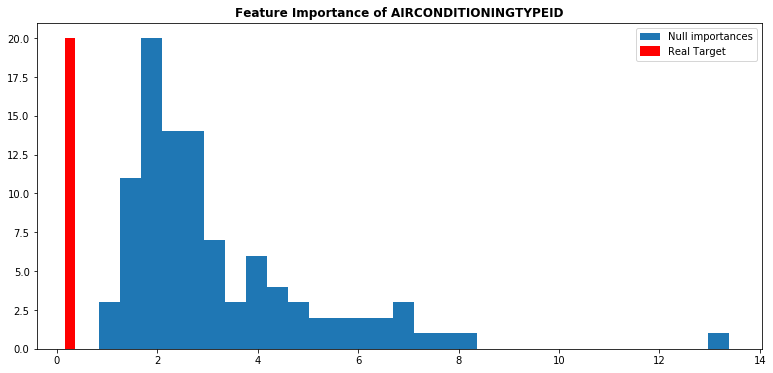

In [90]:
ctb_fs.display_distributions('airconditioningtypeid')
# non-informative feature

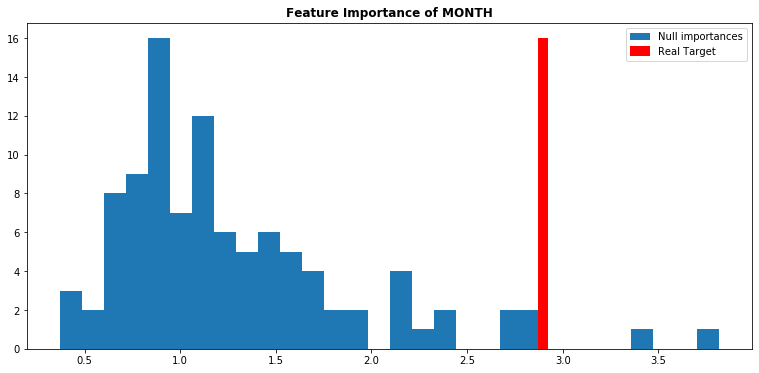

In [91]:
ctb_fs.display_distributions('month')
# informative feature

In [92]:
ctb_fs.get_scores()

In [93]:
ctb_fs.choose_threshold()

Results for threshold   0
0:	learn: 0.0691390	test: 0.0691410	best: 0.0691410 (0)	total: 611ms	remaining: 20m 21s
1:	learn: 0.0690636	test: 0.0690651	best: 0.0690651 (1)	total: 1.12s	remaining: 18m 37s
2:	learn: 0.0689948	test: 0.0689964	best: 0.0689964 (2)	total: 1.6s	remaining: 17m 44s
3:	learn: 0.0689343	test: 0.0689355	best: 0.0689355 (3)	total: 2.11s	remaining: 17m 31s
4:	learn: 0.0688799	test: 0.0688824	best: 0.0688824 (4)	total: 2.54s	remaining: 16m 54s
5:	learn: 0.0688316	test: 0.0688351	best: 0.0688351 (5)	total: 3.01s	remaining: 16m 41s
6:	learn: 0.0687890	test: 0.0687919	best: 0.0687919 (6)	total: 3.5s	remaining: 16m 35s
7:	learn: 0.0687519	test: 0.0687557	best: 0.0687557 (7)	total: 4.01s	remaining: 16m 39s
8:	learn: 0.0687179	test: 0.0687220	best: 0.0687220 (8)	total: 4.49s	remaining: 16m 33s
9:	learn: 0.0686884	test: 0.0686929	best: 0.0686929 (9)	total: 4.94s	remaining: 16m 23s
10:	learn: 0.0686618	test: 0.0686671	best: 0.0686671 (10)	total: 5.38s	remaining: 16m 13s
11:	le

92:	learn: 0.0680765	test: 0.0681553	best: 0.0681553 (92)	total: 48.9s	remaining: 16m 43s
93:	learn: 0.0680742	test: 0.0681543	best: 0.0681543 (93)	total: 49.4s	remaining: 16m 42s
94:	learn: 0.0680708	test: 0.0681523	best: 0.0681523 (94)	total: 49.9s	remaining: 16m 41s
95:	learn: 0.0680676	test: 0.0681502	best: 0.0681502 (95)	total: 50.5s	remaining: 16m 41s
96:	learn: 0.0680648	test: 0.0681482	best: 0.0681482 (96)	total: 51s	remaining: 16m 40s
97:	learn: 0.0680610	test: 0.0681456	best: 0.0681456 (97)	total: 51.6s	remaining: 16m 40s
98:	learn: 0.0680578	test: 0.0681430	best: 0.0681430 (98)	total: 52.1s	remaining: 16m 40s
99:	learn: 0.0680550	test: 0.0681410	best: 0.0681410 (99)	total: 52.6s	remaining: 16m 39s
100:	learn: 0.0680523	test: 0.0681389	best: 0.0681389 (100)	total: 53.1s	remaining: 16m 39s
101:	learn: 0.0680499	test: 0.0681377	best: 0.0681377 (101)	total: 53.7s	remaining: 16m 38s
102:	learn: 0.0680473	test: 0.0681359	best: 0.0681359 (102)	total: 54.2s	remaining: 16m 37s
103:	l

181:	learn: 0.0678218	test: 0.0680243	best: 0.0680243 (181)	total: 1m 37s	remaining: 16m 15s
182:	learn: 0.0678194	test: 0.0680234	best: 0.0680234 (182)	total: 1m 38s	remaining: 16m 15s
183:	learn: 0.0678168	test: 0.0680226	best: 0.0680226 (183)	total: 1m 38s	remaining: 16m 14s
184:	learn: 0.0678133	test: 0.0680217	best: 0.0680217 (184)	total: 1m 39s	remaining: 16m 13s
185:	learn: 0.0678108	test: 0.0680214	best: 0.0680214 (185)	total: 1m 39s	remaining: 16m 13s
186:	learn: 0.0678076	test: 0.0680204	best: 0.0680204 (186)	total: 1m 40s	remaining: 16m 12s
187:	learn: 0.0678046	test: 0.0680187	best: 0.0680187 (187)	total: 1m 40s	remaining: 16m 11s
188:	learn: 0.0678019	test: 0.0680176	best: 0.0680176 (188)	total: 1m 41s	remaining: 16m 10s
189:	learn: 0.0677991	test: 0.0680170	best: 0.0680170 (189)	total: 1m 41s	remaining: 16m 9s
190:	learn: 0.0677966	test: 0.0680162	best: 0.0680162 (190)	total: 1m 42s	remaining: 16m 9s
191:	learn: 0.0677928	test: 0.0680139	best: 0.0680139 (191)	total: 1m 42

270:	learn: 0.0675902	test: 0.0679436	best: 0.0679436 (270)	total: 2m 25s	remaining: 15m 30s
271:	learn: 0.0675879	test: 0.0679428	best: 0.0679428 (271)	total: 2m 26s	remaining: 15m 30s
272:	learn: 0.0675857	test: 0.0679423	best: 0.0679423 (272)	total: 2m 27s	remaining: 15m 30s
273:	learn: 0.0675835	test: 0.0679408	best: 0.0679408 (273)	total: 2m 27s	remaining: 15m 29s
274:	learn: 0.0675816	test: 0.0679404	best: 0.0679404 (274)	total: 2m 28s	remaining: 15m 29s
275:	learn: 0.0675795	test: 0.0679399	best: 0.0679399 (275)	total: 2m 28s	remaining: 15m 28s
276:	learn: 0.0675776	test: 0.0679389	best: 0.0679389 (276)	total: 2m 29s	remaining: 15m 27s
277:	learn: 0.0675744	test: 0.0679379	best: 0.0679379 (277)	total: 2m 29s	remaining: 15m 27s
278:	learn: 0.0675725	test: 0.0679378	best: 0.0679378 (278)	total: 2m 30s	remaining: 15m 26s
279:	learn: 0.0675698	test: 0.0679364	best: 0.0679364 (279)	total: 2m 30s	remaining: 15m 26s
280:	learn: 0.0675673	test: 0.0679354	best: 0.0679354 (280)	total: 2m 

359:	learn: 0.0674111	test: 0.0678955	best: 0.0678955 (359)	total: 3m 13s	remaining: 14m 41s
360:	learn: 0.0674090	test: 0.0678952	best: 0.0678952 (360)	total: 3m 14s	remaining: 14m 41s
361:	learn: 0.0674072	test: 0.0678952	best: 0.0678952 (361)	total: 3m 14s	remaining: 14m 40s
362:	learn: 0.0674056	test: 0.0678947	best: 0.0678947 (362)	total: 3m 15s	remaining: 14m 39s
363:	learn: 0.0674042	test: 0.0678943	best: 0.0678943 (363)	total: 3m 15s	remaining: 14m 39s
364:	learn: 0.0674026	test: 0.0678945	best: 0.0678943 (363)	total: 3m 16s	remaining: 14m 38s
365:	learn: 0.0674004	test: 0.0678944	best: 0.0678943 (363)	total: 3m 16s	remaining: 14m 37s
366:	learn: 0.0673991	test: 0.0678939	best: 0.0678939 (366)	total: 3m 17s	remaining: 14m 37s
367:	learn: 0.0673972	test: 0.0678938	best: 0.0678938 (367)	total: 3m 17s	remaining: 14m 36s
368:	learn: 0.0673953	test: 0.0678929	best: 0.0678929 (368)	total: 3m 18s	remaining: 14m 35s
369:	learn: 0.0673940	test: 0.0678925	best: 0.0678925 (369)	total: 3m 

448:	learn: 0.0672538	test: 0.0678617	best: 0.0678617 (448)	total: 3m 59s	remaining: 13m 46s
449:	learn: 0.0672515	test: 0.0678613	best: 0.0678613 (449)	total: 3m 59s	remaining: 13m 45s
450:	learn: 0.0672505	test: 0.0678618	best: 0.0678613 (449)	total: 4m	remaining: 13m 45s
451:	learn: 0.0672490	test: 0.0678620	best: 0.0678613 (449)	total: 4m	remaining: 13m 44s
452:	learn: 0.0672476	test: 0.0678614	best: 0.0678613 (449)	total: 4m 1s	remaining: 13m 44s
453:	learn: 0.0672462	test: 0.0678612	best: 0.0678612 (453)	total: 4m 1s	remaining: 13m 43s
454:	learn: 0.0672442	test: 0.0678612	best: 0.0678612 (453)	total: 4m 2s	remaining: 13m 43s
455:	learn: 0.0672426	test: 0.0678611	best: 0.0678611 (455)	total: 4m 3s	remaining: 13m 42s
456:	learn: 0.0672411	test: 0.0678608	best: 0.0678608 (456)	total: 4m 3s	remaining: 13m 42s
457:	learn: 0.0672393	test: 0.0678610	best: 0.0678608 (456)	total: 4m 4s	remaining: 13m 41s
458:	learn: 0.0672372	test: 0.0678612	best: 0.0678608 (456)	total: 4m 4s	remaining: 

537:	learn: 0.0671157	test: 0.0678525	best: 0.0678525 (532)	total: 4m 45s	remaining: 12m 55s
538:	learn: 0.0671140	test: 0.0678524	best: 0.0678524 (538)	total: 4m 45s	remaining: 12m 54s
539:	learn: 0.0671126	test: 0.0678523	best: 0.0678523 (539)	total: 4m 46s	remaining: 12m 54s
540:	learn: 0.0671106	test: 0.0678522	best: 0.0678522 (540)	total: 4m 46s	remaining: 12m 53s
541:	learn: 0.0671090	test: 0.0678521	best: 0.0678521 (541)	total: 4m 47s	remaining: 12m 53s
542:	learn: 0.0671074	test: 0.0678519	best: 0.0678519 (542)	total: 4m 47s	remaining: 12m 52s
543:	learn: 0.0671058	test: 0.0678516	best: 0.0678516 (543)	total: 4m 48s	remaining: 12m 52s
544:	learn: 0.0671046	test: 0.0678513	best: 0.0678513 (544)	total: 4m 48s	remaining: 12m 51s
545:	learn: 0.0671036	test: 0.0678510	best: 0.0678510 (545)	total: 4m 49s	remaining: 12m 50s
546:	learn: 0.0671019	test: 0.0678511	best: 0.0678510 (545)	total: 4m 50s	remaining: 12m 50s
547:	learn: 0.0671007	test: 0.0678511	best: 0.0678510 (545)	total: 4m 

626:	learn: 0.0669901	test: 0.0678373	best: 0.0678373 (626)	total: 5m 31s	remaining: 12m 5s
627:	learn: 0.0669883	test: 0.0678369	best: 0.0678369 (627)	total: 5m 31s	remaining: 12m 4s
628:	learn: 0.0669871	test: 0.0678369	best: 0.0678369 (627)	total: 5m 32s	remaining: 12m 4s
629:	learn: 0.0669860	test: 0.0678369	best: 0.0678369 (627)	total: 5m 32s	remaining: 12m 3s
630:	learn: 0.0669848	test: 0.0678366	best: 0.0678366 (630)	total: 5m 33s	remaining: 12m 3s
631:	learn: 0.0669836	test: 0.0678368	best: 0.0678366 (630)	total: 5m 33s	remaining: 12m 2s
632:	learn: 0.0669825	test: 0.0678368	best: 0.0678366 (630)	total: 5m 34s	remaining: 12m 2s
633:	learn: 0.0669807	test: 0.0678366	best: 0.0678366 (630)	total: 5m 34s	remaining: 12m 1s
634:	learn: 0.0669798	test: 0.0678371	best: 0.0678366 (630)	total: 5m 35s	remaining: 12m 1s
635:	learn: 0.0669785	test: 0.0678370	best: 0.0678366 (630)	total: 5m 35s	remaining: 12m
636:	learn: 0.0669770	test: 0.0678372	best: 0.0678366 (630)	total: 5m 36s	remaining

715:	learn: 0.0668687	test: 0.0678278	best: 0.0678278 (715)	total: 6m 17s	remaining: 11m 16s
716:	learn: 0.0668676	test: 0.0678278	best: 0.0678278 (716)	total: 6m 17s	remaining: 11m 16s
717:	learn: 0.0668657	test: 0.0678272	best: 0.0678272 (717)	total: 6m 18s	remaining: 11m 15s
718:	learn: 0.0668645	test: 0.0678273	best: 0.0678272 (717)	total: 6m 18s	remaining: 11m 15s
719:	learn: 0.0668627	test: 0.0678265	best: 0.0678265 (719)	total: 6m 19s	remaining: 11m 14s
720:	learn: 0.0668617	test: 0.0678263	best: 0.0678263 (720)	total: 6m 19s	remaining: 11m 14s
721:	learn: 0.0668606	test: 0.0678261	best: 0.0678261 (721)	total: 6m 20s	remaining: 11m 13s
722:	learn: 0.0668595	test: 0.0678260	best: 0.0678260 (722)	total: 6m 21s	remaining: 11m 12s
723:	learn: 0.0668584	test: 0.0678257	best: 0.0678257 (723)	total: 6m 21s	remaining: 11m 12s
724:	learn: 0.0668569	test: 0.0678255	best: 0.0678255 (724)	total: 6m 22s	remaining: 11m 11s
725:	learn: 0.0668561	test: 0.0678256	best: 0.0678255 (724)	total: 6m 

804:	learn: 0.0667532	test: 0.0678198	best: 0.0678192 (788)	total: 7m 4s	remaining: 10m 29s
805:	learn: 0.0667519	test: 0.0678190	best: 0.0678190 (805)	total: 7m 4s	remaining: 10m 29s
806:	learn: 0.0667507	test: 0.0678189	best: 0.0678189 (806)	total: 7m 5s	remaining: 10m 28s
807:	learn: 0.0667496	test: 0.0678188	best: 0.0678188 (807)	total: 7m 5s	remaining: 10m 28s
808:	learn: 0.0667480	test: 0.0678185	best: 0.0678185 (808)	total: 7m 6s	remaining: 10m 27s
809:	learn: 0.0667466	test: 0.0678186	best: 0.0678185 (808)	total: 7m 6s	remaining: 10m 27s
810:	learn: 0.0667451	test: 0.0678182	best: 0.0678182 (810)	total: 7m 7s	remaining: 10m 26s
811:	learn: 0.0667437	test: 0.0678185	best: 0.0678182 (810)	total: 7m 7s	remaining: 10m 26s
812:	learn: 0.0667428	test: 0.0678185	best: 0.0678182 (810)	total: 7m 8s	remaining: 10m 25s
813:	learn: 0.0667414	test: 0.0678186	best: 0.0678182 (810)	total: 7m 9s	remaining: 10m 25s
814:	learn: 0.0667401	test: 0.0678190	best: 0.0678182 (810)	total: 7m 9s	remaini

5:	learn: 0.0688345	test: 0.0688380	best: 0.0688380 (5)	total: 2.82s	remaining: 15m 37s
6:	learn: 0.0687918	test: 0.0687950	best: 0.0687950 (6)	total: 3.27s	remaining: 15m 32s
7:	learn: 0.0687532	test: 0.0687574	best: 0.0687574 (7)	total: 3.71s	remaining: 15m 24s
8:	learn: 0.0687171	test: 0.0687218	best: 0.0687218 (8)	total: 4.16s	remaining: 15m 19s
9:	learn: 0.0686852	test: 0.0686889	best: 0.0686889 (9)	total: 4.59s	remaining: 15m 14s
10:	learn: 0.0686573	test: 0.0686615	best: 0.0686615 (10)	total: 5.05s	remaining: 15m 13s
11:	learn: 0.0686306	test: 0.0686351	best: 0.0686351 (11)	total: 5.5s	remaining: 15m 11s
12:	learn: 0.0686088	test: 0.0686141	best: 0.0686141 (12)	total: 5.93s	remaining: 15m 6s
13:	learn: 0.0685864	test: 0.0685923	best: 0.0685923 (13)	total: 6.38s	remaining: 15m 5s
14:	learn: 0.0685652	test: 0.0685712	best: 0.0685712 (14)	total: 6.82s	remaining: 15m 3s
15:	learn: 0.0685454	test: 0.0685515	best: 0.0685515 (15)	total: 7.29s	remaining: 15m 4s
16:	learn: 0.0685284	test

97:	learn: 0.0680589	test: 0.0681411	best: 0.0681411 (97)	total: 46.3s	remaining: 14m 58s
98:	learn: 0.0680565	test: 0.0681398	best: 0.0681398 (98)	total: 46.8s	remaining: 14m 58s
99:	learn: 0.0680538	test: 0.0681382	best: 0.0681382 (99)	total: 47.4s	remaining: 14m 59s
100:	learn: 0.0680517	test: 0.0681371	best: 0.0681371 (100)	total: 47.9s	remaining: 15m
101:	learn: 0.0680497	test: 0.0681363	best: 0.0681363 (101)	total: 48.4s	remaining: 14m 59s
102:	learn: 0.0680463	test: 0.0681343	best: 0.0681343 (102)	total: 48.8s	remaining: 14m 59s
103:	learn: 0.0680440	test: 0.0681334	best: 0.0681334 (103)	total: 49.3s	remaining: 14m 58s
104:	learn: 0.0680413	test: 0.0681321	best: 0.0681321 (104)	total: 49.8s	remaining: 14m 58s
105:	learn: 0.0680389	test: 0.0681315	best: 0.0681315 (105)	total: 50.2s	remaining: 14m 56s
106:	learn: 0.0680365	test: 0.0681300	best: 0.0681300 (106)	total: 50.7s	remaining: 14m 56s
107:	learn: 0.0680341	test: 0.0681288	best: 0.0681288 (107)	total: 51.1s	remaining: 14m 56

186:	learn: 0.0678078	test: 0.0680280	best: 0.0680280 (186)	total: 1m 28s	remaining: 14m 16s
187:	learn: 0.0678043	test: 0.0680268	best: 0.0680268 (187)	total: 1m 28s	remaining: 14m 16s
188:	learn: 0.0678013	test: 0.0680254	best: 0.0680254 (188)	total: 1m 29s	remaining: 14m 15s
189:	learn: 0.0677977	test: 0.0680236	best: 0.0680236 (189)	total: 1m 29s	remaining: 14m 14s
190:	learn: 0.0677948	test: 0.0680223	best: 0.0680223 (190)	total: 1m 30s	remaining: 14m 14s
191:	learn: 0.0677917	test: 0.0680205	best: 0.0680205 (191)	total: 1m 30s	remaining: 14m 14s
192:	learn: 0.0677887	test: 0.0680193	best: 0.0680193 (192)	total: 1m 31s	remaining: 14m 13s
193:	learn: 0.0677862	test: 0.0680183	best: 0.0680183 (193)	total: 1m 31s	remaining: 14m 13s
194:	learn: 0.0677833	test: 0.0680173	best: 0.0680173 (194)	total: 1m 32s	remaining: 14m 12s
195:	learn: 0.0677799	test: 0.0680156	best: 0.0680156 (195)	total: 1m 32s	remaining: 14m 11s
196:	learn: 0.0677772	test: 0.0680144	best: 0.0680144 (196)	total: 1m 

275:	learn: 0.0675816	test: 0.0679503	best: 0.0679503 (275)	total: 2m 8s	remaining: 13m 25s
276:	learn: 0.0675791	test: 0.0679503	best: 0.0679503 (276)	total: 2m 9s	remaining: 13m 25s
277:	learn: 0.0675770	test: 0.0679498	best: 0.0679498 (277)	total: 2m 9s	remaining: 13m 24s
278:	learn: 0.0675748	test: 0.0679495	best: 0.0679495 (278)	total: 2m 10s	remaining: 13m 24s
279:	learn: 0.0675730	test: 0.0679491	best: 0.0679491 (279)	total: 2m 10s	remaining: 13m 23s
280:	learn: 0.0675708	test: 0.0679487	best: 0.0679487 (280)	total: 2m 11s	remaining: 13m 23s
281:	learn: 0.0675691	test: 0.0679484	best: 0.0679484 (281)	total: 2m 11s	remaining: 13m 22s
282:	learn: 0.0675660	test: 0.0679480	best: 0.0679480 (282)	total: 2m 12s	remaining: 13m 21s
283:	learn: 0.0675644	test: 0.0679475	best: 0.0679475 (283)	total: 2m 12s	remaining: 13m 21s
284:	learn: 0.0675622	test: 0.0679466	best: 0.0679466 (284)	total: 2m 13s	remaining: 13m 20s
285:	learn: 0.0675604	test: 0.0679456	best: 0.0679456 (285)	total: 2m 13s

364:	learn: 0.0674016	test: 0.0679119	best: 0.0679112 (363)	total: 2m 49s	remaining: 12m 40s
365:	learn: 0.0673998	test: 0.0679120	best: 0.0679112 (363)	total: 2m 50s	remaining: 12m 39s
366:	learn: 0.0673978	test: 0.0679111	best: 0.0679111 (366)	total: 2m 50s	remaining: 12m 39s
367:	learn: 0.0673958	test: 0.0679105	best: 0.0679105 (367)	total: 2m 51s	remaining: 12m 38s
368:	learn: 0.0673944	test: 0.0679103	best: 0.0679103 (368)	total: 2m 51s	remaining: 12m 38s
369:	learn: 0.0673924	test: 0.0679104	best: 0.0679103 (368)	total: 2m 52s	remaining: 12m 37s
370:	learn: 0.0673909	test: 0.0679103	best: 0.0679103 (368)	total: 2m 52s	remaining: 12m 37s
371:	learn: 0.0673896	test: 0.0679101	best: 0.0679101 (371)	total: 2m 52s	remaining: 12m 36s
372:	learn: 0.0673881	test: 0.0679097	best: 0.0679097 (372)	total: 2m 53s	remaining: 12m 36s
373:	learn: 0.0673859	test: 0.0679093	best: 0.0679093 (373)	total: 2m 53s	remaining: 12m 35s
374:	learn: 0.0673844	test: 0.0679091	best: 0.0679091 (374)	total: 2m 

453:	learn: 0.0672490	test: 0.0678851	best: 0.0678848 (448)	total: 3m 30s	remaining: 11m 56s
454:	learn: 0.0672476	test: 0.0678853	best: 0.0678848 (448)	total: 3m 30s	remaining: 11m 55s
455:	learn: 0.0672456	test: 0.0678849	best: 0.0678848 (448)	total: 3m 31s	remaining: 11m 55s
456:	learn: 0.0672446	test: 0.0678847	best: 0.0678847 (456)	total: 3m 31s	remaining: 11m 54s
457:	learn: 0.0672426	test: 0.0678851	best: 0.0678847 (456)	total: 3m 32s	remaining: 11m 54s
458:	learn: 0.0672410	test: 0.0678851	best: 0.0678847 (456)	total: 3m 32s	remaining: 11m 53s
459:	learn: 0.0672384	test: 0.0678842	best: 0.0678842 (459)	total: 3m 33s	remaining: 11m 53s
460:	learn: 0.0672372	test: 0.0678839	best: 0.0678839 (460)	total: 3m 33s	remaining: 11m 52s
461:	learn: 0.0672358	test: 0.0678843	best: 0.0678839 (460)	total: 3m 33s	remaining: 11m 52s
462:	learn: 0.0672338	test: 0.0678843	best: 0.0678839 (460)	total: 3m 34s	remaining: 11m 51s
463:	learn: 0.0672324	test: 0.0678841	best: 0.0678839 (460)	total: 3m 

542:	learn: 0.0671191	test: 0.0678675	best: 0.0678675 (542)	total: 4m 12s	remaining: 11m 17s
543:	learn: 0.0671176	test: 0.0678669	best: 0.0678669 (543)	total: 4m 12s	remaining: 11m 16s
544:	learn: 0.0671158	test: 0.0678665	best: 0.0678665 (544)	total: 4m 13s	remaining: 11m 16s
545:	learn: 0.0671137	test: 0.0678669	best: 0.0678665 (544)	total: 4m 14s	remaining: 11m 16s
546:	learn: 0.0671124	test: 0.0678667	best: 0.0678665 (544)	total: 4m 14s	remaining: 11m 16s
547:	learn: 0.0671115	test: 0.0678666	best: 0.0678665 (544)	total: 4m 15s	remaining: 11m 15s
548:	learn: 0.0671101	test: 0.0678667	best: 0.0678665 (544)	total: 4m 15s	remaining: 11m 15s
549:	learn: 0.0671090	test: 0.0678664	best: 0.0678664 (549)	total: 4m 16s	remaining: 11m 14s
550:	learn: 0.0671074	test: 0.0678658	best: 0.0678658 (550)	total: 4m 16s	remaining: 11m 14s
551:	learn: 0.0671055	test: 0.0678654	best: 0.0678654 (551)	total: 4m 16s	remaining: 11m 14s
552:	learn: 0.0671043	test: 0.0678655	best: 0.0678654 (551)	total: 4m 

631:	learn: 0.0669904	test: 0.0678556	best: 0.0678556 (631)	total: 4m 54s	remaining: 10m 37s
632:	learn: 0.0669894	test: 0.0678559	best: 0.0678556 (631)	total: 4m 55s	remaining: 10m 37s
633:	learn: 0.0669880	test: 0.0678553	best: 0.0678553 (633)	total: 4m 55s	remaining: 10m 36s
634:	learn: 0.0669869	test: 0.0678555	best: 0.0678553 (633)	total: 4m 55s	remaining: 10m 36s
635:	learn: 0.0669857	test: 0.0678552	best: 0.0678552 (635)	total: 4m 56s	remaining: 10m 35s
636:	learn: 0.0669845	test: 0.0678552	best: 0.0678552 (635)	total: 4m 57s	remaining: 10m 35s
637:	learn: 0.0669826	test: 0.0678551	best: 0.0678551 (637)	total: 4m 57s	remaining: 10m 35s
638:	learn: 0.0669813	test: 0.0678546	best: 0.0678546 (638)	total: 4m 58s	remaining: 10m 35s
639:	learn: 0.0669789	test: 0.0678541	best: 0.0678541 (639)	total: 4m 58s	remaining: 10m 34s
640:	learn: 0.0669776	test: 0.0678542	best: 0.0678541 (639)	total: 4m 59s	remaining: 10m 34s
641:	learn: 0.0669760	test: 0.0678541	best: 0.0678541 (641)	total: 4m 

720:	learn: 0.0668728	test: 0.0678461	best: 0.0678461 (720)	total: 5m 37s	remaining: 9m 58s
721:	learn: 0.0668711	test: 0.0678454	best: 0.0678454 (721)	total: 5m 38s	remaining: 9m 58s
722:	learn: 0.0668700	test: 0.0678456	best: 0.0678454 (721)	total: 5m 38s	remaining: 9m 57s
723:	learn: 0.0668684	test: 0.0678458	best: 0.0678454 (721)	total: 5m 39s	remaining: 9m 57s
724:	learn: 0.0668674	test: 0.0678457	best: 0.0678454 (721)	total: 5m 39s	remaining: 9m 57s
725:	learn: 0.0668664	test: 0.0678459	best: 0.0678454 (721)	total: 5m 39s	remaining: 9m 56s
726:	learn: 0.0668651	test: 0.0678454	best: 0.0678454 (721)	total: 5m 40s	remaining: 9m 56s
727:	learn: 0.0668638	test: 0.0678456	best: 0.0678454 (721)	total: 5m 40s	remaining: 9m 55s
728:	learn: 0.0668624	test: 0.0678453	best: 0.0678453 (728)	total: 5m 41s	remaining: 9m 55s
729:	learn: 0.0668608	test: 0.0678448	best: 0.0678448 (729)	total: 5m 41s	remaining: 9m 54s
730:	learn: 0.0668600	test: 0.0678448	best: 0.0678448 (730)	total: 5m 42s	remain

810:	learn: 0.0667614	test: 0.0678362	best: 0.0678361 (809)	total: 6m 19s	remaining: 9m 16s
811:	learn: 0.0667606	test: 0.0678362	best: 0.0678361 (809)	total: 6m 19s	remaining: 9m 15s
812:	learn: 0.0667598	test: 0.0678361	best: 0.0678361 (812)	total: 6m 20s	remaining: 9m 15s
813:	learn: 0.0667585	test: 0.0678363	best: 0.0678361 (812)	total: 6m 20s	remaining: 9m 14s
814:	learn: 0.0667570	test: 0.0678362	best: 0.0678361 (812)	total: 6m 21s	remaining: 9m 14s
815:	learn: 0.0667555	test: 0.0678363	best: 0.0678361 (812)	total: 6m 21s	remaining: 9m 14s
816:	learn: 0.0667537	test: 0.0678363	best: 0.0678361 (812)	total: 6m 22s	remaining: 9m 13s
817:	learn: 0.0667519	test: 0.0678365	best: 0.0678361 (812)	total: 6m 22s	remaining: 9m 13s
818:	learn: 0.0667511	test: 0.0678368	best: 0.0678361 (812)	total: 6m 23s	remaining: 9m 12s
819:	learn: 0.0667501	test: 0.0678370	best: 0.0678361 (812)	total: 6m 23s	remaining: 9m 12s
820:	learn: 0.0667486	test: 0.0678368	best: 0.0678361 (812)	total: 6m 24s	remain

900:	learn: 0.0666556	test: 0.0678304	best: 0.0678302 (895)	total: 7m	remaining: 8m 33s
901:	learn: 0.0666547	test: 0.0678306	best: 0.0678302 (895)	total: 7m 1s	remaining: 8m 32s
902:	learn: 0.0666534	test: 0.0678306	best: 0.0678302 (895)	total: 7m 1s	remaining: 8m 32s
903:	learn: 0.0666517	test: 0.0678300	best: 0.0678300 (903)	total: 7m 2s	remaining: 8m 31s
904:	learn: 0.0666507	test: 0.0678300	best: 0.0678300 (904)	total: 7m 2s	remaining: 8m 31s
905:	learn: 0.0666495	test: 0.0678299	best: 0.0678299 (905)	total: 7m 3s	remaining: 8m 30s
906:	learn: 0.0666485	test: 0.0678298	best: 0.0678298 (906)	total: 7m 3s	remaining: 8m 30s
907:	learn: 0.0666470	test: 0.0678293	best: 0.0678293 (907)	total: 7m 4s	remaining: 8m 29s
908:	learn: 0.0666456	test: 0.0678291	best: 0.0678291 (908)	total: 7m 4s	remaining: 8m 29s
909:	learn: 0.0666446	test: 0.0678288	best: 0.0678288 (909)	total: 7m 4s	remaining: 8m 29s
910:	learn: 0.0666432	test: 0.0678284	best: 0.0678284 (910)	total: 7m 5s	remaining: 8m 28s
91

990:	learn: 0.0665566	test: 0.0678206	best: 0.0678203 (989)	total: 7m 42s	remaining: 7m 50s
991:	learn: 0.0665556	test: 0.0678205	best: 0.0678203 (989)	total: 7m 42s	remaining: 7m 50s
992:	learn: 0.0665544	test: 0.0678206	best: 0.0678203 (989)	total: 7m 43s	remaining: 7m 49s
993:	learn: 0.0665533	test: 0.0678204	best: 0.0678203 (989)	total: 7m 43s	remaining: 7m 49s
994:	learn: 0.0665524	test: 0.0678203	best: 0.0678203 (989)	total: 7m 43s	remaining: 7m 48s
995:	learn: 0.0665512	test: 0.0678200	best: 0.0678200 (995)	total: 7m 44s	remaining: 7m 48s
996:	learn: 0.0665496	test: 0.0678201	best: 0.0678200 (995)	total: 7m 44s	remaining: 7m 47s
997:	learn: 0.0665488	test: 0.0678197	best: 0.0678197 (997)	total: 7m 45s	remaining: 7m 47s
998:	learn: 0.0665480	test: 0.0678198	best: 0.0678197 (997)	total: 7m 45s	remaining: 7m 46s
999:	learn: 0.0665470	test: 0.0678198	best: 0.0678197 (997)	total: 7m 46s	remaining: 7m 46s
1000:	learn: 0.0665459	test: 0.0678204	best: 0.0678197 (997)	total: 7m 46s	remai

1078:	learn: 0.0664632	test: 0.0678152	best: 0.0678150 (1039)	total: 8m 22s	remaining: 7m 9s
1079:	learn: 0.0664622	test: 0.0678157	best: 0.0678150 (1039)	total: 8m 23s	remaining: 7m 8s
1080:	learn: 0.0664615	test: 0.0678155	best: 0.0678150 (1039)	total: 8m 23s	remaining: 7m 8s
1081:	learn: 0.0664601	test: 0.0678152	best: 0.0678150 (1039)	total: 8m 24s	remaining: 7m 7s
1082:	learn: 0.0664591	test: 0.0678148	best: 0.0678148 (1082)	total: 8m 24s	remaining: 7m 7s
1083:	learn: 0.0664578	test: 0.0678150	best: 0.0678148 (1082)	total: 8m 25s	remaining: 7m 6s
1084:	learn: 0.0664568	test: 0.0678150	best: 0.0678148 (1082)	total: 8m 25s	remaining: 7m 6s
1085:	learn: 0.0664553	test: 0.0678152	best: 0.0678148 (1082)	total: 8m 26s	remaining: 7m 5s
1086:	learn: 0.0664545	test: 0.0678152	best: 0.0678148 (1082)	total: 8m 26s	remaining: 7m 5s
1087:	learn: 0.0664531	test: 0.0678151	best: 0.0678148 (1082)	total: 8m 27s	remaining: 7m 4s
1088:	learn: 0.0664523	test: 0.0678155	best: 0.0678148 (1082)	total: 8

1166:	learn: 0.0663712	test: 0.0678143	best: 0.0678138 (1117)	total: 9m 3s	remaining: 6m 28s
Stopped by overfitting detector  (50 iterations wait)
1167:	learn: 0.0663702	test: 0.0678144	best: 0.0678138 (1117)	total: 9m 4s	remaining: 6m 27s
score: 0.06781375759562262
Results for threshold  20
0:	learn: 0.0691326	test: 0.0691341	best: 0.0691341 (0)	total: 517ms	remaining: 17m 13s
1:	learn: 0.0690622	test: 0.0690642	best: 0.0690642 (1)	total: 920ms	remaining: 15m 19s
2:	learn: 0.0689958	test: 0.0689997	best: 0.0689997 (2)	total: 1.32s	remaining: 14m 42s
3:	learn: 0.0689356	test: 0.0689375	best: 0.0689375 (3)	total: 1.74s	remaining: 14m 26s
4:	learn: 0.0688815	test: 0.0688832	best: 0.0688832 (4)	total: 2.13s	remaining: 14m 10s
5:	learn: 0.0688340	test: 0.0688362	best: 0.0688362 (5)	total: 2.54s	remaining: 14m 4s
6:	learn: 0.0687894	test: 0.0687915	best: 0.0687915 (6)	total: 2.92s	remaining: 13m 52s
7:	learn: 0.0687484	test: 0.0687507	best: 0.0687507 (7)	total: 3.33s	remaining: 13m 48s
8:	l

89:	learn: 0.0680929	test: 0.0681701	best: 0.0681701 (89)	total: 37.5s	remaining: 13m 15s
90:	learn: 0.0680901	test: 0.0681680	best: 0.0681680 (90)	total: 37.9s	remaining: 13m 15s
91:	learn: 0.0680869	test: 0.0681662	best: 0.0681662 (91)	total: 38.3s	remaining: 13m 14s
92:	learn: 0.0680832	test: 0.0681636	best: 0.0681636 (92)	total: 38.7s	remaining: 13m 14s
93:	learn: 0.0680801	test: 0.0681615	best: 0.0681615 (93)	total: 39.2s	remaining: 13m 15s
94:	learn: 0.0680772	test: 0.0681598	best: 0.0681598 (94)	total: 39.7s	remaining: 13m 15s
95:	learn: 0.0680747	test: 0.0681584	best: 0.0681584 (95)	total: 40.1s	remaining: 13m 14s
96:	learn: 0.0680714	test: 0.0681567	best: 0.0681567 (96)	total: 40.5s	remaining: 13m 14s
97:	learn: 0.0680678	test: 0.0681546	best: 0.0681546 (97)	total: 40.9s	remaining: 13m 13s
98:	learn: 0.0680643	test: 0.0681521	best: 0.0681521 (98)	total: 41.3s	remaining: 13m 13s
99:	learn: 0.0680612	test: 0.0681509	best: 0.0681509 (99)	total: 41.7s	remaining: 13m 13s
100:	learn

179:	learn: 0.0678391	test: 0.0680397	best: 0.0680397 (179)	total: 1m 15s	remaining: 12m 44s
180:	learn: 0.0678364	test: 0.0680381	best: 0.0680381 (180)	total: 1m 16s	remaining: 12m 44s
181:	learn: 0.0678333	test: 0.0680369	best: 0.0680369 (181)	total: 1m 16s	remaining: 12m 43s
182:	learn: 0.0678305	test: 0.0680362	best: 0.0680362 (182)	total: 1m 16s	remaining: 12m 43s
183:	learn: 0.0678271	test: 0.0680344	best: 0.0680344 (183)	total: 1m 17s	remaining: 12m 42s
184:	learn: 0.0678239	test: 0.0680323	best: 0.0680323 (184)	total: 1m 17s	remaining: 12m 42s
185:	learn: 0.0678210	test: 0.0680309	best: 0.0680309 (185)	total: 1m 18s	remaining: 12m 42s
186:	learn: 0.0678188	test: 0.0680299	best: 0.0680299 (186)	total: 1m 18s	remaining: 12m 41s
187:	learn: 0.0678166	test: 0.0680288	best: 0.0680288 (187)	total: 1m 18s	remaining: 12m 41s
188:	learn: 0.0678142	test: 0.0680278	best: 0.0680278 (188)	total: 1m 19s	remaining: 12m 40s
189:	learn: 0.0678112	test: 0.0680272	best: 0.0680272 (189)	total: 1m 

268:	learn: 0.0676052	test: 0.0679593	best: 0.0679593 (268)	total: 1m 52s	remaining: 12m 4s
269:	learn: 0.0676026	test: 0.0679587	best: 0.0679587 (269)	total: 1m 53s	remaining: 12m 4s
270:	learn: 0.0676010	test: 0.0679584	best: 0.0679584 (270)	total: 1m 53s	remaining: 12m 4s
271:	learn: 0.0675989	test: 0.0679576	best: 0.0679576 (271)	total: 1m 53s	remaining: 12m 3s
272:	learn: 0.0675967	test: 0.0679574	best: 0.0679574 (272)	total: 1m 54s	remaining: 12m 3s
273:	learn: 0.0675941	test: 0.0679568	best: 0.0679568 (273)	total: 1m 54s	remaining: 12m 2s
274:	learn: 0.0675918	test: 0.0679566	best: 0.0679566 (274)	total: 1m 55s	remaining: 12m 2s
275:	learn: 0.0675897	test: 0.0679569	best: 0.0679566 (274)	total: 1m 55s	remaining: 12m 1s
276:	learn: 0.0675870	test: 0.0679566	best: 0.0679566 (274)	total: 1m 55s	remaining: 12m 1s
277:	learn: 0.0675847	test: 0.0679561	best: 0.0679561 (277)	total: 1m 56s	remaining: 12m 1s
278:	learn: 0.0675816	test: 0.0679555	best: 0.0679555 (278)	total: 1m 56s	remain

357:	learn: 0.0674239	test: 0.0679170	best: 0.0679170 (357)	total: 2m 29s	remaining: 11m 26s
358:	learn: 0.0674212	test: 0.0679162	best: 0.0679162 (358)	total: 2m 30s	remaining: 11m 26s
359:	learn: 0.0674195	test: 0.0679159	best: 0.0679159 (359)	total: 2m 30s	remaining: 11m 25s
360:	learn: 0.0674179	test: 0.0679156	best: 0.0679156 (360)	total: 2m 30s	remaining: 11m 25s
361:	learn: 0.0674141	test: 0.0679142	best: 0.0679142 (361)	total: 2m 31s	remaining: 11m 24s
362:	learn: 0.0674125	test: 0.0679138	best: 0.0679138 (362)	total: 2m 31s	remaining: 11m 24s
363:	learn: 0.0674105	test: 0.0679137	best: 0.0679137 (363)	total: 2m 32s	remaining: 11m 23s
364:	learn: 0.0674087	test: 0.0679135	best: 0.0679135 (364)	total: 2m 32s	remaining: 11m 23s
365:	learn: 0.0674072	test: 0.0679130	best: 0.0679130 (365)	total: 2m 32s	remaining: 11m 22s
366:	learn: 0.0674059	test: 0.0679125	best: 0.0679125 (366)	total: 2m 33s	remaining: 11m 22s
367:	learn: 0.0674035	test: 0.0679117	best: 0.0679117 (367)	total: 2m 

446:	learn: 0.0672634	test: 0.0678963	best: 0.0678961 (420)	total: 3m 6s	remaining: 10m 48s
447:	learn: 0.0672617	test: 0.0678959	best: 0.0678959 (447)	total: 3m 7s	remaining: 10m 48s
448:	learn: 0.0672598	test: 0.0678956	best: 0.0678956 (448)	total: 3m 7s	remaining: 10m 48s
449:	learn: 0.0672580	test: 0.0678959	best: 0.0678956 (448)	total: 3m 8s	remaining: 10m 47s
450:	learn: 0.0672553	test: 0.0678955	best: 0.0678955 (450)	total: 3m 8s	remaining: 10m 47s
451:	learn: 0.0672537	test: 0.0678949	best: 0.0678949 (451)	total: 3m 8s	remaining: 10m 47s
452:	learn: 0.0672515	test: 0.0678940	best: 0.0678940 (452)	total: 3m 9s	remaining: 10m 46s
453:	learn: 0.0672501	test: 0.0678933	best: 0.0678933 (453)	total: 3m 9s	remaining: 10m 46s
454:	learn: 0.0672487	test: 0.0678934	best: 0.0678933 (453)	total: 3m 10s	remaining: 10m 46s
455:	learn: 0.0672471	test: 0.0678932	best: 0.0678932 (455)	total: 3m 10s	remaining: 10m 45s
456:	learn: 0.0672458	test: 0.0678934	best: 0.0678932 (455)	total: 3m 11s	rema

535:	learn: 0.0671260	test: 0.0678767	best: 0.0678763 (531)	total: 3m 44s	remaining: 10m 12s
536:	learn: 0.0671242	test: 0.0678759	best: 0.0678759 (536)	total: 3m 44s	remaining: 10m 11s
537:	learn: 0.0671224	test: 0.0678754	best: 0.0678754 (537)	total: 3m 44s	remaining: 10m 11s
538:	learn: 0.0671204	test: 0.0678750	best: 0.0678750 (538)	total: 3m 45s	remaining: 10m 10s
539:	learn: 0.0671192	test: 0.0678748	best: 0.0678748 (539)	total: 3m 45s	remaining: 10m 10s
540:	learn: 0.0671180	test: 0.0678746	best: 0.0678746 (540)	total: 3m 46s	remaining: 10m 10s
541:	learn: 0.0671163	test: 0.0678742	best: 0.0678742 (541)	total: 3m 46s	remaining: 10m 9s
542:	learn: 0.0671148	test: 0.0678742	best: 0.0678742 (542)	total: 3m 47s	remaining: 10m 9s
543:	learn: 0.0671141	test: 0.0678740	best: 0.0678740 (543)	total: 3m 47s	remaining: 10m 8s
544:	learn: 0.0671128	test: 0.0678725	best: 0.0678725 (544)	total: 3m 47s	remaining: 10m 8s
545:	learn: 0.0671117	test: 0.0678726	best: 0.0678725 (544)	total: 3m 48s	

625:	learn: 0.0669993	test: 0.0678550	best: 0.0678550 (625)	total: 4m 21s	remaining: 9m 34s
626:	learn: 0.0669979	test: 0.0678546	best: 0.0678546 (626)	total: 4m 22s	remaining: 9m 34s
627:	learn: 0.0669964	test: 0.0678547	best: 0.0678546 (626)	total: 4m 22s	remaining: 9m 33s
628:	learn: 0.0669949	test: 0.0678542	best: 0.0678542 (628)	total: 4m 23s	remaining: 9m 33s
629:	learn: 0.0669934	test: 0.0678536	best: 0.0678536 (629)	total: 4m 23s	remaining: 9m 32s
630:	learn: 0.0669923	test: 0.0678535	best: 0.0678535 (630)	total: 4m 23s	remaining: 9m 32s
631:	learn: 0.0669912	test: 0.0678537	best: 0.0678535 (630)	total: 4m 24s	remaining: 9m 31s
632:	learn: 0.0669900	test: 0.0678534	best: 0.0678534 (632)	total: 4m 24s	remaining: 9m 31s
633:	learn: 0.0669888	test: 0.0678534	best: 0.0678534 (632)	total: 4m 25s	remaining: 9m 31s
634:	learn: 0.0669874	test: 0.0678532	best: 0.0678532 (634)	total: 4m 25s	remaining: 9m 30s
635:	learn: 0.0669859	test: 0.0678541	best: 0.0678532 (634)	total: 4m 25s	remain

715:	learn: 0.0668789	test: 0.0678414	best: 0.0678412 (707)	total: 4m 59s	remaining: 8m 57s
716:	learn: 0.0668769	test: 0.0678412	best: 0.0678412 (707)	total: 4m 59s	remaining: 8m 56s
717:	learn: 0.0668756	test: 0.0678412	best: 0.0678412 (717)	total: 5m	remaining: 8m 56s
718:	learn: 0.0668746	test: 0.0678412	best: 0.0678412 (718)	total: 5m	remaining: 8m 55s
719:	learn: 0.0668735	test: 0.0678412	best: 0.0678412 (718)	total: 5m 1s	remaining: 8m 55s
720:	learn: 0.0668725	test: 0.0678409	best: 0.0678409 (720)	total: 5m 1s	remaining: 8m 54s
721:	learn: 0.0668718	test: 0.0678407	best: 0.0678407 (721)	total: 5m 1s	remaining: 8m 54s
722:	learn: 0.0668702	test: 0.0678406	best: 0.0678406 (722)	total: 5m 2s	remaining: 8m 54s
723:	learn: 0.0668689	test: 0.0678409	best: 0.0678406 (722)	total: 5m 2s	remaining: 8m 53s
724:	learn: 0.0668682	test: 0.0678410	best: 0.0678406 (722)	total: 5m 3s	remaining: 8m 53s
725:	learn: 0.0668670	test: 0.0678411	best: 0.0678406 (722)	total: 5m 3s	remaining: 8m 52s
726

805:	learn: 0.0667665	test: 0.0678329	best: 0.0678329 (805)	total: 5m 37s	remaining: 8m 19s
806:	learn: 0.0667649	test: 0.0678329	best: 0.0678329 (806)	total: 5m 37s	remaining: 8m 19s
807:	learn: 0.0667637	test: 0.0678327	best: 0.0678327 (807)	total: 5m 38s	remaining: 8m 19s
808:	learn: 0.0667624	test: 0.0678328	best: 0.0678327 (807)	total: 5m 38s	remaining: 8m 18s
809:	learn: 0.0667618	test: 0.0678330	best: 0.0678327 (807)	total: 5m 39s	remaining: 8m 18s
810:	learn: 0.0667605	test: 0.0678328	best: 0.0678327 (807)	total: 5m 39s	remaining: 8m 17s
811:	learn: 0.0667595	test: 0.0678329	best: 0.0678327 (807)	total: 5m 40s	remaining: 8m 17s
812:	learn: 0.0667586	test: 0.0678329	best: 0.0678327 (807)	total: 5m 40s	remaining: 8m 17s
813:	learn: 0.0667572	test: 0.0678326	best: 0.0678326 (813)	total: 5m 40s	remaining: 8m 16s
814:	learn: 0.0667561	test: 0.0678325	best: 0.0678325 (814)	total: 5m 41s	remaining: 8m 16s
815:	learn: 0.0667549	test: 0.0678326	best: 0.0678325 (814)	total: 5m 41s	remain

895:	learn: 0.0666578	test: 0.0678247	best: 0.0678247 (895)	total: 6m 18s	remaining: 7m 45s
896:	learn: 0.0666565	test: 0.0678248	best: 0.0678247 (895)	total: 6m 18s	remaining: 7m 45s
897:	learn: 0.0666554	test: 0.0678246	best: 0.0678246 (897)	total: 6m 18s	remaining: 7m 44s
898:	learn: 0.0666543	test: 0.0678246	best: 0.0678246 (897)	total: 6m 19s	remaining: 7m 44s
899:	learn: 0.0666536	test: 0.0678244	best: 0.0678244 (899)	total: 6m 19s	remaining: 7m 44s
900:	learn: 0.0666528	test: 0.0678245	best: 0.0678244 (899)	total: 6m 20s	remaining: 7m 43s
901:	learn: 0.0666521	test: 0.0678249	best: 0.0678244 (899)	total: 6m 20s	remaining: 7m 43s
902:	learn: 0.0666511	test: 0.0678243	best: 0.0678243 (902)	total: 6m 21s	remaining: 7m 43s
903:	learn: 0.0666503	test: 0.0678244	best: 0.0678243 (902)	total: 6m 21s	remaining: 7m 42s
904:	learn: 0.0666489	test: 0.0678244	best: 0.0678243 (902)	total: 6m 22s	remaining: 7m 42s
905:	learn: 0.0666470	test: 0.0678233	best: 0.0678233 (905)	total: 6m 22s	remain

985:	learn: 0.0665554	test: 0.0678204	best: 0.0678200 (971)	total: 6m 57s	remaining: 7m 9s
986:	learn: 0.0665545	test: 0.0678201	best: 0.0678200 (971)	total: 6m 57s	remaining: 7m 8s
987:	learn: 0.0665535	test: 0.0678200	best: 0.0678200 (987)	total: 6m 58s	remaining: 7m 8s
988:	learn: 0.0665523	test: 0.0678198	best: 0.0678198 (988)	total: 6m 58s	remaining: 7m 7s
989:	learn: 0.0665510	test: 0.0678200	best: 0.0678198 (988)	total: 6m 58s	remaining: 7m 7s
990:	learn: 0.0665500	test: 0.0678200	best: 0.0678198 (988)	total: 6m 59s	remaining: 7m 7s
991:	learn: 0.0665486	test: 0.0678201	best: 0.0678198 (988)	total: 6m 59s	remaining: 7m 6s
992:	learn: 0.0665481	test: 0.0678201	best: 0.0678198 (988)	total: 7m	remaining: 7m 6s
993:	learn: 0.0665475	test: 0.0678201	best: 0.0678198 (988)	total: 7m	remaining: 7m 5s
994:	learn: 0.0665459	test: 0.0678204	best: 0.0678198 (988)	total: 7m 1s	remaining: 7m 5s
995:	learn: 0.0665450	test: 0.0678204	best: 0.0678198 (988)	total: 7m 1s	remaining: 7m 4s
996:	lear

1074:	learn: 0.0664662	test: 0.0678152	best: 0.0678146 (1058)	total: 7m 35s	remaining: 6m 32s
1075:	learn: 0.0664652	test: 0.0678152	best: 0.0678146 (1058)	total: 7m 36s	remaining: 6m 31s
1076:	learn: 0.0664642	test: 0.0678157	best: 0.0678146 (1058)	total: 7m 36s	remaining: 6m 31s
1077:	learn: 0.0664632	test: 0.0678156	best: 0.0678146 (1058)	total: 7m 37s	remaining: 6m 30s
1078:	learn: 0.0664621	test: 0.0678154	best: 0.0678146 (1058)	total: 7m 37s	remaining: 6m 30s
1079:	learn: 0.0664611	test: 0.0678153	best: 0.0678146 (1058)	total: 7m 37s	remaining: 6m 30s
1080:	learn: 0.0664600	test: 0.0678149	best: 0.0678146 (1058)	total: 7m 38s	remaining: 6m 29s
1081:	learn: 0.0664591	test: 0.0678149	best: 0.0678146 (1058)	total: 7m 38s	remaining: 6m 29s
1082:	learn: 0.0664581	test: 0.0678151	best: 0.0678146 (1058)	total: 7m 39s	remaining: 6m 28s
1083:	learn: 0.0664570	test: 0.0678145	best: 0.0678145 (1083)	total: 7m 39s	remaining: 6m 28s
1084:	learn: 0.0664562	test: 0.0678146	best: 0.0678145 (1083

1162:	learn: 0.0663800	test: 0.0678155	best: 0.0678120 (1119)	total: 8m 13s	remaining: 5m 55s
1163:	learn: 0.0663793	test: 0.0678153	best: 0.0678120 (1119)	total: 8m 14s	remaining: 5m 55s
1164:	learn: 0.0663784	test: 0.0678153	best: 0.0678120 (1119)	total: 8m 14s	remaining: 5m 54s
1165:	learn: 0.0663769	test: 0.0678151	best: 0.0678120 (1119)	total: 8m 15s	remaining: 5m 54s
1166:	learn: 0.0663762	test: 0.0678153	best: 0.0678120 (1119)	total: 8m 15s	remaining: 5m 53s
1167:	learn: 0.0663753	test: 0.0678154	best: 0.0678120 (1119)	total: 8m 16s	remaining: 5m 53s
1168:	learn: 0.0663748	test: 0.0678152	best: 0.0678120 (1119)	total: 8m 16s	remaining: 5m 53s
Stopped by overfitting detector  (50 iterations wait)
1169:	learn: 0.0663744	test: 0.0678150	best: 0.0678120 (1119)	total: 8m 17s	remaining: 5m 52s
score: 0.06781195935039963
Results for threshold  30
0:	learn: 0.0691402	test: 0.0691412	best: 0.0691412 (0)	total: 553ms	remaining: 18m 26s
1:	learn: 0.0690593	test: 0.0690615	best: 0.0690615 (

82:	learn: 0.0681119	test: 0.0681797	best: 0.0681797 (82)	total: 36.2s	remaining: 13m 55s
83:	learn: 0.0681096	test: 0.0681782	best: 0.0681782 (83)	total: 36.7s	remaining: 13m 56s
84:	learn: 0.0681069	test: 0.0681765	best: 0.0681765 (84)	total: 37.1s	remaining: 13m 56s
85:	learn: 0.0681037	test: 0.0681736	best: 0.0681736 (85)	total: 37.6s	remaining: 13m 56s
86:	learn: 0.0681004	test: 0.0681717	best: 0.0681717 (86)	total: 38.1s	remaining: 13m 57s
87:	learn: 0.0680973	test: 0.0681693	best: 0.0681693 (87)	total: 38.5s	remaining: 13m 56s
88:	learn: 0.0680940	test: 0.0681666	best: 0.0681666 (88)	total: 39s	remaining: 13m 56s
89:	learn: 0.0680892	test: 0.0681636	best: 0.0681636 (89)	total: 39.4s	remaining: 13m 55s
90:	learn: 0.0680860	test: 0.0681612	best: 0.0681612 (90)	total: 39.8s	remaining: 13m 55s
91:	learn: 0.0680837	test: 0.0681592	best: 0.0681592 (91)	total: 40.3s	remaining: 13m 54s
92:	learn: 0.0680806	test: 0.0681574	best: 0.0681574 (92)	total: 40.7s	remaining: 13m 54s
93:	learn: 0

172:	learn: 0.0678624	test: 0.0680512	best: 0.0680512 (172)	total: 1m 14s	remaining: 13m 6s
173:	learn: 0.0678591	test: 0.0680503	best: 0.0680503 (173)	total: 1m 14s	remaining: 13m 6s
174:	learn: 0.0678562	test: 0.0680499	best: 0.0680499 (174)	total: 1m 15s	remaining: 13m 5s
175:	learn: 0.0678529	test: 0.0680485	best: 0.0680485 (175)	total: 1m 15s	remaining: 13m 4s
176:	learn: 0.0678500	test: 0.0680472	best: 0.0680472 (176)	total: 1m 16s	remaining: 13m 4s
177:	learn: 0.0678472	test: 0.0680468	best: 0.0680468 (177)	total: 1m 16s	remaining: 13m 3s
178:	learn: 0.0678446	test: 0.0680460	best: 0.0680460 (178)	total: 1m 16s	remaining: 13m 3s
179:	learn: 0.0678417	test: 0.0680444	best: 0.0680444 (179)	total: 1m 17s	remaining: 13m 2s
180:	learn: 0.0678379	test: 0.0680425	best: 0.0680425 (180)	total: 1m 17s	remaining: 13m 1s
181:	learn: 0.0678348	test: 0.0680414	best: 0.0680414 (181)	total: 1m 18s	remaining: 13m 1s
182:	learn: 0.0678314	test: 0.0680392	best: 0.0680392 (182)	total: 1m 18s	remain

261:	learn: 0.0676266	test: 0.0679691	best: 0.0679691 (261)	total: 1m 52s	remaining: 12m 28s
262:	learn: 0.0676242	test: 0.0679682	best: 0.0679682 (262)	total: 1m 53s	remaining: 12m 28s
263:	learn: 0.0676210	test: 0.0679674	best: 0.0679674 (263)	total: 1m 53s	remaining: 12m 28s
264:	learn: 0.0676188	test: 0.0679668	best: 0.0679668 (264)	total: 1m 54s	remaining: 12m 27s
265:	learn: 0.0676165	test: 0.0679660	best: 0.0679660 (265)	total: 1m 54s	remaining: 12m 26s
266:	learn: 0.0676142	test: 0.0679655	best: 0.0679655 (266)	total: 1m 54s	remaining: 12m 26s
267:	learn: 0.0676127	test: 0.0679652	best: 0.0679652 (267)	total: 1m 55s	remaining: 12m 26s
268:	learn: 0.0676109	test: 0.0679652	best: 0.0679652 (268)	total: 1m 55s	remaining: 12m 25s
269:	learn: 0.0676083	test: 0.0679639	best: 0.0679639 (269)	total: 1m 56s	remaining: 12m 25s
270:	learn: 0.0676066	test: 0.0679639	best: 0.0679639 (270)	total: 1m 56s	remaining: 12m 24s
271:	learn: 0.0676042	test: 0.0679628	best: 0.0679628 (271)	total: 1m 

350:	learn: 0.0674399	test: 0.0679283	best: 0.0679283 (350)	total: 2m 31s	remaining: 11m 53s
351:	learn: 0.0674383	test: 0.0679280	best: 0.0679280 (351)	total: 2m 32s	remaining: 11m 52s
352:	learn: 0.0674368	test: 0.0679270	best: 0.0679270 (352)	total: 2m 32s	remaining: 11m 52s
353:	learn: 0.0674354	test: 0.0679264	best: 0.0679264 (353)	total: 2m 33s	remaining: 11m 51s
354:	learn: 0.0674326	test: 0.0679253	best: 0.0679253 (354)	total: 2m 33s	remaining: 11m 51s
355:	learn: 0.0674303	test: 0.0679256	best: 0.0679253 (354)	total: 2m 33s	remaining: 11m 50s
356:	learn: 0.0674285	test: 0.0679254	best: 0.0679253 (354)	total: 2m 34s	remaining: 11m 50s
357:	learn: 0.0674265	test: 0.0679244	best: 0.0679244 (357)	total: 2m 34s	remaining: 11m 50s
358:	learn: 0.0674247	test: 0.0679244	best: 0.0679244 (358)	total: 2m 35s	remaining: 11m 49s
359:	learn: 0.0674230	test: 0.0679236	best: 0.0679236 (359)	total: 2m 35s	remaining: 11m 49s
360:	learn: 0.0674213	test: 0.0679232	best: 0.0679232 (360)	total: 2m 

439:	learn: 0.0672874	test: 0.0678990	best: 0.0678990 (439)	total: 3m 10s	remaining: 11m 15s
440:	learn: 0.0672860	test: 0.0678987	best: 0.0678987 (440)	total: 3m 11s	remaining: 11m 15s
441:	learn: 0.0672849	test: 0.0678992	best: 0.0678987 (440)	total: 3m 11s	remaining: 11m 15s
442:	learn: 0.0672827	test: 0.0678980	best: 0.0678980 (442)	total: 3m 12s	remaining: 11m 14s
443:	learn: 0.0672810	test: 0.0678974	best: 0.0678974 (443)	total: 3m 12s	remaining: 11m 14s
444:	learn: 0.0672793	test: 0.0678971	best: 0.0678971 (444)	total: 3m 12s	remaining: 11m 13s
445:	learn: 0.0672777	test: 0.0678971	best: 0.0678971 (445)	total: 3m 13s	remaining: 11m 13s
446:	learn: 0.0672764	test: 0.0678971	best: 0.0678971 (446)	total: 3m 13s	remaining: 11m 12s
447:	learn: 0.0672748	test: 0.0678970	best: 0.0678970 (447)	total: 3m 14s	remaining: 11m 12s
448:	learn: 0.0672732	test: 0.0678971	best: 0.0678970 (447)	total: 3m 14s	remaining: 11m 11s
449:	learn: 0.0672718	test: 0.0678970	best: 0.0678970 (449)	total: 3m 

528:	learn: 0.0671484	test: 0.0678771	best: 0.0678761 (527)	total: 3m 49s	remaining: 10m 37s
529:	learn: 0.0671462	test: 0.0678768	best: 0.0678761 (527)	total: 3m 49s	remaining: 10m 36s
530:	learn: 0.0671448	test: 0.0678768	best: 0.0678761 (527)	total: 3m 50s	remaining: 10m 36s
531:	learn: 0.0671435	test: 0.0678768	best: 0.0678761 (527)	total: 3m 50s	remaining: 10m 35s
532:	learn: 0.0671419	test: 0.0678767	best: 0.0678761 (527)	total: 3m 50s	remaining: 10m 35s
533:	learn: 0.0671404	test: 0.0678764	best: 0.0678761 (527)	total: 3m 51s	remaining: 10m 35s
534:	learn: 0.0671387	test: 0.0678762	best: 0.0678761 (527)	total: 3m 51s	remaining: 10m 34s
535:	learn: 0.0671371	test: 0.0678758	best: 0.0678758 (535)	total: 3m 52s	remaining: 10m 34s
536:	learn: 0.0671355	test: 0.0678747	best: 0.0678747 (536)	total: 3m 52s	remaining: 10m 33s
537:	learn: 0.0671343	test: 0.0678747	best: 0.0678747 (537)	total: 3m 53s	remaining: 10m 33s
538:	learn: 0.0671333	test: 0.0678745	best: 0.0678745 (538)	total: 3m 

617:	learn: 0.0670133	test: 0.0678518	best: 0.0678518 (617)	total: 4m 27s	remaining: 9m 58s
618:	learn: 0.0670123	test: 0.0678518	best: 0.0678518 (618)	total: 4m 28s	remaining: 9m 58s
619:	learn: 0.0670108	test: 0.0678517	best: 0.0678517 (619)	total: 4m 28s	remaining: 9m 57s
620:	learn: 0.0670093	test: 0.0678515	best: 0.0678515 (620)	total: 4m 29s	remaining: 9m 57s
621:	learn: 0.0670082	test: 0.0678513	best: 0.0678513 (621)	total: 4m 29s	remaining: 9m 57s
622:	learn: 0.0670061	test: 0.0678513	best: 0.0678513 (622)	total: 4m 29s	remaining: 9m 56s
623:	learn: 0.0670039	test: 0.0678514	best: 0.0678513 (622)	total: 4m 30s	remaining: 9m 56s
624:	learn: 0.0670025	test: 0.0678515	best: 0.0678513 (622)	total: 4m 30s	remaining: 9m 55s
625:	learn: 0.0670015	test: 0.0678514	best: 0.0678513 (622)	total: 4m 31s	remaining: 9m 55s
626:	learn: 0.0670000	test: 0.0678516	best: 0.0678513 (622)	total: 4m 31s	remaining: 9m 54s
627:	learn: 0.0669985	test: 0.0678511	best: 0.0678511 (627)	total: 4m 32s	remain

707:	learn: 0.0668996	test: 0.0678406	best: 0.0678402 (706)	total: 5m 6s	remaining: 9m 19s
708:	learn: 0.0668984	test: 0.0678406	best: 0.0678402 (706)	total: 5m 7s	remaining: 9m 19s
709:	learn: 0.0668971	test: 0.0678400	best: 0.0678400 (709)	total: 5m 7s	remaining: 9m 18s
710:	learn: 0.0668958	test: 0.0678395	best: 0.0678395 (710)	total: 5m 7s	remaining: 9m 18s
711:	learn: 0.0668947	test: 0.0678393	best: 0.0678393 (711)	total: 5m 8s	remaining: 9m 17s
712:	learn: 0.0668936	test: 0.0678395	best: 0.0678393 (711)	total: 5m 8s	remaining: 9m 17s
713:	learn: 0.0668925	test: 0.0678394	best: 0.0678393 (711)	total: 5m 9s	remaining: 9m 17s
714:	learn: 0.0668911	test: 0.0678392	best: 0.0678392 (714)	total: 5m 9s	remaining: 9m 16s
715:	learn: 0.0668901	test: 0.0678390	best: 0.0678390 (715)	total: 5m 10s	remaining: 9m 16s
716:	learn: 0.0668886	test: 0.0678387	best: 0.0678387 (716)	total: 5m 10s	remaining: 9m 15s
717:	learn: 0.0668877	test: 0.0678385	best: 0.0678385 (717)	total: 5m 11s	remaining: 9m 

797:	learn: 0.0667898	test: 0.0678301	best: 0.0678300 (787)	total: 5m 46s	remaining: 8m 42s
798:	learn: 0.0667886	test: 0.0678300	best: 0.0678300 (787)	total: 5m 47s	remaining: 8m 41s
799:	learn: 0.0667874	test: 0.0678302	best: 0.0678300 (787)	total: 5m 47s	remaining: 8m 41s
800:	learn: 0.0667863	test: 0.0678300	best: 0.0678300 (800)	total: 5m 47s	remaining: 8m 40s
801:	learn: 0.0667846	test: 0.0678296	best: 0.0678296 (801)	total: 5m 48s	remaining: 8m 40s
802:	learn: 0.0667840	test: 0.0678298	best: 0.0678296 (801)	total: 5m 48s	remaining: 8m 39s
803:	learn: 0.0667832	test: 0.0678300	best: 0.0678296 (801)	total: 5m 49s	remaining: 8m 39s
804:	learn: 0.0667820	test: 0.0678300	best: 0.0678296 (801)	total: 5m 49s	remaining: 8m 39s
805:	learn: 0.0667806	test: 0.0678291	best: 0.0678291 (805)	total: 5m 50s	remaining: 8m 38s
806:	learn: 0.0667798	test: 0.0678292	best: 0.0678291 (805)	total: 5m 50s	remaining: 8m 38s
807:	learn: 0.0667786	test: 0.0678294	best: 0.0678291 (805)	total: 5m 50s	remain

887:	learn: 0.0666905	test: 0.0678271	best: 0.0678269 (883)	total: 6m 25s	remaining: 8m 3s
888:	learn: 0.0666897	test: 0.0678275	best: 0.0678269 (883)	total: 6m 26s	remaining: 8m 2s
889:	learn: 0.0666878	test: 0.0678270	best: 0.0678269 (883)	total: 6m 26s	remaining: 8m 2s
890:	learn: 0.0666865	test: 0.0678278	best: 0.0678269 (883)	total: 6m 27s	remaining: 8m 1s
891:	learn: 0.0666851	test: 0.0678273	best: 0.0678269 (883)	total: 6m 27s	remaining: 8m 1s
892:	learn: 0.0666840	test: 0.0678272	best: 0.0678269 (883)	total: 6m 28s	remaining: 8m 1s
893:	learn: 0.0666834	test: 0.0678272	best: 0.0678269 (883)	total: 6m 28s	remaining: 8m
894:	learn: 0.0666825	test: 0.0678269	best: 0.0678269 (883)	total: 6m 28s	remaining: 8m
895:	learn: 0.0666817	test: 0.0678267	best: 0.0678267 (895)	total: 6m 29s	remaining: 7m 59s
896:	learn: 0.0666810	test: 0.0678266	best: 0.0678266 (896)	total: 6m 29s	remaining: 7m 59s
897:	learn: 0.0666803	test: 0.0678266	best: 0.0678266 (897)	total: 6m 30s	remaining: 7m 58s
89

977:	learn: 0.0665904	test: 0.0678187	best: 0.0678187 (977)	total: 7m 4s	remaining: 7m 23s
978:	learn: 0.0665891	test: 0.0678187	best: 0.0678187 (977)	total: 7m 4s	remaining: 7m 23s
979:	learn: 0.0665880	test: 0.0678191	best: 0.0678187 (977)	total: 7m 5s	remaining: 7m 22s
980:	learn: 0.0665873	test: 0.0678188	best: 0.0678187 (977)	total: 7m 5s	remaining: 7m 22s
981:	learn: 0.0665861	test: 0.0678185	best: 0.0678185 (981)	total: 7m 6s	remaining: 7m 21s
982:	learn: 0.0665846	test: 0.0678189	best: 0.0678185 (981)	total: 7m 6s	remaining: 7m 21s
983:	learn: 0.0665835	test: 0.0678184	best: 0.0678184 (983)	total: 7m 7s	remaining: 7m 21s
984:	learn: 0.0665827	test: 0.0678184	best: 0.0678184 (984)	total: 7m 7s	remaining: 7m 20s
985:	learn: 0.0665818	test: 0.0678182	best: 0.0678182 (985)	total: 7m 7s	remaining: 7m 20s
986:	learn: 0.0665809	test: 0.0678180	best: 0.0678180 (986)	total: 7m 8s	remaining: 7m 19s
987:	learn: 0.0665802	test: 0.0678182	best: 0.0678180 (986)	total: 7m 8s	remaining: 7m 19s

1066:	learn: 0.0664977	test: 0.0678116	best: 0.0678116 (1066)	total: 7m 43s	remaining: 6m 45s
1067:	learn: 0.0664966	test: 0.0678116	best: 0.0678116 (1066)	total: 7m 43s	remaining: 6m 44s
1068:	learn: 0.0664957	test: 0.0678116	best: 0.0678116 (1066)	total: 7m 44s	remaining: 6m 44s
1069:	learn: 0.0664949	test: 0.0678115	best: 0.0678115 (1069)	total: 7m 44s	remaining: 6m 43s
1070:	learn: 0.0664942	test: 0.0678112	best: 0.0678112 (1070)	total: 7m 45s	remaining: 6m 43s
1071:	learn: 0.0664937	test: 0.0678112	best: 0.0678112 (1070)	total: 7m 45s	remaining: 6m 43s
1072:	learn: 0.0664927	test: 0.0678112	best: 0.0678112 (1072)	total: 7m 46s	remaining: 6m 42s
1073:	learn: 0.0664918	test: 0.0678111	best: 0.0678111 (1073)	total: 7m 46s	remaining: 6m 42s
1074:	learn: 0.0664910	test: 0.0678111	best: 0.0678111 (1073)	total: 7m 46s	remaining: 6m 41s
1075:	learn: 0.0664899	test: 0.0678108	best: 0.0678108 (1075)	total: 7m 47s	remaining: 6m 41s
1076:	learn: 0.0664892	test: 0.0678111	best: 0.0678108 (1075

1154:	learn: 0.0664085	test: 0.0678042	best: 0.0678042 (1145)	total: 8m 22s	remaining: 6m 7s
1155:	learn: 0.0664072	test: 0.0678039	best: 0.0678039 (1155)	total: 8m 22s	remaining: 6m 6s
1156:	learn: 0.0664064	test: 0.0678041	best: 0.0678039 (1155)	total: 8m 23s	remaining: 6m 6s
1157:	learn: 0.0664054	test: 0.0678040	best: 0.0678039 (1155)	total: 8m 23s	remaining: 6m 6s
1158:	learn: 0.0664041	test: 0.0678040	best: 0.0678039 (1155)	total: 8m 23s	remaining: 6m 5s
1159:	learn: 0.0664030	test: 0.0678039	best: 0.0678039 (1159)	total: 8m 24s	remaining: 6m 5s
1160:	learn: 0.0664021	test: 0.0678038	best: 0.0678038 (1160)	total: 8m 24s	remaining: 6m 4s
1161:	learn: 0.0664013	test: 0.0678038	best: 0.0678038 (1160)	total: 8m 25s	remaining: 6m 4s
1162:	learn: 0.0664000	test: 0.0678037	best: 0.0678037 (1162)	total: 8m 25s	remaining: 6m 3s
1163:	learn: 0.0663991	test: 0.0678036	best: 0.0678036 (1163)	total: 8m 26s	remaining: 6m 3s
1164:	learn: 0.0663981	test: 0.0678035	best: 0.0678035 (1164)	total: 8

1242:	learn: 0.0663309	test: 0.0677978	best: 0.0677976 (1238)	total: 9m 2s	remaining: 5m 30s
1243:	learn: 0.0663299	test: 0.0677978	best: 0.0677976 (1238)	total: 9m 3s	remaining: 5m 30s
1244:	learn: 0.0663287	test: 0.0677984	best: 0.0677976 (1238)	total: 9m 3s	remaining: 5m 29s
1245:	learn: 0.0663282	test: 0.0677982	best: 0.0677976 (1238)	total: 9m 4s	remaining: 5m 29s
1246:	learn: 0.0663272	test: 0.0677980	best: 0.0677976 (1238)	total: 9m 4s	remaining: 5m 29s
1247:	learn: 0.0663260	test: 0.0677977	best: 0.0677976 (1238)	total: 9m 5s	remaining: 5m 28s
1248:	learn: 0.0663250	test: 0.0677976	best: 0.0677976 (1248)	total: 9m 5s	remaining: 5m 28s
1249:	learn: 0.0663243	test: 0.0677975	best: 0.0677975 (1249)	total: 9m 6s	remaining: 5m 27s
1250:	learn: 0.0663234	test: 0.0677975	best: 0.0677975 (1250)	total: 9m 6s	remaining: 5m 27s
1251:	learn: 0.0663228	test: 0.0677977	best: 0.0677975 (1250)	total: 9m 7s	remaining: 5m 26s
1252:	learn: 0.0663220	test: 0.0677977	best: 0.0677975 (1250)	total: 9

1330:	learn: 0.0662516	test: 0.0677942	best: 0.0677938 (1309)	total: 9m 41s	remaining: 4m 52s
1331:	learn: 0.0662507	test: 0.0677945	best: 0.0677938 (1309)	total: 9m 41s	remaining: 4m 51s
1332:	learn: 0.0662499	test: 0.0677943	best: 0.0677938 (1309)	total: 9m 42s	remaining: 4m 51s
1333:	learn: 0.0662493	test: 0.0677940	best: 0.0677938 (1309)	total: 9m 42s	remaining: 4m 50s
1334:	learn: 0.0662483	test: 0.0677939	best: 0.0677938 (1309)	total: 9m 42s	remaining: 4m 50s
1335:	learn: 0.0662475	test: 0.0677939	best: 0.0677938 (1309)	total: 9m 43s	remaining: 4m 49s
1336:	learn: 0.0662467	test: 0.0677937	best: 0.0677937 (1336)	total: 9m 43s	remaining: 4m 49s
1337:	learn: 0.0662459	test: 0.0677935	best: 0.0677935 (1337)	total: 9m 44s	remaining: 4m 49s
1338:	learn: 0.0662448	test: 0.0677941	best: 0.0677935 (1337)	total: 9m 44s	remaining: 4m 48s
1339:	learn: 0.0662438	test: 0.0677941	best: 0.0677935 (1337)	total: 9m 45s	remaining: 4m 48s
1340:	learn: 0.0662429	test: 0.0677944	best: 0.0677935 (1337

1418:	learn: 0.0661739	test: 0.0677924	best: 0.0677898 (1400)	total: 10m 19s	remaining: 4m 13s
1419:	learn: 0.0661727	test: 0.0677922	best: 0.0677898 (1400)	total: 10m 19s	remaining: 4m 13s
1420:	learn: 0.0661719	test: 0.0677924	best: 0.0677898 (1400)	total: 10m 20s	remaining: 4m 12s
1421:	learn: 0.0661714	test: 0.0677923	best: 0.0677898 (1400)	total: 10m 20s	remaining: 4m 12s
1422:	learn: 0.0661708	test: 0.0677925	best: 0.0677898 (1400)	total: 10m 21s	remaining: 4m 11s
1423:	learn: 0.0661701	test: 0.0677924	best: 0.0677898 (1400)	total: 10m 21s	remaining: 4m 11s
1424:	learn: 0.0661693	test: 0.0677926	best: 0.0677898 (1400)	total: 10m 21s	remaining: 4m 10s
1425:	learn: 0.0661682	test: 0.0677926	best: 0.0677898 (1400)	total: 10m 22s	remaining: 4m 10s
1426:	learn: 0.0661672	test: 0.0677928	best: 0.0677898 (1400)	total: 10m 22s	remaining: 4m 10s
1427:	learn: 0.0661667	test: 0.0677931	best: 0.0677898 (1400)	total: 10m 23s	remaining: 4m 9s
1428:	learn: 0.0661656	test: 0.0677935	best: 0.0677

57:	learn: 0.0682466	test: 0.0683308	best: 0.0683308 (57)	total: 21.6s	remaining: 12m 3s
58:	learn: 0.0682426	test: 0.0683282	best: 0.0683282 (58)	total: 22s	remaining: 12m 2s
59:	learn: 0.0682385	test: 0.0683252	best: 0.0683252 (59)	total: 22.3s	remaining: 12m 2s
60:	learn: 0.0682347	test: 0.0683227	best: 0.0683227 (60)	total: 22.7s	remaining: 12m 2s
61:	learn: 0.0682298	test: 0.0683198	best: 0.0683198 (61)	total: 23.1s	remaining: 12m 1s
62:	learn: 0.0682253	test: 0.0683173	best: 0.0683173 (62)	total: 23.5s	remaining: 12m 1s
63:	learn: 0.0682213	test: 0.0683147	best: 0.0683147 (63)	total: 23.8s	remaining: 12m
64:	learn: 0.0682177	test: 0.0683117	best: 0.0683117 (64)	total: 24.2s	remaining: 12m
65:	learn: 0.0682138	test: 0.0683096	best: 0.0683096 (65)	total: 24.6s	remaining: 11m 59s
66:	learn: 0.0682087	test: 0.0683069	best: 0.0683069 (66)	total: 24.9s	remaining: 11m 58s
67:	learn: 0.0682047	test: 0.0683041	best: 0.0683041 (67)	total: 25.3s	remaining: 11m 57s
68:	learn: 0.0681996	test:

148:	learn: 0.0679523	test: 0.0681638	best: 0.0681638 (148)	total: 53.4s	remaining: 11m 3s
149:	learn: 0.0679492	test: 0.0681620	best: 0.0681620 (149)	total: 53.7s	remaining: 11m 2s
150:	learn: 0.0679469	test: 0.0681606	best: 0.0681606 (150)	total: 54.1s	remaining: 11m 2s
151:	learn: 0.0679446	test: 0.0681596	best: 0.0681596 (151)	total: 54.4s	remaining: 11m 1s
152:	learn: 0.0679411	test: 0.0681576	best: 0.0681576 (152)	total: 54.8s	remaining: 11m 1s
153:	learn: 0.0679378	test: 0.0681561	best: 0.0681561 (153)	total: 55.1s	remaining: 11m
154:	learn: 0.0679348	test: 0.0681538	best: 0.0681538 (154)	total: 55.5s	remaining: 11m
155:	learn: 0.0679305	test: 0.0681523	best: 0.0681523 (155)	total: 55.8s	remaining: 10m 59s
156:	learn: 0.0679265	test: 0.0681502	best: 0.0681502 (156)	total: 56.2s	remaining: 10m 59s
157:	learn: 0.0679234	test: 0.0681490	best: 0.0681490 (157)	total: 56.5s	remaining: 10m 58s
158:	learn: 0.0679213	test: 0.0681483	best: 0.0681483 (158)	total: 56.8s	remaining: 10m 58s
1

237:	learn: 0.0676844	test: 0.0680632	best: 0.0680632 (237)	total: 1m 24s	remaining: 10m 24s
238:	learn: 0.0676822	test: 0.0680622	best: 0.0680622 (238)	total: 1m 24s	remaining: 10m 23s
239:	learn: 0.0676799	test: 0.0680619	best: 0.0680619 (239)	total: 1m 24s	remaining: 10m 23s
240:	learn: 0.0676763	test: 0.0680605	best: 0.0680605 (240)	total: 1m 25s	remaining: 10m 22s
241:	learn: 0.0676733	test: 0.0680605	best: 0.0680605 (240)	total: 1m 25s	remaining: 10m 22s
242:	learn: 0.0676702	test: 0.0680592	best: 0.0680592 (242)	total: 1m 26s	remaining: 10m 22s
243:	learn: 0.0676680	test: 0.0680587	best: 0.0680587 (243)	total: 1m 26s	remaining: 10m 21s
244:	learn: 0.0676657	test: 0.0680576	best: 0.0680576 (244)	total: 1m 26s	remaining: 10m 21s
245:	learn: 0.0676635	test: 0.0680572	best: 0.0680572 (245)	total: 1m 27s	remaining: 10m 20s
246:	learn: 0.0676614	test: 0.0680568	best: 0.0680568 (246)	total: 1m 27s	remaining: 10m 20s
247:	learn: 0.0676594	test: 0.0680562	best: 0.0680562 (247)	total: 1m 

326:	learn: 0.0674721	test: 0.0680133	best: 0.0680133 (326)	total: 1m 55s	remaining: 9m 50s
327:	learn: 0.0674704	test: 0.0680129	best: 0.0680129 (327)	total: 1m 55s	remaining: 9m 50s
328:	learn: 0.0674685	test: 0.0680122	best: 0.0680122 (328)	total: 1m 56s	remaining: 9m 50s
329:	learn: 0.0674659	test: 0.0680111	best: 0.0680111 (329)	total: 1m 56s	remaining: 9m 49s
330:	learn: 0.0674639	test: 0.0680103	best: 0.0680103 (330)	total: 1m 56s	remaining: 9m 49s
331:	learn: 0.0674621	test: 0.0680102	best: 0.0680102 (331)	total: 1m 57s	remaining: 9m 49s
332:	learn: 0.0674600	test: 0.0680094	best: 0.0680094 (332)	total: 1m 57s	remaining: 9m 49s
333:	learn: 0.0674589	test: 0.0680093	best: 0.0680093 (333)	total: 1m 58s	remaining: 9m 49s
334:	learn: 0.0674565	test: 0.0680094	best: 0.0680093 (333)	total: 1m 58s	remaining: 9m 48s
335:	learn: 0.0674548	test: 0.0680095	best: 0.0680093 (333)	total: 1m 58s	remaining: 9m 48s
336:	learn: 0.0674526	test: 0.0680090	best: 0.0680090 (336)	total: 1m 59s	remain

416:	learn: 0.0672997	test: 0.0679724	best: 0.0679724 (416)	total: 2m 27s	remaining: 9m 21s
417:	learn: 0.0672974	test: 0.0679715	best: 0.0679715 (417)	total: 2m 28s	remaining: 9m 21s
418:	learn: 0.0672951	test: 0.0679706	best: 0.0679706 (418)	total: 2m 28s	remaining: 9m 21s
419:	learn: 0.0672928	test: 0.0679705	best: 0.0679705 (419)	total: 2m 29s	remaining: 9m 20s
420:	learn: 0.0672906	test: 0.0679698	best: 0.0679698 (420)	total: 2m 29s	remaining: 9m 20s
421:	learn: 0.0672883	test: 0.0679692	best: 0.0679692 (421)	total: 2m 29s	remaining: 9m 19s
422:	learn: 0.0672862	test: 0.0679691	best: 0.0679691 (422)	total: 2m 30s	remaining: 9m 19s
423:	learn: 0.0672846	test: 0.0679689	best: 0.0679689 (423)	total: 2m 30s	remaining: 9m 19s
424:	learn: 0.0672824	test: 0.0679684	best: 0.0679684 (424)	total: 2m 30s	remaining: 9m 18s
425:	learn: 0.0672803	test: 0.0679681	best: 0.0679681 (425)	total: 2m 31s	remaining: 9m 18s
426:	learn: 0.0672788	test: 0.0679672	best: 0.0679672 (426)	total: 2m 31s	remain

506:	learn: 0.0671389	test: 0.0679493	best: 0.0679493 (506)	total: 2m 59s	remaining: 8m 47s
507:	learn: 0.0671373	test: 0.0679493	best: 0.0679493 (507)	total: 2m 59s	remaining: 8m 47s
508:	learn: 0.0671355	test: 0.0679493	best: 0.0679493 (507)	total: 2m 59s	remaining: 8m 46s
509:	learn: 0.0671341	test: 0.0679495	best: 0.0679493 (507)	total: 3m	remaining: 8m 46s
510:	learn: 0.0671327	test: 0.0679499	best: 0.0679493 (507)	total: 3m	remaining: 8m 46s
511:	learn: 0.0671310	test: 0.0679496	best: 0.0679493 (507)	total: 3m	remaining: 8m 45s
512:	learn: 0.0671293	test: 0.0679495	best: 0.0679493 (507)	total: 3m 1s	remaining: 8m 45s
513:	learn: 0.0671277	test: 0.0679488	best: 0.0679488 (513)	total: 3m 1s	remaining: 8m 45s
514:	learn: 0.0671248	test: 0.0679489	best: 0.0679488 (513)	total: 3m 1s	remaining: 8m 44s
515:	learn: 0.0671237	test: 0.0679488	best: 0.0679488 (515)	total: 3m 2s	remaining: 8m 44s
516:	learn: 0.0671226	test: 0.0679489	best: 0.0679488 (515)	total: 3m 2s	remaining: 8m 43s
517:	

596:	learn: 0.0669890	test: 0.0679312	best: 0.0679306 (586)	total: 3m 30s	remaining: 8m 14s
597:	learn: 0.0669880	test: 0.0679308	best: 0.0679306 (586)	total: 3m 30s	remaining: 8m 14s
598:	learn: 0.0669868	test: 0.0679306	best: 0.0679306 (586)	total: 3m 31s	remaining: 8m 13s
599:	learn: 0.0669854	test: 0.0679306	best: 0.0679306 (586)	total: 3m 31s	remaining: 8m 13s
600:	learn: 0.0669844	test: 0.0679307	best: 0.0679306 (586)	total: 3m 31s	remaining: 8m 12s
601:	learn: 0.0669830	test: 0.0679305	best: 0.0679305 (601)	total: 3m 32s	remaining: 8m 12s
602:	learn: 0.0669816	test: 0.0679304	best: 0.0679304 (602)	total: 3m 32s	remaining: 8m 12s
603:	learn: 0.0669803	test: 0.0679303	best: 0.0679303 (603)	total: 3m 32s	remaining: 8m 11s
604:	learn: 0.0669787	test: 0.0679302	best: 0.0679302 (604)	total: 3m 33s	remaining: 8m 11s
605:	learn: 0.0669766	test: 0.0679298	best: 0.0679298 (605)	total: 3m 33s	remaining: 8m 11s
606:	learn: 0.0669749	test: 0.0679299	best: 0.0679298 (605)	total: 3m 33s	remain

686:	learn: 0.0668590	test: 0.0679237	best: 0.0679231 (683)	total: 4m 1s	remaining: 7m 41s
687:	learn: 0.0668576	test: 0.0679235	best: 0.0679231 (683)	total: 4m 1s	remaining: 7m 41s
688:	learn: 0.0668562	test: 0.0679237	best: 0.0679231 (683)	total: 4m 2s	remaining: 7m 40s
689:	learn: 0.0668551	test: 0.0679236	best: 0.0679231 (683)	total: 4m 2s	remaining: 7m 40s
690:	learn: 0.0668536	test: 0.0679237	best: 0.0679231 (683)	total: 4m 2s	remaining: 7m 40s
691:	learn: 0.0668523	test: 0.0679233	best: 0.0679231 (683)	total: 4m 3s	remaining: 7m 39s
692:	learn: 0.0668510	test: 0.0679228	best: 0.0679228 (692)	total: 4m 3s	remaining: 7m 39s
693:	learn: 0.0668495	test: 0.0679226	best: 0.0679226 (693)	total: 4m 3s	remaining: 7m 39s
694:	learn: 0.0668479	test: 0.0679227	best: 0.0679226 (693)	total: 4m 4s	remaining: 7m 38s
695:	learn: 0.0668462	test: 0.0679224	best: 0.0679224 (695)	total: 4m 4s	remaining: 7m 38s
696:	learn: 0.0668446	test: 0.0679222	best: 0.0679222 (696)	total: 4m 4s	remaining: 7m 37s

776:	learn: 0.0667345	test: 0.0679194	best: 0.0679178 (756)	total: 4m 32s	remaining: 7m 9s
777:	learn: 0.0667332	test: 0.0679193	best: 0.0679178 (756)	total: 4m 33s	remaining: 7m 9s
778:	learn: 0.0667321	test: 0.0679194	best: 0.0679178 (756)	total: 4m 33s	remaining: 7m 8s
779:	learn: 0.0667306	test: 0.0679189	best: 0.0679178 (756)	total: 4m 34s	remaining: 7m 8s
780:	learn: 0.0667292	test: 0.0679190	best: 0.0679178 (756)	total: 4m 34s	remaining: 7m 8s
781:	learn: 0.0667281	test: 0.0679194	best: 0.0679178 (756)	total: 4m 34s	remaining: 7m 7s
782:	learn: 0.0667266	test: 0.0679194	best: 0.0679178 (756)	total: 4m 35s	remaining: 7m 7s
783:	learn: 0.0667252	test: 0.0679192	best: 0.0679178 (756)	total: 4m 35s	remaining: 7m 7s
784:	learn: 0.0667239	test: 0.0679191	best: 0.0679178 (756)	total: 4m 35s	remaining: 7m 6s
785:	learn: 0.0667209	test: 0.0679179	best: 0.0679178 (756)	total: 4m 36s	remaining: 7m 6s
786:	learn: 0.0667194	test: 0.0679183	best: 0.0679178 (756)	total: 4m 36s	remaining: 7m 6s

866:	learn: 0.0666165	test: 0.0679082	best: 0.0679082 (866)	total: 5m 4s	remaining: 6m 37s
867:	learn: 0.0666154	test: 0.0679081	best: 0.0679081 (867)	total: 5m 4s	remaining: 6m 37s
868:	learn: 0.0666143	test: 0.0679083	best: 0.0679081 (867)	total: 5m 4s	remaining: 6m 36s
869:	learn: 0.0666132	test: 0.0679081	best: 0.0679081 (867)	total: 5m 5s	remaining: 6m 36s
870:	learn: 0.0666122	test: 0.0679085	best: 0.0679081 (867)	total: 5m 5s	remaining: 6m 36s
871:	learn: 0.0666110	test: 0.0679080	best: 0.0679080 (871)	total: 5m 5s	remaining: 6m 35s
872:	learn: 0.0666098	test: 0.0679079	best: 0.0679079 (872)	total: 5m 6s	remaining: 6m 35s
873:	learn: 0.0666083	test: 0.0679079	best: 0.0679079 (872)	total: 5m 6s	remaining: 6m 35s
874:	learn: 0.0666073	test: 0.0679080	best: 0.0679079 (872)	total: 5m 7s	remaining: 6m 34s
875:	learn: 0.0666060	test: 0.0679081	best: 0.0679079 (872)	total: 5m 7s	remaining: 6m 34s
876:	learn: 0.0666049	test: 0.0679078	best: 0.0679078 (876)	total: 5m 7s	remaining: 6m 34s

956:	learn: 0.0665070	test: 0.0679014	best: 0.0679014 (956)	total: 5m 35s	remaining: 6m 5s
957:	learn: 0.0665059	test: 0.0679010	best: 0.0679010 (957)	total: 5m 35s	remaining: 6m 5s
958:	learn: 0.0665046	test: 0.0679008	best: 0.0679008 (958)	total: 5m 36s	remaining: 6m 4s
959:	learn: 0.0665035	test: 0.0679008	best: 0.0679008 (958)	total: 5m 36s	remaining: 6m 4s
960:	learn: 0.0665026	test: 0.0679009	best: 0.0679008 (958)	total: 5m 36s	remaining: 6m 4s
961:	learn: 0.0665014	test: 0.0679007	best: 0.0679007 (961)	total: 5m 37s	remaining: 6m 3s
962:	learn: 0.0665001	test: 0.0679010	best: 0.0679007 (961)	total: 5m 37s	remaining: 6m 3s
963:	learn: 0.0664991	test: 0.0679011	best: 0.0679007 (961)	total: 5m 38s	remaining: 6m 3s
964:	learn: 0.0664983	test: 0.0679010	best: 0.0679007 (961)	total: 5m 38s	remaining: 6m 2s
965:	learn: 0.0664971	test: 0.0679015	best: 0.0679007 (961)	total: 5m 38s	remaining: 6m 2s
966:	learn: 0.0664961	test: 0.0679012	best: 0.0679007 (961)	total: 5m 39s	remaining: 6m 2s

1045:	learn: 0.0664086	test: 0.0678951	best: 0.0678943 (1033)	total: 6m 6s	remaining: 5m 34s
1046:	learn: 0.0664078	test: 0.0678948	best: 0.0678943 (1033)	total: 6m 7s	remaining: 5m 34s
1047:	learn: 0.0664067	test: 0.0678946	best: 0.0678943 (1033)	total: 6m 7s	remaining: 5m 33s
1048:	learn: 0.0664056	test: 0.0678946	best: 0.0678943 (1033)	total: 6m 7s	remaining: 5m 33s
1049:	learn: 0.0664042	test: 0.0678947	best: 0.0678943 (1033)	total: 6m 8s	remaining: 5m 33s
1050:	learn: 0.0664033	test: 0.0678948	best: 0.0678943 (1033)	total: 6m 8s	remaining: 5m 32s
1051:	learn: 0.0664020	test: 0.0678945	best: 0.0678943 (1033)	total: 6m 8s	remaining: 5m 32s
1052:	learn: 0.0664013	test: 0.0678936	best: 0.0678936 (1052)	total: 6m 9s	remaining: 5m 31s
1053:	learn: 0.0663998	test: 0.0678936	best: 0.0678936 (1053)	total: 6m 9s	remaining: 5m 31s
1054:	learn: 0.0663986	test: 0.0678934	best: 0.0678934 (1054)	total: 6m 9s	remaining: 5m 31s
1055:	learn: 0.0663977	test: 0.0678935	best: 0.0678934 (1054)	total: 6

1133:	learn: 0.0663144	test: 0.0678901	best: 0.0678895 (1119)	total: 6m 39s	remaining: 5m 4s
1134:	learn: 0.0663131	test: 0.0678897	best: 0.0678895 (1119)	total: 6m 39s	remaining: 5m 4s
1135:	learn: 0.0663120	test: 0.0678893	best: 0.0678893 (1135)	total: 6m 39s	remaining: 5m 4s
1136:	learn: 0.0663111	test: 0.0678895	best: 0.0678893 (1135)	total: 6m 40s	remaining: 5m 3s
1137:	learn: 0.0663096	test: 0.0678899	best: 0.0678893 (1135)	total: 6m 40s	remaining: 5m 3s
1138:	learn: 0.0663087	test: 0.0678902	best: 0.0678893 (1135)	total: 6m 40s	remaining: 5m 3s
1139:	learn: 0.0663077	test: 0.0678900	best: 0.0678893 (1135)	total: 6m 41s	remaining: 5m 2s
1140:	learn: 0.0663069	test: 0.0678899	best: 0.0678893 (1135)	total: 6m 41s	remaining: 5m 2s
1141:	learn: 0.0663059	test: 0.0678900	best: 0.0678893 (1135)	total: 6m 42s	remaining: 5m 2s
1142:	learn: 0.0663049	test: 0.0678902	best: 0.0678893 (1135)	total: 6m 42s	remaining: 5m 1s
1143:	learn: 0.0663033	test: 0.0678899	best: 0.0678893 (1135)	total: 6

1221:	learn: 0.0662287	test: 0.0678896	best: 0.0678880 (1190)	total: 7m 11s	remaining: 4m 34s
1222:	learn: 0.0662281	test: 0.0678898	best: 0.0678880 (1190)	total: 7m 11s	remaining: 4m 34s
1223:	learn: 0.0662275	test: 0.0678899	best: 0.0678880 (1190)	total: 7m 11s	remaining: 4m 33s
1224:	learn: 0.0662267	test: 0.0678900	best: 0.0678880 (1190)	total: 7m 12s	remaining: 4m 33s
1225:	learn: 0.0662257	test: 0.0678898	best: 0.0678880 (1190)	total: 7m 12s	remaining: 4m 33s
1226:	learn: 0.0662245	test: 0.0678897	best: 0.0678880 (1190)	total: 7m 12s	remaining: 4m 32s
1227:	learn: 0.0662238	test: 0.0678900	best: 0.0678880 (1190)	total: 7m 13s	remaining: 4m 32s
1228:	learn: 0.0662232	test: 0.0678900	best: 0.0678880 (1190)	total: 7m 13s	remaining: 4m 32s
1229:	learn: 0.0662223	test: 0.0678898	best: 0.0678880 (1190)	total: 7m 14s	remaining: 4m 31s
1230:	learn: 0.0662216	test: 0.0678898	best: 0.0678880 (1190)	total: 7m 14s	remaining: 4m 31s
1231:	learn: 0.0662210	test: 0.0678898	best: 0.0678880 (1190

70:	learn: 0.0682298	test: 0.0683264	best: 0.0683264 (70)	total: 23.1s	remaining: 10m 28s
71:	learn: 0.0682263	test: 0.0683240	best: 0.0683240 (71)	total: 23.5s	remaining: 10m 28s
72:	learn: 0.0682232	test: 0.0683220	best: 0.0683220 (72)	total: 23.8s	remaining: 10m 28s
73:	learn: 0.0682192	test: 0.0683199	best: 0.0683199 (73)	total: 24.1s	remaining: 10m 27s
74:	learn: 0.0682160	test: 0.0683176	best: 0.0683176 (74)	total: 24.4s	remaining: 10m 27s
75:	learn: 0.0682130	test: 0.0683149	best: 0.0683149 (75)	total: 24.8s	remaining: 10m 27s
76:	learn: 0.0682089	test: 0.0683126	best: 0.0683126 (76)	total: 25.1s	remaining: 10m 26s
77:	learn: 0.0682055	test: 0.0683103	best: 0.0683103 (77)	total: 25.4s	remaining: 10m 26s
78:	learn: 0.0682018	test: 0.0683073	best: 0.0683073 (78)	total: 25.8s	remaining: 10m 26s
79:	learn: 0.0681988	test: 0.0683058	best: 0.0683058 (79)	total: 26.1s	remaining: 10m 26s
80:	learn: 0.0681950	test: 0.0683041	best: 0.0683041 (80)	total: 26.4s	remaining: 10m 25s
81:	learn:

161:	learn: 0.0679697	test: 0.0681980	best: 0.0681980 (161)	total: 52.8s	remaining: 9m 58s
162:	learn: 0.0679675	test: 0.0681973	best: 0.0681973 (162)	total: 53.1s	remaining: 9m 58s
163:	learn: 0.0679639	test: 0.0681957	best: 0.0681957 (163)	total: 53.4s	remaining: 9m 58s
164:	learn: 0.0679609	test: 0.0681948	best: 0.0681948 (164)	total: 53.7s	remaining: 9m 57s
165:	learn: 0.0679580	test: 0.0681937	best: 0.0681937 (165)	total: 54.1s	remaining: 9m 57s
166:	learn: 0.0679560	test: 0.0681929	best: 0.0681929 (166)	total: 54.4s	remaining: 9m 56s
167:	learn: 0.0679522	test: 0.0681910	best: 0.0681910 (167)	total: 54.7s	remaining: 9m 56s
168:	learn: 0.0679492	test: 0.0681905	best: 0.0681905 (168)	total: 55s	remaining: 9m 56s
169:	learn: 0.0679456	test: 0.0681886	best: 0.0681886 (169)	total: 55.4s	remaining: 9m 55s
170:	learn: 0.0679426	test: 0.0681862	best: 0.0681862 (170)	total: 55.7s	remaining: 9m 55s
171:	learn: 0.0679402	test: 0.0681847	best: 0.0681847 (171)	total: 56s	remaining: 9m 55s
172

251:	learn: 0.0677176	test: 0.0681125	best: 0.0681125 (251)	total: 1m 22s	remaining: 9m 30s
252:	learn: 0.0677139	test: 0.0681124	best: 0.0681124 (252)	total: 1m 22s	remaining: 9m 30s
253:	learn: 0.0677115	test: 0.0681122	best: 0.0681122 (253)	total: 1m 22s	remaining: 9m 29s
254:	learn: 0.0677098	test: 0.0681114	best: 0.0681114 (254)	total: 1m 23s	remaining: 9m 29s
255:	learn: 0.0677073	test: 0.0681107	best: 0.0681107 (255)	total: 1m 23s	remaining: 9m 29s
256:	learn: 0.0677044	test: 0.0681091	best: 0.0681091 (256)	total: 1m 23s	remaining: 9m 28s
257:	learn: 0.0677026	test: 0.0681088	best: 0.0681088 (257)	total: 1m 24s	remaining: 9m 28s
258:	learn: 0.0677000	test: 0.0681072	best: 0.0681072 (258)	total: 1m 24s	remaining: 9m 28s
259:	learn: 0.0676970	test: 0.0681067	best: 0.0681067 (259)	total: 1m 24s	remaining: 9m 27s
260:	learn: 0.0676948	test: 0.0681065	best: 0.0681065 (260)	total: 1m 25s	remaining: 9m 27s
261:	learn: 0.0676927	test: 0.0681065	best: 0.0681065 (260)	total: 1m 25s	remain

341:	learn: 0.0675126	test: 0.0680665	best: 0.0680665 (339)	total: 1m 51s	remaining: 9m
342:	learn: 0.0675107	test: 0.0680660	best: 0.0680660 (342)	total: 1m 51s	remaining: 9m
343:	learn: 0.0675090	test: 0.0680657	best: 0.0680657 (343)	total: 1m 52s	remaining: 8m 59s
344:	learn: 0.0675073	test: 0.0680653	best: 0.0680653 (344)	total: 1m 52s	remaining: 8m 59s
345:	learn: 0.0675056	test: 0.0680651	best: 0.0680651 (345)	total: 1m 52s	remaining: 8m 59s
346:	learn: 0.0675039	test: 0.0680650	best: 0.0680650 (346)	total: 1m 53s	remaining: 8m 58s
347:	learn: 0.0675020	test: 0.0680645	best: 0.0680645 (347)	total: 1m 53s	remaining: 8m 58s
348:	learn: 0.0674999	test: 0.0680638	best: 0.0680638 (348)	total: 1m 53s	remaining: 8m 58s
349:	learn: 0.0674974	test: 0.0680632	best: 0.0680632 (349)	total: 1m 54s	remaining: 8m 57s
350:	learn: 0.0674952	test: 0.0680629	best: 0.0680629 (350)	total: 1m 54s	remaining: 8m 57s
351:	learn: 0.0674932	test: 0.0680627	best: 0.0680627 (351)	total: 1m 54s	remaining: 8m 

431:	learn: 0.0673417	test: 0.0680415	best: 0.0680405 (426)	total: 2m 21s	remaining: 8m 34s
432:	learn: 0.0673407	test: 0.0680413	best: 0.0680405 (426)	total: 2m 21s	remaining: 8m 33s
433:	learn: 0.0673391	test: 0.0680412	best: 0.0680405 (426)	total: 2m 22s	remaining: 8m 33s
434:	learn: 0.0673371	test: 0.0680410	best: 0.0680405 (426)	total: 2m 22s	remaining: 8m 33s
435:	learn: 0.0673352	test: 0.0680403	best: 0.0680403 (435)	total: 2m 22s	remaining: 8m 32s
436:	learn: 0.0673334	test: 0.0680402	best: 0.0680402 (436)	total: 2m 23s	remaining: 8m 32s
437:	learn: 0.0673316	test: 0.0680400	best: 0.0680400 (437)	total: 2m 23s	remaining: 8m 31s
438:	learn: 0.0673293	test: 0.0680392	best: 0.0680392 (438)	total: 2m 23s	remaining: 8m 31s
439:	learn: 0.0673272	test: 0.0680388	best: 0.0680388 (439)	total: 2m 24s	remaining: 8m 31s
440:	learn: 0.0673245	test: 0.0680388	best: 0.0680388 (440)	total: 2m 24s	remaining: 8m 30s
441:	learn: 0.0673230	test: 0.0680387	best: 0.0680387 (441)	total: 2m 24s	remain

521:	learn: 0.0671823	test: 0.0680203	best: 0.0680203 (521)	total: 2m 51s	remaining: 8m 5s
522:	learn: 0.0671807	test: 0.0680205	best: 0.0680203 (521)	total: 2m 51s	remaining: 8m 5s
523:	learn: 0.0671797	test: 0.0680200	best: 0.0680200 (523)	total: 2m 52s	remaining: 8m 4s
524:	learn: 0.0671782	test: 0.0680196	best: 0.0680196 (524)	total: 2m 52s	remaining: 8m 4s
525:	learn: 0.0671764	test: 0.0680198	best: 0.0680196 (524)	total: 2m 52s	remaining: 8m 4s
526:	learn: 0.0671748	test: 0.0680197	best: 0.0680196 (524)	total: 2m 53s	remaining: 8m 3s
527:	learn: 0.0671734	test: 0.0680195	best: 0.0680195 (527)	total: 2m 53s	remaining: 8m 3s
528:	learn: 0.0671721	test: 0.0680193	best: 0.0680193 (528)	total: 2m 53s	remaining: 8m 3s
529:	learn: 0.0671701	test: 0.0680197	best: 0.0680193 (528)	total: 2m 54s	remaining: 8m 2s
530:	learn: 0.0671682	test: 0.0680195	best: 0.0680193 (528)	total: 2m 54s	remaining: 8m 2s
531:	learn: 0.0671659	test: 0.0680196	best: 0.0680193 (528)	total: 2m 54s	remaining: 8m 2s

611:	learn: 0.0670427	test: 0.0680020	best: 0.0680010 (602)	total: 3m 21s	remaining: 7m 36s
612:	learn: 0.0670410	test: 0.0680019	best: 0.0680010 (602)	total: 3m 21s	remaining: 7m 35s
613:	learn: 0.0670393	test: 0.0680022	best: 0.0680010 (602)	total: 3m 21s	remaining: 7m 35s
614:	learn: 0.0670382	test: 0.0680019	best: 0.0680010 (602)	total: 3m 22s	remaining: 7m 35s
615:	learn: 0.0670364	test: 0.0680017	best: 0.0680010 (602)	total: 3m 22s	remaining: 7m 34s
616:	learn: 0.0670346	test: 0.0680024	best: 0.0680010 (602)	total: 3m 22s	remaining: 7m 34s
617:	learn: 0.0670332	test: 0.0680024	best: 0.0680010 (602)	total: 3m 23s	remaining: 7m 34s
618:	learn: 0.0670316	test: 0.0680019	best: 0.0680010 (602)	total: 3m 23s	remaining: 7m 33s
619:	learn: 0.0670304	test: 0.0680017	best: 0.0680010 (602)	total: 3m 23s	remaining: 7m 33s
620:	learn: 0.0670292	test: 0.0680019	best: 0.0680010 (602)	total: 3m 24s	remaining: 7m 33s
621:	learn: 0.0670282	test: 0.0680021	best: 0.0680010 (602)	total: 3m 24s	remain

701:	learn: 0.0669151	test: 0.0679942	best: 0.0679941 (698)	total: 3m 50s	remaining: 7m 6s
702:	learn: 0.0669139	test: 0.0679943	best: 0.0679941 (698)	total: 3m 50s	remaining: 7m 5s
703:	learn: 0.0669118	test: 0.0679938	best: 0.0679938 (703)	total: 3m 51s	remaining: 7m 5s
704:	learn: 0.0669104	test: 0.0679939	best: 0.0679938 (703)	total: 3m 51s	remaining: 7m 5s
705:	learn: 0.0669089	test: 0.0679939	best: 0.0679938 (703)	total: 3m 51s	remaining: 7m 4s
706:	learn: 0.0669074	test: 0.0679934	best: 0.0679934 (706)	total: 3m 52s	remaining: 7m 4s
707:	learn: 0.0669062	test: 0.0679930	best: 0.0679930 (707)	total: 3m 52s	remaining: 7m 4s
708:	learn: 0.0669043	test: 0.0679915	best: 0.0679915 (708)	total: 3m 52s	remaining: 7m 3s
709:	learn: 0.0669029	test: 0.0679916	best: 0.0679915 (708)	total: 3m 53s	remaining: 7m 3s
710:	learn: 0.0669020	test: 0.0679915	best: 0.0679915 (710)	total: 3m 53s	remaining: 7m 3s
711:	learn: 0.0669002	test: 0.0679912	best: 0.0679912 (711)	total: 3m 53s	remaining: 7m 3s

791:	learn: 0.0667977	test: 0.0679831	best: 0.0679831 (791)	total: 4m 21s	remaining: 6m 38s
792:	learn: 0.0667960	test: 0.0679830	best: 0.0679830 (792)	total: 4m 21s	remaining: 6m 38s
793:	learn: 0.0667943	test: 0.0679824	best: 0.0679824 (793)	total: 4m 22s	remaining: 6m 37s
794:	learn: 0.0667931	test: 0.0679827	best: 0.0679824 (793)	total: 4m 22s	remaining: 6m 37s
795:	learn: 0.0667920	test: 0.0679831	best: 0.0679824 (793)	total: 4m 22s	remaining: 6m 37s
796:	learn: 0.0667907	test: 0.0679826	best: 0.0679824 (793)	total: 4m 23s	remaining: 6m 37s
797:	learn: 0.0667896	test: 0.0679823	best: 0.0679823 (797)	total: 4m 23s	remaining: 6m 36s
798:	learn: 0.0667882	test: 0.0679821	best: 0.0679821 (798)	total: 4m 23s	remaining: 6m 36s
799:	learn: 0.0667875	test: 0.0679822	best: 0.0679821 (798)	total: 4m 24s	remaining: 6m 36s
800:	learn: 0.0667863	test: 0.0679820	best: 0.0679820 (800)	total: 4m 24s	remaining: 6m 35s
801:	learn: 0.0667851	test: 0.0679819	best: 0.0679819 (801)	total: 4m 24s	remain

881:	learn: 0.0666847	test: 0.0679755	best: 0.0679755 (881)	total: 4m 54s	remaining: 6m 12s
882:	learn: 0.0666836	test: 0.0679753	best: 0.0679753 (882)	total: 4m 54s	remaining: 6m 12s
883:	learn: 0.0666825	test: 0.0679757	best: 0.0679753 (882)	total: 4m 54s	remaining: 6m 12s
884:	learn: 0.0666810	test: 0.0679748	best: 0.0679748 (884)	total: 4m 55s	remaining: 6m 12s
885:	learn: 0.0666802	test: 0.0679746	best: 0.0679746 (885)	total: 4m 55s	remaining: 6m 11s
886:	learn: 0.0666791	test: 0.0679745	best: 0.0679745 (886)	total: 4m 55s	remaining: 6m 11s
887:	learn: 0.0666781	test: 0.0679741	best: 0.0679741 (887)	total: 4m 56s	remaining: 6m 10s
888:	learn: 0.0666768	test: 0.0679743	best: 0.0679741 (887)	total: 4m 56s	remaining: 6m 10s
889:	learn: 0.0666759	test: 0.0679743	best: 0.0679741 (887)	total: 4m 56s	remaining: 6m 10s
890:	learn: 0.0666747	test: 0.0679745	best: 0.0679741 (887)	total: 4m 57s	remaining: 6m 9s
891:	learn: 0.0666733	test: 0.0679747	best: 0.0679741 (887)	total: 4m 57s	remaini

971:	learn: 0.0665793	test: 0.0679713	best: 0.0679711 (949)	total: 5m 25s	remaining: 5m 44s
972:	learn: 0.0665783	test: 0.0679712	best: 0.0679711 (949)	total: 5m 25s	remaining: 5m 44s
973:	learn: 0.0665770	test: 0.0679711	best: 0.0679711 (949)	total: 5m 26s	remaining: 5m 43s
974:	learn: 0.0665757	test: 0.0679712	best: 0.0679711 (949)	total: 5m 26s	remaining: 5m 43s
975:	learn: 0.0665746	test: 0.0679712	best: 0.0679711 (949)	total: 5m 27s	remaining: 5m 43s
976:	learn: 0.0665734	test: 0.0679714	best: 0.0679711 (949)	total: 5m 27s	remaining: 5m 42s
977:	learn: 0.0665723	test: 0.0679712	best: 0.0679711 (949)	total: 5m 27s	remaining: 5m 42s
978:	learn: 0.0665714	test: 0.0679711	best: 0.0679711 (949)	total: 5m 28s	remaining: 5m 42s
979:	learn: 0.0665699	test: 0.0679708	best: 0.0679708 (979)	total: 5m 28s	remaining: 5m 42s
980:	learn: 0.0665687	test: 0.0679708	best: 0.0679708 (979)	total: 5m 29s	remaining: 5m 41s
981:	learn: 0.0665677	test: 0.0679709	best: 0.0679708 (979)	total: 5m 29s	remain

1059:	learn: 0.0664858	test: 0.0679704	best: 0.0679694 (1029)	total: 5m 59s	remaining: 5m 19s
1060:	learn: 0.0664846	test: 0.0679701	best: 0.0679694 (1029)	total: 6m	remaining: 5m 18s
1061:	learn: 0.0664837	test: 0.0679702	best: 0.0679694 (1029)	total: 6m	remaining: 5m 18s
1062:	learn: 0.0664828	test: 0.0679698	best: 0.0679694 (1029)	total: 6m 1s	remaining: 5m 18s
1063:	learn: 0.0664818	test: 0.0679698	best: 0.0679694 (1029)	total: 6m 1s	remaining: 5m 17s
1064:	learn: 0.0664807	test: 0.0679695	best: 0.0679694 (1029)	total: 6m 1s	remaining: 5m 17s
1065:	learn: 0.0664797	test: 0.0679696	best: 0.0679694 (1029)	total: 6m 2s	remaining: 5m 17s
1066:	learn: 0.0664788	test: 0.0679699	best: 0.0679694 (1029)	total: 6m 2s	remaining: 5m 16s
1067:	learn: 0.0664778	test: 0.0679693	best: 0.0679693 (1067)	total: 6m 2s	remaining: 5m 16s
1068:	learn: 0.0664769	test: 0.0679691	best: 0.0679691 (1068)	total: 6m 3s	remaining: 5m 16s
1069:	learn: 0.0664759	test: 0.0679691	best: 0.0679691 (1069)	total: 6m 3s	

1147:	learn: 0.0663919	test: 0.0679682	best: 0.0679671 (1135)	total: 6m 30s	remaining: 4m 49s
1148:	learn: 0.0663912	test: 0.0679683	best: 0.0679671 (1135)	total: 6m 30s	remaining: 4m 49s
1149:	learn: 0.0663902	test: 0.0679680	best: 0.0679671 (1135)	total: 6m 30s	remaining: 4m 48s
1150:	learn: 0.0663892	test: 0.0679680	best: 0.0679671 (1135)	total: 6m 31s	remaining: 4m 48s
1151:	learn: 0.0663885	test: 0.0679683	best: 0.0679671 (1135)	total: 6m 31s	remaining: 4m 48s
1152:	learn: 0.0663876	test: 0.0679681	best: 0.0679671 (1135)	total: 6m 32s	remaining: 4m 48s
1153:	learn: 0.0663864	test: 0.0679680	best: 0.0679671 (1135)	total: 6m 32s	remaining: 4m 47s
1154:	learn: 0.0663856	test: 0.0679680	best: 0.0679671 (1135)	total: 6m 32s	remaining: 4m 47s
1155:	learn: 0.0663847	test: 0.0679678	best: 0.0679671 (1135)	total: 6m 33s	remaining: 4m 47s
1156:	learn: 0.0663837	test: 0.0679677	best: 0.0679671 (1135)	total: 6m 33s	remaining: 4m 46s
1157:	learn: 0.0663825	test: 0.0679681	best: 0.0679671 (1135

1235:	learn: 0.0663129	test: 0.0679662	best: 0.0679659 (1228)	total: 7m 1s	remaining: 4m 20s
1236:	learn: 0.0663123	test: 0.0679662	best: 0.0679659 (1228)	total: 7m 1s	remaining: 4m 19s
1237:	learn: 0.0663113	test: 0.0679672	best: 0.0679659 (1228)	total: 7m 1s	remaining: 4m 19s
1238:	learn: 0.0663103	test: 0.0679669	best: 0.0679659 (1228)	total: 7m 2s	remaining: 4m 19s
1239:	learn: 0.0663092	test: 0.0679666	best: 0.0679659 (1228)	total: 7m 2s	remaining: 4m 18s
1240:	learn: 0.0663082	test: 0.0679667	best: 0.0679659 (1228)	total: 7m 2s	remaining: 4m 18s
1241:	learn: 0.0663073	test: 0.0679669	best: 0.0679659 (1228)	total: 7m 3s	remaining: 4m 18s
1242:	learn: 0.0663065	test: 0.0679672	best: 0.0679659 (1228)	total: 7m 3s	remaining: 4m 17s
1243:	learn: 0.0663055	test: 0.0679668	best: 0.0679659 (1228)	total: 7m 3s	remaining: 4m 17s
1244:	learn: 0.0663049	test: 0.0679666	best: 0.0679659 (1228)	total: 7m 4s	remaining: 4m 17s
1245:	learn: 0.0663040	test: 0.0679664	best: 0.0679659 (1228)	total: 7

1323:	learn: 0.0662336	test: 0.0679669	best: 0.0679652 (1290)	total: 7m 31s	remaining: 3m 50s
1324:	learn: 0.0662328	test: 0.0679669	best: 0.0679652 (1290)	total: 7m 31s	remaining: 3m 50s
1325:	learn: 0.0662320	test: 0.0679670	best: 0.0679652 (1290)	total: 7m 32s	remaining: 3m 49s
1326:	learn: 0.0662312	test: 0.0679670	best: 0.0679652 (1290)	total: 7m 32s	remaining: 3m 49s
1327:	learn: 0.0662300	test: 0.0679672	best: 0.0679652 (1290)	total: 7m 32s	remaining: 3m 49s
1328:	learn: 0.0662289	test: 0.0679672	best: 0.0679652 (1290)	total: 7m 33s	remaining: 3m 48s
1329:	learn: 0.0662282	test: 0.0679672	best: 0.0679652 (1290)	total: 7m 33s	remaining: 3m 48s
1330:	learn: 0.0662274	test: 0.0679670	best: 0.0679652 (1290)	total: 7m 34s	remaining: 3m 48s
1331:	learn: 0.0662263	test: 0.0679670	best: 0.0679652 (1290)	total: 7m 34s	remaining: 3m 47s
1332:	learn: 0.0662255	test: 0.0679666	best: 0.0679652 (1290)	total: 7m 34s	remaining: 3m 47s
1333:	learn: 0.0662246	test: 0.0679667	best: 0.0679652 (1290

72:	learn: 0.0682235	test: 0.0683234	best: 0.0683234 (72)	total: 26.3s	remaining: 11m 32s
73:	learn: 0.0682202	test: 0.0683209	best: 0.0683209 (73)	total: 26.7s	remaining: 11m 33s
74:	learn: 0.0682171	test: 0.0683190	best: 0.0683190 (74)	total: 27s	remaining: 11m 33s
75:	learn: 0.0682131	test: 0.0683162	best: 0.0683162 (75)	total: 27.5s	remaining: 11m 35s
76:	learn: 0.0682106	test: 0.0683145	best: 0.0683145 (76)	total: 27.9s	remaining: 11m 36s
77:	learn: 0.0682062	test: 0.0683118	best: 0.0683118 (77)	total: 28.3s	remaining: 11m 38s
78:	learn: 0.0682027	test: 0.0683091	best: 0.0683091 (78)	total: 28.8s	remaining: 11m 39s
79:	learn: 0.0681993	test: 0.0683068	best: 0.0683068 (79)	total: 29.3s	remaining: 11m 42s
80:	learn: 0.0681963	test: 0.0683051	best: 0.0683051 (80)	total: 29.7s	remaining: 11m 43s
81:	learn: 0.0681929	test: 0.0683033	best: 0.0683033 (81)	total: 30.2s	remaining: 11m 45s
82:	learn: 0.0681901	test: 0.0683015	best: 0.0683015 (82)	total: 30.5s	remaining: 11m 45s
83:	learn: 0

162:	learn: 0.0679714	test: 0.0681909	best: 0.0681909 (162)	total: 1m 1s	remaining: 11m 38s
163:	learn: 0.0679679	test: 0.0681896	best: 0.0681896 (163)	total: 1m 2s	remaining: 11m 38s
164:	learn: 0.0679643	test: 0.0681879	best: 0.0681879 (164)	total: 1m 2s	remaining: 11m 37s
165:	learn: 0.0679612	test: 0.0681874	best: 0.0681874 (165)	total: 1m 3s	remaining: 11m 36s
166:	learn: 0.0679583	test: 0.0681855	best: 0.0681855 (166)	total: 1m 3s	remaining: 11m 36s
167:	learn: 0.0679549	test: 0.0681842	best: 0.0681842 (167)	total: 1m 3s	remaining: 11m 35s
168:	learn: 0.0679527	test: 0.0681828	best: 0.0681828 (168)	total: 1m 4s	remaining: 11m 34s
169:	learn: 0.0679495	test: 0.0681814	best: 0.0681814 (169)	total: 1m 4s	remaining: 11m 33s
170:	learn: 0.0679459	test: 0.0681799	best: 0.0681799 (170)	total: 1m 4s	remaining: 11m 33s
171:	learn: 0.0679421	test: 0.0681792	best: 0.0681792 (171)	total: 1m 5s	remaining: 11m 32s
172:	learn: 0.0679393	test: 0.0681778	best: 0.0681778 (172)	total: 1m 5s	remaini

251:	learn: 0.0677402	test: 0.0681159	best: 0.0681159 (251)	total: 1m 33s	remaining: 10m 50s
252:	learn: 0.0677376	test: 0.0681146	best: 0.0681146 (252)	total: 1m 34s	remaining: 10m 50s
253:	learn: 0.0677353	test: 0.0681141	best: 0.0681141 (253)	total: 1m 34s	remaining: 10m 49s
254:	learn: 0.0677323	test: 0.0681130	best: 0.0681130 (254)	total: 1m 34s	remaining: 10m 48s
255:	learn: 0.0677305	test: 0.0681124	best: 0.0681124 (255)	total: 1m 35s	remaining: 10m 48s
256:	learn: 0.0677277	test: 0.0681127	best: 0.0681124 (255)	total: 1m 35s	remaining: 10m 47s
257:	learn: 0.0677257	test: 0.0681122	best: 0.0681122 (257)	total: 1m 35s	remaining: 10m 47s
258:	learn: 0.0677234	test: 0.0681115	best: 0.0681115 (258)	total: 1m 36s	remaining: 10m 46s
259:	learn: 0.0677208	test: 0.0681110	best: 0.0681110 (259)	total: 1m 36s	remaining: 10m 46s
260:	learn: 0.0677188	test: 0.0681109	best: 0.0681109 (260)	total: 1m 36s	remaining: 10m 45s
261:	learn: 0.0677161	test: 0.0681109	best: 0.0681109 (260)	total: 1m 

340:	learn: 0.0675408	test: 0.0680692	best: 0.0680692 (340)	total: 2m 4s	remaining: 10m 6s
341:	learn: 0.0675392	test: 0.0680687	best: 0.0680687 (341)	total: 2m 5s	remaining: 10m 6s
342:	learn: 0.0675373	test: 0.0680684	best: 0.0680684 (342)	total: 2m 5s	remaining: 10m 5s
343:	learn: 0.0675354	test: 0.0680676	best: 0.0680676 (343)	total: 2m 5s	remaining: 10m 5s
344:	learn: 0.0675336	test: 0.0680674	best: 0.0680674 (344)	total: 2m 6s	remaining: 10m 4s
345:	learn: 0.0675318	test: 0.0680669	best: 0.0680669 (345)	total: 2m 6s	remaining: 10m 4s
346:	learn: 0.0675298	test: 0.0680663	best: 0.0680663 (346)	total: 2m 6s	remaining: 10m 3s
347:	learn: 0.0675282	test: 0.0680661	best: 0.0680661 (347)	total: 2m 7s	remaining: 10m 3s
348:	learn: 0.0675261	test: 0.0680658	best: 0.0680658 (348)	total: 2m 7s	remaining: 10m 2s
349:	learn: 0.0675241	test: 0.0680649	best: 0.0680649 (349)	total: 2m 7s	remaining: 10m 2s
350:	learn: 0.0675221	test: 0.0680632	best: 0.0680632 (350)	total: 2m 8s	remaining: 10m 1s

430:	learn: 0.0673795	test: 0.0680324	best: 0.0680324 (430)	total: 2m 36s	remaining: 9m 31s
431:	learn: 0.0673783	test: 0.0680324	best: 0.0680324 (430)	total: 2m 37s	remaining: 9m 31s
432:	learn: 0.0673762	test: 0.0680326	best: 0.0680324 (430)	total: 2m 37s	remaining: 9m 30s
433:	learn: 0.0673746	test: 0.0680323	best: 0.0680323 (433)	total: 2m 38s	remaining: 9m 30s
434:	learn: 0.0673730	test: 0.0680319	best: 0.0680319 (434)	total: 2m 38s	remaining: 9m 29s
435:	learn: 0.0673708	test: 0.0680316	best: 0.0680316 (435)	total: 2m 38s	remaining: 9m 29s
436:	learn: 0.0673689	test: 0.0680313	best: 0.0680313 (436)	total: 2m 39s	remaining: 9m 28s
437:	learn: 0.0673670	test: 0.0680308	best: 0.0680308 (437)	total: 2m 39s	remaining: 9m 28s
438:	learn: 0.0673653	test: 0.0680310	best: 0.0680308 (437)	total: 2m 39s	remaining: 9m 27s
439:	learn: 0.0673635	test: 0.0680309	best: 0.0680308 (437)	total: 2m 40s	remaining: 9m 27s
440:	learn: 0.0673617	test: 0.0680310	best: 0.0680308 (437)	total: 2m 40s	remain

520:	learn: 0.0672220	test: 0.0680208	best: 0.0680194 (511)	total: 3m 8s	remaining: 8m 55s
521:	learn: 0.0672199	test: 0.0680207	best: 0.0680194 (511)	total: 3m 9s	remaining: 8m 55s
522:	learn: 0.0672186	test: 0.0680204	best: 0.0680194 (511)	total: 3m 9s	remaining: 8m 54s
523:	learn: 0.0672171	test: 0.0680204	best: 0.0680194 (511)	total: 3m 9s	remaining: 8m 54s
524:	learn: 0.0672151	test: 0.0680196	best: 0.0680194 (511)	total: 3m 10s	remaining: 8m 54s
525:	learn: 0.0672136	test: 0.0680198	best: 0.0680194 (511)	total: 3m 10s	remaining: 8m 53s
526:	learn: 0.0672121	test: 0.0680200	best: 0.0680194 (511)	total: 3m 10s	remaining: 8m 53s
527:	learn: 0.0672100	test: 0.0680206	best: 0.0680194 (511)	total: 3m 11s	remaining: 8m 52s
528:	learn: 0.0672086	test: 0.0680208	best: 0.0680194 (511)	total: 3m 11s	remaining: 8m 52s
529:	learn: 0.0672069	test: 0.0680208	best: 0.0680194 (511)	total: 3m 11s	remaining: 8m 51s
530:	learn: 0.0672055	test: 0.0680200	best: 0.0680194 (511)	total: 3m 12s	remaining:

610:	learn: 0.0670806	test: 0.0680049	best: 0.0680048 (609)	total: 3m 40s	remaining: 8m 21s
611:	learn: 0.0670795	test: 0.0680048	best: 0.0680048 (609)	total: 3m 40s	remaining: 8m 21s
612:	learn: 0.0670785	test: 0.0680048	best: 0.0680048 (612)	total: 3m 41s	remaining: 8m 20s
613:	learn: 0.0670772	test: 0.0680049	best: 0.0680048 (612)	total: 3m 41s	remaining: 8m 20s
614:	learn: 0.0670760	test: 0.0680044	best: 0.0680044 (614)	total: 3m 42s	remaining: 8m 20s
615:	learn: 0.0670749	test: 0.0680044	best: 0.0680044 (614)	total: 3m 42s	remaining: 8m 19s
616:	learn: 0.0670738	test: 0.0680046	best: 0.0680044 (614)	total: 3m 42s	remaining: 8m 19s
617:	learn: 0.0670722	test: 0.0680043	best: 0.0680043 (617)	total: 3m 43s	remaining: 8m 18s
618:	learn: 0.0670712	test: 0.0680046	best: 0.0680043 (617)	total: 3m 43s	remaining: 8m 18s
619:	learn: 0.0670698	test: 0.0680052	best: 0.0680043 (617)	total: 3m 43s	remaining: 8m 18s
620:	learn: 0.0670688	test: 0.0680051	best: 0.0680043 (617)	total: 3m 44s	remain

700:	learn: 0.0669591	test: 0.0679993	best: 0.0679991 (699)	total: 4m 12s	remaining: 7m 48s
701:	learn: 0.0669571	test: 0.0679985	best: 0.0679985 (701)	total: 4m 13s	remaining: 7m 48s
702:	learn: 0.0669560	test: 0.0679985	best: 0.0679985 (701)	total: 4m 13s	remaining: 7m 47s
703:	learn: 0.0669549	test: 0.0679984	best: 0.0679984 (703)	total: 4m 13s	remaining: 7m 47s
704:	learn: 0.0669536	test: 0.0679987	best: 0.0679984 (703)	total: 4m 14s	remaining: 7m 46s
705:	learn: 0.0669527	test: 0.0679987	best: 0.0679984 (703)	total: 4m 14s	remaining: 7m 46s
706:	learn: 0.0669514	test: 0.0679984	best: 0.0679984 (703)	total: 4m 14s	remaining: 7m 46s
707:	learn: 0.0669503	test: 0.0679994	best: 0.0679984 (703)	total: 4m 15s	remaining: 7m 45s
708:	learn: 0.0669484	test: 0.0679992	best: 0.0679984 (703)	total: 4m 15s	remaining: 7m 45s
709:	learn: 0.0669472	test: 0.0679989	best: 0.0679984 (703)	total: 4m 16s	remaining: 7m 45s
710:	learn: 0.0669460	test: 0.0679987	best: 0.0679984 (703)	total: 4m 16s	remain

790:	learn: 0.0668457	test: 0.0679908	best: 0.0679906 (772)	total: 4m 44s	remaining: 7m 14s
791:	learn: 0.0668440	test: 0.0679906	best: 0.0679906 (772)	total: 4m 44s	remaining: 7m 14s
792:	learn: 0.0668429	test: 0.0679906	best: 0.0679906 (792)	total: 4m 44s	remaining: 7m 13s
793:	learn: 0.0668414	test: 0.0679909	best: 0.0679906 (792)	total: 4m 45s	remaining: 7m 13s
794:	learn: 0.0668404	test: 0.0679907	best: 0.0679906 (792)	total: 4m 45s	remaining: 7m 13s
795:	learn: 0.0668391	test: 0.0679908	best: 0.0679906 (792)	total: 4m 46s	remaining: 7m 12s
796:	learn: 0.0668377	test: 0.0679902	best: 0.0679902 (796)	total: 4m 46s	remaining: 7m 12s
797:	learn: 0.0668364	test: 0.0679901	best: 0.0679901 (797)	total: 4m 46s	remaining: 7m 11s
798:	learn: 0.0668352	test: 0.0679904	best: 0.0679901 (797)	total: 4m 47s	remaining: 7m 11s
799:	learn: 0.0668342	test: 0.0679904	best: 0.0679901 (797)	total: 4m 47s	remaining: 7m 11s
800:	learn: 0.0668334	test: 0.0679907	best: 0.0679901 (797)	total: 4m 47s	remain

16:	learn: 0.0685629	test: 0.0685865	best: 0.0685865 (16)	total: 4.75s	remaining: 9m 14s
17:	learn: 0.0685483	test: 0.0685732	best: 0.0685732 (17)	total: 5.03s	remaining: 9m 13s
18:	learn: 0.0685348	test: 0.0685630	best: 0.0685630 (18)	total: 5.29s	remaining: 9m 11s
19:	learn: 0.0685220	test: 0.0685512	best: 0.0685512 (19)	total: 5.56s	remaining: 9m 10s
20:	learn: 0.0685097	test: 0.0685400	best: 0.0685400 (20)	total: 5.82s	remaining: 9m 8s
21:	learn: 0.0685000	test: 0.0685309	best: 0.0685309 (21)	total: 6.09s	remaining: 9m 7s
22:	learn: 0.0684896	test: 0.0685212	best: 0.0685212 (22)	total: 6.36s	remaining: 9m 6s
23:	learn: 0.0684791	test: 0.0685117	best: 0.0685117 (23)	total: 6.63s	remaining: 9m 5s
24:	learn: 0.0684707	test: 0.0685044	best: 0.0685044 (24)	total: 6.89s	remaining: 9m 4s
25:	learn: 0.0684614	test: 0.0684961	best: 0.0684961 (25)	total: 7.17s	remaining: 9m 4s
26:	learn: 0.0684531	test: 0.0684892	best: 0.0684892 (26)	total: 7.44s	remaining: 9m 3s
27:	learn: 0.0684446	test: 0

109:	learn: 0.0681225	test: 0.0682699	best: 0.0682699 (109)	total: 30.9s	remaining: 8m 51s
110:	learn: 0.0681198	test: 0.0682682	best: 0.0682682 (110)	total: 31.2s	remaining: 8m 50s
111:	learn: 0.0681175	test: 0.0682688	best: 0.0682682 (110)	total: 31.5s	remaining: 8m 50s
112:	learn: 0.0681148	test: 0.0682675	best: 0.0682675 (112)	total: 31.7s	remaining: 8m 50s
113:	learn: 0.0681131	test: 0.0682668	best: 0.0682668 (113)	total: 32s	remaining: 8m 49s
114:	learn: 0.0681105	test: 0.0682652	best: 0.0682652 (114)	total: 32.3s	remaining: 8m 49s
115:	learn: 0.0681083	test: 0.0682643	best: 0.0682643 (115)	total: 32.6s	remaining: 8m 49s
116:	learn: 0.0681051	test: 0.0682626	best: 0.0682626 (116)	total: 32.9s	remaining: 8m 49s
117:	learn: 0.0681026	test: 0.0682613	best: 0.0682613 (117)	total: 33.2s	remaining: 8m 49s
118:	learn: 0.0680997	test: 0.0682597	best: 0.0682597 (118)	total: 33.5s	remaining: 8m 49s
119:	learn: 0.0680968	test: 0.0682581	best: 0.0682581 (119)	total: 33.8s	remaining: 8m 49s
1

200:	learn: 0.0678881	test: 0.0681731	best: 0.0681731 (200)	total: 57.3s	remaining: 8m 32s
201:	learn: 0.0678862	test: 0.0681726	best: 0.0681726 (201)	total: 57.6s	remaining: 8m 32s
202:	learn: 0.0678836	test: 0.0681718	best: 0.0681718 (202)	total: 57.9s	remaining: 8m 32s
203:	learn: 0.0678811	test: 0.0681717	best: 0.0681717 (203)	total: 58.2s	remaining: 8m 32s
204:	learn: 0.0678787	test: 0.0681719	best: 0.0681717 (203)	total: 58.5s	remaining: 8m 32s
205:	learn: 0.0678765	test: 0.0681717	best: 0.0681717 (205)	total: 58.8s	remaining: 8m 32s
206:	learn: 0.0678738	test: 0.0681708	best: 0.0681708 (206)	total: 59.1s	remaining: 8m 31s
207:	learn: 0.0678714	test: 0.0681704	best: 0.0681704 (207)	total: 59.4s	remaining: 8m 31s
208:	learn: 0.0678690	test: 0.0681692	best: 0.0681692 (208)	total: 59.7s	remaining: 8m 31s
209:	learn: 0.0678665	test: 0.0681687	best: 0.0681687 (209)	total: 60s	remaining: 8m 31s
210:	learn: 0.0678630	test: 0.0681689	best: 0.0681687 (209)	total: 1m	remaining: 8m 30s
211:

290:	learn: 0.0676785	test: 0.0681254	best: 0.0681252 (284)	total: 1m 23s	remaining: 8m 9s
291:	learn: 0.0676760	test: 0.0681255	best: 0.0681252 (284)	total: 1m 23s	remaining: 8m 8s
292:	learn: 0.0676742	test: 0.0681254	best: 0.0681252 (284)	total: 1m 23s	remaining: 8m 8s
293:	learn: 0.0676722	test: 0.0681249	best: 0.0681249 (293)	total: 1m 24s	remaining: 8m 8s
294:	learn: 0.0676702	test: 0.0681249	best: 0.0681249 (294)	total: 1m 24s	remaining: 8m 8s
295:	learn: 0.0676680	test: 0.0681244	best: 0.0681244 (295)	total: 1m 24s	remaining: 8m 8s
296:	learn: 0.0676660	test: 0.0681238	best: 0.0681238 (296)	total: 1m 25s	remaining: 8m 8s
297:	learn: 0.0676640	test: 0.0681231	best: 0.0681231 (297)	total: 1m 25s	remaining: 8m 7s
298:	learn: 0.0676618	test: 0.0681228	best: 0.0681228 (298)	total: 1m 25s	remaining: 8m 7s
299:	learn: 0.0676599	test: 0.0681222	best: 0.0681222 (299)	total: 1m 25s	remaining: 8m 6s
300:	learn: 0.0676577	test: 0.0681213	best: 0.0681213 (300)	total: 1m 26s	remaining: 8m 6s

380:	learn: 0.0675071	test: 0.0680999	best: 0.0680998 (378)	total: 1m 48s	remaining: 7m 40s
381:	learn: 0.0675049	test: 0.0680997	best: 0.0680997 (381)	total: 1m 48s	remaining: 7m 40s
382:	learn: 0.0675019	test: 0.0681002	best: 0.0680997 (381)	total: 1m 48s	remaining: 7m 39s
383:	learn: 0.0675005	test: 0.0680998	best: 0.0680997 (381)	total: 1m 49s	remaining: 7m 39s
384:	learn: 0.0674987	test: 0.0680994	best: 0.0680994 (384)	total: 1m 49s	remaining: 7m 38s
385:	learn: 0.0674970	test: 0.0680993	best: 0.0680993 (385)	total: 1m 49s	remaining: 7m 38s
386:	learn: 0.0674953	test: 0.0680996	best: 0.0680993 (385)	total: 1m 49s	remaining: 7m 38s
387:	learn: 0.0674935	test: 0.0680992	best: 0.0680992 (387)	total: 1m 50s	remaining: 7m 38s
388:	learn: 0.0674918	test: 0.0680989	best: 0.0680989 (388)	total: 1m 50s	remaining: 7m 37s
389:	learn: 0.0674898	test: 0.0680983	best: 0.0680983 (389)	total: 1m 50s	remaining: 7m 37s
390:	learn: 0.0674877	test: 0.0680983	best: 0.0680983 (389)	total: 1m 51s	remain

470:	learn: 0.0673532	test: 0.0680793	best: 0.0680791 (466)	total: 2m 14s	remaining: 7m 16s
471:	learn: 0.0673513	test: 0.0680789	best: 0.0680789 (471)	total: 2m 14s	remaining: 7m 15s
472:	learn: 0.0673500	test: 0.0680791	best: 0.0680789 (471)	total: 2m 14s	remaining: 7m 15s
473:	learn: 0.0673480	test: 0.0680794	best: 0.0680789 (471)	total: 2m 15s	remaining: 7m 15s
474:	learn: 0.0673461	test: 0.0680792	best: 0.0680789 (471)	total: 2m 15s	remaining: 7m 14s
475:	learn: 0.0673447	test: 0.0680787	best: 0.0680787 (475)	total: 2m 15s	remaining: 7m 14s
476:	learn: 0.0673436	test: 0.0680786	best: 0.0680786 (476)	total: 2m 16s	remaining: 7m 14s
477:	learn: 0.0673421	test: 0.0680786	best: 0.0680786 (476)	total: 2m 16s	remaining: 7m 13s
478:	learn: 0.0673405	test: 0.0680785	best: 0.0680785 (478)	total: 2m 16s	remaining: 7m 13s
479:	learn: 0.0673388	test: 0.0680780	best: 0.0680780 (479)	total: 2m 16s	remaining: 7m 13s
480:	learn: 0.0673370	test: 0.0680779	best: 0.0680779 (480)	total: 2m 17s	remain

560:	learn: 0.0672134	test: 0.0680658	best: 0.0680658 (560)	total: 2m 40s	remaining: 6m 51s
561:	learn: 0.0672121	test: 0.0680658	best: 0.0680658 (561)	total: 2m 40s	remaining: 6m 50s
562:	learn: 0.0672106	test: 0.0680655	best: 0.0680655 (562)	total: 2m 40s	remaining: 6m 50s
563:	learn: 0.0672092	test: 0.0680655	best: 0.0680655 (562)	total: 2m 41s	remaining: 6m 50s
564:	learn: 0.0672077	test: 0.0680655	best: 0.0680655 (562)	total: 2m 41s	remaining: 6m 50s
565:	learn: 0.0672064	test: 0.0680655	best: 0.0680655 (562)	total: 2m 41s	remaining: 6m 49s
566:	learn: 0.0672052	test: 0.0680656	best: 0.0680655 (562)	total: 2m 41s	remaining: 6m 49s
567:	learn: 0.0672037	test: 0.0680654	best: 0.0680654 (567)	total: 2m 42s	remaining: 6m 49s
568:	learn: 0.0672027	test: 0.0680653	best: 0.0680653 (568)	total: 2m 42s	remaining: 6m 48s
569:	learn: 0.0672012	test: 0.0680655	best: 0.0680653 (568)	total: 2m 42s	remaining: 6m 48s
570:	learn: 0.0671994	test: 0.0680657	best: 0.0680653 (568)	total: 2m 43s	remain

650:	learn: 0.0670843	test: 0.0680585	best: 0.0680582 (639)	total: 3m 4s	remaining: 6m 22s
651:	learn: 0.0670829	test: 0.0680583	best: 0.0680582 (639)	total: 3m 5s	remaining: 6m 22s
652:	learn: 0.0670818	test: 0.0680581	best: 0.0680581 (652)	total: 3m 5s	remaining: 6m 22s
653:	learn: 0.0670801	test: 0.0680581	best: 0.0680581 (653)	total: 3m 5s	remaining: 6m 21s
654:	learn: 0.0670787	test: 0.0680581	best: 0.0680581 (653)	total: 3m 5s	remaining: 6m 21s
655:	learn: 0.0670776	test: 0.0680583	best: 0.0680581 (653)	total: 3m 6s	remaining: 6m 21s
656:	learn: 0.0670759	test: 0.0680579	best: 0.0680579 (656)	total: 3m 6s	remaining: 6m 20s
657:	learn: 0.0670739	test: 0.0680574	best: 0.0680574 (657)	total: 3m 6s	remaining: 6m 20s
658:	learn: 0.0670727	test: 0.0680575	best: 0.0680574 (657)	total: 3m 6s	remaining: 6m 20s
659:	learn: 0.0670715	test: 0.0680572	best: 0.0680572 (659)	total: 3m 7s	remaining: 6m 20s
660:	learn: 0.0670702	test: 0.0680573	best: 0.0680572 (659)	total: 3m 7s	remaining: 6m 19s

740:	learn: 0.0669618	test: 0.0680498	best: 0.0680497 (739)	total: 3m 28s	remaining: 5m 55s
741:	learn: 0.0669606	test: 0.0680508	best: 0.0680497 (739)	total: 3m 29s	remaining: 5m 54s
742:	learn: 0.0669591	test: 0.0680511	best: 0.0680497 (739)	total: 3m 29s	remaining: 5m 54s
743:	learn: 0.0669581	test: 0.0680509	best: 0.0680497 (739)	total: 3m 29s	remaining: 5m 54s
744:	learn: 0.0669569	test: 0.0680508	best: 0.0680497 (739)	total: 3m 30s	remaining: 5m 53s
745:	learn: 0.0669556	test: 0.0680504	best: 0.0680497 (739)	total: 3m 30s	remaining: 5m 53s
746:	learn: 0.0669542	test: 0.0680505	best: 0.0680497 (739)	total: 3m 30s	remaining: 5m 53s
747:	learn: 0.0669529	test: 0.0680505	best: 0.0680497 (739)	total: 3m 30s	remaining: 5m 53s
748:	learn: 0.0669516	test: 0.0680509	best: 0.0680497 (739)	total: 3m 31s	remaining: 5m 52s
749:	learn: 0.0669505	test: 0.0680509	best: 0.0680497 (739)	total: 3m 31s	remaining: 5m 52s
750:	learn: 0.0669495	test: 0.0680507	best: 0.0680497 (739)	total: 3m 31s	remain

830:	learn: 0.0668414	test: 0.0680468	best: 0.0680465 (818)	total: 3m 54s	remaining: 5m 30s
831:	learn: 0.0668403	test: 0.0680468	best: 0.0680465 (818)	total: 3m 55s	remaining: 5m 30s
832:	learn: 0.0668391	test: 0.0680470	best: 0.0680465 (818)	total: 3m 55s	remaining: 5m 29s
833:	learn: 0.0668380	test: 0.0680463	best: 0.0680463 (833)	total: 3m 55s	remaining: 5m 29s
834:	learn: 0.0668369	test: 0.0680464	best: 0.0680463 (833)	total: 3m 56s	remaining: 5m 29s
835:	learn: 0.0668355	test: 0.0680463	best: 0.0680463 (835)	total: 3m 56s	remaining: 5m 29s
836:	learn: 0.0668345	test: 0.0680463	best: 0.0680463 (836)	total: 3m 56s	remaining: 5m 28s
837:	learn: 0.0668331	test: 0.0680456	best: 0.0680456 (837)	total: 3m 56s	remaining: 5m 28s
838:	learn: 0.0668318	test: 0.0680457	best: 0.0680456 (837)	total: 3m 57s	remaining: 5m 28s
839:	learn: 0.0668307	test: 0.0680453	best: 0.0680453 (839)	total: 3m 57s	remaining: 5m 27s
840:	learn: 0.0668299	test: 0.0680453	best: 0.0680453 (840)	total: 3m 57s	remain

920:	learn: 0.0667349	test: 0.0680428	best: 0.0680410 (886)	total: 4m 21s	remaining: 5m 5s
921:	learn: 0.0667339	test: 0.0680426	best: 0.0680410 (886)	total: 4m 21s	remaining: 5m 5s
922:	learn: 0.0667327	test: 0.0680426	best: 0.0680410 (886)	total: 4m 21s	remaining: 5m 5s
923:	learn: 0.0667314	test: 0.0680427	best: 0.0680410 (886)	total: 4m 21s	remaining: 5m 5s
924:	learn: 0.0667300	test: 0.0680422	best: 0.0680410 (886)	total: 4m 22s	remaining: 5m 4s
925:	learn: 0.0667285	test: 0.0680419	best: 0.0680410 (886)	total: 4m 22s	remaining: 5m 4s
926:	learn: 0.0667274	test: 0.0680421	best: 0.0680410 (886)	total: 4m 22s	remaining: 5m 4s
927:	learn: 0.0667264	test: 0.0680422	best: 0.0680410 (886)	total: 4m 22s	remaining: 5m 3s
928:	learn: 0.0667247	test: 0.0680422	best: 0.0680410 (886)	total: 4m 23s	remaining: 5m 3s
929:	learn: 0.0667234	test: 0.0680421	best: 0.0680410 (886)	total: 4m 23s	remaining: 5m 3s
930:	learn: 0.0667225	test: 0.0680419	best: 0.0680410 (886)	total: 4m 23s	remaining: 5m 2s

75:	learn: 0.0682292	test: 0.0683255	best: 0.0683255 (75)	total: 20.5s	remaining: 8m 39s
76:	learn: 0.0682263	test: 0.0683239	best: 0.0683239 (76)	total: 20.8s	remaining: 8m 39s
77:	learn: 0.0682228	test: 0.0683218	best: 0.0683218 (77)	total: 21.1s	remaining: 8m 39s
78:	learn: 0.0682195	test: 0.0683194	best: 0.0683194 (78)	total: 21.3s	remaining: 8m 39s
79:	learn: 0.0682165	test: 0.0683170	best: 0.0683170 (79)	total: 21.6s	remaining: 8m 38s
80:	learn: 0.0682139	test: 0.0683158	best: 0.0683158 (80)	total: 21.9s	remaining: 8m 38s
81:	learn: 0.0682097	test: 0.0683135	best: 0.0683135 (81)	total: 22.1s	remaining: 8m 37s
82:	learn: 0.0682072	test: 0.0683116	best: 0.0683116 (82)	total: 22.4s	remaining: 8m 37s
83:	learn: 0.0682042	test: 0.0683088	best: 0.0683088 (83)	total: 22.6s	remaining: 8m 36s
84:	learn: 0.0682014	test: 0.0683070	best: 0.0683070 (84)	total: 22.9s	remaining: 8m 36s
85:	learn: 0.0681982	test: 0.0683049	best: 0.0683049 (85)	total: 23.2s	remaining: 8m 35s
86:	learn: 0.0681957	

166:	learn: 0.0680161	test: 0.0682229	best: 0.0682229 (166)	total: 46s	remaining: 8m 24s
167:	learn: 0.0680134	test: 0.0682213	best: 0.0682213 (167)	total: 46.2s	remaining: 8m 24s
168:	learn: 0.0680090	test: 0.0682189	best: 0.0682189 (168)	total: 46.5s	remaining: 8m 23s
169:	learn: 0.0680069	test: 0.0682180	best: 0.0682180 (169)	total: 46.8s	remaining: 8m 24s
170:	learn: 0.0680051	test: 0.0682175	best: 0.0682175 (170)	total: 47.1s	remaining: 8m 24s
171:	learn: 0.0680021	test: 0.0682162	best: 0.0682162 (171)	total: 47.4s	remaining: 8m 23s
172:	learn: 0.0679990	test: 0.0682151	best: 0.0682151 (172)	total: 47.7s	remaining: 8m 23s
173:	learn: 0.0679964	test: 0.0682141	best: 0.0682141 (173)	total: 48s	remaining: 8m 23s
174:	learn: 0.0679943	test: 0.0682140	best: 0.0682140 (174)	total: 48.2s	remaining: 8m 23s
175:	learn: 0.0679914	test: 0.0682120	best: 0.0682120 (175)	total: 48.5s	remaining: 8m 22s
176:	learn: 0.0679889	test: 0.0682114	best: 0.0682114 (176)	total: 48.8s	remaining: 8m 22s
177

257:	learn: 0.0678010	test: 0.0681553	best: 0.0681553 (257)	total: 1m 10s	remaining: 7m 55s
258:	learn: 0.0677997	test: 0.0681554	best: 0.0681553 (257)	total: 1m 10s	remaining: 7m 55s
259:	learn: 0.0677978	test: 0.0681548	best: 0.0681548 (259)	total: 1m 10s	remaining: 7m 54s
260:	learn: 0.0677956	test: 0.0681545	best: 0.0681545 (260)	total: 1m 11s	remaining: 7m 54s
261:	learn: 0.0677928	test: 0.0681533	best: 0.0681533 (261)	total: 1m 11s	remaining: 7m 54s
262:	learn: 0.0677906	test: 0.0681526	best: 0.0681526 (262)	total: 1m 11s	remaining: 7m 53s
263:	learn: 0.0677882	test: 0.0681552	best: 0.0681526 (262)	total: 1m 12s	remaining: 7m 53s
264:	learn: 0.0677859	test: 0.0681548	best: 0.0681526 (262)	total: 1m 12s	remaining: 7m 53s
265:	learn: 0.0677838	test: 0.0681542	best: 0.0681526 (262)	total: 1m 12s	remaining: 7m 52s
266:	learn: 0.0677823	test: 0.0681535	best: 0.0681526 (262)	total: 1m 12s	remaining: 7m 52s
267:	learn: 0.0677807	test: 0.0681536	best: 0.0681526 (262)	total: 1m 13s	remain

347:	learn: 0.0676323	test: 0.0681337	best: 0.0681328 (338)	total: 1m 34s	remaining: 7m 28s
348:	learn: 0.0676307	test: 0.0681339	best: 0.0681328 (338)	total: 1m 34s	remaining: 7m 28s
349:	learn: 0.0676290	test: 0.0681334	best: 0.0681328 (338)	total: 1m 34s	remaining: 7m 27s
350:	learn: 0.0676261	test: 0.0681336	best: 0.0681328 (338)	total: 1m 35s	remaining: 7m 27s
351:	learn: 0.0676241	test: 0.0681334	best: 0.0681328 (338)	total: 1m 35s	remaining: 7m 27s
352:	learn: 0.0676222	test: 0.0681327	best: 0.0681327 (352)	total: 1m 35s	remaining: 7m 26s
353:	learn: 0.0676204	test: 0.0681336	best: 0.0681327 (352)	total: 1m 36s	remaining: 7m 26s
354:	learn: 0.0676182	test: 0.0681333	best: 0.0681327 (352)	total: 1m 36s	remaining: 7m 26s
355:	learn: 0.0676161	test: 0.0681304	best: 0.0681304 (355)	total: 1m 36s	remaining: 7m 26s
356:	learn: 0.0676142	test: 0.0681296	best: 0.0681296 (356)	total: 1m 36s	remaining: 7m 25s
357:	learn: 0.0676127	test: 0.0681292	best: 0.0681292 (357)	total: 1m 37s	remain

437:	learn: 0.0674770	test: 0.0681119	best: 0.0681116 (432)	total: 1m 59s	remaining: 7m 7s
438:	learn: 0.0674757	test: 0.0681119	best: 0.0681116 (432)	total: 2m	remaining: 7m 6s
439:	learn: 0.0674739	test: 0.0681119	best: 0.0681116 (432)	total: 2m	remaining: 7m 6s
440:	learn: 0.0674725	test: 0.0681120	best: 0.0681116 (432)	total: 2m	remaining: 7m 6s
441:	learn: 0.0674711	test: 0.0681121	best: 0.0681116 (432)	total: 2m	remaining: 7m 5s
442:	learn: 0.0674693	test: 0.0681119	best: 0.0681116 (432)	total: 2m 1s	remaining: 7m 5s
443:	learn: 0.0674677	test: 0.0681119	best: 0.0681116 (432)	total: 2m 1s	remaining: 7m 5s
444:	learn: 0.0674662	test: 0.0681123	best: 0.0681116 (432)	total: 2m 1s	remaining: 7m 5s
445:	learn: 0.0674646	test: 0.0681125	best: 0.0681116 (432)	total: 2m 1s	remaining: 7m 4s
446:	learn: 0.0674624	test: 0.0681124	best: 0.0681116 (432)	total: 2m 2s	remaining: 7m 4s
447:	learn: 0.0674612	test: 0.0681121	best: 0.0681116 (432)	total: 2m 2s	remaining: 7m 4s
448:	learn: 0.0674595

527:	learn: 0.0673434	test: 0.0680993	best: 0.0680993 (527)	total: 2m 24s	remaining: 6m 41s
528:	learn: 0.0673422	test: 0.0680993	best: 0.0680993 (527)	total: 2m 24s	remaining: 6m 41s
529:	learn: 0.0673408	test: 0.0680989	best: 0.0680989 (529)	total: 2m 24s	remaining: 6m 41s
530:	learn: 0.0673396	test: 0.0680984	best: 0.0680984 (530)	total: 2m 24s	remaining: 6m 40s
531:	learn: 0.0673384	test: 0.0680985	best: 0.0680984 (530)	total: 2m 25s	remaining: 6m 40s
532:	learn: 0.0673371	test: 0.0680985	best: 0.0680984 (530)	total: 2m 25s	remaining: 6m 40s
533:	learn: 0.0673359	test: 0.0680982	best: 0.0680982 (533)	total: 2m 25s	remaining: 6m 39s
534:	learn: 0.0673346	test: 0.0680980	best: 0.0680980 (534)	total: 2m 25s	remaining: 6m 39s
535:	learn: 0.0673332	test: 0.0680979	best: 0.0680979 (535)	total: 2m 26s	remaining: 6m 39s
536:	learn: 0.0673316	test: 0.0680974	best: 0.0680974 (536)	total: 2m 26s	remaining: 6m 39s
537:	learn: 0.0673303	test: 0.0680975	best: 0.0680974 (536)	total: 2m 26s	remain

617:	learn: 0.0672213	test: 0.0680912	best: 0.0680904 (613)	total: 2m 48s	remaining: 6m 16s
618:	learn: 0.0672198	test: 0.0680915	best: 0.0680904 (613)	total: 2m 48s	remaining: 6m 16s
619:	learn: 0.0672186	test: 0.0680915	best: 0.0680904 (613)	total: 2m 48s	remaining: 6m 15s
620:	learn: 0.0672171	test: 0.0680914	best: 0.0680904 (613)	total: 2m 49s	remaining: 6m 15s
621:	learn: 0.0672159	test: 0.0680916	best: 0.0680904 (613)	total: 2m 49s	remaining: 6m 15s
622:	learn: 0.0672146	test: 0.0680918	best: 0.0680904 (613)	total: 2m 49s	remaining: 6m 15s
623:	learn: 0.0672133	test: 0.0680914	best: 0.0680904 (613)	total: 2m 50s	remaining: 6m 14s
624:	learn: 0.0672119	test: 0.0680915	best: 0.0680904 (613)	total: 2m 50s	remaining: 6m 14s
625:	learn: 0.0672104	test: 0.0680917	best: 0.0680904 (613)	total: 2m 50s	remaining: 6m 14s
626:	learn: 0.0672092	test: 0.0680916	best: 0.0680904 (613)	total: 2m 50s	remaining: 6m 14s
627:	learn: 0.0672080	test: 0.0680915	best: 0.0680904 (613)	total: 2m 51s	remain

43:	learn: 0.0683948	test: 0.0684433	best: 0.0684433 (43)	total: 11.7s	remaining: 8m 38s
44:	learn: 0.0683914	test: 0.0684411	best: 0.0684411 (44)	total: 11.9s	remaining: 8m 38s
45:	learn: 0.0683876	test: 0.0684384	best: 0.0684384 (45)	total: 12.2s	remaining: 8m 38s
46:	learn: 0.0683845	test: 0.0684359	best: 0.0684359 (46)	total: 12.5s	remaining: 8m 38s
47:	learn: 0.0683814	test: 0.0684336	best: 0.0684336 (47)	total: 12.7s	remaining: 8m 37s
48:	learn: 0.0683775	test: 0.0684311	best: 0.0684311 (48)	total: 13s	remaining: 8m 37s
49:	learn: 0.0683755	test: 0.0684294	best: 0.0684294 (49)	total: 13.3s	remaining: 8m 36s
50:	learn: 0.0683726	test: 0.0684280	best: 0.0684280 (50)	total: 13.5s	remaining: 8m 36s
51:	learn: 0.0683694	test: 0.0684266	best: 0.0684266 (51)	total: 13.8s	remaining: 8m 36s
52:	learn: 0.0683661	test: 0.0684237	best: 0.0684237 (52)	total: 14.1s	remaining: 8m 36s
53:	learn: 0.0683635	test: 0.0684217	best: 0.0684217 (53)	total: 14.3s	remaining: 8m 35s
54:	learn: 0.0683608	te

135:	learn: 0.0682068	test: 0.0683469	best: 0.0683469 (135)	total: 36.1s	remaining: 8m 14s
136:	learn: 0.0682058	test: 0.0683464	best: 0.0683464 (136)	total: 36.4s	remaining: 8m 14s
137:	learn: 0.0682046	test: 0.0683460	best: 0.0683460 (137)	total: 36.6s	remaining: 8m 14s
138:	learn: 0.0682033	test: 0.0683454	best: 0.0683454 (138)	total: 36.9s	remaining: 8m 13s
139:	learn: 0.0682014	test: 0.0683447	best: 0.0683447 (139)	total: 37.1s	remaining: 8m 13s
140:	learn: 0.0682003	test: 0.0683443	best: 0.0683443 (140)	total: 37.4s	remaining: 8m 13s
141:	learn: 0.0681985	test: 0.0683438	best: 0.0683438 (141)	total: 37.7s	remaining: 8m 13s
142:	learn: 0.0681970	test: 0.0683428	best: 0.0683428 (142)	total: 37.9s	remaining: 8m 12s
143:	learn: 0.0681957	test: 0.0683422	best: 0.0683422 (143)	total: 38.2s	remaining: 8m 12s
144:	learn: 0.0681944	test: 0.0683417	best: 0.0683417 (144)	total: 38.5s	remaining: 8m 12s
145:	learn: 0.0681925	test: 0.0683407	best: 0.0683407 (145)	total: 38.7s	remaining: 8m 11s

226:	learn: 0.0680349	test: 0.0683008	best: 0.0683005 (220)	total: 1m 3s	remaining: 8m 12s
227:	learn: 0.0680333	test: 0.0683003	best: 0.0683003 (227)	total: 1m 3s	remaining: 8m 12s
228:	learn: 0.0680314	test: 0.0683002	best: 0.0683002 (228)	total: 1m 3s	remaining: 8m 12s
229:	learn: 0.0680300	test: 0.0682995	best: 0.0682995 (229)	total: 1m 3s	remaining: 8m 12s
230:	learn: 0.0680284	test: 0.0682988	best: 0.0682988 (230)	total: 1m 4s	remaining: 8m 12s
231:	learn: 0.0680266	test: 0.0682984	best: 0.0682984 (231)	total: 1m 4s	remaining: 8m 12s
232:	learn: 0.0680253	test: 0.0682979	best: 0.0682979 (232)	total: 1m 4s	remaining: 8m 11s
233:	learn: 0.0680241	test: 0.0682979	best: 0.0682979 (233)	total: 1m 5s	remaining: 8m 11s
234:	learn: 0.0680225	test: 0.0682975	best: 0.0682975 (234)	total: 1m 5s	remaining: 8m 11s
235:	learn: 0.0680209	test: 0.0682971	best: 0.0682971 (235)	total: 1m 5s	remaining: 8m 11s
236:	learn: 0.0680190	test: 0.0682968	best: 0.0682968 (236)	total: 1m 6s	remaining: 8m 11s

316:	learn: 0.0678901	test: 0.0682809	best: 0.0682808 (311)	total: 1m 28s	remaining: 7m 48s
317:	learn: 0.0678884	test: 0.0682803	best: 0.0682803 (317)	total: 1m 28s	remaining: 7m 47s
318:	learn: 0.0678873	test: 0.0682801	best: 0.0682801 (318)	total: 1m 28s	remaining: 7m 47s
319:	learn: 0.0678859	test: 0.0682801	best: 0.0682801 (319)	total: 1m 28s	remaining: 7m 47s
320:	learn: 0.0678847	test: 0.0682802	best: 0.0682801 (319)	total: 1m 29s	remaining: 7m 46s
321:	learn: 0.0678831	test: 0.0682801	best: 0.0682801 (319)	total: 1m 29s	remaining: 7m 46s
322:	learn: 0.0678815	test: 0.0682804	best: 0.0682801 (319)	total: 1m 29s	remaining: 7m 45s
323:	learn: 0.0678799	test: 0.0682807	best: 0.0682801 (319)	total: 1m 30s	remaining: 7m 45s
324:	learn: 0.0678784	test: 0.0682808	best: 0.0682801 (319)	total: 1m 30s	remaining: 7m 45s
325:	learn: 0.0678772	test: 0.0682809	best: 0.0682801 (319)	total: 1m 30s	remaining: 7m 44s
326:	learn: 0.0678757	test: 0.0682807	best: 0.0682801 (319)	total: 1m 30s	remain

406:	learn: 0.0677728	test: 0.0682712	best: 0.0682712 (406)	total: 1m 52s	remaining: 7m 21s
407:	learn: 0.0677716	test: 0.0682709	best: 0.0682709 (407)	total: 1m 53s	remaining: 7m 20s
408:	learn: 0.0677701	test: 0.0682710	best: 0.0682709 (407)	total: 1m 53s	remaining: 7m 20s
409:	learn: 0.0677687	test: 0.0682710	best: 0.0682709 (407)	total: 1m 53s	remaining: 7m 20s
410:	learn: 0.0677677	test: 0.0682708	best: 0.0682708 (410)	total: 1m 53s	remaining: 7m 20s
411:	learn: 0.0677664	test: 0.0682703	best: 0.0682703 (411)	total: 1m 54s	remaining: 7m 19s
412:	learn: 0.0677646	test: 0.0682705	best: 0.0682703 (411)	total: 1m 54s	remaining: 7m 19s
413:	learn: 0.0677633	test: 0.0682706	best: 0.0682703 (411)	total: 1m 54s	remaining: 7m 19s
414:	learn: 0.0677619	test: 0.0682702	best: 0.0682702 (414)	total: 1m 54s	remaining: 7m 18s
415:	learn: 0.0677605	test: 0.0682702	best: 0.0682702 (415)	total: 1m 55s	remaining: 7m 18s
416:	learn: 0.0677591	test: 0.0682704	best: 0.0682702 (415)	total: 1m 55s	remain

497:	learn: 0.0676618	test: 0.0682667	best: 0.0682662 (475)	total: 2m 17s	remaining: 6m 53s
498:	learn: 0.0676603	test: 0.0682659	best: 0.0682659 (498)	total: 2m 17s	remaining: 6m 53s
499:	learn: 0.0676592	test: 0.0682661	best: 0.0682659 (498)	total: 2m 17s	remaining: 6m 52s
500:	learn: 0.0676581	test: 0.0682660	best: 0.0682659 (498)	total: 2m 17s	remaining: 6m 52s
501:	learn: 0.0676567	test: 0.0682659	best: 0.0682659 (498)	total: 2m 18s	remaining: 6m 52s
502:	learn: 0.0676559	test: 0.0682658	best: 0.0682658 (502)	total: 2m 18s	remaining: 6m 52s
503:	learn: 0.0676550	test: 0.0682658	best: 0.0682658 (503)	total: 2m 18s	remaining: 6m 51s
504:	learn: 0.0676536	test: 0.0682658	best: 0.0682658 (504)	total: 2m 19s	remaining: 6m 51s
505:	learn: 0.0676518	test: 0.0682657	best: 0.0682657 (505)	total: 2m 19s	remaining: 6m 51s
506:	learn: 0.0676504	test: 0.0682659	best: 0.0682657 (505)	total: 2m 19s	remaining: 6m 51s
507:	learn: 0.0676495	test: 0.0682662	best: 0.0682657 (505)	total: 2m 19s	remain

587:	learn: 0.0675575	test: 0.0682636	best: 0.0682627 (561)	total: 2m 41s	remaining: 6m 27s
588:	learn: 0.0675563	test: 0.0682638	best: 0.0682627 (561)	total: 2m 41s	remaining: 6m 27s
589:	learn: 0.0675555	test: 0.0682639	best: 0.0682627 (561)	total: 2m 41s	remaining: 6m 26s
590:	learn: 0.0675546	test: 0.0682639	best: 0.0682627 (561)	total: 2m 42s	remaining: 6m 26s
591:	learn: 0.0675535	test: 0.0682639	best: 0.0682627 (561)	total: 2m 42s	remaining: 6m 26s
592:	learn: 0.0675524	test: 0.0682639	best: 0.0682627 (561)	total: 2m 42s	remaining: 6m 26s
593:	learn: 0.0675517	test: 0.0682638	best: 0.0682627 (561)	total: 2m 43s	remaining: 6m 26s
594:	learn: 0.0675507	test: 0.0682637	best: 0.0682627 (561)	total: 2m 43s	remaining: 6m 25s
595:	learn: 0.0675499	test: 0.0682637	best: 0.0682627 (561)	total: 2m 43s	remaining: 6m 25s
596:	learn: 0.0675486	test: 0.0682639	best: 0.0682627 (561)	total: 2m 44s	remaining: 6m 25s
597:	learn: 0.0675476	test: 0.0682641	best: 0.0682627 (561)	total: 2m 44s	remain

(   threshold  MAE-mean
 3         30  0.067790
 2         20  0.067812
 0          0  0.067813
 1         10  0.067814
 4         40  0.067888
 5         50  0.067965
 6         60  0.067989
 7         70  0.068041
 8         80  0.068090
 9         90  0.068263,
 {0: {'good_feats': 0                              month
   1                   month_since_2016
   2                            quarter
   4                        bathroomcnt
   5                         bedroomcnt
   7                  calculatedbathnbr
   8           finishedfloor1squarefeet
   9       calculatedfinishedsquarefeet
   10              finishedsquarefeet12
   11              finishedsquarefeet15
   12              finishedsquarefeet50
   14                      fireplacecnt
   15                       fullbathcnt
   16                      garagecarcnt
   17                   garagetotalsqft
   18             heatingorsystemtypeid
   19                          latitude
   20                         longitud

In [103]:
# from the feature selection result, filtering the feature with threshold=30 yileds better cv score
score_df = ctb_fs.scores
good_feats = score_df.loc[score_df.score > 30, 'feature']
good_cat_feats = [col for col in good_feats if col in cat_feats]
x = train[good_feats]
y = train['logerror']

In [104]:
dtrain = Pool(data=x, label=y, cat_features=good_cat_feats)
regressor = CatBoostRegressor(subsample=0.8885796692189906,
  l2_leaf_reg=4.469523358625079,
  learning_rate=0.07802234255790369,
  max_depth=5,
  iterations=1400,
  loss_function='MAE', 
  random_seed=1,
  eval_metric='MAE',
  bootstrap_type='Bernoulli')

regressor.fit(X=dtrain)    

0:	learn: 0.0691362	total: 76.1ms	remaining: 1m 46s
1:	learn: 0.0690584	total: 153ms	remaining: 1m 46s
2:	learn: 0.0689921	total: 207ms	remaining: 1m 36s
3:	learn: 0.0689271	total: 271ms	remaining: 1m 34s
4:	learn: 0.0688674	total: 339ms	remaining: 1m 34s
5:	learn: 0.0688181	total: 409ms	remaining: 1m 35s
6:	learn: 0.0687795	total: 493ms	remaining: 1m 38s
7:	learn: 0.0687455	total: 571ms	remaining: 1m 39s
8:	learn: 0.0687089	total: 633ms	remaining: 1m 37s
9:	learn: 0.0686767	total: 691ms	remaining: 1m 36s
10:	learn: 0.0686474	total: 742ms	remaining: 1m 33s
11:	learn: 0.0686182	total: 810ms	remaining: 1m 33s
12:	learn: 0.0685925	total: 873ms	remaining: 1m 33s
13:	learn: 0.0685708	total: 942ms	remaining: 1m 33s
14:	learn: 0.0685499	total: 1.02s	remaining: 1m 34s
15:	learn: 0.0685322	total: 1.09s	remaining: 1m 34s
16:	learn: 0.0685129	total: 1.16s	remaining: 1m 34s
17:	learn: 0.0684997	total: 1.22s	remaining: 1m 33s
18:	learn: 0.0684867	total: 1.29s	remaining: 1m 33s
19:	learn: 0.0684737	

160:	learn: 0.0679266	total: 11.4s	remaining: 1m 28s
161:	learn: 0.0679240	total: 11.5s	remaining: 1m 28s
162:	learn: 0.0679191	total: 11.6s	remaining: 1m 27s
163:	learn: 0.0679167	total: 11.7s	remaining: 1m 27s
164:	learn: 0.0679137	total: 11.7s	remaining: 1m 27s
165:	learn: 0.0679110	total: 11.8s	remaining: 1m 27s
166:	learn: 0.0679077	total: 11.9s	remaining: 1m 27s
167:	learn: 0.0679047	total: 11.9s	remaining: 1m 27s
168:	learn: 0.0679029	total: 12s	remaining: 1m 27s
169:	learn: 0.0678997	total: 12.1s	remaining: 1m 27s
170:	learn: 0.0678969	total: 12.1s	remaining: 1m 27s
171:	learn: 0.0678945	total: 12.2s	remaining: 1m 27s
172:	learn: 0.0678914	total: 12.3s	remaining: 1m 26s
173:	learn: 0.0678897	total: 12.3s	remaining: 1m 26s
174:	learn: 0.0678867	total: 12.4s	remaining: 1m 26s
175:	learn: 0.0678840	total: 12.5s	remaining: 1m 26s
176:	learn: 0.0678789	total: 12.5s	remaining: 1m 26s
177:	learn: 0.0678675	total: 12.6s	remaining: 1m 26s
178:	learn: 0.0678646	total: 12.7s	remaining: 1m

317:	learn: 0.0675404	total: 22.7s	remaining: 1m 17s
318:	learn: 0.0675392	total: 22.8s	remaining: 1m 17s
319:	learn: 0.0675376	total: 22.8s	remaining: 1m 17s
320:	learn: 0.0675360	total: 22.9s	remaining: 1m 17s
321:	learn: 0.0675346	total: 23s	remaining: 1m 17s
322:	learn: 0.0675321	total: 23.1s	remaining: 1m 16s
323:	learn: 0.0675306	total: 23.1s	remaining: 1m 16s
324:	learn: 0.0675292	total: 23.2s	remaining: 1m 16s
325:	learn: 0.0675284	total: 23.3s	remaining: 1m 16s
326:	learn: 0.0675277	total: 23.4s	remaining: 1m 16s
327:	learn: 0.0675265	total: 23.4s	remaining: 1m 16s
328:	learn: 0.0675238	total: 23.5s	remaining: 1m 16s
329:	learn: 0.0675214	total: 23.6s	remaining: 1m 16s
330:	learn: 0.0675198	total: 23.6s	remaining: 1m 16s
331:	learn: 0.0675167	total: 23.7s	remaining: 1m 16s
332:	learn: 0.0675146	total: 23.8s	remaining: 1m 16s
333:	learn: 0.0675109	total: 23.8s	remaining: 1m 16s
334:	learn: 0.0675097	total: 23.9s	remaining: 1m 16s
335:	learn: 0.0675086	total: 24s	remaining: 1m 1

476:	learn: 0.0672913	total: 34.4s	remaining: 1m 6s
477:	learn: 0.0672905	total: 34.4s	remaining: 1m 6s
478:	learn: 0.0672893	total: 34.5s	remaining: 1m 6s
479:	learn: 0.0672883	total: 34.6s	remaining: 1m 6s
480:	learn: 0.0672864	total: 34.6s	remaining: 1m 6s
481:	learn: 0.0672856	total: 34.7s	remaining: 1m 6s
482:	learn: 0.0672844	total: 34.8s	remaining: 1m 6s
483:	learn: 0.0672824	total: 34.9s	remaining: 1m 6s
484:	learn: 0.0672807	total: 35s	remaining: 1m 5s
485:	learn: 0.0672804	total: 35s	remaining: 1m 5s
486:	learn: 0.0672790	total: 35.1s	remaining: 1m 5s
487:	learn: 0.0672780	total: 35.2s	remaining: 1m 5s
488:	learn: 0.0672774	total: 35.3s	remaining: 1m 5s
489:	learn: 0.0672753	total: 35.4s	remaining: 1m 5s
490:	learn: 0.0672738	total: 35.4s	remaining: 1m 5s
491:	learn: 0.0672721	total: 35.5s	remaining: 1m 5s
492:	learn: 0.0672694	total: 35.6s	remaining: 1m 5s
493:	learn: 0.0672680	total: 35.6s	remaining: 1m 5s
494:	learn: 0.0672657	total: 35.7s	remaining: 1m 5s
495:	learn: 0.06

638:	learn: 0.0670928	total: 46.9s	remaining: 55.8s
639:	learn: 0.0670922	total: 47s	remaining: 55.8s
640:	learn: 0.0670918	total: 47.1s	remaining: 55.7s
641:	learn: 0.0670909	total: 47.1s	remaining: 55.7s
642:	learn: 0.0670901	total: 47.2s	remaining: 55.6s
643:	learn: 0.0670892	total: 47.3s	remaining: 55.5s
644:	learn: 0.0670887	total: 47.4s	remaining: 55.5s
645:	learn: 0.0670880	total: 47.5s	remaining: 55.5s
646:	learn: 0.0670867	total: 47.6s	remaining: 55.4s
647:	learn: 0.0670846	total: 47.7s	remaining: 55.3s
648:	learn: 0.0670842	total: 47.8s	remaining: 55.3s
649:	learn: 0.0670822	total: 47.8s	remaining: 55.2s
650:	learn: 0.0670807	total: 47.9s	remaining: 55.1s
651:	learn: 0.0670795	total: 48s	remaining: 55.1s
652:	learn: 0.0670782	total: 48.1s	remaining: 55s
653:	learn: 0.0670777	total: 48.2s	remaining: 55s
654:	learn: 0.0670774	total: 48.3s	remaining: 54.9s
655:	learn: 0.0670773	total: 48.4s	remaining: 54.9s
656:	learn: 0.0670757	total: 48.5s	remaining: 54.8s
657:	learn: 0.067074

797:	learn: 0.0669269	total: 59.7s	remaining: 45.1s
798:	learn: 0.0669263	total: 59.8s	remaining: 45s
799:	learn: 0.0669254	total: 59.9s	remaining: 44.9s
800:	learn: 0.0669236	total: 60s	remaining: 44.8s
801:	learn: 0.0669233	total: 1m	remaining: 44.8s
802:	learn: 0.0669221	total: 1m	remaining: 44.7s
803:	learn: 0.0669218	total: 1m	remaining: 44.6s
804:	learn: 0.0669201	total: 1m	remaining: 44.6s
805:	learn: 0.0669195	total: 1m	remaining: 44.5s
806:	learn: 0.0669177	total: 1m	remaining: 44.4s
807:	learn: 0.0669166	total: 1m	remaining: 44.3s
808:	learn: 0.0669155	total: 1m	remaining: 44.3s
809:	learn: 0.0669145	total: 1m	remaining: 44.2s
810:	learn: 0.0669137	total: 1m	remaining: 44.1s
811:	learn: 0.0669120	total: 1m	remaining: 44s
812:	learn: 0.0669112	total: 1m	remaining: 44s
813:	learn: 0.0669108	total: 1m	remaining: 43.9s
814:	learn: 0.0669091	total: 1m 1s	remaining: 43.8s
815:	learn: 0.0669086	total: 1m 1s	remaining: 43.8s
816:	learn: 0.0669066	total: 1m 1s	remaining: 43.7s
817:	le

956:	learn: 0.0667775	total: 1m 11s	remaining: 33.3s
957:	learn: 0.0667765	total: 1m 11s	remaining: 33.2s
958:	learn: 0.0667759	total: 1m 12s	remaining: 33.1s
959:	learn: 0.0667752	total: 1m 12s	remaining: 33s
960:	learn: 0.0667738	total: 1m 12s	remaining: 33s
961:	learn: 0.0667733	total: 1m 12s	remaining: 32.9s
962:	learn: 0.0667725	total: 1m 12s	remaining: 32.8s
963:	learn: 0.0667707	total: 1m 12s	remaining: 32.7s
964:	learn: 0.0667706	total: 1m 12s	remaining: 32.7s
965:	learn: 0.0667704	total: 1m 12s	remaining: 32.6s
966:	learn: 0.0667688	total: 1m 12s	remaining: 32.5s
967:	learn: 0.0667679	total: 1m 12s	remaining: 32.4s
968:	learn: 0.0667669	total: 1m 12s	remaining: 32.4s
969:	learn: 0.0667659	total: 1m 12s	remaining: 32.3s
970:	learn: 0.0667651	total: 1m 12s	remaining: 32.2s
971:	learn: 0.0667647	total: 1m 13s	remaining: 32.1s
972:	learn: 0.0667643	total: 1m 13s	remaining: 32.1s
973:	learn: 0.0667620	total: 1m 13s	remaining: 32s
974:	learn: 0.0667613	total: 1m 13s	remaining: 31.9s

1110:	learn: 0.0666493	total: 1m 23s	remaining: 21.8s
1111:	learn: 0.0666491	total: 1m 23s	remaining: 21.7s
1112:	learn: 0.0666486	total: 1m 23s	remaining: 21.6s
1113:	learn: 0.0666476	total: 1m 23s	remaining: 21.6s
1114:	learn: 0.0666470	total: 1m 24s	remaining: 21.5s
1115:	learn: 0.0666463	total: 1m 24s	remaining: 21.4s
1116:	learn: 0.0666449	total: 1m 24s	remaining: 21.3s
1117:	learn: 0.0666433	total: 1m 24s	remaining: 21.3s
1118:	learn: 0.0666421	total: 1m 24s	remaining: 21.2s
1119:	learn: 0.0666413	total: 1m 24s	remaining: 21.1s
1120:	learn: 0.0666409	total: 1m 24s	remaining: 21s
1121:	learn: 0.0666395	total: 1m 24s	remaining: 21s
1122:	learn: 0.0666382	total: 1m 24s	remaining: 20.9s
1123:	learn: 0.0666370	total: 1m 24s	remaining: 20.8s
1124:	learn: 0.0666363	total: 1m 24s	remaining: 20.7s
1125:	learn: 0.0666360	total: 1m 24s	remaining: 20.7s
1126:	learn: 0.0666355	total: 1m 25s	remaining: 20.6s
1127:	learn: 0.0666353	total: 1m 25s	remaining: 20.5s
1128:	learn: 0.0666348	total: 1m

1263:	learn: 0.0665153	total: 1m 35s	remaining: 10.3s
1264:	learn: 0.0665141	total: 1m 35s	remaining: 10.2s
1265:	learn: 0.0665138	total: 1m 35s	remaining: 10.1s
1266:	learn: 0.0665134	total: 1m 35s	remaining: 10.1s
1267:	learn: 0.0665129	total: 1m 35s	remaining: 9.99s
1268:	learn: 0.0665105	total: 1m 36s	remaining: 9.91s
1269:	learn: 0.0665101	total: 1m 36s	remaining: 9.84s
1270:	learn: 0.0665091	total: 1m 36s	remaining: 9.76s
1271:	learn: 0.0665080	total: 1m 36s	remaining: 9.69s
1272:	learn: 0.0665070	total: 1m 36s	remaining: 9.61s
1273:	learn: 0.0665064	total: 1m 36s	remaining: 9.54s
1274:	learn: 0.0665049	total: 1m 36s	remaining: 9.46s
1275:	learn: 0.0665040	total: 1m 36s	remaining: 9.38s
1276:	learn: 0.0665034	total: 1m 36s	remaining: 9.31s
1277:	learn: 0.0665019	total: 1m 36s	remaining: 9.23s
1278:	learn: 0.0665015	total: 1m 36s	remaining: 9.16s
1279:	learn: 0.0665001	total: 1m 36s	remaining: 9.09s
1280:	learn: 0.0665000	total: 1m 36s	remaining: 9.01s
1281:	learn: 0.0664992	total

In [108]:
type(good_feats)

pandas.core.series.Series

<BarContainer object of 36 artists>

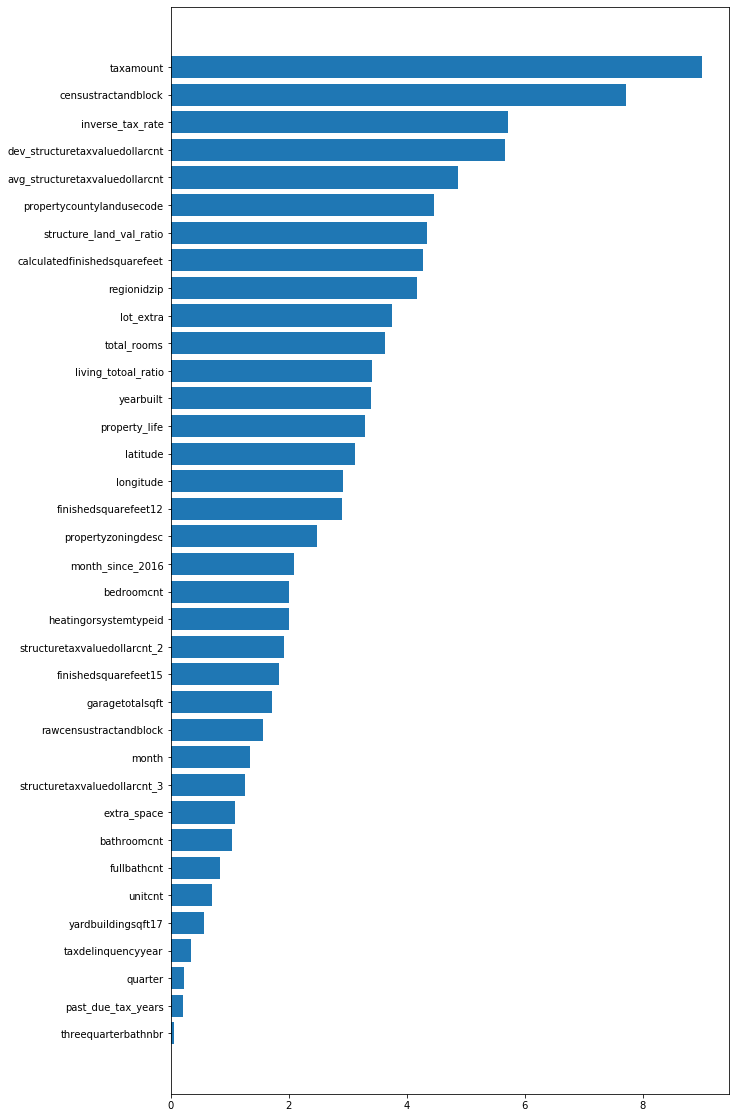

In [112]:
feat_imp = pd.DataFrame(data=good_feats.values, columns=['features'])
feat_imp['importances'] = regressor.feature_importances_
feat_imp.sort_values(by='importances', ascending=True, inplace=True)
plt.rcParams['figure.figsize'] = (10,20)
plt.barh(y=feat_imp['features'], width=feat_imp['importances'])

In [113]:
# predict 2016 result
test_16 = prop_16.copy()
test_16.insert(0, 'month', 0)
test_16.insert(1, 'month_since_2016', 0)
test_16.insert(2, 'quarter', 4)
test_16 = convert_cat_columns(test_16, cat_feats)
test_month = [(10, 201610), (11, 201611), (12, 201612)]
result_16 = pd.DataFrame()
result_16['parcelid'] = prop_16['parcelid']
for month, col in test_month:
    test_16['month'] = month
    test_16['month_since_2016'] = month
    test_pool = Pool(data=test_16[train_feats], cat_features=cat_feats)
    temp = regressor.predict(test_pool)
    result_16[col] = temp

In [114]:
# predict 2017 result
test_17 = prop_17.copy()
test_17.insert(0, 'month', 0)
test_17.insert(1, 'month_since_2016', 0)
test_17.insert(2, 'quarter', 4)
test_17 = convert_cat_columns(test_17, cat_feats)
test_month = [(10, 201710), (11, 201711), (12, 201712)]
result_17 = pd.DataFrame()
result_17['parcelid'] = prop_17['parcelid']
for month, col in test_month:
    test_17['month'] = month
    test_17['month_since_2016'] = month + 12
    test_pool = Pool(data=test_17[train_feats], cat_features=cat_feats)
    temp = regressor.predict(test_pool)
    result_17[col] = temp

In [115]:
submission = result_16.merge(result_17, on='parcelid', how='left')
submission.iloc[:,1:] = submission.iloc[:, 1:].round(4)
submission.to_csv('submission_fs.csv', index=False)

In [ ]:
# private leaderboard 0.07508. 155th place / 3775 teams. Top 4.1%